# Выпускной проект: телекоммуникации

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.  
  
***Описание услуг***  
Оператор предоставляет два основных типа услуг:  
* Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
* Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).
  
Также доступны такие услуги:  
* Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
* Выделенная линия технической поддержки (TechSupport);
* Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
* Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).
  
За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.  

***Описание данных***  
Данные состоят из файлов, полученных из разных источников:
* contract_new.csv — информация о договоре;
* personal_new.csv — персональные данные клиента;
* internet_new.csv — информация об интернет-услугах;
* phone_new.csv — информация об услугах телефонии.
  
Во всех файлах столбец customerID содержит код клиента.  
Информация о договорах актуальна на 1 февраля 2020.

**Цель проекта** - построить модель для предсказания ухода клиента. Метрика качества ROC-AUC, ROC-AUC >= 0.85.

***План***  
1. Загрузить данные, объединить датасеты, обработать пропуски (они возникнут при объединении датасетов, тк у них разное количество строк), изучить матрицу корреляции и проверить данные на аномалии. 
2. Выделить целевой признак, разделить данные на две выборки - тестовую и обучающую. Применим кодирование категориальных переменных, но некоторые модели имеют встроенные кодировщики, поэтому им можно отдать исходные данные и настроить соотвествующий гиперпараметр.
3. Протестировать несколько моделей: подобрать к ним гиперпараметры при помощи RandomizedSearchCV, выбрать лучшую модель исходя из значения метрики ROC-AUC, расчитать время обучения моделей.
4. Лучшую модель из предыдущего пункта и протестировать на тестовой выборке. Проверить модель на адекватность путем сравнения результатов с dummy моделью.
5. Исследовать важность признаков в модели, проверить работу модели без маловажных признаков.
6. Написать общие выводы по проекту.

***Загрузка библиотек***

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import time
#!pip install phik
import phik
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn.dummy import DummyClassifier

# Первая часть

## Загрузка данных

In [2]:
try:
    contract = pd.read_csv(r'contract_new.csv')
except:
    contract = pd.read_csv('/datasets/contract_new.csv')
    
try:   
    personal = pd.read_csv(r'personal_new.csv')
except:
    personal = pd.read_csv('/datasets/personal_new.csv')
    
try:
    internet = pd.read_csv(r'internet_new.csv')
except:
    internet = pd.read_csv('/datasets/internet_new.csv')

try:
    phone = pd.read_csv(r'phone_new.csv')
except:
    phone = pd.read_csv('/datasets/phone_new.csv')

## Исследование датафреймов

### Информация о договоре (contract)

In [3]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [4]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [5]:
contract.describe(exclude=[np.number]) 

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,TotalCharges
count,7043,7043,7043,7043,7043,7043,7043
unique,7043,77,67,3,2,4,6658
top,2773-OVBPK,2014-02-01,No,Month-to-month,Yes,Electronic check,
freq,1,366,5942,3875,4171,2365,11


В датасете представлено 7043 строк, пустых значений не наблюдается. Заметно, что два столбца имеют неверный тип данных (BeginDate должен быть датой, TotalCharges должен тип float).  
Большинство договоров еще не прекратили свое действие, 5942 из 7043 договоров, представленных в датасете имеют EndDate равный No.
Посмотрим на распредетление числовых признаков: 

In [6]:
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors='coerce')

array([[<AxesSubplot:title={'center':'MonthlyCharges'}>,
        <AxesSubplot:title={'center':'TotalCharges'}>]], dtype=object)

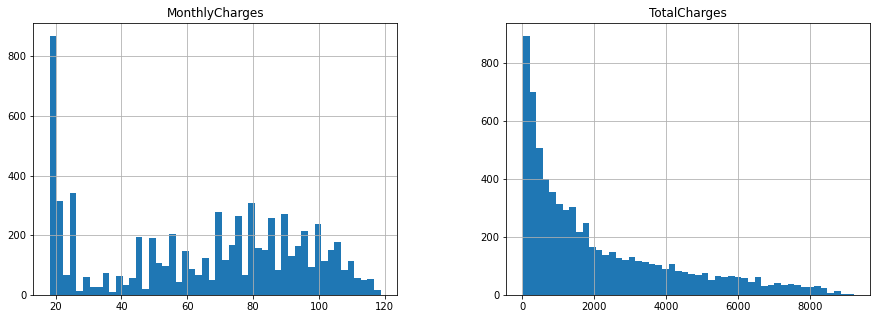

In [7]:
contract.hist(bins=50, figsize=(15,5))

In [8]:
contract.describe()

,MonthlyCharges,TotalCharges
count,7043.000000,7032.000000
mean,64.761692,2118.621822
std,30.090047,2112.736199
min,18.250000,19.050000
25%,35.500000,439.745000
50%,70.350000,1345.275000
75%,89.850000,3239.317500
max,118.750000,9221.380000


* MonthlyCharges находится в диапазоне от 18.25 до 118.75, медианное значение - 70.35.  
* TotalCharges находится в диапазоне от 19.05 до 9221.38, медианное значение - 1345.28.  

### Персональные данные клиента (personal)

In [9]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [10]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


В датафрейме так же 7043 строк, нулевых значений нет. Все переменные категориальные, переменная SeniorCitizen уже закодирована и переведена в числовой формат.

In [11]:
personal.describe(exclude=[np.number]) 

,customerID,gender,Partner,Dependents
count,7043,7043,7043,7043
unique,7043,2,2,2
top,2773-OVBPK,Male,No,No
freq,1,3555,3641,4933


Категориальные переменные бинарные, представленность классов в них практически равное.

### Информация об интернет-услугах (internet)

In [12]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [13]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [14]:
internet.describe()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,2773-OVBPK,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


В данных содержатся 5517 строк, пропусков не наблюдается. Здесь так же представлены категориальные переменные, все они бинарные (если мы не считаем customerID), значительного "перекоса" в пользу определенного класса нет.

### Информация об услугах телефонии (phone)

In [15]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [16]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [17]:
phone.describe()

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,2773-OVBPK,No
freq,1,3390


В датасете 6361 строк и 1 категориальная бинарная переменная, пропусков нет, обо значения в переменной представлены в примерно равной степени.

## План работы

1. Объеденить датасеты, обработать пропуски (они возникнут при объединении датасетов, тк у них разное количество строк), изучить матрицу корреляции и проверить данные на аномалии. 
2. Выделить целевой признак, разделить данные на две выборки - тестовую и обучающую. Применим кодирование категориальных переменных, но некоторые модели имеют встроенные кодировщики, поэтому им можно отдать исходные данные и настроить соотвествующий гиперпараметр.
3. Протестировать несколько моделей: подобрать к ним гиперпараметры при помощи RandomizedSearchCV, выбрать лучшую модель исходя из значения метрики ROC-AUC, расчитать время обучения моделей.
4. Лучшую модель из предыдущего пункта и протестировать на тестовой выборке. Проверить модель на адекватность путем сравнения результатов с dummy моделью.
5. Исследовать важность признаков в модели, проверить работу модели без маловажных признаков.
6. Написать общие выводы по проекту.

# Вторая часть

Объединим данные в один датафрейм.

In [18]:
data = contract.merge(right=personal, how='left', on='customerID')
data = data.merge(right=internet, how='left', on='customerID')
data = data.merge(right=phone, how='left', on='customerID')

data.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


## Исследование данных

### Преобразование типов данных

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7032 non-null   float64
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


Исправим у переменных BeginDate тип данных.

In [20]:
data['BeginDate'] = pd.to_datetime(data['BeginDate'])

### Проверка на наличие пропусков и дубликатов

В данных заметны пропуски, посмотрим на их количество в каждой колонке. 

In [21]:
data.isna().sum()

customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges          11
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64

Заполним пропуски: 
* TotalCharges - заполним значением 0 (это могут быть новые клиенты, которые могут еще не иметь общие расходы)
* InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies - 'not connected' (пользователь не подключен к интернету)
* MultipleLines - заполним значением 'not connected' (пользователь не подключен к телефонной связи)

In [22]:
data['TotalCharges'] = data['TotalCharges'].fillna(0)

internet_columns = ['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                    'TechSupport', 'StreamingTV', 'StreamingMovies']
for column in internet_columns:
    data[column] = data[column].fillna('not connected')

data['MultipleLines'] = data['MultipleLines'].fillna('not connected')

In [23]:
data.isna().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
dtype: int64

Проверим данные на дубликаты:

In [24]:
data.duplicated().sum()

0

### Проверка значений в переменных

Выведем данные о значениях в колонках датасета: 

In [25]:
data.describe(include='all')

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
count,7043,7043,7043,7043,7043,7043,7043.000000,7043.000000,7043,7043.000000,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,7043,77,67,3,2,4,NaN,NaN,2,NaN,2,2,3,3,3,3,3,3,3,3
top,2773-OVBPK,2014-02-01 00:00:00,No,Month-to-month,Yes,Electronic check,NaN,NaN,Male,NaN,No,No,Fiber optic,No,No,No,No,No,No,No
freq,1,366,5942,3875,4171,2365,NaN,NaN,3555,NaN,3641,4933,3096,3498,3088,3095,3473,2810,2785,3390
first,NaN,2013-10-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2020-02-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,2115.312885,NaN,0.162147,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,2112.742814,NaN,0.368612,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,436.750000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


В бинарных переменных классы представлены примерно в равной степени, также исходя из значений EndDate видно, что большинство контрактов еще действуют. Рассмотрим распределение количественнх переменных - MonthlyCharges и TotalCharges.

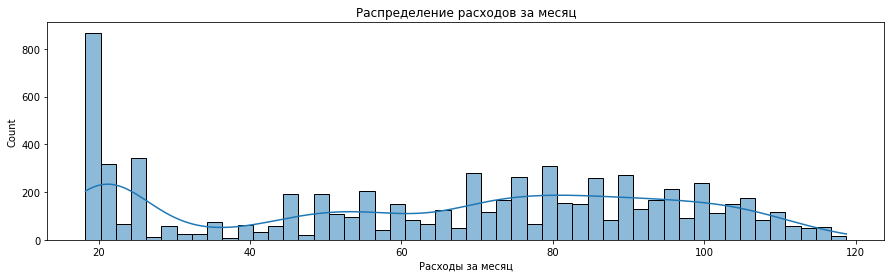

In [26]:
plt.figure(figsize=(15,4))
sns.histplot(data=data['MonthlyCharges'], bins=50, kde=True)
plt.xlabel('Расходы за месяц')
plt.title('Распределение расходов за месяц')
plt.show()

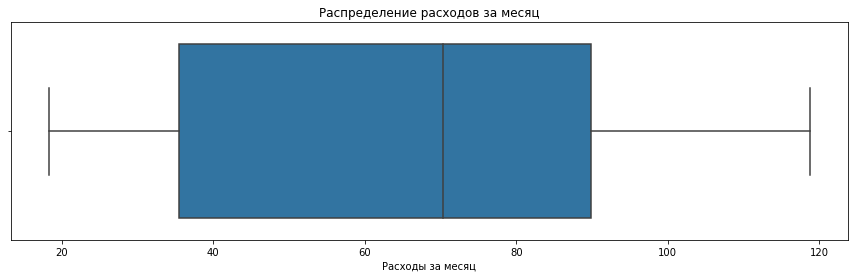

In [27]:
plt.figure(figsize=(15,4))
sns.boxplot(x=data['MonthlyCharges'])
plt.xlabel('Расходы за месяц')
plt.title('Распределение расходов за месяц')
plt.show()

Аномалии в данных отсутвуют. Рассмотрим распределение общих расходов.

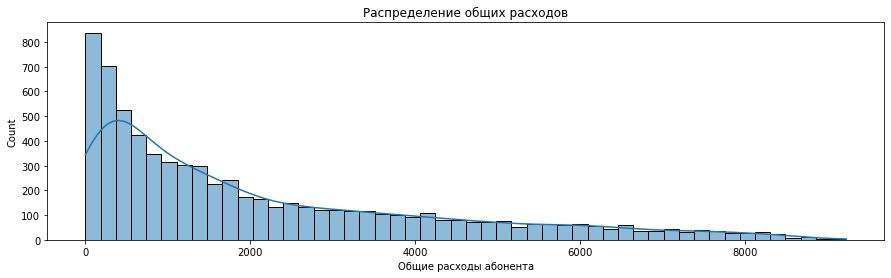

In [28]:
plt.figure(figsize=(15,4))
sns.histplot(data=data['TotalCharges'], bins=50, kde=True)
plt.xlabel('Общие расходы абонента')
plt.title('Распределение общих расходов')
plt.show()

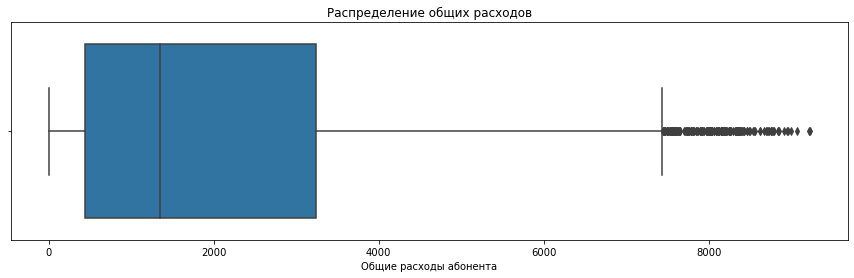

In [29]:
plt.figure(figsize=(15,4))
sns.boxplot(x=data['TotalCharges'])
plt.xlabel('Общие расходы абонента')
plt.title('Распределение общих расходов')
plt.show()

"Выбивающиеся" значения распределены достаточно плотно, поэтому мы их не будем удалять, аномалий нет.

## Подготовка данных для работы с моделями

### Выделение целевого признака

Создадим целевой признак, нам важно понимать, ушел клиент или нет, это можно отследить по колонке EndDate. Если значение переменной 'No', то договор не прекратил свое действие, то есть клиент остался, в противном случае - клиент ушел. 

In [30]:
data['target'] = data['EndDate'].apply(lambda x: 0 if x=='No' else 1)

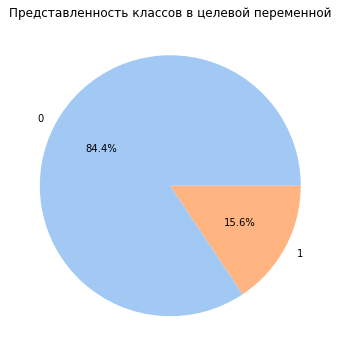

In [31]:
colors = sns.color_palette('pastel')[0:2]
data['target'].value_counts(normalize=True).plot(kind='pie', autopct='%1.1f%%', colors=colors, figsize=(6,6))
plt.title('Представленность классов в целевой переменной')
plt.ylabel('')
plt.show()

В целевой переменной классы представлены не в равной степени, но мы будем работать с моделями, которые могут справляться с этой проблемой.

Создадим переменную, которая будет отвечать за длительность контракта в днях. 

In [32]:
data['contract_date'] = data['EndDate']
data['contract_date'] = data['contract_date'].replace(to_replace=['No'], value=['2020-02-01'])
data['contract_date'] = pd.to_datetime(data['contract_date'])
data['duration'] = (data['contract_date'] - data['BeginDate']).dt.days

In [33]:
data.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,target,contract_date,duration
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,...,No,Yes,No,No,No,No,not connected,0,2020-02-01,31
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,...,Yes,No,Yes,No,No,No,No,0,2020-02-01,1036
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,...,Yes,Yes,No,No,No,No,No,0,2020-02-01,123
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,...,Yes,No,Yes,Yes,No,No,not connected,0,2020-02-01,1371
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,...,No,No,No,No,No,No,No,0,2020-02-01,153


Удалим из данных признаки BeginDate, EndDate, contract_date и customerID:

In [34]:
data.drop(['customerID', 'EndDate', 'BeginDate', 'contract_date'], axis=1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   object 
 2   PaymentMethod     7043 non-null   object 
 3   MonthlyCharges    7043 non-null   float64
 4   TotalCharges      7043 non-null   float64
 5   gender            7043 non-null   object 
 6   SeniorCitizen     7043 non-null   int64  
 7   Partner           7043 non-null   object 
 8   Dependents        7043 non-null   object 
 9   InternetService   7043 non-null   object 
 10  OnlineSecurity    7043 non-null   object 
 11  OnlineBackup      7043 non-null   object 
 12  DeviceProtection  7043 non-null   object 
 13  TechSupport       7043 non-null   object 
 14  StreamingTV       7043 non-null   object 
 15  StreamingMovies   7043 non-null   object 
 16  MultipleLines     7043 non-null   object 


### Матрица корреляции

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'target', 'duration']


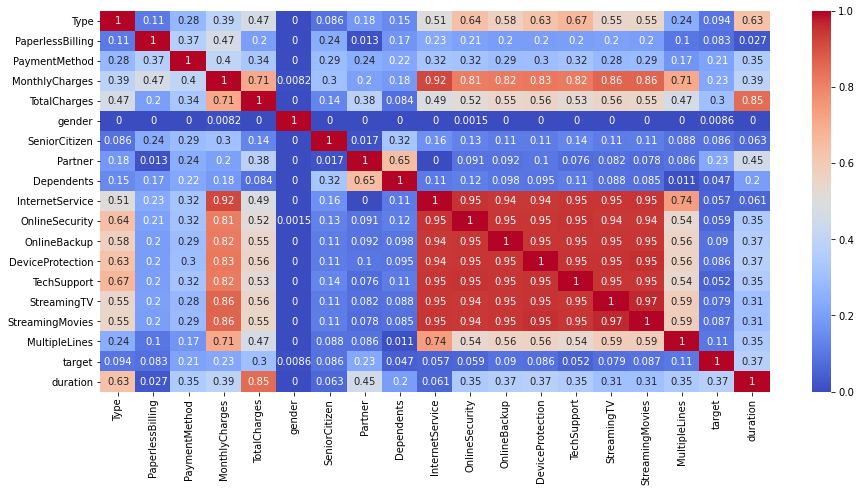

In [35]:
plt.figure(figsize=(15,7))
data_phik = data.phik_matrix()
sns.heatmap(data_phik, cmap='coolwarm', annot=True)
plt.show()

Заметно, что признак gender практически не коррелирует с другими переменными, его можно удалить. Также заметна мультиколлеарность, но модели, с которыми планируется работать дальше, могут с этим справляться.

In [36]:
data.drop(['gender'], axis=1, inplace=True)

### Разделение на выборки

In [37]:
features = data.drop('target', axis=1)
target = data['target']

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, 
                                                                            random_state=140823, stratify=target)

### Кодирование категориальных переменных

In [38]:
cat_features = ['Type', 'PaperlessBilling', 'PaymentMethod', 'Partner', 
                'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
                'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies','MultipleLines']
other_features = ['MonthlyCharges', 'TotalCharges', 'SeniorCitizen']


encoder = OneHotEncoder(drop='first', sparse = False)

features_train_ohe = encoder.fit_transform(features_train[cat_features].copy())
features_test_ohe = encoder.transform(features_test[cat_features].copy())

features_train_ohe = pd.DataFrame(features_train_ohe, columns=encoder.get_feature_names(), index=features_train.index)
features_test_ohe = pd.DataFrame(features_test_ohe, columns=encoder.get_feature_names(), index=features_test.index)

In [39]:
for column in other_features:
    features_train_ohe[column] = features_train[column]
    features_test_ohe[column] = features_test[column]

In [40]:
print('Размер тренировочной выборки')
print('Исходная:', features_train.shape)
print('Закодированная:', features_train_ohe.shape)
print('-------------------------')
print('Размер тестовой выборки')
print('Исходная:', features_test.shape)
print('Закодированная:' ,features_test_ohe.shape)

Размер тренировочной выборки
Исходная: (5282, 17)
Закодированная: (5282, 27)
-------------------------
Размер тестовой выборки
Исходная: (1761, 17)
Закодированная: (1761, 27)


Приведем также категориальные переменные к типу category для моделей, которые умеют с ними работать. 

In [41]:
for column in cat_features:
    features_train[column] = features_train[column].astype('category')
    features_test[column] = features_test[column].astype('category')

## Обучение моделей

### Catboost

In [42]:
%%time
cat_parametrs = {'learning_rate': [0.03, 0.1, 0.3],
                'depth': [4, 6, 8]}

cat_model = CatBoostClassifier(cat_features=cat_features, random_state=140823, auto_class_weights='Balanced')

cat_model_grid = GridSearchCV(cat_model, cat_parametrs, cv=5, scoring='roc_auc', verbose=2)
cat_model_grid.fit(features_train, target_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] depth=4, learning_rate=0.03 .....................................
0:	learn: 0.6859862	total: 68.3ms	remaining: 1m 8s
1:	learn: 0.6801474	total: 72.8ms	remaining: 36.3s
2:	learn: 0.6714453	total: 78.8ms	remaining: 26.2s
3:	learn: 0.6634679	total: 83ms	remaining: 20.7s
4:	learn: 0.6568979	total: 86.6ms	remaining: 17.2s
5:	learn: 0.6502138	total: 90.5ms	remaining: 15s
6:	learn: 0.6452319	total: 93.7ms	remaining: 13.3s
7:	learn: 0.6393485	total: 96.5ms	remaining: 12s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


8:	learn: 0.6337180	total: 99.8ms	remaining: 11s
9:	learn: 0.6295214	total: 104ms	remaining: 10.3s
10:	learn: 0.6241200	total: 107ms	remaining: 9.66s
11:	learn: 0.6193693	total: 111ms	remaining: 9.14s
12:	learn: 0.6147278	total: 114ms	remaining: 8.65s
13:	learn: 0.6099440	total: 117ms	remaining: 8.22s
14:	learn: 0.6064586	total: 121ms	remaining: 7.92s
15:	learn: 0.6023236	total: 124ms	remaining: 7.65s
16:	learn: 0.5987100	total: 128ms	remaining: 7.38s
17:	learn: 0.5944071	total: 131ms	remaining: 7.13s
18:	learn: 0.5906756	total: 134ms	remaining: 6.93s
19:	learn: 0.5878295	total: 138ms	remaining: 6.76s
20:	learn: 0.5853169	total: 141ms	remaining: 6.58s
21:	learn: 0.5821587	total: 144ms	remaining: 6.41s
22:	learn: 0.5792505	total: 148ms	remaining: 6.31s
23:	learn: 0.5770951	total: 153ms	remaining: 6.22s
24:	learn: 0.5740880	total: 156ms	remaining: 6.1s
25:	learn: 0.5724331	total: 159ms	remaining: 5.96s
26:	learn: 0.5696766	total: 162ms	remaining: 5.85s
27:	learn: 0.5667063	total: 166ms	r

195:	learn: 0.4813544	total: 673ms	remaining: 2.76s
196:	learn: 0.4812786	total: 675ms	remaining: 2.75s
197:	learn: 0.4811961	total: 677ms	remaining: 2.74s
198:	learn: 0.4807866	total: 680ms	remaining: 2.74s
199:	learn: 0.4804744	total: 683ms	remaining: 2.73s
200:	learn: 0.4802874	total: 686ms	remaining: 2.73s
201:	learn: 0.4802630	total: 689ms	remaining: 2.72s
202:	learn: 0.4799793	total: 692ms	remaining: 2.72s
203:	learn: 0.4799114	total: 696ms	remaining: 2.71s
204:	learn: 0.4798260	total: 699ms	remaining: 2.71s
205:	learn: 0.4796092	total: 702ms	remaining: 2.71s
206:	learn: 0.4794583	total: 706ms	remaining: 2.7s
207:	learn: 0.4792771	total: 709ms	remaining: 2.7s
208:	learn: 0.4792336	total: 712ms	remaining: 2.69s
209:	learn: 0.4791203	total: 716ms	remaining: 2.69s
210:	learn: 0.4789513	total: 718ms	remaining: 2.68s
211:	learn: 0.4788815	total: 721ms	remaining: 2.68s
212:	learn: 0.4786416	total: 724ms	remaining: 2.67s
213:	learn: 0.4786066	total: 727ms	remaining: 2.67s
214:	learn: 0.

381:	learn: 0.4431241	total: 1.26s	remaining: 2.04s
382:	learn: 0.4429806	total: 1.26s	remaining: 2.04s
383:	learn: 0.4427867	total: 1.27s	remaining: 2.03s
384:	learn: 0.4425000	total: 1.27s	remaining: 2.03s
385:	learn: 0.4422490	total: 1.27s	remaining: 2.02s
386:	learn: 0.4421738	total: 1.27s	remaining: 2.02s
387:	learn: 0.4420764	total: 1.28s	remaining: 2.02s
388:	learn: 0.4417795	total: 1.28s	remaining: 2.01s
389:	learn: 0.4414832	total: 1.28s	remaining: 2.01s
390:	learn: 0.4411385	total: 1.29s	remaining: 2.01s
391:	learn: 0.4410749	total: 1.29s	remaining: 2s
392:	learn: 0.4402679	total: 1.29s	remaining: 2s
393:	learn: 0.4398901	total: 1.3s	remaining: 2s
394:	learn: 0.4394081	total: 1.3s	remaining: 1.99s
395:	learn: 0.4392139	total: 1.3s	remaining: 1.99s
396:	learn: 0.4388838	total: 1.31s	remaining: 1.99s
397:	learn: 0.4386896	total: 1.31s	remaining: 1.98s
398:	learn: 0.4383621	total: 1.31s	remaining: 1.98s
399:	learn: 0.4380920	total: 1.32s	remaining: 1.98s
400:	learn: 0.4377187	to

554:	learn: 0.4048884	total: 1.85s	remaining: 1.49s
555:	learn: 0.4048492	total: 1.86s	remaining: 1.48s
556:	learn: 0.4044718	total: 1.86s	remaining: 1.48s
557:	learn: 0.4044323	total: 1.86s	remaining: 1.48s
558:	learn: 0.4044078	total: 1.87s	remaining: 1.47s
559:	learn: 0.4042913	total: 1.87s	remaining: 1.47s
560:	learn: 0.4037162	total: 1.88s	remaining: 1.47s
561:	learn: 0.4035096	total: 1.88s	remaining: 1.46s
562:	learn: 0.4033684	total: 1.88s	remaining: 1.46s
563:	learn: 0.4033510	total: 1.89s	remaining: 1.46s
564:	learn: 0.4031320	total: 1.89s	remaining: 1.45s
565:	learn: 0.4027207	total: 1.89s	remaining: 1.45s
566:	learn: 0.4026749	total: 1.89s	remaining: 1.45s
567:	learn: 0.4024752	total: 1.9s	remaining: 1.44s
568:	learn: 0.4023656	total: 1.9s	remaining: 1.44s
569:	learn: 0.4022161	total: 1.9s	remaining: 1.44s
570:	learn: 0.4021588	total: 1.91s	remaining: 1.43s
571:	learn: 0.4020986	total: 1.91s	remaining: 1.43s
572:	learn: 0.4020788	total: 1.91s	remaining: 1.43s
573:	learn: 0.4

729:	learn: 0.3699031	total: 2.43s	remaining: 899ms
730:	learn: 0.3698324	total: 2.43s	remaining: 895ms
731:	learn: 0.3694521	total: 2.44s	remaining: 892ms
732:	learn: 0.3694269	total: 2.44s	remaining: 888ms
733:	learn: 0.3691557	total: 2.44s	remaining: 885ms
734:	learn: 0.3691452	total: 2.44s	remaining: 882ms
735:	learn: 0.3690284	total: 2.45s	remaining: 879ms
736:	learn: 0.3690183	total: 2.45s	remaining: 875ms
737:	learn: 0.3690147	total: 2.46s	remaining: 872ms
738:	learn: 0.3690094	total: 2.46s	remaining: 868ms
739:	learn: 0.3688831	total: 2.46s	remaining: 865ms
740:	learn: 0.3687798	total: 2.46s	remaining: 862ms
741:	learn: 0.3687537	total: 2.47s	remaining: 858ms
742:	learn: 0.3687308	total: 2.47s	remaining: 855ms
743:	learn: 0.3685254	total: 2.48s	remaining: 852ms
744:	learn: 0.3683270	total: 2.48s	remaining: 848ms
745:	learn: 0.3680947	total: 2.48s	remaining: 845ms
746:	learn: 0.3679367	total: 2.48s	remaining: 842ms
747:	learn: 0.3678430	total: 2.49s	remaining: 839ms
748:	learn: 

901:	learn: 0.3483597	total: 3s	remaining: 326ms
902:	learn: 0.3482909	total: 3.01s	remaining: 323ms
903:	learn: 0.3482193	total: 3.01s	remaining: 320ms
904:	learn: 0.3479982	total: 3.01s	remaining: 316ms
905:	learn: 0.3479964	total: 3.02s	remaining: 313ms
906:	learn: 0.3478278	total: 3.02s	remaining: 310ms
907:	learn: 0.3477285	total: 3.02s	remaining: 307ms
908:	learn: 0.3475888	total: 3.03s	remaining: 303ms
909:	learn: 0.3474803	total: 3.03s	remaining: 300ms
910:	learn: 0.3474731	total: 3.04s	remaining: 297ms
911:	learn: 0.3473292	total: 3.04s	remaining: 293ms
912:	learn: 0.3472817	total: 3.04s	remaining: 290ms
913:	learn: 0.3471878	total: 3.05s	remaining: 287ms
914:	learn: 0.3471821	total: 3.05s	remaining: 283ms
915:	learn: 0.3471225	total: 3.05s	remaining: 280ms
916:	learn: 0.3469760	total: 3.06s	remaining: 277ms
917:	learn: 0.3467922	total: 3.06s	remaining: 273ms
918:	learn: 0.3467905	total: 3.06s	remaining: 270ms
919:	learn: 0.3467673	total: 3.06s	remaining: 267ms
920:	learn: 0.3

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s


17:	learn: 0.5857370	total: 55.5ms	remaining: 3.03s
18:	learn: 0.5819861	total: 60.1ms	remaining: 3.1s
19:	learn: 0.5786279	total: 63.4ms	remaining: 3.11s
20:	learn: 0.5751715	total: 66.8ms	remaining: 3.12s
21:	learn: 0.5716046	total: 70.3ms	remaining: 3.13s
22:	learn: 0.5694551	total: 74.2ms	remaining: 3.15s
23:	learn: 0.5660682	total: 77.6ms	remaining: 3.16s
24:	learn: 0.5629360	total: 80.7ms	remaining: 3.15s
25:	learn: 0.5609665	total: 84.1ms	remaining: 3.15s
26:	learn: 0.5578902	total: 87.3ms	remaining: 3.15s
27:	learn: 0.5557432	total: 90.1ms	remaining: 3.13s
28:	learn: 0.5530752	total: 92.7ms	remaining: 3.1s
29:	learn: 0.5515436	total: 95.9ms	remaining: 3.1s
30:	learn: 0.5494160	total: 98.7ms	remaining: 3.09s
31:	learn: 0.5481269	total: 102ms	remaining: 3.1s
32:	learn: 0.5459985	total: 106ms	remaining: 3.1s
33:	learn: 0.5439162	total: 108ms	remaining: 3.08s
34:	learn: 0.5422438	total: 111ms	remaining: 3.07s
35:	learn: 0.5417812	total: 114ms	remaining: 3.05s
36:	learn: 0.5402297	t

215:	learn: 0.4691467	total: 626ms	remaining: 2.27s
216:	learn: 0.4690256	total: 629ms	remaining: 2.27s
217:	learn: 0.4690256	total: 630ms	remaining: 2.26s
218:	learn: 0.4689542	total: 634ms	remaining: 2.26s
219:	learn: 0.4688448	total: 637ms	remaining: 2.26s
220:	learn: 0.4687684	total: 640ms	remaining: 2.26s
221:	learn: 0.4686187	total: 644ms	remaining: 2.25s
222:	learn: 0.4683640	total: 647ms	remaining: 2.25s
223:	learn: 0.4681705	total: 650ms	remaining: 2.25s
224:	learn: 0.4681613	total: 653ms	remaining: 2.25s
225:	learn: 0.4681074	total: 656ms	remaining: 2.25s
226:	learn: 0.4678944	total: 659ms	remaining: 2.24s
227:	learn: 0.4676967	total: 661ms	remaining: 2.24s
228:	learn: 0.4676827	total: 662ms	remaining: 2.23s
229:	learn: 0.4676628	total: 664ms	remaining: 2.22s
230:	learn: 0.4676254	total: 667ms	remaining: 2.22s
231:	learn: 0.4675833	total: 670ms	remaining: 2.22s
232:	learn: 0.4674397	total: 672ms	remaining: 2.21s
233:	learn: 0.4673280	total: 676ms	remaining: 2.21s
234:	learn: 

411:	learn: 0.4320650	total: 1.22s	remaining: 1.74s
412:	learn: 0.4317429	total: 1.22s	remaining: 1.73s
413:	learn: 0.4313994	total: 1.22s	remaining: 1.73s
414:	learn: 0.4308210	total: 1.23s	remaining: 1.73s
415:	learn: 0.4307695	total: 1.23s	remaining: 1.73s
416:	learn: 0.4306494	total: 1.23s	remaining: 1.72s
417:	learn: 0.4305690	total: 1.24s	remaining: 1.72s
418:	learn: 0.4303511	total: 1.24s	remaining: 1.72s
419:	learn: 0.4297738	total: 1.24s	remaining: 1.72s
420:	learn: 0.4292910	total: 1.25s	remaining: 1.71s
421:	learn: 0.4290557	total: 1.25s	remaining: 1.71s
422:	learn: 0.4289764	total: 1.25s	remaining: 1.71s
423:	learn: 0.4284622	total: 1.26s	remaining: 1.71s
424:	learn: 0.4279995	total: 1.26s	remaining: 1.7s
425:	learn: 0.4275251	total: 1.26s	remaining: 1.7s
426:	learn: 0.4271256	total: 1.26s	remaining: 1.7s
427:	learn: 0.4269202	total: 1.27s	remaining: 1.69s
428:	learn: 0.4266822	total: 1.27s	remaining: 1.69s
429:	learn: 0.4265965	total: 1.27s	remaining: 1.69s
430:	learn: 0.4

596:	learn: 0.3959135	total: 1.81s	remaining: 1.22s
597:	learn: 0.3957162	total: 1.81s	remaining: 1.22s
598:	learn: 0.3957006	total: 1.82s	remaining: 1.22s
599:	learn: 0.3955988	total: 1.82s	remaining: 1.21s
600:	learn: 0.3953695	total: 1.82s	remaining: 1.21s
601:	learn: 0.3950578	total: 1.83s	remaining: 1.21s
602:	learn: 0.3949833	total: 1.83s	remaining: 1.2s
603:	learn: 0.3948887	total: 1.83s	remaining: 1.2s
604:	learn: 0.3943889	total: 1.84s	remaining: 1.2s
605:	learn: 0.3939179	total: 1.84s	remaining: 1.2s
606:	learn: 0.3937442	total: 1.84s	remaining: 1.19s
607:	learn: 0.3935897	total: 1.85s	remaining: 1.19s
608:	learn: 0.3935120	total: 1.85s	remaining: 1.19s
609:	learn: 0.3934178	total: 1.85s	remaining: 1.19s
610:	learn: 0.3933116	total: 1.86s	remaining: 1.18s
611:	learn: 0.3931833	total: 1.86s	remaining: 1.18s
612:	learn: 0.3931247	total: 1.86s	remaining: 1.18s
613:	learn: 0.3931065	total: 1.87s	remaining: 1.17s
614:	learn: 0.3926511	total: 1.87s	remaining: 1.17s
615:	learn: 0.39

779:	learn: 0.3626548	total: 2.4s	remaining: 677ms
780:	learn: 0.3625874	total: 2.4s	remaining: 674ms
781:	learn: 0.3623505	total: 2.4s	remaining: 671ms
782:	learn: 0.3620699	total: 2.41s	remaining: 668ms
783:	learn: 0.3617937	total: 2.41s	remaining: 665ms
784:	learn: 0.3613629	total: 2.42s	remaining: 662ms
785:	learn: 0.3608332	total: 2.42s	remaining: 659ms
786:	learn: 0.3606519	total: 2.42s	remaining: 656ms
787:	learn: 0.3605933	total: 2.43s	remaining: 653ms
788:	learn: 0.3602119	total: 2.43s	remaining: 650ms
789:	learn: 0.3601167	total: 2.43s	remaining: 647ms
790:	learn: 0.3599090	total: 2.44s	remaining: 644ms
791:	learn: 0.3596319	total: 2.44s	remaining: 641ms
792:	learn: 0.3596189	total: 2.44s	remaining: 638ms
793:	learn: 0.3594650	total: 2.45s	remaining: 635ms
794:	learn: 0.3594528	total: 2.45s	remaining: 632ms
795:	learn: 0.3593270	total: 2.45s	remaining: 628ms
796:	learn: 0.3589743	total: 2.46s	remaining: 625ms
797:	learn: 0.3587275	total: 2.46s	remaining: 622ms
798:	learn: 0.3

959:	learn: 0.3337709	total: 2.99s	remaining: 125ms
960:	learn: 0.3337294	total: 3s	remaining: 122ms
961:	learn: 0.3336268	total: 3s	remaining: 118ms
962:	learn: 0.3335166	total: 3s	remaining: 115ms
963:	learn: 0.3334833	total: 3.01s	remaining: 112ms
964:	learn: 0.3333203	total: 3.01s	remaining: 109ms
965:	learn: 0.3331565	total: 3.01s	remaining: 106ms
966:	learn: 0.3329401	total: 3.02s	remaining: 103ms
967:	learn: 0.3324555	total: 3.02s	remaining: 99.9ms
968:	learn: 0.3323984	total: 3.02s	remaining: 96.7ms
969:	learn: 0.3323019	total: 3.03s	remaining: 93.6ms
970:	learn: 0.3322522	total: 3.03s	remaining: 90.5ms
971:	learn: 0.3319026	total: 3.03s	remaining: 87.4ms
972:	learn: 0.3316671	total: 3.04s	remaining: 84.3ms
973:	learn: 0.3314741	total: 3.04s	remaining: 81.2ms
974:	learn: 0.3313786	total: 3.04s	remaining: 78.1ms
975:	learn: 0.3311478	total: 3.05s	remaining: 75ms
976:	learn: 0.3310073	total: 3.05s	remaining: 71.8ms
977:	learn: 0.3307147	total: 3.05s	remaining: 68.7ms
978:	learn: 

154:	learn: 0.4919307	total: 439ms	remaining: 2.39s
155:	learn: 0.4915686	total: 441ms	remaining: 2.38s
156:	learn: 0.4914066	total: 444ms	remaining: 2.38s
157:	learn: 0.4912340	total: 447ms	remaining: 2.38s
158:	learn: 0.4911108	total: 451ms	remaining: 2.38s
159:	learn: 0.4910733	total: 452ms	remaining: 2.38s
160:	learn: 0.4910601	total: 455ms	remaining: 2.37s
161:	learn: 0.4908788	total: 457ms	remaining: 2.37s
162:	learn: 0.4908788	total: 459ms	remaining: 2.35s
163:	learn: 0.4907829	total: 461ms	remaining: 2.35s
164:	learn: 0.4907722	total: 462ms	remaining: 2.34s
165:	learn: 0.4907711	total: 465ms	remaining: 2.33s
166:	learn: 0.4906375	total: 468ms	remaining: 2.33s
167:	learn: 0.4906234	total: 470ms	remaining: 2.33s
168:	learn: 0.4905118	total: 473ms	remaining: 2.33s
169:	learn: 0.4905001	total: 475ms	remaining: 2.32s
170:	learn: 0.4904278	total: 478ms	remaining: 2.32s
171:	learn: 0.4904265	total: 480ms	remaining: 2.31s
172:	learn: 0.4904072	total: 484ms	remaining: 2.31s
173:	learn: 

335:	learn: 0.4617376	total: 969ms	remaining: 1.91s
336:	learn: 0.4616398	total: 972ms	remaining: 1.91s
337:	learn: 0.4613947	total: 975ms	remaining: 1.91s
338:	learn: 0.4610628	total: 978ms	remaining: 1.91s
339:	learn: 0.4608688	total: 982ms	remaining: 1.91s
340:	learn: 0.4604224	total: 985ms	remaining: 1.9s
341:	learn: 0.4601792	total: 989ms	remaining: 1.9s
342:	learn: 0.4596527	total: 993ms	remaining: 1.9s
343:	learn: 0.4596232	total: 996ms	remaining: 1.9s
344:	learn: 0.4594606	total: 999ms	remaining: 1.9s
345:	learn: 0.4594189	total: 1s	remaining: 1.89s
346:	learn: 0.4592558	total: 1s	remaining: 1.89s
347:	learn: 0.4590845	total: 1.01s	remaining: 1.89s
348:	learn: 0.4585847	total: 1.01s	remaining: 1.89s
349:	learn: 0.4581478	total: 1.01s	remaining: 1.89s
350:	learn: 0.4577789	total: 1.02s	remaining: 1.88s
351:	learn: 0.4571122	total: 1.02s	remaining: 1.88s
352:	learn: 0.4570701	total: 1.02s	remaining: 1.88s
353:	learn: 0.4568366	total: 1.03s	remaining: 1.88s
354:	learn: 0.4566497	t

518:	learn: 0.4179180	total: 1.56s	remaining: 1.45s
519:	learn: 0.4178621	total: 1.57s	remaining: 1.45s
520:	learn: 0.4177606	total: 1.57s	remaining: 1.45s
521:	learn: 0.4174042	total: 1.58s	remaining: 1.45s
522:	learn: 0.4173628	total: 1.58s	remaining: 1.44s
523:	learn: 0.4171971	total: 1.59s	remaining: 1.44s
524:	learn: 0.4171297	total: 1.59s	remaining: 1.44s
525:	learn: 0.4170148	total: 1.59s	remaining: 1.44s
526:	learn: 0.4168786	total: 1.6s	remaining: 1.43s
527:	learn: 0.4168093	total: 1.6s	remaining: 1.43s
528:	learn: 0.4167033	total: 1.6s	remaining: 1.43s
529:	learn: 0.4165820	total: 1.61s	remaining: 1.42s
530:	learn: 0.4164905	total: 1.61s	remaining: 1.42s
531:	learn: 0.4163234	total: 1.61s	remaining: 1.42s
532:	learn: 0.4159491	total: 1.62s	remaining: 1.42s
533:	learn: 0.4159149	total: 1.62s	remaining: 1.41s
534:	learn: 0.4158673	total: 1.62s	remaining: 1.41s
535:	learn: 0.4158618	total: 1.63s	remaining: 1.41s
536:	learn: 0.4157915	total: 1.63s	remaining: 1.41s
537:	learn: 0.4

698:	learn: 0.3883227	total: 2.15s	remaining: 927ms
699:	learn: 0.3882210	total: 2.15s	remaining: 924ms
700:	learn: 0.3881448	total: 2.16s	remaining: 920ms
701:	learn: 0.3881279	total: 2.16s	remaining: 917ms
702:	learn: 0.3879779	total: 2.16s	remaining: 914ms
703:	learn: 0.3879116	total: 2.17s	remaining: 911ms
704:	learn: 0.3875816	total: 2.17s	remaining: 908ms
705:	learn: 0.3875435	total: 2.17s	remaining: 905ms
706:	learn: 0.3872590	total: 2.18s	remaining: 903ms
707:	learn: 0.3871708	total: 2.18s	remaining: 899ms
708:	learn: 0.3869217	total: 2.18s	remaining: 896ms
709:	learn: 0.3868769	total: 2.19s	remaining: 893ms
710:	learn: 0.3867162	total: 2.19s	remaining: 890ms
711:	learn: 0.3866464	total: 2.19s	remaining: 887ms
712:	learn: 0.3865212	total: 2.2s	remaining: 884ms
713:	learn: 0.3864089	total: 2.2s	remaining: 881ms
714:	learn: 0.3862958	total: 2.2s	remaining: 878ms
715:	learn: 0.3862818	total: 2.21s	remaining: 875ms
716:	learn: 0.3861916	total: 2.21s	remaining: 872ms
717:	learn: 0.3

878:	learn: 0.3560655	total: 2.74s	remaining: 378ms
879:	learn: 0.3559771	total: 2.75s	remaining: 375ms
880:	learn: 0.3556758	total: 2.75s	remaining: 371ms
881:	learn: 0.3555274	total: 2.75s	remaining: 368ms
882:	learn: 0.3553447	total: 2.76s	remaining: 365ms
883:	learn: 0.3552619	total: 2.76s	remaining: 362ms
884:	learn: 0.3550077	total: 2.76s	remaining: 359ms
885:	learn: 0.3548790	total: 2.77s	remaining: 356ms
886:	learn: 0.3547833	total: 2.77s	remaining: 353ms
887:	learn: 0.3547009	total: 2.77s	remaining: 350ms
888:	learn: 0.3546297	total: 2.78s	remaining: 347ms
889:	learn: 0.3545766	total: 2.78s	remaining: 344ms
890:	learn: 0.3545272	total: 2.78s	remaining: 341ms
891:	learn: 0.3539765	total: 2.79s	remaining: 338ms
892:	learn: 0.3539356	total: 2.79s	remaining: 334ms
893:	learn: 0.3536182	total: 2.79s	remaining: 331ms
894:	learn: 0.3533560	total: 2.8s	remaining: 328ms
895:	learn: 0.3532045	total: 2.8s	remaining: 325ms
896:	learn: 0.3530483	total: 2.8s	remaining: 322ms
897:	learn: 0.3

63:	learn: 0.5154946	total: 187ms	remaining: 2.73s
64:	learn: 0.5153281	total: 189ms	remaining: 2.71s
65:	learn: 0.5145170	total: 191ms	remaining: 2.7s
66:	learn: 0.5136552	total: 194ms	remaining: 2.7s
67:	learn: 0.5126314	total: 197ms	remaining: 2.7s
68:	learn: 0.5122002	total: 199ms	remaining: 2.69s
69:	learn: 0.5117512	total: 202ms	remaining: 2.68s
70:	learn: 0.5110546	total: 205ms	remaining: 2.68s
71:	learn: 0.5099973	total: 208ms	remaining: 2.68s
72:	learn: 0.5098009	total: 211ms	remaining: 2.68s
73:	learn: 0.5095471	total: 214ms	remaining: 2.68s
74:	learn: 0.5088977	total: 218ms	remaining: 2.69s
75:	learn: 0.5081572	total: 221ms	remaining: 2.69s
76:	learn: 0.5077842	total: 224ms	remaining: 2.68s
77:	learn: 0.5071223	total: 227ms	remaining: 2.68s
78:	learn: 0.5063980	total: 229ms	remaining: 2.67s
79:	learn: 0.5056687	total: 233ms	remaining: 2.68s
80:	learn: 0.5052468	total: 236ms	remaining: 2.67s
81:	learn: 0.5046396	total: 238ms	remaining: 2.67s
82:	learn: 0.5043923	total: 240ms	

274:	learn: 0.4613759	total: 778ms	remaining: 2.05s
275:	learn: 0.4610173	total: 782ms	remaining: 2.05s
276:	learn: 0.4605685	total: 785ms	remaining: 2.05s
277:	learn: 0.4604460	total: 788ms	remaining: 2.04s
278:	learn: 0.4602667	total: 791ms	remaining: 2.04s
279:	learn: 0.4600664	total: 795ms	remaining: 2.04s
280:	learn: 0.4598696	total: 798ms	remaining: 2.04s
281:	learn: 0.4596411	total: 802ms	remaining: 2.04s
282:	learn: 0.4592282	total: 805ms	remaining: 2.04s
283:	learn: 0.4589754	total: 807ms	remaining: 2.03s
284:	learn: 0.4586279	total: 810ms	remaining: 2.03s
285:	learn: 0.4585982	total: 813ms	remaining: 2.03s
286:	learn: 0.4581968	total: 817ms	remaining: 2.03s
287:	learn: 0.4579521	total: 819ms	remaining: 2.02s
288:	learn: 0.4576488	total: 822ms	remaining: 2.02s
289:	learn: 0.4575484	total: 826ms	remaining: 2.02s
290:	learn: 0.4570799	total: 829ms	remaining: 2.02s
291:	learn: 0.4569801	total: 832ms	remaining: 2.02s
292:	learn: 0.4567904	total: 835ms	remaining: 2.02s
293:	learn: 

458:	learn: 0.4201400	total: 1.37s	remaining: 1.61s
459:	learn: 0.4197228	total: 1.37s	remaining: 1.61s
460:	learn: 0.4196349	total: 1.37s	remaining: 1.61s
461:	learn: 0.4192469	total: 1.38s	remaining: 1.6s
462:	learn: 0.4187813	total: 1.38s	remaining: 1.6s
463:	learn: 0.4182204	total: 1.39s	remaining: 1.6s
464:	learn: 0.4181466	total: 1.39s	remaining: 1.6s
465:	learn: 0.4177692	total: 1.39s	remaining: 1.6s
466:	learn: 0.4176109	total: 1.4s	remaining: 1.59s
467:	learn: 0.4175425	total: 1.4s	remaining: 1.59s
468:	learn: 0.4174789	total: 1.4s	remaining: 1.59s
469:	learn: 0.4172944	total: 1.41s	remaining: 1.58s
470:	learn: 0.4171326	total: 1.41s	remaining: 1.58s
471:	learn: 0.4168586	total: 1.41s	remaining: 1.58s
472:	learn: 0.4163485	total: 1.42s	remaining: 1.58s
473:	learn: 0.4158238	total: 1.42s	remaining: 1.57s
474:	learn: 0.4155823	total: 1.42s	remaining: 1.57s
475:	learn: 0.4152150	total: 1.43s	remaining: 1.57s
476:	learn: 0.4150799	total: 1.43s	remaining: 1.57s
477:	learn: 0.415055

639:	learn: 0.3831908	total: 1.96s	remaining: 1.1s
640:	learn: 0.3829946	total: 1.96s	remaining: 1.1s
641:	learn: 0.3827811	total: 1.97s	remaining: 1.09s
642:	learn: 0.3826896	total: 1.97s	remaining: 1.09s
643:	learn: 0.3826278	total: 1.97s	remaining: 1.09s
644:	learn: 0.3825706	total: 1.98s	remaining: 1.09s
645:	learn: 0.3823122	total: 1.98s	remaining: 1.08s
646:	learn: 0.3821823	total: 1.98s	remaining: 1.08s
647:	learn: 0.3821420	total: 1.99s	remaining: 1.08s
648:	learn: 0.3819608	total: 1.99s	remaining: 1.07s
649:	learn: 0.3818074	total: 1.99s	remaining: 1.07s
650:	learn: 0.3816631	total: 2s	remaining: 1.07s
651:	learn: 0.3814773	total: 2s	remaining: 1.07s
652:	learn: 0.3813956	total: 2s	remaining: 1.06s
653:	learn: 0.3808758	total: 2.01s	remaining: 1.06s
654:	learn: 0.3807856	total: 2.01s	remaining: 1.06s
655:	learn: 0.3804243	total: 2.01s	remaining: 1.05s
656:	learn: 0.3803935	total: 2.02s	remaining: 1.05s
657:	learn: 0.3802659	total: 2.02s	remaining: 1.05s
658:	learn: 0.3799861	t

819:	learn: 0.3518037	total: 2.55s	remaining: 560ms
820:	learn: 0.3517120	total: 2.55s	remaining: 557ms
821:	learn: 0.3516979	total: 2.56s	remaining: 554ms
822:	learn: 0.3512968	total: 2.56s	remaining: 551ms
823:	learn: 0.3512553	total: 2.56s	remaining: 548ms
824:	learn: 0.3512272	total: 2.57s	remaining: 545ms
825:	learn: 0.3508972	total: 2.57s	remaining: 541ms
826:	learn: 0.3508078	total: 2.57s	remaining: 538ms
827:	learn: 0.3506784	total: 2.58s	remaining: 535ms
828:	learn: 0.3505923	total: 2.58s	remaining: 532ms
829:	learn: 0.3505336	total: 2.58s	remaining: 529ms
830:	learn: 0.3504668	total: 2.59s	remaining: 526ms
831:	learn: 0.3504280	total: 2.59s	remaining: 523ms
832:	learn: 0.3503659	total: 2.59s	remaining: 520ms
833:	learn: 0.3501189	total: 2.6s	remaining: 517ms
834:	learn: 0.3500308	total: 2.6s	remaining: 514ms
835:	learn: 0.3499392	total: 2.6s	remaining: 510ms
836:	learn: 0.3498499	total: 2.6s	remaining: 507ms
837:	learn: 0.3497658	total: 2.61s	remaining: 504ms
838:	learn: 0.34

[CV] ...................... depth=4, learning_rate=0.03, total=   3.2s
[CV] depth=4, learning_rate=0.03 .....................................
0:	learn: 0.6856316	total: 3.13ms	remaining: 3.13s
1:	learn: 0.6769940	total: 5.76ms	remaining: 2.87s
2:	learn: 0.6699813	total: 9.09ms	remaining: 3.02s
3:	learn: 0.6629658	total: 12.3ms	remaining: 3.07s
4:	learn: 0.6584929	total: 15.2ms	remaining: 3.02s
5:	learn: 0.6516860	total: 18.7ms	remaining: 3.1s
6:	learn: 0.6451378	total: 21.8ms	remaining: 3.1s
7:	learn: 0.6392956	total: 24.6ms	remaining: 3.05s
8:	learn: 0.6334212	total: 27.2ms	remaining: 3s
9:	learn: 0.6296684	total: 29.6ms	remaining: 2.93s
10:	learn: 0.6246859	total: 32ms	remaining: 2.88s
11:	learn: 0.6193144	total: 34.8ms	remaining: 2.86s
12:	learn: 0.6139671	total: 37.9ms	remaining: 2.88s
13:	learn: 0.6090662	total: 41.6ms	remaining: 2.93s
14:	learn: 0.6046750	total: 44.3ms	remaining: 2.91s
15:	learn: 0.6001973	total: 47.6ms	remaining: 2.93s
16:	learn: 0.5962870	total: 50.3ms	remainin

208:	learn: 0.4694788	total: 582ms	remaining: 2.2s
209:	learn: 0.4693201	total: 585ms	remaining: 2.2s
210:	learn: 0.4692693	total: 588ms	remaining: 2.2s
211:	learn: 0.4692441	total: 591ms	remaining: 2.2s
212:	learn: 0.4690389	total: 594ms	remaining: 2.19s
213:	learn: 0.4688880	total: 597ms	remaining: 2.19s
214:	learn: 0.4687743	total: 600ms	remaining: 2.19s
215:	learn: 0.4685933	total: 602ms	remaining: 2.19s
216:	learn: 0.4685133	total: 604ms	remaining: 2.18s
217:	learn: 0.4684103	total: 608ms	remaining: 2.18s
218:	learn: 0.4684103	total: 610ms	remaining: 2.17s
219:	learn: 0.4683760	total: 612ms	remaining: 2.17s
220:	learn: 0.4683010	total: 614ms	remaining: 2.16s
221:	learn: 0.4681964	total: 618ms	remaining: 2.16s
222:	learn: 0.4681687	total: 621ms	remaining: 2.16s
223:	learn: 0.4681687	total: 622ms	remaining: 2.15s
224:	learn: 0.4680706	total: 623ms	remaining: 2.15s
225:	learn: 0.4679569	total: 626ms	remaining: 2.15s
226:	learn: 0.4679471	total: 629ms	remaining: 2.14s
227:	learn: 0.46

403:	learn: 0.4289745	total: 1.17s	remaining: 1.73s
404:	learn: 0.4286801	total: 1.18s	remaining: 1.73s
405:	learn: 0.4280786	total: 1.18s	remaining: 1.73s
406:	learn: 0.4276967	total: 1.18s	remaining: 1.73s
407:	learn: 0.4275337	total: 1.19s	remaining: 1.72s
408:	learn: 0.4274905	total: 1.19s	remaining: 1.72s
409:	learn: 0.4274523	total: 1.19s	remaining: 1.72s
410:	learn: 0.4273789	total: 1.2s	remaining: 1.71s
411:	learn: 0.4270082	total: 1.2s	remaining: 1.71s
412:	learn: 0.4268915	total: 1.2s	remaining: 1.71s
413:	learn: 0.4267770	total: 1.21s	remaining: 1.71s
414:	learn: 0.4266108	total: 1.21s	remaining: 1.71s
415:	learn: 0.4262705	total: 1.21s	remaining: 1.7s
416:	learn: 0.4260598	total: 1.22s	remaining: 1.7s
417:	learn: 0.4257631	total: 1.22s	remaining: 1.7s
418:	learn: 0.4253346	total: 1.22s	remaining: 1.69s
419:	learn: 0.4249742	total: 1.23s	remaining: 1.69s
420:	learn: 0.4245808	total: 1.23s	remaining: 1.69s
421:	learn: 0.4242401	total: 1.23s	remaining: 1.69s
422:	learn: 0.4239

583:	learn: 0.3814107	total: 1.77s	remaining: 1.26s
584:	learn: 0.3811348	total: 1.77s	remaining: 1.26s
585:	learn: 0.3810713	total: 1.77s	remaining: 1.25s
586:	learn: 0.3807909	total: 1.78s	remaining: 1.25s
587:	learn: 0.3807532	total: 1.78s	remaining: 1.25s
588:	learn: 0.3802220	total: 1.78s	remaining: 1.24s
589:	learn: 0.3797601	total: 1.79s	remaining: 1.24s
590:	learn: 0.3796949	total: 1.79s	remaining: 1.24s
591:	learn: 0.3795027	total: 1.79s	remaining: 1.24s
592:	learn: 0.3791472	total: 1.8s	remaining: 1.23s
593:	learn: 0.3788725	total: 1.8s	remaining: 1.23s
594:	learn: 0.3786812	total: 1.8s	remaining: 1.23s
595:	learn: 0.3786008	total: 1.81s	remaining: 1.23s
596:	learn: 0.3785109	total: 1.81s	remaining: 1.22s
597:	learn: 0.3784199	total: 1.81s	remaining: 1.22s
598:	learn: 0.3777155	total: 1.82s	remaining: 1.22s
599:	learn: 0.3775911	total: 1.82s	remaining: 1.21s
600:	learn: 0.3773768	total: 1.82s	remaining: 1.21s
601:	learn: 0.3772921	total: 1.83s	remaining: 1.21s
602:	learn: 0.3

764:	learn: 0.3484323	total: 2.35s	remaining: 723ms
765:	learn: 0.3483609	total: 2.36s	remaining: 720ms
766:	learn: 0.3481418	total: 2.36s	remaining: 717ms
767:	learn: 0.3477312	total: 2.37s	remaining: 715ms
768:	learn: 0.3474770	total: 2.37s	remaining: 712ms
769:	learn: 0.3473700	total: 2.37s	remaining: 709ms
770:	learn: 0.3471668	total: 2.38s	remaining: 706ms
771:	learn: 0.3470179	total: 2.38s	remaining: 703ms
772:	learn: 0.3468633	total: 2.38s	remaining: 700ms
773:	learn: 0.3467685	total: 2.38s	remaining: 697ms
774:	learn: 0.3467227	total: 2.39s	remaining: 693ms
775:	learn: 0.3466509	total: 2.39s	remaining: 690ms
776:	learn: 0.3461892	total: 2.39s	remaining: 687ms
777:	learn: 0.3461373	total: 2.4s	remaining: 684ms
778:	learn: 0.3459703	total: 2.4s	remaining: 681ms
779:	learn: 0.3459491	total: 2.4s	remaining: 678ms
780:	learn: 0.3458913	total: 2.41s	remaining: 675ms
781:	learn: 0.3454168	total: 2.41s	remaining: 672ms
782:	learn: 0.3453881	total: 2.42s	remaining: 669ms
783:	learn: 0.3

941:	learn: 0.3212180	total: 2.94s	remaining: 181ms
942:	learn: 0.3208155	total: 2.95s	remaining: 178ms
943:	learn: 0.3207144	total: 2.95s	remaining: 175ms
944:	learn: 0.3204540	total: 2.96s	remaining: 172ms
945:	learn: 0.3204204	total: 2.96s	remaining: 169ms
946:	learn: 0.3203864	total: 2.96s	remaining: 166ms
947:	learn: 0.3203108	total: 2.97s	remaining: 163ms
948:	learn: 0.3202346	total: 2.97s	remaining: 160ms
949:	learn: 0.3201232	total: 2.98s	remaining: 157ms
950:	learn: 0.3199434	total: 2.98s	remaining: 154ms
951:	learn: 0.3198828	total: 2.98s	remaining: 150ms
952:	learn: 0.3198038	total: 2.99s	remaining: 147ms
953:	learn: 0.3196349	total: 2.99s	remaining: 144ms
954:	learn: 0.3194954	total: 2.99s	remaining: 141ms
955:	learn: 0.3193798	total: 3s	remaining: 138ms
956:	learn: 0.3193003	total: 3s	remaining: 135ms
957:	learn: 0.3192976	total: 3s	remaining: 132ms
958:	learn: 0.3191709	total: 3s	remaining: 129ms
959:	learn: 0.3190318	total: 3.01s	remaining: 125ms
960:	learn: 0.3187563	to

123:	learn: 0.4355156	total: 367ms	remaining: 2.59s
124:	learn: 0.4349623	total: 370ms	remaining: 2.59s
125:	learn: 0.4333015	total: 373ms	remaining: 2.59s
126:	learn: 0.4323045	total: 376ms	remaining: 2.58s
127:	learn: 0.4315975	total: 379ms	remaining: 2.58s
128:	learn: 0.4308657	total: 382ms	remaining: 2.58s
129:	learn: 0.4305380	total: 386ms	remaining: 2.58s
130:	learn: 0.4297511	total: 389ms	remaining: 2.58s
131:	learn: 0.4291471	total: 392ms	remaining: 2.58s
132:	learn: 0.4283437	total: 395ms	remaining: 2.57s
133:	learn: 0.4280234	total: 399ms	remaining: 2.58s
134:	learn: 0.4276837	total: 402ms	remaining: 2.58s
135:	learn: 0.4258775	total: 406ms	remaining: 2.58s
136:	learn: 0.4247562	total: 409ms	remaining: 2.58s
137:	learn: 0.4236840	total: 413ms	remaining: 2.58s
138:	learn: 0.4236351	total: 417ms	remaining: 2.58s
139:	learn: 0.4234397	total: 420ms	remaining: 2.58s
140:	learn: 0.4227727	total: 423ms	remaining: 2.58s
141:	learn: 0.4222324	total: 427ms	remaining: 2.58s
142:	learn: 

306:	learn: 0.3269014	total: 958ms	remaining: 2.16s
307:	learn: 0.3266845	total: 961ms	remaining: 2.16s
308:	learn: 0.3266634	total: 965ms	remaining: 2.16s
309:	learn: 0.3266209	total: 967ms	remaining: 2.15s
310:	learn: 0.3263034	total: 971ms	remaining: 2.15s
311:	learn: 0.3262127	total: 974ms	remaining: 2.15s
312:	learn: 0.3252141	total: 977ms	remaining: 2.14s
313:	learn: 0.3249483	total: 981ms	remaining: 2.14s
314:	learn: 0.3245193	total: 983ms	remaining: 2.14s
315:	learn: 0.3244817	total: 987ms	remaining: 2.14s
316:	learn: 0.3243523	total: 992ms	remaining: 2.14s
317:	learn: 0.3238278	total: 996ms	remaining: 2.13s
318:	learn: 0.3236802	total: 999ms	remaining: 2.13s
319:	learn: 0.3231153	total: 1s	remaining: 2.13s
320:	learn: 0.3220566	total: 1s	remaining: 2.13s
321:	learn: 0.3216769	total: 1.01s	remaining: 2.12s
322:	learn: 0.3213499	total: 1.01s	remaining: 2.12s
323:	learn: 0.3212582	total: 1.01s	remaining: 2.12s
324:	learn: 0.3211736	total: 1.02s	remaining: 2.11s
325:	learn: 0.3211

486:	learn: 0.2620617	total: 1.55s	remaining: 1.63s
487:	learn: 0.2619104	total: 1.55s	remaining: 1.63s
488:	learn: 0.2615973	total: 1.55s	remaining: 1.62s
489:	learn: 0.2612292	total: 1.56s	remaining: 1.62s
490:	learn: 0.2608462	total: 1.56s	remaining: 1.62s
491:	learn: 0.2605418	total: 1.56s	remaining: 1.62s
492:	learn: 0.2604099	total: 1.57s	remaining: 1.61s
493:	learn: 0.2601561	total: 1.57s	remaining: 1.61s
494:	learn: 0.2600689	total: 1.58s	remaining: 1.61s
495:	learn: 0.2600042	total: 1.58s	remaining: 1.6s
496:	learn: 0.2592169	total: 1.58s	remaining: 1.6s
497:	learn: 0.2589359	total: 1.59s	remaining: 1.6s
498:	learn: 0.2586443	total: 1.59s	remaining: 1.59s
499:	learn: 0.2586088	total: 1.59s	remaining: 1.59s
500:	learn: 0.2584503	total: 1.59s	remaining: 1.59s
501:	learn: 0.2582167	total: 1.6s	remaining: 1.58s
502:	learn: 0.2573052	total: 1.6s	remaining: 1.58s
503:	learn: 0.2568172	total: 1.61s	remaining: 1.58s
504:	learn: 0.2567108	total: 1.61s	remaining: 1.58s
505:	learn: 0.256

662:	learn: 0.2179051	total: 2.13s	remaining: 1.08s
663:	learn: 0.2177104	total: 2.13s	remaining: 1.08s
664:	learn: 0.2175987	total: 2.13s	remaining: 1.07s
665:	learn: 0.2174865	total: 2.14s	remaining: 1.07s
666:	learn: 0.2172143	total: 2.14s	remaining: 1.07s
667:	learn: 0.2170234	total: 2.14s	remaining: 1.06s
668:	learn: 0.2167101	total: 2.15s	remaining: 1.06s
669:	learn: 0.2166609	total: 2.15s	remaining: 1.06s
670:	learn: 0.2166395	total: 2.15s	remaining: 1.06s
671:	learn: 0.2165065	total: 2.16s	remaining: 1.05s
672:	learn: 0.2163587	total: 2.16s	remaining: 1.05s
673:	learn: 0.2160613	total: 2.17s	remaining: 1.05s
674:	learn: 0.2160276	total: 2.17s	remaining: 1.04s
675:	learn: 0.2154990	total: 2.17s	remaining: 1.04s
676:	learn: 0.2152238	total: 2.17s	remaining: 1.04s
677:	learn: 0.2151549	total: 2.18s	remaining: 1.03s
678:	learn: 0.2149033	total: 2.18s	remaining: 1.03s
679:	learn: 0.2146061	total: 2.19s	remaining: 1.03s
680:	learn: 0.2145101	total: 2.19s	remaining: 1.02s
681:	learn: 

844:	learn: 0.1814142	total: 2.72s	remaining: 499ms
845:	learn: 0.1812845	total: 2.72s	remaining: 496ms
846:	learn: 0.1812246	total: 2.73s	remaining: 492ms
847:	learn: 0.1810191	total: 2.73s	remaining: 489ms
848:	learn: 0.1809670	total: 2.73s	remaining: 486ms
849:	learn: 0.1808959	total: 2.74s	remaining: 483ms
850:	learn: 0.1808607	total: 2.74s	remaining: 480ms
851:	learn: 0.1806945	total: 2.74s	remaining: 477ms
852:	learn: 0.1805901	total: 2.75s	remaining: 473ms
853:	learn: 0.1803370	total: 2.75s	remaining: 470ms
854:	learn: 0.1802439	total: 2.75s	remaining: 467ms
855:	learn: 0.1800816	total: 2.76s	remaining: 464ms
856:	learn: 0.1799217	total: 2.76s	remaining: 461ms
857:	learn: 0.1796069	total: 2.76s	remaining: 457ms
858:	learn: 0.1791782	total: 2.77s	remaining: 454ms
859:	learn: 0.1790746	total: 2.77s	remaining: 451ms
860:	learn: 0.1785047	total: 2.77s	remaining: 448ms
861:	learn: 0.1783452	total: 2.78s	remaining: 445ms
862:	learn: 0.1782422	total: 2.78s	remaining: 441ms
863:	learn: 

18:	learn: 0.5100730	total: 56.2ms	remaining: 2.9s
19:	learn: 0.5071027	total: 59.4ms	remaining: 2.91s
20:	learn: 0.5055052	total: 61.6ms	remaining: 2.87s
21:	learn: 0.5041092	total: 64.2ms	remaining: 2.85s
22:	learn: 0.5021614	total: 67.4ms	remaining: 2.86s
23:	learn: 0.5003814	total: 70.5ms	remaining: 2.87s
24:	learn: 0.4983176	total: 74.3ms	remaining: 2.9s
25:	learn: 0.4975127	total: 76.2ms	remaining: 2.86s
26:	learn: 0.4960282	total: 79.2ms	remaining: 2.85s
27:	learn: 0.4942222	total: 82.2ms	remaining: 2.85s
28:	learn: 0.4936011	total: 85.8ms	remaining: 2.87s
29:	learn: 0.4923113	total: 88.8ms	remaining: 2.87s
30:	learn: 0.4917869	total: 91.4ms	remaining: 2.86s
31:	learn: 0.4894453	total: 94.8ms	remaining: 2.87s
32:	learn: 0.4888731	total: 97.7ms	remaining: 2.86s
33:	learn: 0.4871892	total: 101ms	remaining: 2.86s
34:	learn: 0.4866159	total: 104ms	remaining: 2.85s
35:	learn: 0.4861068	total: 108ms	remaining: 2.89s
36:	learn: 0.4847704	total: 110ms	remaining: 2.88s
37:	learn: 0.48415

214:	learn: 0.3742146	total: 649ms	remaining: 2.37s
215:	learn: 0.3735609	total: 652ms	remaining: 2.37s
216:	learn: 0.3732258	total: 655ms	remaining: 2.36s
217:	learn: 0.3728619	total: 658ms	remaining: 2.36s
218:	learn: 0.3728197	total: 662ms	remaining: 2.36s
219:	learn: 0.3723192	total: 666ms	remaining: 2.36s
220:	learn: 0.3718345	total: 669ms	remaining: 2.36s
221:	learn: 0.3707468	total: 673ms	remaining: 2.36s
222:	learn: 0.3695399	total: 676ms	remaining: 2.36s
223:	learn: 0.3690467	total: 679ms	remaining: 2.35s
224:	learn: 0.3677561	total: 682ms	remaining: 2.35s
225:	learn: 0.3673413	total: 685ms	remaining: 2.35s
226:	learn: 0.3660604	total: 688ms	remaining: 2.34s
227:	learn: 0.3647881	total: 691ms	remaining: 2.34s
228:	learn: 0.3645017	total: 694ms	remaining: 2.34s
229:	learn: 0.3634992	total: 697ms	remaining: 2.33s
230:	learn: 0.3619735	total: 700ms	remaining: 2.33s
231:	learn: 0.3615885	total: 704ms	remaining: 2.33s
232:	learn: 0.3605157	total: 708ms	remaining: 2.33s
233:	learn: 

397:	learn: 0.2791735	total: 1.24s	remaining: 1.88s
398:	learn: 0.2790495	total: 1.24s	remaining: 1.87s
399:	learn: 0.2787277	total: 1.25s	remaining: 1.87s
400:	learn: 0.2782047	total: 1.25s	remaining: 1.87s
401:	learn: 0.2780862	total: 1.25s	remaining: 1.86s
402:	learn: 0.2774373	total: 1.26s	remaining: 1.86s
403:	learn: 0.2764914	total: 1.26s	remaining: 1.86s
404:	learn: 0.2760679	total: 1.26s	remaining: 1.85s
405:	learn: 0.2759973	total: 1.27s	remaining: 1.85s
406:	learn: 0.2753716	total: 1.27s	remaining: 1.85s
407:	learn: 0.2748857	total: 1.27s	remaining: 1.85s
408:	learn: 0.2740181	total: 1.28s	remaining: 1.85s
409:	learn: 0.2738902	total: 1.28s	remaining: 1.84s
410:	learn: 0.2733567	total: 1.28s	remaining: 1.84s
411:	learn: 0.2723228	total: 1.29s	remaining: 1.84s
412:	learn: 0.2722265	total: 1.29s	remaining: 1.83s
413:	learn: 0.2721330	total: 1.29s	remaining: 1.83s
414:	learn: 0.2719908	total: 1.3s	remaining: 1.83s
415:	learn: 0.2718898	total: 1.3s	remaining: 1.82s
416:	learn: 0.

579:	learn: 0.2299935	total: 1.83s	remaining: 1.32s
580:	learn: 0.2295625	total: 1.83s	remaining: 1.32s
581:	learn: 0.2293636	total: 1.84s	remaining: 1.32s
582:	learn: 0.2293078	total: 1.84s	remaining: 1.32s
583:	learn: 0.2290041	total: 1.84s	remaining: 1.31s
584:	learn: 0.2287100	total: 1.85s	remaining: 1.31s
585:	learn: 0.2284400	total: 1.85s	remaining: 1.31s
586:	learn: 0.2279081	total: 1.85s	remaining: 1.3s
587:	learn: 0.2277113	total: 1.86s	remaining: 1.3s
588:	learn: 0.2275516	total: 1.86s	remaining: 1.3s
589:	learn: 0.2273550	total: 1.87s	remaining: 1.3s
590:	learn: 0.2263390	total: 1.87s	remaining: 1.29s
591:	learn: 0.2262862	total: 1.87s	remaining: 1.29s
592:	learn: 0.2262164	total: 1.88s	remaining: 1.29s
593:	learn: 0.2259952	total: 1.88s	remaining: 1.28s
594:	learn: 0.2259197	total: 1.88s	remaining: 1.28s
595:	learn: 0.2257765	total: 1.89s	remaining: 1.28s
596:	learn: 0.2253740	total: 1.89s	remaining: 1.28s
597:	learn: 0.2253673	total: 1.89s	remaining: 1.27s
598:	learn: 0.22

763:	learn: 0.1893787	total: 2.42s	remaining: 748ms
764:	learn: 0.1889442	total: 2.42s	remaining: 745ms
765:	learn: 0.1886123	total: 2.43s	remaining: 742ms
766:	learn: 0.1885638	total: 2.43s	remaining: 739ms
767:	learn: 0.1885195	total: 2.44s	remaining: 736ms
768:	learn: 0.1883220	total: 2.44s	remaining: 733ms
769:	learn: 0.1881987	total: 2.44s	remaining: 729ms
770:	learn: 0.1877514	total: 2.44s	remaining: 726ms
771:	learn: 0.1876824	total: 2.45s	remaining: 723ms
772:	learn: 0.1871288	total: 2.46s	remaining: 721ms
773:	learn: 0.1868669	total: 2.46s	remaining: 718ms
774:	learn: 0.1867957	total: 2.46s	remaining: 715ms
775:	learn: 0.1866497	total: 2.47s	remaining: 712ms
776:	learn: 0.1863448	total: 2.47s	remaining: 709ms
777:	learn: 0.1863194	total: 2.47s	remaining: 706ms
778:	learn: 0.1862198	total: 2.48s	remaining: 703ms
779:	learn: 0.1860608	total: 2.48s	remaining: 699ms
780:	learn: 0.1856944	total: 2.48s	remaining: 696ms
781:	learn: 0.1854995	total: 2.49s	remaining: 693ms
782:	learn: 

945:	learn: 0.1602055	total: 3.01s	remaining: 172ms
946:	learn: 0.1601412	total: 3.02s	remaining: 169ms
947:	learn: 0.1601049	total: 3.02s	remaining: 166ms
948:	learn: 0.1600657	total: 3.02s	remaining: 162ms
949:	learn: 0.1598733	total: 3.02s	remaining: 159ms
950:	learn: 0.1598424	total: 3.03s	remaining: 156ms
951:	learn: 0.1597640	total: 3.03s	remaining: 153ms
952:	learn: 0.1597055	total: 3.03s	remaining: 150ms
953:	learn: 0.1596220	total: 3.04s	remaining: 147ms
954:	learn: 0.1593466	total: 3.04s	remaining: 143ms
955:	learn: 0.1592476	total: 3.05s	remaining: 140ms
956:	learn: 0.1592244	total: 3.05s	remaining: 137ms
957:	learn: 0.1591689	total: 3.05s	remaining: 134ms
958:	learn: 0.1590524	total: 3.06s	remaining: 131ms
959:	learn: 0.1589109	total: 3.06s	remaining: 127ms
960:	learn: 0.1586900	total: 3.06s	remaining: 124ms
961:	learn: 0.1586147	total: 3.06s	remaining: 121ms
962:	learn: 0.1585233	total: 3.07s	remaining: 118ms
963:	learn: 0.1584900	total: 3.07s	remaining: 115ms
964:	learn: 

129:	learn: 0.4324011	total: 395ms	remaining: 2.64s
130:	learn: 0.4306536	total: 398ms	remaining: 2.64s
131:	learn: 0.4302935	total: 402ms	remaining: 2.65s
132:	learn: 0.4297624	total: 406ms	remaining: 2.65s
133:	learn: 0.4292307	total: 409ms	remaining: 2.64s
134:	learn: 0.4279505	total: 412ms	remaining: 2.64s
135:	learn: 0.4266595	total: 416ms	remaining: 2.64s
136:	learn: 0.4259942	total: 419ms	remaining: 2.64s
137:	learn: 0.4257913	total: 421ms	remaining: 2.63s
138:	learn: 0.4243778	total: 425ms	remaining: 2.63s
139:	learn: 0.4234551	total: 428ms	remaining: 2.63s
140:	learn: 0.4224320	total: 431ms	remaining: 2.62s
141:	learn: 0.4222014	total: 434ms	remaining: 2.62s
142:	learn: 0.4218619	total: 437ms	remaining: 2.62s
143:	learn: 0.4216991	total: 440ms	remaining: 2.62s
144:	learn: 0.4216673	total: 443ms	remaining: 2.61s
145:	learn: 0.4205915	total: 446ms	remaining: 2.61s
146:	learn: 0.4193423	total: 450ms	remaining: 2.61s
147:	learn: 0.4179487	total: 454ms	remaining: 2.61s
148:	learn: 

308:	learn: 0.3250909	total: 984ms	remaining: 2.2s
309:	learn: 0.3248839	total: 988ms	remaining: 2.2s
310:	learn: 0.3244597	total: 991ms	remaining: 2.19s
311:	learn: 0.3241668	total: 994ms	remaining: 2.19s
312:	learn: 0.3231663	total: 998ms	remaining: 2.19s
313:	learn: 0.3231304	total: 1s	remaining: 2.19s
314:	learn: 0.3229087	total: 1s	remaining: 2.19s
315:	learn: 0.3223839	total: 1.01s	remaining: 2.18s
316:	learn: 0.3220364	total: 1.01s	remaining: 2.18s
317:	learn: 0.3217284	total: 1.01s	remaining: 2.18s
318:	learn: 0.3214475	total: 1.02s	remaining: 2.17s
319:	learn: 0.3212842	total: 1.02s	remaining: 2.17s
320:	learn: 0.3209178	total: 1.02s	remaining: 2.17s
321:	learn: 0.3205061	total: 1.03s	remaining: 2.17s
322:	learn: 0.3198719	total: 1.03s	remaining: 2.16s
323:	learn: 0.3190196	total: 1.03s	remaining: 2.16s
324:	learn: 0.3189204	total: 1.04s	remaining: 2.15s
325:	learn: 0.3186590	total: 1.04s	remaining: 2.15s
326:	learn: 0.3181264	total: 1.04s	remaining: 2.15s
327:	learn: 0.318096

488:	learn: 0.2646768	total: 1.57s	remaining: 1.64s
489:	learn: 0.2638269	total: 1.57s	remaining: 1.64s
490:	learn: 0.2637749	total: 1.58s	remaining: 1.64s
491:	learn: 0.2636285	total: 1.58s	remaining: 1.63s
492:	learn: 0.2635688	total: 1.58s	remaining: 1.63s
493:	learn: 0.2632248	total: 1.59s	remaining: 1.63s
494:	learn: 0.2630609	total: 1.59s	remaining: 1.62s
495:	learn: 0.2628297	total: 1.59s	remaining: 1.62s
496:	learn: 0.2624738	total: 1.6s	remaining: 1.62s
497:	learn: 0.2620115	total: 1.6s	remaining: 1.61s
498:	learn: 0.2618230	total: 1.6s	remaining: 1.61s
499:	learn: 0.2614098	total: 1.61s	remaining: 1.61s
500:	learn: 0.2612741	total: 1.61s	remaining: 1.6s
501:	learn: 0.2611312	total: 1.61s	remaining: 1.6s
502:	learn: 0.2604036	total: 1.62s	remaining: 1.6s
503:	learn: 0.2603084	total: 1.62s	remaining: 1.6s
504:	learn: 0.2600717	total: 1.63s	remaining: 1.59s
505:	learn: 0.2598827	total: 1.63s	remaining: 1.59s
506:	learn: 0.2594485	total: 1.63s	remaining: 1.59s
507:	learn: 0.25938

670:	learn: 0.2163903	total: 2.16s	remaining: 1.06s
671:	learn: 0.2162374	total: 2.17s	remaining: 1.06s
672:	learn: 0.2161095	total: 2.17s	remaining: 1.05s
673:	learn: 0.2160799	total: 2.17s	remaining: 1.05s
674:	learn: 0.2158005	total: 2.18s	remaining: 1.05s
675:	learn: 0.2156213	total: 2.18s	remaining: 1.05s
676:	learn: 0.2155173	total: 2.19s	remaining: 1.04s
677:	learn: 0.2153251	total: 2.19s	remaining: 1.04s
678:	learn: 0.2151602	total: 2.19s	remaining: 1.04s
679:	learn: 0.2150587	total: 2.19s	remaining: 1.03s
680:	learn: 0.2149057	total: 2.2s	remaining: 1.03s
681:	learn: 0.2148369	total: 2.2s	remaining: 1.03s
682:	learn: 0.2148255	total: 2.21s	remaining: 1.02s
683:	learn: 0.2147726	total: 2.21s	remaining: 1.02s
684:	learn: 0.2144050	total: 2.21s	remaining: 1.02s
685:	learn: 0.2142425	total: 2.21s	remaining: 1.01s
686:	learn: 0.2141683	total: 2.22s	remaining: 1.01s
687:	learn: 0.2135088	total: 2.22s	remaining: 1.01s
688:	learn: 0.2133344	total: 2.23s	remaining: 1s
689:	learn: 0.213

845:	learn: 0.1844598	total: 2.76s	remaining: 502ms
846:	learn: 0.1842730	total: 2.76s	remaining: 499ms
847:	learn: 0.1841453	total: 2.76s	remaining: 495ms
848:	learn: 0.1841069	total: 2.77s	remaining: 492ms
849:	learn: 0.1837799	total: 2.77s	remaining: 489ms
850:	learn: 0.1835518	total: 2.77s	remaining: 486ms
851:	learn: 0.1832986	total: 2.78s	remaining: 483ms
852:	learn: 0.1831872	total: 2.78s	remaining: 479ms
853:	learn: 0.1830859	total: 2.78s	remaining: 476ms
854:	learn: 0.1829708	total: 2.79s	remaining: 473ms
855:	learn: 0.1828681	total: 2.79s	remaining: 470ms
856:	learn: 0.1826294	total: 2.79s	remaining: 466ms
857:	learn: 0.1825215	total: 2.8s	remaining: 463ms
858:	learn: 0.1823886	total: 2.8s	remaining: 460ms
859:	learn: 0.1823064	total: 2.8s	remaining: 456ms
860:	learn: 0.1821007	total: 2.81s	remaining: 453ms
861:	learn: 0.1817896	total: 2.81s	remaining: 450ms
862:	learn: 0.1815539	total: 2.81s	remaining: 447ms
863:	learn: 0.1813663	total: 2.82s	remaining: 444ms
864:	learn: 0.1

20:	learn: 0.5108657	total: 59.5ms	remaining: 2.77s
21:	learn: 0.5090542	total: 62.1ms	remaining: 2.76s
22:	learn: 0.5066779	total: 65.1ms	remaining: 2.77s
23:	learn: 0.5048077	total: 67.9ms	remaining: 2.76s
24:	learn: 0.5046079	total: 69.5ms	remaining: 2.71s
25:	learn: 0.5027563	total: 72.6ms	remaining: 2.72s
26:	learn: 0.5022480	total: 75.7ms	remaining: 2.73s
27:	learn: 0.5018528	total: 77.3ms	remaining: 2.68s
28:	learn: 0.5010194	total: 79.4ms	remaining: 2.66s
29:	learn: 0.4989354	total: 82.2ms	remaining: 2.66s
30:	learn: 0.4968865	total: 86.2ms	remaining: 2.69s
31:	learn: 0.4956833	total: 89.6ms	remaining: 2.71s
32:	learn: 0.4945109	total: 93.3ms	remaining: 2.73s
33:	learn: 0.4932750	total: 96ms	remaining: 2.73s
34:	learn: 0.4916477	total: 98.7ms	remaining: 2.72s
35:	learn: 0.4904175	total: 101ms	remaining: 2.71s
36:	learn: 0.4893917	total: 104ms	remaining: 2.71s
37:	learn: 0.4891931	total: 106ms	remaining: 2.68s
38:	learn: 0.4875457	total: 109ms	remaining: 2.69s
39:	learn: 0.48566

212:	learn: 0.3692069	total: 652ms	remaining: 2.41s
213:	learn: 0.3691913	total: 656ms	remaining: 2.41s
214:	learn: 0.3688358	total: 658ms	remaining: 2.4s
215:	learn: 0.3668059	total: 662ms	remaining: 2.4s
216:	learn: 0.3648430	total: 665ms	remaining: 2.4s
217:	learn: 0.3640486	total: 668ms	remaining: 2.4s
218:	learn: 0.3635915	total: 672ms	remaining: 2.4s
219:	learn: 0.3631524	total: 675ms	remaining: 2.39s
220:	learn: 0.3630570	total: 679ms	remaining: 2.39s
221:	learn: 0.3621246	total: 682ms	remaining: 2.39s
222:	learn: 0.3616874	total: 685ms	remaining: 2.39s
223:	learn: 0.3616642	total: 689ms	remaining: 2.39s
224:	learn: 0.3614314	total: 692ms	remaining: 2.38s
225:	learn: 0.3600624	total: 696ms	remaining: 2.38s
226:	learn: 0.3579751	total: 699ms	remaining: 2.38s
227:	learn: 0.3579695	total: 703ms	remaining: 2.38s
228:	learn: 0.3577100	total: 706ms	remaining: 2.38s
229:	learn: 0.3561411	total: 709ms	remaining: 2.37s
230:	learn: 0.3552723	total: 712ms	remaining: 2.37s
231:	learn: 0.354

392:	learn: 0.2815383	total: 1.25s	remaining: 1.92s
393:	learn: 0.2807704	total: 1.25s	remaining: 1.92s
394:	learn: 0.2802961	total: 1.25s	remaining: 1.92s
395:	learn: 0.2799056	total: 1.26s	remaining: 1.92s
396:	learn: 0.2794995	total: 1.26s	remaining: 1.91s
397:	learn: 0.2793793	total: 1.26s	remaining: 1.91s
398:	learn: 0.2792700	total: 1.26s	remaining: 1.91s
399:	learn: 0.2788159	total: 1.27s	remaining: 1.9s
400:	learn: 0.2785424	total: 1.27s	remaining: 1.9s
401:	learn: 0.2784894	total: 1.28s	remaining: 1.9s
402:	learn: 0.2783216	total: 1.28s	remaining: 1.9s
403:	learn: 0.2782177	total: 1.28s	remaining: 1.89s
404:	learn: 0.2778684	total: 1.29s	remaining: 1.89s
405:	learn: 0.2777729	total: 1.29s	remaining: 1.89s
406:	learn: 0.2774368	total: 1.29s	remaining: 1.89s
407:	learn: 0.2769824	total: 1.3s	remaining: 1.88s
408:	learn: 0.2765793	total: 1.3s	remaining: 1.88s
409:	learn: 0.2764342	total: 1.3s	remaining: 1.88s
410:	learn: 0.2762024	total: 1.31s	remaining: 1.87s
411:	learn: 0.27591

574:	learn: 0.2304264	total: 1.84s	remaining: 1.36s
575:	learn: 0.2300405	total: 1.84s	remaining: 1.36s
576:	learn: 0.2294973	total: 1.85s	remaining: 1.35s
577:	learn: 0.2294280	total: 1.85s	remaining: 1.35s
578:	learn: 0.2292002	total: 1.85s	remaining: 1.35s
579:	learn: 0.2290492	total: 1.86s	remaining: 1.34s
580:	learn: 0.2290200	total: 1.86s	remaining: 1.34s
581:	learn: 0.2289522	total: 1.86s	remaining: 1.34s
582:	learn: 0.2288616	total: 1.87s	remaining: 1.33s
583:	learn: 0.2287850	total: 1.87s	remaining: 1.33s
584:	learn: 0.2286477	total: 1.88s	remaining: 1.33s
585:	learn: 0.2286152	total: 1.88s	remaining: 1.33s
586:	learn: 0.2278372	total: 1.88s	remaining: 1.32s
587:	learn: 0.2275001	total: 1.89s	remaining: 1.32s
588:	learn: 0.2271087	total: 1.89s	remaining: 1.32s
589:	learn: 0.2266297	total: 1.89s	remaining: 1.31s
590:	learn: 0.2262991	total: 1.9s	remaining: 1.31s
591:	learn: 0.2262197	total: 1.9s	remaining: 1.31s
592:	learn: 0.2258958	total: 1.9s	remaining: 1.3s
593:	learn: 0.22

753:	learn: 0.1931735	total: 2.43s	remaining: 793ms
754:	learn: 0.1930338	total: 2.43s	remaining: 790ms
755:	learn: 0.1929344	total: 2.44s	remaining: 787ms
756:	learn: 0.1927589	total: 2.44s	remaining: 783ms
757:	learn: 0.1927217	total: 2.44s	remaining: 780ms
758:	learn: 0.1925928	total: 2.45s	remaining: 777ms
759:	learn: 0.1924484	total: 2.45s	remaining: 774ms
760:	learn: 0.1924057	total: 2.46s	remaining: 771ms
761:	learn: 0.1922780	total: 2.46s	remaining: 768ms
762:	learn: 0.1921102	total: 2.46s	remaining: 765ms
763:	learn: 0.1920090	total: 2.47s	remaining: 762ms
764:	learn: 0.1914107	total: 2.47s	remaining: 759ms
765:	learn: 0.1913295	total: 2.47s	remaining: 755ms
766:	learn: 0.1912640	total: 2.48s	remaining: 752ms
767:	learn: 0.1910743	total: 2.48s	remaining: 749ms
768:	learn: 0.1909237	total: 2.48s	remaining: 745ms
769:	learn: 0.1908533	total: 2.48s	remaining: 742ms
770:	learn: 0.1905724	total: 2.49s	remaining: 739ms
771:	learn: 0.1904422	total: 2.49s	remaining: 736ms
772:	learn: 

931:	learn: 0.1626315	total: 3.02s	remaining: 220ms
932:	learn: 0.1625544	total: 3.02s	remaining: 217ms
933:	learn: 0.1624563	total: 3.03s	remaining: 214ms
934:	learn: 0.1623276	total: 3.03s	remaining: 211ms
935:	learn: 0.1622836	total: 3.03s	remaining: 207ms
936:	learn: 0.1621180	total: 3.04s	remaining: 204ms
937:	learn: 0.1618775	total: 3.04s	remaining: 201ms
938:	learn: 0.1617212	total: 3.04s	remaining: 198ms
939:	learn: 0.1616181	total: 3.05s	remaining: 195ms
940:	learn: 0.1613570	total: 3.05s	remaining: 191ms
941:	learn: 0.1612700	total: 3.05s	remaining: 188ms
942:	learn: 0.1612428	total: 3.06s	remaining: 185ms
943:	learn: 0.1612075	total: 3.06s	remaining: 182ms
944:	learn: 0.1609470	total: 3.06s	remaining: 178ms
945:	learn: 0.1609034	total: 3.07s	remaining: 175ms
946:	learn: 0.1607523	total: 3.07s	remaining: 172ms
947:	learn: 0.1606811	total: 3.08s	remaining: 169ms
948:	learn: 0.1606024	total: 3.08s	remaining: 165ms
949:	learn: 0.1603799	total: 3.08s	remaining: 162ms
950:	learn: 

117:	learn: 0.4303444	total: 341ms	remaining: 2.55s
118:	learn: 0.4293388	total: 344ms	remaining: 2.55s
119:	learn: 0.4291956	total: 347ms	remaining: 2.55s
120:	learn: 0.4264810	total: 351ms	remaining: 2.55s
121:	learn: 0.4258219	total: 354ms	remaining: 2.54s
122:	learn: 0.4246348	total: 357ms	remaining: 2.54s
123:	learn: 0.4232307	total: 360ms	remaining: 2.54s
124:	learn: 0.4215658	total: 363ms	remaining: 2.54s
125:	learn: 0.4199634	total: 366ms	remaining: 2.54s
126:	learn: 0.4178448	total: 370ms	remaining: 2.54s
127:	learn: 0.4170586	total: 374ms	remaining: 2.55s
128:	learn: 0.4152512	total: 377ms	remaining: 2.54s
129:	learn: 0.4139902	total: 380ms	remaining: 2.54s
130:	learn: 0.4133561	total: 384ms	remaining: 2.54s
131:	learn: 0.4130613	total: 387ms	remaining: 2.54s
132:	learn: 0.4130035	total: 390ms	remaining: 2.54s
133:	learn: 0.4110381	total: 394ms	remaining: 2.54s
134:	learn: 0.4095060	total: 397ms	remaining: 2.54s
135:	learn: 0.4093427	total: 402ms	remaining: 2.55s
136:	learn: 

298:	learn: 0.3099780	total: 931ms	remaining: 2.18s
299:	learn: 0.3098620	total: 935ms	remaining: 2.18s
300:	learn: 0.3092467	total: 938ms	remaining: 2.18s
301:	learn: 0.3089506	total: 942ms	remaining: 2.18s
302:	learn: 0.3080469	total: 945ms	remaining: 2.17s
303:	learn: 0.3076396	total: 948ms	remaining: 2.17s
304:	learn: 0.3073691	total: 952ms	remaining: 2.17s
305:	learn: 0.3069337	total: 956ms	remaining: 2.17s
306:	learn: 0.3065893	total: 959ms	remaining: 2.16s
307:	learn: 0.3064261	total: 962ms	remaining: 2.16s
308:	learn: 0.3061263	total: 966ms	remaining: 2.16s
309:	learn: 0.3058565	total: 969ms	remaining: 2.16s
310:	learn: 0.3054864	total: 972ms	remaining: 2.15s
311:	learn: 0.3052565	total: 975ms	remaining: 2.15s
312:	learn: 0.3050913	total: 978ms	remaining: 2.15s
313:	learn: 0.3048496	total: 981ms	remaining: 2.14s
314:	learn: 0.3046205	total: 984ms	remaining: 2.14s
315:	learn: 0.3040766	total: 988ms	remaining: 2.14s
316:	learn: 0.3036347	total: 990ms	remaining: 2.13s
317:	learn: 

473:	learn: 0.2485057	total: 1.51s	remaining: 1.67s
474:	learn: 0.2484132	total: 1.51s	remaining: 1.67s
475:	learn: 0.2480055	total: 1.51s	remaining: 1.67s
476:	learn: 0.2477979	total: 1.52s	remaining: 1.66s
477:	learn: 0.2474664	total: 1.52s	remaining: 1.66s
478:	learn: 0.2472801	total: 1.52s	remaining: 1.66s
479:	learn: 0.2471695	total: 1.53s	remaining: 1.66s
480:	learn: 0.2469633	total: 1.53s	remaining: 1.65s
481:	learn: 0.2467762	total: 1.53s	remaining: 1.65s
482:	learn: 0.2466548	total: 1.54s	remaining: 1.65s
483:	learn: 0.2465188	total: 1.54s	remaining: 1.64s
484:	learn: 0.2463018	total: 1.54s	remaining: 1.64s
485:	learn: 0.2462034	total: 1.55s	remaining: 1.64s
486:	learn: 0.2460969	total: 1.55s	remaining: 1.63s
487:	learn: 0.2456974	total: 1.55s	remaining: 1.63s
488:	learn: 0.2451488	total: 1.56s	remaining: 1.63s
489:	learn: 0.2450812	total: 1.56s	remaining: 1.62s
490:	learn: 0.2448943	total: 1.56s	remaining: 1.62s
491:	learn: 0.2448606	total: 1.57s	remaining: 1.62s
492:	learn: 

645:	learn: 0.2064603	total: 2.08s	remaining: 1.14s
646:	learn: 0.2063553	total: 2.08s	remaining: 1.14s
647:	learn: 0.2060403	total: 2.09s	remaining: 1.13s
648:	learn: 0.2058198	total: 2.09s	remaining: 1.13s
649:	learn: 0.2058117	total: 2.1s	remaining: 1.13s
650:	learn: 0.2057622	total: 2.1s	remaining: 1.12s
651:	learn: 0.2056599	total: 2.1s	remaining: 1.12s
652:	learn: 0.2052767	total: 2.1s	remaining: 1.12s
653:	learn: 0.2050913	total: 2.11s	remaining: 1.11s
654:	learn: 0.2048658	total: 2.11s	remaining: 1.11s
655:	learn: 0.2046265	total: 2.11s	remaining: 1.11s
656:	learn: 0.2042104	total: 2.12s	remaining: 1.1s
657:	learn: 0.2040978	total: 2.12s	remaining: 1.1s
658:	learn: 0.2039537	total: 2.12s	remaining: 1.1s
659:	learn: 0.2038596	total: 2.13s	remaining: 1.09s
660:	learn: 0.2036551	total: 2.13s	remaining: 1.09s
661:	learn: 0.2033335	total: 2.13s	remaining: 1.09s
662:	learn: 0.2032235	total: 2.14s	remaining: 1.09s
663:	learn: 0.2030186	total: 2.14s	remaining: 1.08s
664:	learn: 0.20268

825:	learn: 0.1776389	total: 2.67s	remaining: 563ms
826:	learn: 0.1775865	total: 2.67s	remaining: 560ms
827:	learn: 0.1770387	total: 2.68s	remaining: 556ms
828:	learn: 0.1769499	total: 2.68s	remaining: 553ms
829:	learn: 0.1767804	total: 2.69s	remaining: 550ms
830:	learn: 0.1766767	total: 2.69s	remaining: 547ms
831:	learn: 0.1766363	total: 2.69s	remaining: 544ms
832:	learn: 0.1764878	total: 2.7s	remaining: 541ms
833:	learn: 0.1762788	total: 2.7s	remaining: 538ms
834:	learn: 0.1761973	total: 2.7s	remaining: 534ms
835:	learn: 0.1760869	total: 2.71s	remaining: 531ms
836:	learn: 0.1759646	total: 2.71s	remaining: 528ms
837:	learn: 0.1756137	total: 2.71s	remaining: 525ms
838:	learn: 0.1755607	total: 2.72s	remaining: 521ms
839:	learn: 0.1754769	total: 2.72s	remaining: 518ms
840:	learn: 0.1752385	total: 2.72s	remaining: 515ms
841:	learn: 0.1750903	total: 2.73s	remaining: 512ms
842:	learn: 0.1749579	total: 2.73s	remaining: 508ms
843:	learn: 0.1745181	total: 2.73s	remaining: 505ms
844:	learn: 0.1

[CV] ....................... depth=4, learning_rate=0.1, total=   3.4s
[CV] depth=4, learning_rate=0.3 ......................................
0:	learn: 0.6331294	total: 4.15ms	remaining: 4.15s
1:	learn: 0.5853348	total: 7.36ms	remaining: 3.67s
2:	learn: 0.5535335	total: 10.3ms	remaining: 3.41s
3:	learn: 0.5344614	total: 13.4ms	remaining: 3.35s
4:	learn: 0.5204368	total: 16ms	remaining: 3.18s
5:	learn: 0.5128618	total: 19.3ms	remaining: 3.19s
6:	learn: 0.5095455	total: 22.2ms	remaining: 3.15s
7:	learn: 0.5023534	total: 25.2ms	remaining: 3.13s
8:	learn: 0.4995445	total: 27.8ms	remaining: 3.06s
9:	learn: 0.4973865	total: 30.6ms	remaining: 3.03s
10:	learn: 0.4947564	total: 32.6ms	remaining: 2.93s
11:	learn: 0.4915801	total: 35.5ms	remaining: 2.92s
12:	learn: 0.4891901	total: 38.4ms	remaining: 2.92s
13:	learn: 0.4865427	total: 41.3ms	remaining: 2.91s
14:	learn: 0.4863843	total: 43.8ms	remaining: 2.88s
15:	learn: 0.4862968	total: 45.7ms	remaining: 2.81s
16:	learn: 0.4844731	total: 49ms	remai

182:	learn: 0.2519751	total: 593ms	remaining: 2.65s
183:	learn: 0.2508168	total: 597ms	remaining: 2.65s
184:	learn: 0.2497451	total: 600ms	remaining: 2.64s
185:	learn: 0.2475372	total: 603ms	remaining: 2.64s
186:	learn: 0.2469508	total: 607ms	remaining: 2.64s
187:	learn: 0.2458058	total: 611ms	remaining: 2.64s
188:	learn: 0.2456841	total: 613ms	remaining: 2.63s
189:	learn: 0.2447508	total: 617ms	remaining: 2.63s
190:	learn: 0.2442005	total: 620ms	remaining: 2.63s
191:	learn: 0.2439812	total: 623ms	remaining: 2.62s
192:	learn: 0.2434150	total: 627ms	remaining: 2.62s
193:	learn: 0.2403489	total: 631ms	remaining: 2.62s
194:	learn: 0.2397016	total: 635ms	remaining: 2.62s
195:	learn: 0.2395183	total: 638ms	remaining: 2.62s
196:	learn: 0.2388003	total: 640ms	remaining: 2.61s
197:	learn: 0.2385972	total: 644ms	remaining: 2.61s
198:	learn: 0.2380094	total: 647ms	remaining: 2.6s
199:	learn: 0.2366485	total: 650ms	remaining: 2.6s
200:	learn: 0.2355415	total: 654ms	remaining: 2.6s
201:	learn: 0.2

363:	learn: 0.1399111	total: 1.19s	remaining: 2.07s
364:	learn: 0.1398074	total: 1.19s	remaining: 2.07s
365:	learn: 0.1393547	total: 1.19s	remaining: 2.06s
366:	learn: 0.1387892	total: 1.2s	remaining: 2.06s
367:	learn: 0.1382845	total: 1.2s	remaining: 2.06s
368:	learn: 0.1380740	total: 1.2s	remaining: 2.06s
369:	learn: 0.1377773	total: 1.21s	remaining: 2.05s
370:	learn: 0.1373630	total: 1.21s	remaining: 2.05s
371:	learn: 0.1370967	total: 1.21s	remaining: 2.05s
372:	learn: 0.1367675	total: 1.22s	remaining: 2.04s
373:	learn: 0.1360590	total: 1.22s	remaining: 2.04s
374:	learn: 0.1359219	total: 1.22s	remaining: 2.04s
375:	learn: 0.1354856	total: 1.22s	remaining: 2.03s
376:	learn: 0.1353375	total: 1.23s	remaining: 2.03s
377:	learn: 0.1350997	total: 1.23s	remaining: 2.02s
378:	learn: 0.1344194	total: 1.24s	remaining: 2.02s
379:	learn: 0.1343575	total: 1.24s	remaining: 2.02s
380:	learn: 0.1343104	total: 1.24s	remaining: 2.02s
381:	learn: 0.1340127	total: 1.25s	remaining: 2.02s
382:	learn: 0.1

539:	learn: 0.0919703	total: 1.78s	remaining: 1.51s
540:	learn: 0.0918107	total: 1.78s	remaining: 1.51s
541:	learn: 0.0917114	total: 1.78s	remaining: 1.51s
542:	learn: 0.0913391	total: 1.79s	remaining: 1.5s
543:	learn: 0.0912845	total: 1.79s	remaining: 1.5s
544:	learn: 0.0909738	total: 1.79s	remaining: 1.5s
545:	learn: 0.0909232	total: 1.8s	remaining: 1.49s
546:	learn: 0.0908702	total: 1.8s	remaining: 1.49s
547:	learn: 0.0905225	total: 1.8s	remaining: 1.49s
548:	learn: 0.0900529	total: 1.81s	remaining: 1.48s
549:	learn: 0.0897730	total: 1.81s	remaining: 1.48s
550:	learn: 0.0897147	total: 1.81s	remaining: 1.48s
551:	learn: 0.0897062	total: 1.81s	remaining: 1.47s
552:	learn: 0.0894367	total: 1.82s	remaining: 1.47s
553:	learn: 0.0892591	total: 1.82s	remaining: 1.47s
554:	learn: 0.0890644	total: 1.82s	remaining: 1.46s
555:	learn: 0.0890419	total: 1.83s	remaining: 1.46s
556:	learn: 0.0889014	total: 1.83s	remaining: 1.46s
557:	learn: 0.0888054	total: 1.83s	remaining: 1.45s
558:	learn: 0.0884

717:	learn: 0.0663825	total: 2.37s	remaining: 931ms
718:	learn: 0.0662798	total: 2.37s	remaining: 928ms
719:	learn: 0.0661655	total: 2.38s	remaining: 924ms
720:	learn: 0.0661436	total: 2.38s	remaining: 921ms
721:	learn: 0.0660865	total: 2.38s	remaining: 918ms
722:	learn: 0.0660686	total: 2.39s	remaining: 915ms
723:	learn: 0.0659285	total: 2.39s	remaining: 912ms
724:	learn: 0.0658499	total: 2.39s	remaining: 908ms
725:	learn: 0.0657132	total: 2.4s	remaining: 905ms
726:	learn: 0.0656224	total: 2.4s	remaining: 902ms
727:	learn: 0.0654421	total: 2.4s	remaining: 898ms
728:	learn: 0.0653440	total: 2.41s	remaining: 895ms
729:	learn: 0.0652845	total: 2.41s	remaining: 892ms
730:	learn: 0.0652172	total: 2.42s	remaining: 889ms
731:	learn: 0.0650241	total: 2.42s	remaining: 885ms
732:	learn: 0.0649947	total: 2.42s	remaining: 882ms
733:	learn: 0.0648595	total: 2.42s	remaining: 879ms
734:	learn: 0.0647461	total: 2.43s	remaining: 875ms
735:	learn: 0.0646691	total: 2.43s	remaining: 872ms
736:	learn: 0.0

896:	learn: 0.0479393	total: 2.96s	remaining: 340ms
897:	learn: 0.0478959	total: 2.96s	remaining: 337ms
898:	learn: 0.0478665	total: 2.97s	remaining: 333ms
899:	learn: 0.0478351	total: 2.97s	remaining: 330ms
900:	learn: 0.0478008	total: 2.97s	remaining: 327ms
901:	learn: 0.0477501	total: 2.98s	remaining: 323ms
902:	learn: 0.0477201	total: 2.98s	remaining: 320ms
903:	learn: 0.0476600	total: 2.98s	remaining: 317ms
904:	learn: 0.0475961	total: 2.99s	remaining: 314ms
905:	learn: 0.0475832	total: 2.99s	remaining: 310ms
906:	learn: 0.0475407	total: 2.99s	remaining: 307ms
907:	learn: 0.0474868	total: 3s	remaining: 304ms
908:	learn: 0.0474310	total: 3s	remaining: 300ms
909:	learn: 0.0473829	total: 3s	remaining: 297ms
910:	learn: 0.0473437	total: 3.01s	remaining: 294ms
911:	learn: 0.0472098	total: 3.01s	remaining: 290ms
912:	learn: 0.0471911	total: 3.01s	remaining: 287ms
913:	learn: 0.0470801	total: 3.02s	remaining: 284ms
914:	learn: 0.0469406	total: 3.02s	remaining: 281ms
915:	learn: 0.0468283

71:	learn: 0.3710912	total: 221ms	remaining: 2.85s
72:	learn: 0.3689462	total: 224ms	remaining: 2.85s
73:	learn: 0.3653102	total: 227ms	remaining: 2.84s
74:	learn: 0.3614772	total: 230ms	remaining: 2.84s
75:	learn: 0.3575421	total: 234ms	remaining: 2.85s
76:	learn: 0.3548064	total: 237ms	remaining: 2.84s
77:	learn: 0.3525543	total: 240ms	remaining: 2.84s
78:	learn: 0.3521633	total: 243ms	remaining: 2.83s
79:	learn: 0.3513194	total: 246ms	remaining: 2.83s
80:	learn: 0.3502290	total: 250ms	remaining: 2.83s
81:	learn: 0.3478475	total: 253ms	remaining: 2.83s
82:	learn: 0.3464713	total: 256ms	remaining: 2.83s
83:	learn: 0.3448371	total: 259ms	remaining: 2.82s
84:	learn: 0.3411741	total: 262ms	remaining: 2.82s
85:	learn: 0.3381705	total: 266ms	remaining: 2.83s
86:	learn: 0.3365666	total: 269ms	remaining: 2.82s
87:	learn: 0.3333371	total: 272ms	remaining: 2.82s
88:	learn: 0.3331300	total: 275ms	remaining: 2.81s
89:	learn: 0.3319440	total: 278ms	remaining: 2.81s
90:	learn: 0.3311788	total: 281

252:	learn: 0.1855875	total: 812ms	remaining: 2.4s
253:	learn: 0.1849517	total: 815ms	remaining: 2.39s
254:	learn: 0.1846972	total: 818ms	remaining: 2.39s
255:	learn: 0.1845714	total: 821ms	remaining: 2.38s
256:	learn: 0.1842229	total: 825ms	remaining: 2.38s
257:	learn: 0.1840960	total: 828ms	remaining: 2.38s
258:	learn: 0.1832257	total: 831ms	remaining: 2.38s
259:	learn: 0.1829501	total: 834ms	remaining: 2.37s
260:	learn: 0.1825034	total: 837ms	remaining: 2.37s
261:	learn: 0.1818806	total: 840ms	remaining: 2.37s
262:	learn: 0.1816429	total: 844ms	remaining: 2.36s
263:	learn: 0.1812066	total: 848ms	remaining: 2.36s
264:	learn: 0.1809836	total: 850ms	remaining: 2.36s
265:	learn: 0.1808194	total: 854ms	remaining: 2.36s
266:	learn: 0.1802803	total: 857ms	remaining: 2.35s
267:	learn: 0.1799404	total: 860ms	remaining: 2.35s
268:	learn: 0.1795018	total: 864ms	remaining: 2.35s
269:	learn: 0.1790288	total: 868ms	remaining: 2.35s
270:	learn: 0.1787057	total: 871ms	remaining: 2.34s
271:	learn: 0

433:	learn: 0.1171268	total: 1.41s	remaining: 1.83s
434:	learn: 0.1170633	total: 1.41s	remaining: 1.83s
435:	learn: 0.1170230	total: 1.41s	remaining: 1.83s
436:	learn: 0.1166937	total: 1.42s	remaining: 1.83s
437:	learn: 0.1165557	total: 1.42s	remaining: 1.82s
438:	learn: 0.1163113	total: 1.42s	remaining: 1.82s
439:	learn: 0.1160529	total: 1.43s	remaining: 1.82s
440:	learn: 0.1155453	total: 1.43s	remaining: 1.81s
441:	learn: 0.1154897	total: 1.43s	remaining: 1.81s
442:	learn: 0.1154414	total: 1.44s	remaining: 1.81s
443:	learn: 0.1153160	total: 1.44s	remaining: 1.8s
444:	learn: 0.1147120	total: 1.44s	remaining: 1.8s
445:	learn: 0.1141791	total: 1.45s	remaining: 1.8s
446:	learn: 0.1141048	total: 1.45s	remaining: 1.79s
447:	learn: 0.1134816	total: 1.45s	remaining: 1.79s
448:	learn: 0.1132808	total: 1.46s	remaining: 1.79s
449:	learn: 0.1130786	total: 1.46s	remaining: 1.78s
450:	learn: 0.1126321	total: 1.46s	remaining: 1.78s
451:	learn: 0.1121598	total: 1.47s	remaining: 1.78s
452:	learn: 0.1

612:	learn: 0.0787406	total: 2s	remaining: 1.26s
613:	learn: 0.0786287	total: 2s	remaining: 1.26s
614:	learn: 0.0784014	total: 2s	remaining: 1.25s
615:	learn: 0.0783053	total: 2s	remaining: 1.25s
616:	learn: 0.0779207	total: 2.01s	remaining: 1.25s
617:	learn: 0.0777804	total: 2.01s	remaining: 1.24s
618:	learn: 0.0777372	total: 2.01s	remaining: 1.24s
619:	learn: 0.0776566	total: 2.02s	remaining: 1.24s
620:	learn: 0.0775601	total: 2.02s	remaining: 1.23s
621:	learn: 0.0774148	total: 2.02s	remaining: 1.23s
622:	learn: 0.0773340	total: 2.03s	remaining: 1.23s
623:	learn: 0.0773234	total: 2.03s	remaining: 1.22s
624:	learn: 0.0772778	total: 2.03s	remaining: 1.22s
625:	learn: 0.0771095	total: 2.04s	remaining: 1.22s
626:	learn: 0.0770240	total: 2.04s	remaining: 1.21s
627:	learn: 0.0769905	total: 2.04s	remaining: 1.21s
628:	learn: 0.0769138	total: 2.05s	remaining: 1.21s
629:	learn: 0.0768346	total: 2.05s	remaining: 1.2s
630:	learn: 0.0766541	total: 2.05s	remaining: 1.2s
631:	learn: 0.0765743	tota

797:	learn: 0.0589140	total: 2.59s	remaining: 655ms
798:	learn: 0.0587670	total: 2.59s	remaining: 652ms
799:	learn: 0.0586591	total: 2.59s	remaining: 648ms
800:	learn: 0.0585802	total: 2.6s	remaining: 645ms
801:	learn: 0.0583882	total: 2.6s	remaining: 642ms
802:	learn: 0.0581599	total: 2.6s	remaining: 638ms
803:	learn: 0.0578981	total: 2.6s	remaining: 635ms
804:	learn: 0.0577787	total: 2.61s	remaining: 632ms
805:	learn: 0.0576652	total: 2.61s	remaining: 629ms
806:	learn: 0.0575774	total: 2.61s	remaining: 625ms
807:	learn: 0.0575294	total: 2.62s	remaining: 622ms
808:	learn: 0.0574373	total: 2.62s	remaining: 619ms
809:	learn: 0.0573523	total: 2.62s	remaining: 616ms
810:	learn: 0.0573249	total: 2.63s	remaining: 612ms
811:	learn: 0.0572722	total: 2.63s	remaining: 609ms
812:	learn: 0.0571396	total: 2.63s	remaining: 606ms
813:	learn: 0.0570807	total: 2.64s	remaining: 603ms
814:	learn: 0.0570335	total: 2.64s	remaining: 599ms
815:	learn: 0.0570140	total: 2.64s	remaining: 596ms
816:	learn: 0.05

982:	learn: 0.0443169	total: 3.18s	remaining: 55ms
983:	learn: 0.0442979	total: 3.18s	remaining: 51.8ms
984:	learn: 0.0442455	total: 3.19s	remaining: 48.5ms
985:	learn: 0.0442100	total: 3.19s	remaining: 45.3ms
986:	learn: 0.0442099	total: 3.19s	remaining: 42ms
987:	learn: 0.0441662	total: 3.19s	remaining: 38.8ms
988:	learn: 0.0441380	total: 3.2s	remaining: 35.6ms
989:	learn: 0.0441379	total: 3.2s	remaining: 32.3ms
990:	learn: 0.0441379	total: 3.2s	remaining: 29.1ms
991:	learn: 0.0441379	total: 3.21s	remaining: 25.9ms
992:	learn: 0.0440787	total: 3.21s	remaining: 22.6ms
993:	learn: 0.0440136	total: 3.21s	remaining: 19.4ms
994:	learn: 0.0439516	total: 3.21s	remaining: 16.2ms
995:	learn: 0.0437687	total: 3.22s	remaining: 12.9ms
996:	learn: 0.0437656	total: 3.22s	remaining: 9.7ms
997:	learn: 0.0437046	total: 3.23s	remaining: 6.46ms
998:	learn: 0.0435276	total: 3.23s	remaining: 3.23ms
999:	learn: 0.0434595	total: 3.23s	remaining: 0us
[CV] ....................... depth=4, learning_rate=0.3, 

159:	learn: 0.2572919	total: 511ms	remaining: 2.68s
160:	learn: 0.2567548	total: 514ms	remaining: 2.68s
161:	learn: 0.2565315	total: 517ms	remaining: 2.68s
162:	learn: 0.2556804	total: 520ms	remaining: 2.67s
163:	learn: 0.2554374	total: 524ms	remaining: 2.67s
164:	learn: 0.2528417	total: 527ms	remaining: 2.67s
165:	learn: 0.2525636	total: 530ms	remaining: 2.66s
166:	learn: 0.2518553	total: 533ms	remaining: 2.66s
167:	learn: 0.2502124	total: 537ms	remaining: 2.66s
168:	learn: 0.2500182	total: 541ms	remaining: 2.66s
169:	learn: 0.2491983	total: 544ms	remaining: 2.65s
170:	learn: 0.2476433	total: 546ms	remaining: 2.65s
171:	learn: 0.2468627	total: 550ms	remaining: 2.65s
172:	learn: 0.2462125	total: 553ms	remaining: 2.64s
173:	learn: 0.2442742	total: 556ms	remaining: 2.64s
174:	learn: 0.2429727	total: 560ms	remaining: 2.64s
175:	learn: 0.2426603	total: 563ms	remaining: 2.63s
176:	learn: 0.2424261	total: 566ms	remaining: 2.63s
177:	learn: 0.2420429	total: 570ms	remaining: 2.63s
178:	learn: 

340:	learn: 0.1499912	total: 1.1s	remaining: 2.13s
341:	learn: 0.1494431	total: 1.1s	remaining: 2.13s
342:	learn: 0.1493115	total: 1.11s	remaining: 2.12s
343:	learn: 0.1489165	total: 1.11s	remaining: 2.12s
344:	learn: 0.1485585	total: 1.11s	remaining: 2.12s
345:	learn: 0.1473855	total: 1.12s	remaining: 2.12s
346:	learn: 0.1470512	total: 1.12s	remaining: 2.11s
347:	learn: 0.1468515	total: 1.12s	remaining: 2.11s
348:	learn: 0.1458042	total: 1.13s	remaining: 2.1s
349:	learn: 0.1456328	total: 1.13s	remaining: 2.1s
350:	learn: 0.1452851	total: 1.14s	remaining: 2.1s
351:	learn: 0.1450231	total: 1.14s	remaining: 2.1s
352:	learn: 0.1448902	total: 1.14s	remaining: 2.09s
353:	learn: 0.1446677	total: 1.14s	remaining: 2.09s
354:	learn: 0.1438014	total: 1.15s	remaining: 2.1s
355:	learn: 0.1432246	total: 1.16s	remaining: 2.1s
356:	learn: 0.1427347	total: 1.17s	remaining: 2.11s
357:	learn: 0.1422529	total: 1.17s	remaining: 2.11s
358:	learn: 0.1419976	total: 1.18s	remaining: 2.11s
359:	learn: 0.141573

526:	learn: 0.0987674	total: 1.73s	remaining: 1.56s
527:	learn: 0.0981798	total: 1.74s	remaining: 1.55s
528:	learn: 0.0975271	total: 1.74s	remaining: 1.55s
529:	learn: 0.0974262	total: 1.74s	remaining: 1.55s
530:	learn: 0.0971242	total: 1.75s	remaining: 1.55s
531:	learn: 0.0967142	total: 1.75s	remaining: 1.54s
532:	learn: 0.0964598	total: 1.75s	remaining: 1.54s
533:	learn: 0.0961911	total: 1.76s	remaining: 1.54s
534:	learn: 0.0958945	total: 1.76s	remaining: 1.53s
535:	learn: 0.0957480	total: 1.76s	remaining: 1.53s
536:	learn: 0.0954370	total: 1.77s	remaining: 1.53s
537:	learn: 0.0953933	total: 1.77s	remaining: 1.52s
538:	learn: 0.0953252	total: 1.77s	remaining: 1.52s
539:	learn: 0.0948734	total: 1.78s	remaining: 1.52s
540:	learn: 0.0945877	total: 1.78s	remaining: 1.51s
541:	learn: 0.0943583	total: 1.78s	remaining: 1.51s
542:	learn: 0.0939223	total: 1.79s	remaining: 1.51s
543:	learn: 0.0938711	total: 1.79s	remaining: 1.5s
544:	learn: 0.0935715	total: 1.79s	remaining: 1.5s
545:	learn: 0.

704:	learn: 0.0690451	total: 2.33s	remaining: 976ms
705:	learn: 0.0689329	total: 2.33s	remaining: 972ms
706:	learn: 0.0687764	total: 2.33s	remaining: 969ms
707:	learn: 0.0684269	total: 2.34s	remaining: 966ms
708:	learn: 0.0683027	total: 2.34s	remaining: 963ms
709:	learn: 0.0682699	total: 2.35s	remaining: 960ms
710:	learn: 0.0681325	total: 2.35s	remaining: 957ms
711:	learn: 0.0679265	total: 2.35s	remaining: 953ms
712:	learn: 0.0678561	total: 2.35s	remaining: 950ms
713:	learn: 0.0677827	total: 2.36s	remaining: 946ms
714:	learn: 0.0676561	total: 2.36s	remaining: 943ms
715:	learn: 0.0675318	total: 2.37s	remaining: 940ms
716:	learn: 0.0672833	total: 2.37s	remaining: 936ms
717:	learn: 0.0671606	total: 2.37s	remaining: 933ms
718:	learn: 0.0671280	total: 2.38s	remaining: 930ms
719:	learn: 0.0671053	total: 2.38s	remaining: 926ms
720:	learn: 0.0670108	total: 2.38s	remaining: 923ms
721:	learn: 0.0667760	total: 2.38s	remaining: 919ms
722:	learn: 0.0666652	total: 2.39s	remaining: 916ms
723:	learn: 

881:	learn: 0.0518509	total: 2.9s	remaining: 389ms
882:	learn: 0.0517959	total: 2.91s	remaining: 386ms
883:	learn: 0.0517885	total: 2.91s	remaining: 383ms
884:	learn: 0.0517655	total: 2.92s	remaining: 379ms
885:	learn: 0.0517463	total: 2.92s	remaining: 376ms
886:	learn: 0.0517111	total: 2.92s	remaining: 373ms
887:	learn: 0.0516502	total: 2.93s	remaining: 370ms
888:	learn: 0.0515839	total: 2.93s	remaining: 366ms
889:	learn: 0.0515617	total: 2.93s	remaining: 363ms
890:	learn: 0.0515453	total: 2.94s	remaining: 360ms
891:	learn: 0.0514082	total: 2.94s	remaining: 356ms
892:	learn: 0.0513389	total: 2.94s	remaining: 353ms
893:	learn: 0.0511363	total: 2.94s	remaining: 350ms
894:	learn: 0.0510468	total: 2.95s	remaining: 346ms
895:	learn: 0.0509681	total: 2.95s	remaining: 343ms
896:	learn: 0.0508843	total: 2.96s	remaining: 340ms
897:	learn: 0.0508644	total: 2.96s	remaining: 336ms
898:	learn: 0.0508347	total: 2.96s	remaining: 333ms
899:	learn: 0.0508141	total: 2.96s	remaining: 330ms
900:	learn: 0

57:	learn: 0.3875007	total: 184ms	remaining: 2.99s
58:	learn: 0.3853110	total: 187ms	remaining: 2.98s
59:	learn: 0.3849449	total: 191ms	remaining: 2.98s
60:	learn: 0.3799994	total: 194ms	remaining: 2.99s
61:	learn: 0.3780297	total: 198ms	remaining: 2.99s
62:	learn: 0.3730784	total: 201ms	remaining: 2.99s
63:	learn: 0.3722846	total: 204ms	remaining: 2.98s
64:	learn: 0.3719385	total: 207ms	remaining: 2.97s
65:	learn: 0.3688107	total: 210ms	remaining: 2.97s
66:	learn: 0.3633759	total: 213ms	remaining: 2.97s
67:	learn: 0.3615157	total: 216ms	remaining: 2.96s
68:	learn: 0.3600369	total: 219ms	remaining: 2.96s
69:	learn: 0.3586493	total: 222ms	remaining: 2.96s
70:	learn: 0.3579838	total: 226ms	remaining: 2.96s
71:	learn: 0.3564562	total: 229ms	remaining: 2.95s
72:	learn: 0.3549945	total: 232ms	remaining: 2.94s
73:	learn: 0.3538245	total: 234ms	remaining: 2.93s
74:	learn: 0.3507701	total: 238ms	remaining: 2.94s
75:	learn: 0.3503321	total: 243ms	remaining: 2.95s
76:	learn: 0.3491153	total: 246

236:	learn: 0.1930428	total: 776ms	remaining: 2.5s
237:	learn: 0.1925335	total: 778ms	remaining: 2.49s
238:	learn: 0.1920946	total: 781ms	remaining: 2.49s
239:	learn: 0.1919960	total: 784ms	remaining: 2.48s
240:	learn: 0.1917972	total: 787ms	remaining: 2.48s
241:	learn: 0.1911246	total: 791ms	remaining: 2.48s
242:	learn: 0.1906786	total: 795ms	remaining: 2.48s
243:	learn: 0.1896691	total: 799ms	remaining: 2.48s
244:	learn: 0.1887050	total: 802ms	remaining: 2.47s
245:	learn: 0.1865457	total: 805ms	remaining: 2.47s
246:	learn: 0.1858171	total: 808ms	remaining: 2.46s
247:	learn: 0.1849019	total: 811ms	remaining: 2.46s
248:	learn: 0.1844713	total: 814ms	remaining: 2.46s
249:	learn: 0.1840685	total: 817ms	remaining: 2.45s
250:	learn: 0.1832557	total: 821ms	remaining: 2.45s
251:	learn: 0.1825875	total: 824ms	remaining: 2.44s
252:	learn: 0.1820861	total: 828ms	remaining: 2.44s
253:	learn: 0.1816146	total: 831ms	remaining: 2.44s
254:	learn: 0.1806420	total: 834ms	remaining: 2.44s
255:	learn: 0

420:	learn: 0.1158362	total: 1.37s	remaining: 1.88s
421:	learn: 0.1155694	total: 1.37s	remaining: 1.88s
422:	learn: 0.1154009	total: 1.38s	remaining: 1.88s
423:	learn: 0.1151156	total: 1.38s	remaining: 1.87s
424:	learn: 0.1146590	total: 1.38s	remaining: 1.87s
425:	learn: 0.1146402	total: 1.39s	remaining: 1.87s
426:	learn: 0.1143818	total: 1.39s	remaining: 1.86s
427:	learn: 0.1137768	total: 1.39s	remaining: 1.86s
428:	learn: 0.1135373	total: 1.4s	remaining: 1.86s
429:	learn: 0.1131664	total: 1.4s	remaining: 1.85s
430:	learn: 0.1125508	total: 1.4s	remaining: 1.85s
431:	learn: 0.1121162	total: 1.41s	remaining: 1.85s
432:	learn: 0.1118086	total: 1.41s	remaining: 1.85s
433:	learn: 0.1113658	total: 1.41s	remaining: 1.84s
434:	learn: 0.1111935	total: 1.42s	remaining: 1.84s
435:	learn: 0.1109694	total: 1.42s	remaining: 1.84s
436:	learn: 0.1108474	total: 1.42s	remaining: 1.83s
437:	learn: 0.1105894	total: 1.43s	remaining: 1.83s
438:	learn: 0.1104739	total: 1.43s	remaining: 1.83s
439:	learn: 0.1

603:	learn: 0.0771171	total: 1.96s	remaining: 1.28s
604:	learn: 0.0768590	total: 1.96s	remaining: 1.28s
605:	learn: 0.0767534	total: 1.97s	remaining: 1.28s
606:	learn: 0.0766735	total: 1.97s	remaining: 1.28s
607:	learn: 0.0765875	total: 1.98s	remaining: 1.27s
608:	learn: 0.0763303	total: 1.98s	remaining: 1.27s
609:	learn: 0.0762883	total: 1.98s	remaining: 1.27s
610:	learn: 0.0761130	total: 1.99s	remaining: 1.26s
611:	learn: 0.0760598	total: 1.99s	remaining: 1.26s
612:	learn: 0.0758488	total: 1.99s	remaining: 1.26s
613:	learn: 0.0757661	total: 2s	remaining: 1.25s
614:	learn: 0.0756660	total: 2s	remaining: 1.25s
615:	learn: 0.0755397	total: 2s	remaining: 1.25s
616:	learn: 0.0754273	total: 2s	remaining: 1.24s
617:	learn: 0.0753301	total: 2.01s	remaining: 1.24s
618:	learn: 0.0749595	total: 2.01s	remaining: 1.24s
619:	learn: 0.0747807	total: 2.01s	remaining: 1.23s
620:	learn: 0.0745601	total: 2.02s	remaining: 1.23s
621:	learn: 0.0744142	total: 2.02s	remaining: 1.23s
622:	learn: 0.0743348	to

779:	learn: 0.0564490	total: 2.55s	remaining: 720ms
780:	learn: 0.0563153	total: 2.56s	remaining: 719ms
781:	learn: 0.0560928	total: 2.57s	remaining: 717ms
782:	learn: 0.0560604	total: 2.58s	remaining: 716ms
783:	learn: 0.0559687	total: 2.59s	remaining: 713ms
784:	learn: 0.0558883	total: 2.59s	remaining: 709ms
785:	learn: 0.0555740	total: 2.59s	remaining: 706ms
786:	learn: 0.0555570	total: 2.6s	remaining: 702ms
787:	learn: 0.0553612	total: 2.6s	remaining: 699ms
788:	learn: 0.0552203	total: 2.6s	remaining: 696ms
789:	learn: 0.0551680	total: 2.6s	remaining: 693ms
790:	learn: 0.0550946	total: 2.61s	remaining: 689ms
791:	learn: 0.0550280	total: 2.61s	remaining: 686ms
792:	learn: 0.0549590	total: 2.61s	remaining: 683ms
793:	learn: 0.0548750	total: 2.62s	remaining: 679ms
794:	learn: 0.0548411	total: 2.62s	remaining: 676ms
795:	learn: 0.0546763	total: 2.62s	remaining: 672ms
796:	learn: 0.0544471	total: 2.63s	remaining: 669ms
797:	learn: 0.0543988	total: 2.63s	remaining: 666ms
798:	learn: 0.05

953:	learn: 0.0434813	total: 3.13s	remaining: 151ms
954:	learn: 0.0434521	total: 3.14s	remaining: 148ms
955:	learn: 0.0433496	total: 3.14s	remaining: 145ms
956:	learn: 0.0433041	total: 3.14s	remaining: 141ms
957:	learn: 0.0432684	total: 3.15s	remaining: 138ms
958:	learn: 0.0432521	total: 3.15s	remaining: 135ms
959:	learn: 0.0432117	total: 3.15s	remaining: 131ms
960:	learn: 0.0431917	total: 3.16s	remaining: 128ms
961:	learn: 0.0430894	total: 3.16s	remaining: 125ms
962:	learn: 0.0430450	total: 3.17s	remaining: 122ms
963:	learn: 0.0428113	total: 3.17s	remaining: 118ms
964:	learn: 0.0428113	total: 3.17s	remaining: 115ms
965:	learn: 0.0427841	total: 3.17s	remaining: 112ms
966:	learn: 0.0427527	total: 3.18s	remaining: 108ms
967:	learn: 0.0427435	total: 3.18s	remaining: 105ms
968:	learn: 0.0426578	total: 3.18s	remaining: 102ms
969:	learn: 0.0425990	total: 3.19s	remaining: 98.6ms
970:	learn: 0.0424670	total: 3.19s	remaining: 95.3ms
971:	learn: 0.0424669	total: 3.19s	remaining: 91.9ms
972:	lear

128:	learn: 0.2776031	total: 416ms	remaining: 2.81s
129:	learn: 0.2759867	total: 420ms	remaining: 2.81s
130:	learn: 0.2746316	total: 423ms	remaining: 2.81s
131:	learn: 0.2745804	total: 427ms	remaining: 2.81s
132:	learn: 0.2732925	total: 431ms	remaining: 2.81s
133:	learn: 0.2723741	total: 434ms	remaining: 2.8s
134:	learn: 0.2717379	total: 436ms	remaining: 2.79s
135:	learn: 0.2705962	total: 440ms	remaining: 2.79s
136:	learn: 0.2695198	total: 443ms	remaining: 2.79s
137:	learn: 0.2693489	total: 447ms	remaining: 2.79s
138:	learn: 0.2686145	total: 450ms	remaining: 2.78s
139:	learn: 0.2684263	total: 453ms	remaining: 2.78s
140:	learn: 0.2673752	total: 456ms	remaining: 2.78s
141:	learn: 0.2664713	total: 460ms	remaining: 2.78s
142:	learn: 0.2653012	total: 463ms	remaining: 2.77s
143:	learn: 0.2640174	total: 466ms	remaining: 2.77s
144:	learn: 0.2628001	total: 470ms	remaining: 2.77s
145:	learn: 0.2624764	total: 473ms	remaining: 2.76s
146:	learn: 0.2614490	total: 476ms	remaining: 2.76s
147:	learn: 0

309:	learn: 0.1538139	total: 1.01s	remaining: 2.24s
310:	learn: 0.1535648	total: 1.01s	remaining: 2.24s
311:	learn: 0.1534006	total: 1.01s	remaining: 2.24s
312:	learn: 0.1527832	total: 1.02s	remaining: 2.23s
313:	learn: 0.1523747	total: 1.02s	remaining: 2.23s
314:	learn: 0.1519875	total: 1.02s	remaining: 2.23s
315:	learn: 0.1515393	total: 1.03s	remaining: 2.23s
316:	learn: 0.1513296	total: 1.03s	remaining: 2.22s
317:	learn: 0.1510034	total: 1.03s	remaining: 2.22s
318:	learn: 0.1505679	total: 1.04s	remaining: 2.21s
319:	learn: 0.1500937	total: 1.04s	remaining: 2.21s
320:	learn: 0.1494650	total: 1.04s	remaining: 2.21s
321:	learn: 0.1492208	total: 1.05s	remaining: 2.21s
322:	learn: 0.1489011	total: 1.05s	remaining: 2.2s
323:	learn: 0.1486282	total: 1.05s	remaining: 2.2s
324:	learn: 0.1482320	total: 1.06s	remaining: 2.19s
325:	learn: 0.1480166	total: 1.06s	remaining: 2.19s
326:	learn: 0.1479272	total: 1.06s	remaining: 2.19s
327:	learn: 0.1473481	total: 1.06s	remaining: 2.18s
328:	learn: 0.

493:	learn: 0.0963441	total: 1.6s	remaining: 1.64s
494:	learn: 0.0961953	total: 1.6s	remaining: 1.63s
495:	learn: 0.0960369	total: 1.6s	remaining: 1.63s
496:	learn: 0.0958769	total: 1.61s	remaining: 1.63s
497:	learn: 0.0956835	total: 1.61s	remaining: 1.62s
498:	learn: 0.0956341	total: 1.61s	remaining: 1.62s
499:	learn: 0.0955618	total: 1.62s	remaining: 1.62s
500:	learn: 0.0955315	total: 1.62s	remaining: 1.61s
501:	learn: 0.0954618	total: 1.62s	remaining: 1.61s
502:	learn: 0.0953177	total: 1.63s	remaining: 1.61s
503:	learn: 0.0949881	total: 1.63s	remaining: 1.6s
504:	learn: 0.0946859	total: 1.63s	remaining: 1.6s
505:	learn: 0.0946091	total: 1.64s	remaining: 1.6s
506:	learn: 0.0944055	total: 1.64s	remaining: 1.6s
507:	learn: 0.0942988	total: 1.65s	remaining: 1.59s
508:	learn: 0.0941301	total: 1.65s	remaining: 1.59s
509:	learn: 0.0940685	total: 1.65s	remaining: 1.59s
510:	learn: 0.0937306	total: 1.66s	remaining: 1.58s
511:	learn: 0.0935460	total: 1.66s	remaining: 1.58s
512:	learn: 0.09306

675:	learn: 0.0693762	total: 2.19s	remaining: 1.05s
676:	learn: 0.0690000	total: 2.19s	remaining: 1.05s
677:	learn: 0.0688144	total: 2.19s	remaining: 1.04s
678:	learn: 0.0687203	total: 2.2s	remaining: 1.04s
679:	learn: 0.0685826	total: 2.2s	remaining: 1.04s
680:	learn: 0.0684769	total: 2.21s	remaining: 1.03s
681:	learn: 0.0683582	total: 2.21s	remaining: 1.03s
682:	learn: 0.0682451	total: 2.21s	remaining: 1.03s
683:	learn: 0.0681163	total: 2.22s	remaining: 1.02s
684:	learn: 0.0678881	total: 2.22s	remaining: 1.02s
685:	learn: 0.0678592	total: 2.22s	remaining: 1.02s
686:	learn: 0.0678428	total: 2.23s	remaining: 1.01s
687:	learn: 0.0677515	total: 2.23s	remaining: 1.01s
688:	learn: 0.0676812	total: 2.23s	remaining: 1.01s
689:	learn: 0.0676359	total: 2.24s	remaining: 1s
690:	learn: 0.0675974	total: 2.24s	remaining: 1s
691:	learn: 0.0673514	total: 2.24s	remaining: 998ms
692:	learn: 0.0672237	total: 2.24s	remaining: 995ms
693:	learn: 0.0671476	total: 2.25s	remaining: 991ms
694:	learn: 0.067128

850:	learn: 0.0513098	total: 2.79s	remaining: 488ms
851:	learn: 0.0512500	total: 2.79s	remaining: 486ms
852:	learn: 0.0511868	total: 2.81s	remaining: 484ms
853:	learn: 0.0510447	total: 2.81s	remaining: 481ms
854:	learn: 0.0509453	total: 2.82s	remaining: 478ms
855:	learn: 0.0508842	total: 2.82s	remaining: 475ms
856:	learn: 0.0507348	total: 2.82s	remaining: 471ms
857:	learn: 0.0506803	total: 2.83s	remaining: 469ms
858:	learn: 0.0505854	total: 2.84s	remaining: 466ms
859:	learn: 0.0505263	total: 2.84s	remaining: 462ms
860:	learn: 0.0504799	total: 2.84s	remaining: 459ms
861:	learn: 0.0504418	total: 2.85s	remaining: 456ms
862:	learn: 0.0503807	total: 2.85s	remaining: 453ms
863:	learn: 0.0503326	total: 2.85s	remaining: 449ms
864:	learn: 0.0503010	total: 2.86s	remaining: 446ms
865:	learn: 0.0501511	total: 2.86s	remaining: 443ms
866:	learn: 0.0501206	total: 2.86s	remaining: 439ms
867:	learn: 0.0500432	total: 2.87s	remaining: 436ms
868:	learn: 0.0499606	total: 2.87s	remaining: 433ms
869:	learn: 

13:	learn: 0.5966072	total: 59.5ms	remaining: 4.19s
14:	learn: 0.5922624	total: 64.2ms	remaining: 4.22s
15:	learn: 0.5872530	total: 68.1ms	remaining: 4.19s
16:	learn: 0.5821009	total: 72.7ms	remaining: 4.2s
17:	learn: 0.5788754	total: 77.8ms	remaining: 4.25s
18:	learn: 0.5736912	total: 81.7ms	remaining: 4.22s
19:	learn: 0.5701239	total: 86.3ms	remaining: 4.23s
20:	learn: 0.5666337	total: 90.1ms	remaining: 4.2s
21:	learn: 0.5633489	total: 94.2ms	remaining: 4.19s
22:	learn: 0.5590791	total: 98.2ms	remaining: 4.17s
23:	learn: 0.5565659	total: 102ms	remaining: 4.16s
24:	learn: 0.5531384	total: 106ms	remaining: 4.14s
25:	learn: 0.5496742	total: 111ms	remaining: 4.14s
26:	learn: 0.5485618	total: 114ms	remaining: 4.1s
27:	learn: 0.5463676	total: 119ms	remaining: 4.13s
28:	learn: 0.5443655	total: 123ms	remaining: 4.11s
29:	learn: 0.5431982	total: 125ms	remaining: 4.05s
30:	learn: 0.5406028	total: 130ms	remaining: 4.05s
31:	learn: 0.5397941	total: 133ms	remaining: 4.01s
32:	learn: 0.5391796	tot

174:	learn: 0.4547064	total: 658ms	remaining: 3.1s
175:	learn: 0.4541324	total: 662ms	remaining: 3.1s
176:	learn: 0.4540822	total: 665ms	remaining: 3.09s
177:	learn: 0.4538272	total: 670ms	remaining: 3.09s
178:	learn: 0.4535915	total: 676ms	remaining: 3.1s
179:	learn: 0.4533507	total: 679ms	remaining: 3.09s
180:	learn: 0.4528380	total: 683ms	remaining: 3.09s
181:	learn: 0.4525876	total: 687ms	remaining: 3.09s
182:	learn: 0.4525876	total: 688ms	remaining: 3.07s
183:	learn: 0.4524238	total: 693ms	remaining: 3.07s
184:	learn: 0.4524196	total: 695ms	remaining: 3.06s
185:	learn: 0.4520780	total: 699ms	remaining: 3.06s
186:	learn: 0.4515679	total: 704ms	remaining: 3.06s
187:	learn: 0.4515543	total: 705ms	remaining: 3.05s
188:	learn: 0.4510508	total: 711ms	remaining: 3.05s
189:	learn: 0.4508065	total: 715ms	remaining: 3.05s
190:	learn: 0.4507975	total: 718ms	remaining: 3.04s
191:	learn: 0.4504716	total: 723ms	remaining: 3.04s
192:	learn: 0.4504716	total: 724ms	remaining: 3.03s
193:	learn: 0.4

354:	learn: 0.4064209	total: 1.39s	remaining: 2.53s
355:	learn: 0.4062140	total: 1.4s	remaining: 2.53s
356:	learn: 0.4059071	total: 1.4s	remaining: 2.53s
357:	learn: 0.4053163	total: 1.41s	remaining: 2.52s
358:	learn: 0.4046546	total: 1.41s	remaining: 2.52s
359:	learn: 0.4045239	total: 1.42s	remaining: 2.52s
360:	learn: 0.4044505	total: 1.42s	remaining: 2.52s
361:	learn: 0.4042531	total: 1.43s	remaining: 2.52s
362:	learn: 0.4037187	total: 1.43s	remaining: 2.51s
363:	learn: 0.4034854	total: 1.44s	remaining: 2.51s
364:	learn: 0.4027322	total: 1.44s	remaining: 2.51s
365:	learn: 0.4024211	total: 1.45s	remaining: 2.5s
366:	learn: 0.4017777	total: 1.45s	remaining: 2.5s
367:	learn: 0.4015183	total: 1.46s	remaining: 2.5s
368:	learn: 0.4009494	total: 1.46s	remaining: 2.5s
369:	learn: 0.4003196	total: 1.46s	remaining: 2.49s
370:	learn: 0.3999708	total: 1.47s	remaining: 2.49s
371:	learn: 0.3994766	total: 1.47s	remaining: 2.49s
372:	learn: 0.3991703	total: 1.48s	remaining: 2.48s
373:	learn: 0.3988

525:	learn: 0.3499182	total: 2.19s	remaining: 1.97s
526:	learn: 0.3495889	total: 2.2s	remaining: 1.97s
527:	learn: 0.3493828	total: 2.2s	remaining: 1.97s
528:	learn: 0.3492555	total: 2.21s	remaining: 1.97s
529:	learn: 0.3485415	total: 2.21s	remaining: 1.96s
530:	learn: 0.3480255	total: 2.22s	remaining: 1.96s
531:	learn: 0.3478407	total: 2.22s	remaining: 1.95s
532:	learn: 0.3473437	total: 2.23s	remaining: 1.95s
533:	learn: 0.3471664	total: 2.23s	remaining: 1.95s
534:	learn: 0.3466114	total: 2.23s	remaining: 1.94s
535:	learn: 0.3464563	total: 2.24s	remaining: 1.94s
536:	learn: 0.3463684	total: 2.24s	remaining: 1.93s
537:	learn: 0.3461793	total: 2.25s	remaining: 1.93s
538:	learn: 0.3458802	total: 2.25s	remaining: 1.93s
539:	learn: 0.3457671	total: 2.26s	remaining: 1.92s
540:	learn: 0.3454364	total: 2.26s	remaining: 1.92s
541:	learn: 0.3451111	total: 2.27s	remaining: 1.92s
542:	learn: 0.3445954	total: 2.27s	remaining: 1.91s
543:	learn: 0.3443029	total: 2.28s	remaining: 1.91s
544:	learn: 0.

693:	learn: 0.3034884	total: 2.99s	remaining: 1.32s
694:	learn: 0.3034780	total: 2.99s	remaining: 1.31s
695:	learn: 0.3034358	total: 3s	remaining: 1.31s
696:	learn: 0.3031661	total: 3s	remaining: 1.3s
697:	learn: 0.3028829	total: 3.01s	remaining: 1.3s
698:	learn: 0.3022704	total: 3.01s	remaining: 1.3s
699:	learn: 0.3021287	total: 3.02s	remaining: 1.29s
700:	learn: 0.3018636	total: 3.02s	remaining: 1.29s
701:	learn: 0.3016929	total: 3.02s	remaining: 1.28s
702:	learn: 0.3012338	total: 3.03s	remaining: 1.28s
703:	learn: 0.3009193	total: 3.03s	remaining: 1.28s
704:	learn: 0.3006813	total: 3.04s	remaining: 1.27s
705:	learn: 0.3004040	total: 3.04s	remaining: 1.27s
706:	learn: 0.3003615	total: 3.05s	remaining: 1.26s
707:	learn: 0.3002658	total: 3.05s	remaining: 1.26s
708:	learn: 0.2997061	total: 3.06s	remaining: 1.25s
709:	learn: 0.2992474	total: 3.06s	remaining: 1.25s
710:	learn: 0.2990909	total: 3.07s	remaining: 1.25s
711:	learn: 0.2990125	total: 3.07s	remaining: 1.24s
712:	learn: 0.2987359

862:	learn: 0.2689758	total: 3.78s	remaining: 600ms
863:	learn: 0.2687588	total: 3.79s	remaining: 596ms
864:	learn: 0.2684979	total: 3.79s	remaining: 592ms
865:	learn: 0.2684302	total: 3.79s	remaining: 587ms
866:	learn: 0.2683363	total: 3.8s	remaining: 583ms
867:	learn: 0.2682499	total: 3.81s	remaining: 579ms
868:	learn: 0.2681764	total: 3.81s	remaining: 574ms
869:	learn: 0.2680847	total: 3.81s	remaining: 570ms
870:	learn: 0.2678392	total: 3.82s	remaining: 566ms
871:	learn: 0.2677742	total: 3.82s	remaining: 561ms
872:	learn: 0.2674490	total: 3.83s	remaining: 557ms
873:	learn: 0.2672196	total: 3.83s	remaining: 553ms
874:	learn: 0.2670369	total: 3.84s	remaining: 548ms
875:	learn: 0.2669119	total: 3.84s	remaining: 544ms
876:	learn: 0.2668336	total: 3.85s	remaining: 540ms
877:	learn: 0.2666498	total: 3.85s	remaining: 535ms
878:	learn: 0.2665545	total: 3.85s	remaining: 531ms
879:	learn: 0.2665388	total: 3.86s	remaining: 526ms
880:	learn: 0.2662858	total: 3.86s	remaining: 522ms
881:	learn: 0

28:	learn: 0.5357820	total: 121ms	remaining: 4.07s
29:	learn: 0.5347469	total: 125ms	remaining: 4.03s
30:	learn: 0.5321273	total: 130ms	remaining: 4.06s
31:	learn: 0.5301880	total: 134ms	remaining: 4.06s
32:	learn: 0.5291757	total: 137ms	remaining: 4.01s
33:	learn: 0.5268817	total: 141ms	remaining: 4s
34:	learn: 0.5242258	total: 145ms	remaining: 4s
35:	learn: 0.5225837	total: 149ms	remaining: 4s
36:	learn: 0.5217167	total: 153ms	remaining: 3.98s
37:	learn: 0.5191876	total: 157ms	remaining: 3.97s
38:	learn: 0.5180607	total: 161ms	remaining: 3.97s
39:	learn: 0.5171663	total: 165ms	remaining: 3.96s
40:	learn: 0.5162215	total: 168ms	remaining: 3.92s
41:	learn: 0.5141724	total: 172ms	remaining: 3.93s
42:	learn: 0.5134169	total: 175ms	remaining: 3.9s
43:	learn: 0.5113518	total: 180ms	remaining: 3.92s
44:	learn: 0.5098210	total: 185ms	remaining: 3.93s
45:	learn: 0.5085278	total: 189ms	remaining: 3.92s
46:	learn: 0.5071347	total: 193ms	remaining: 3.92s
47:	learn: 0.5063342	total: 196ms	remaini

242:	learn: 0.4360733	total: 915ms	remaining: 2.85s
243:	learn: 0.4358319	total: 919ms	remaining: 2.85s
244:	learn: 0.4356702	total: 923ms	remaining: 2.84s
245:	learn: 0.4355629	total: 928ms	remaining: 2.85s
246:	learn: 0.4349162	total: 933ms	remaining: 2.84s
247:	learn: 0.4347724	total: 937ms	remaining: 2.84s
248:	learn: 0.4344561	total: 942ms	remaining: 2.84s
249:	learn: 0.4340099	total: 947ms	remaining: 2.84s
250:	learn: 0.4336368	total: 952ms	remaining: 2.84s
251:	learn: 0.4335679	total: 955ms	remaining: 2.83s
252:	learn: 0.4332622	total: 960ms	remaining: 2.83s
253:	learn: 0.4329794	total: 965ms	remaining: 2.83s
254:	learn: 0.4326858	total: 970ms	remaining: 2.83s
255:	learn: 0.4323192	total: 974ms	remaining: 2.83s
256:	learn: 0.4321757	total: 979ms	remaining: 2.83s
257:	learn: 0.4320076	total: 983ms	remaining: 2.83s
258:	learn: 0.4315333	total: 987ms	remaining: 2.82s
259:	learn: 0.4315044	total: 990ms	remaining: 2.82s
260:	learn: 0.4308528	total: 995ms	remaining: 2.82s
261:	learn: 

422:	learn: 0.3744233	total: 1.7s	remaining: 2.32s
423:	learn: 0.3740135	total: 1.71s	remaining: 2.32s
424:	learn: 0.3736235	total: 1.71s	remaining: 2.32s
425:	learn: 0.3732167	total: 1.72s	remaining: 2.31s
426:	learn: 0.3730834	total: 1.72s	remaining: 2.31s
427:	learn: 0.3723506	total: 1.73s	remaining: 2.31s
428:	learn: 0.3718680	total: 1.73s	remaining: 2.3s
429:	learn: 0.3717904	total: 1.74s	remaining: 2.3s
430:	learn: 0.3712422	total: 1.74s	remaining: 2.3s
431:	learn: 0.3706079	total: 1.74s	remaining: 2.29s
432:	learn: 0.3705421	total: 1.75s	remaining: 2.29s
433:	learn: 0.3701240	total: 1.75s	remaining: 2.29s
434:	learn: 0.3696635	total: 1.76s	remaining: 2.28s
435:	learn: 0.3695266	total: 1.76s	remaining: 2.28s
436:	learn: 0.3692542	total: 1.77s	remaining: 2.28s
437:	learn: 0.3690868	total: 1.77s	remaining: 2.27s
438:	learn: 0.3687248	total: 1.78s	remaining: 2.27s
439:	learn: 0.3683111	total: 1.78s	remaining: 2.27s
440:	learn: 0.3679342	total: 1.79s	remaining: 2.26s
441:	learn: 0.36

594:	learn: 0.3143347	total: 2.49s	remaining: 1.7s
595:	learn: 0.3139821	total: 2.5s	remaining: 1.69s
596:	learn: 0.3135660	total: 2.5s	remaining: 1.69s
597:	learn: 0.3134199	total: 2.51s	remaining: 1.69s
598:	learn: 0.3130203	total: 2.51s	remaining: 1.68s
599:	learn: 0.3128619	total: 2.52s	remaining: 1.68s
600:	learn: 0.3126637	total: 2.52s	remaining: 1.67s
601:	learn: 0.3124434	total: 2.52s	remaining: 1.67s
602:	learn: 0.3121658	total: 2.53s	remaining: 1.67s
603:	learn: 0.3118091	total: 2.54s	remaining: 1.66s
604:	learn: 0.3113448	total: 2.54s	remaining: 1.66s
605:	learn: 0.3109103	total: 2.54s	remaining: 1.65s
606:	learn: 0.3106180	total: 2.55s	remaining: 1.65s
607:	learn: 0.3104561	total: 2.55s	remaining: 1.65s
608:	learn: 0.3103137	total: 2.56s	remaining: 1.64s
609:	learn: 0.3100636	total: 2.56s	remaining: 1.64s
610:	learn: 0.3098502	total: 2.57s	remaining: 1.64s
611:	learn: 0.3095193	total: 2.57s	remaining: 1.63s
612:	learn: 0.3092683	total: 2.58s	remaining: 1.63s
613:	learn: 0.3

767:	learn: 0.2678933	total: 3.29s	remaining: 994ms
768:	learn: 0.2676810	total: 3.29s	remaining: 990ms
769:	learn: 0.2676548	total: 3.3s	remaining: 986ms
770:	learn: 0.2675078	total: 3.3s	remaining: 982ms
771:	learn: 0.2671632	total: 3.31s	remaining: 977ms
772:	learn: 0.2668663	total: 3.31s	remaining: 973ms
773:	learn: 0.2666797	total: 3.32s	remaining: 969ms
774:	learn: 0.2665933	total: 3.32s	remaining: 965ms
775:	learn: 0.2665561	total: 3.33s	remaining: 961ms
776:	learn: 0.2664516	total: 3.33s	remaining: 957ms
777:	learn: 0.2662022	total: 3.34s	remaining: 952ms
778:	learn: 0.2658326	total: 3.34s	remaining: 948ms
779:	learn: 0.2655032	total: 3.35s	remaining: 944ms
780:	learn: 0.2652605	total: 3.35s	remaining: 940ms
781:	learn: 0.2651040	total: 3.35s	remaining: 936ms
782:	learn: 0.2648857	total: 3.36s	remaining: 931ms
783:	learn: 0.2647828	total: 3.37s	remaining: 927ms
784:	learn: 0.2644544	total: 3.37s	remaining: 923ms
785:	learn: 0.2642992	total: 3.37s	remaining: 919ms
786:	learn: 0.

938:	learn: 0.2361243	total: 4.09s	remaining: 266ms
939:	learn: 0.2359431	total: 4.09s	remaining: 261ms
940:	learn: 0.2357594	total: 4.1s	remaining: 257ms
941:	learn: 0.2354537	total: 4.1s	remaining: 253ms
942:	learn: 0.2353722	total: 4.11s	remaining: 248ms
943:	learn: 0.2353092	total: 4.11s	remaining: 244ms
944:	learn: 0.2352029	total: 4.12s	remaining: 240ms
945:	learn: 0.2350778	total: 4.12s	remaining: 235ms
946:	learn: 0.2350417	total: 4.13s	remaining: 231ms
947:	learn: 0.2346713	total: 4.13s	remaining: 227ms
948:	learn: 0.2343728	total: 4.14s	remaining: 222ms
949:	learn: 0.2342634	total: 4.14s	remaining: 218ms
950:	learn: 0.2339791	total: 4.15s	remaining: 214ms
951:	learn: 0.2337879	total: 4.15s	remaining: 209ms
952:	learn: 0.2336020	total: 4.15s	remaining: 205ms
953:	learn: 0.2334486	total: 4.16s	remaining: 201ms
954:	learn: 0.2333667	total: 4.16s	remaining: 196ms
955:	learn: 0.2332125	total: 4.17s	remaining: 192ms
956:	learn: 0.2331186	total: 4.17s	remaining: 188ms
957:	learn: 0.

127:	learn: 0.4754251	total: 464ms	remaining: 3.16s
128:	learn: 0.4752460	total: 467ms	remaining: 3.16s
129:	learn: 0.4751452	total: 470ms	remaining: 3.14s
130:	learn: 0.4748788	total: 475ms	remaining: 3.15s
131:	learn: 0.4741488	total: 479ms	remaining: 3.15s
132:	learn: 0.4735807	total: 483ms	remaining: 3.15s
133:	learn: 0.4735384	total: 486ms	remaining: 3.14s
134:	learn: 0.4734353	total: 490ms	remaining: 3.14s
135:	learn: 0.4733301	total: 496ms	remaining: 3.15s
136:	learn: 0.4732769	total: 498ms	remaining: 3.14s
137:	learn: 0.4730667	total: 503ms	remaining: 3.14s
138:	learn: 0.4729323	total: 506ms	remaining: 3.13s
139:	learn: 0.4726232	total: 510ms	remaining: 3.13s
140:	learn: 0.4722213	total: 515ms	remaining: 3.13s
141:	learn: 0.4719477	total: 519ms	remaining: 3.13s
142:	learn: 0.4719032	total: 521ms	remaining: 3.12s
143:	learn: 0.4715908	total: 524ms	remaining: 3.11s
144:	learn: 0.4715855	total: 526ms	remaining: 3.1s
145:	learn: 0.4715181	total: 530ms	remaining: 3.1s
146:	learn: 0.

287:	learn: 0.4380770	total: 1.05s	remaining: 2.6s
288:	learn: 0.4376226	total: 1.06s	remaining: 2.6s
289:	learn: 0.4374180	total: 1.06s	remaining: 2.6s
290:	learn: 0.4371293	total: 1.07s	remaining: 2.61s
291:	learn: 0.4370066	total: 1.08s	remaining: 2.61s
292:	learn: 0.4368773	total: 1.08s	remaining: 2.61s
293:	learn: 0.4365461	total: 1.09s	remaining: 2.61s
294:	learn: 0.4358987	total: 1.09s	remaining: 2.61s
295:	learn: 0.4356886	total: 1.1s	remaining: 2.61s
296:	learn: 0.4353590	total: 1.1s	remaining: 2.61s
297:	learn: 0.4350609	total: 1.1s	remaining: 2.6s
298:	learn: 0.4347994	total: 1.11s	remaining: 2.6s
299:	learn: 0.4345394	total: 1.11s	remaining: 2.6s
300:	learn: 0.4342985	total: 1.12s	remaining: 2.6s
301:	learn: 0.4335601	total: 1.13s	remaining: 2.6s
302:	learn: 0.4332315	total: 1.13s	remaining: 2.6s
303:	learn: 0.4325735	total: 1.13s	remaining: 2.6s
304:	learn: 0.4320553	total: 1.14s	remaining: 2.59s
305:	learn: 0.4317554	total: 1.14s	remaining: 2.59s
306:	learn: 0.4312229	tot

459:	learn: 0.3716462	total: 1.84s	remaining: 2.17s
460:	learn: 0.3714918	total: 1.85s	remaining: 2.16s
461:	learn: 0.3712407	total: 1.85s	remaining: 2.16s
462:	learn: 0.3710435	total: 1.86s	remaining: 2.15s
463:	learn: 0.3708089	total: 1.86s	remaining: 2.15s
464:	learn: 0.3702105	total: 1.87s	remaining: 2.15s
465:	learn: 0.3698686	total: 1.87s	remaining: 2.15s
466:	learn: 0.3696159	total: 1.88s	remaining: 2.14s
467:	learn: 0.3693441	total: 1.88s	remaining: 2.14s
468:	learn: 0.3691188	total: 1.89s	remaining: 2.13s
469:	learn: 0.3690354	total: 1.89s	remaining: 2.13s
470:	learn: 0.3688209	total: 1.89s	remaining: 2.13s
471:	learn: 0.3684002	total: 1.9s	remaining: 2.12s
472:	learn: 0.3682347	total: 1.9s	remaining: 2.12s
473:	learn: 0.3674607	total: 1.91s	remaining: 2.12s
474:	learn: 0.3670971	total: 1.91s	remaining: 2.11s
475:	learn: 0.3667777	total: 1.92s	remaining: 2.11s
476:	learn: 0.3660464	total: 1.92s	remaining: 2.11s
477:	learn: 0.3658482	total: 1.93s	remaining: 2.1s
478:	learn: 0.3

630:	learn: 0.3203211	total: 2.64s	remaining: 1.54s
631:	learn: 0.3200898	total: 2.65s	remaining: 1.54s
632:	learn: 0.3198050	total: 2.65s	remaining: 1.54s
633:	learn: 0.3195106	total: 2.66s	remaining: 1.53s
634:	learn: 0.3190644	total: 2.66s	remaining: 1.53s
635:	learn: 0.3189910	total: 2.67s	remaining: 1.52s
636:	learn: 0.3183159	total: 2.67s	remaining: 1.52s
637:	learn: 0.3181788	total: 2.67s	remaining: 1.52s
638:	learn: 0.3178205	total: 2.68s	remaining: 1.51s
639:	learn: 0.3174829	total: 2.68s	remaining: 1.51s
640:	learn: 0.3174117	total: 2.69s	remaining: 1.5s
641:	learn: 0.3173281	total: 2.69s	remaining: 1.5s
642:	learn: 0.3172304	total: 2.7s	remaining: 1.5s
643:	learn: 0.3172171	total: 2.7s	remaining: 1.49s
644:	learn: 0.3170258	total: 2.71s	remaining: 1.49s
645:	learn: 0.3166537	total: 2.71s	remaining: 1.49s
646:	learn: 0.3163748	total: 2.71s	remaining: 1.48s
647:	learn: 0.3160960	total: 2.72s	remaining: 1.48s
648:	learn: 0.3159476	total: 2.73s	remaining: 1.47s
649:	learn: 0.315

801:	learn: 0.2796153	total: 3.44s	remaining: 850ms
802:	learn: 0.2793732	total: 3.45s	remaining: 846ms
803:	learn: 0.2791080	total: 3.46s	remaining: 842ms
804:	learn: 0.2787564	total: 3.46s	remaining: 838ms
805:	learn: 0.2784900	total: 3.46s	remaining: 834ms
806:	learn: 0.2784127	total: 3.47s	remaining: 830ms
807:	learn: 0.2783091	total: 3.47s	remaining: 826ms
808:	learn: 0.2780629	total: 3.48s	remaining: 821ms
809:	learn: 0.2780465	total: 3.48s	remaining: 817ms
810:	learn: 0.2778388	total: 3.49s	remaining: 813ms
811:	learn: 0.2777388	total: 3.49s	remaining: 809ms
812:	learn: 0.2773439	total: 3.5s	remaining: 805ms
813:	learn: 0.2772174	total: 3.5s	remaining: 800ms
814:	learn: 0.2771834	total: 3.51s	remaining: 796ms
815:	learn: 0.2770567	total: 3.51s	remaining: 792ms
816:	learn: 0.2770031	total: 3.52s	remaining: 788ms
817:	learn: 0.2769156	total: 3.52s	remaining: 783ms
818:	learn: 0.2768370	total: 3.52s	remaining: 779ms
819:	learn: 0.2768012	total: 3.53s	remaining: 775ms
820:	learn: 0.

969:	learn: 0.2469705	total: 4.24s	remaining: 131ms
970:	learn: 0.2468667	total: 4.24s	remaining: 127ms
971:	learn: 0.2466346	total: 4.25s	remaining: 122ms
972:	learn: 0.2465331	total: 4.25s	remaining: 118ms
973:	learn: 0.2463697	total: 4.26s	remaining: 114ms
974:	learn: 0.2461583	total: 4.26s	remaining: 109ms
975:	learn: 0.2459860	total: 4.26s	remaining: 105ms
976:	learn: 0.2458941	total: 4.27s	remaining: 101ms
977:	learn: 0.2457673	total: 4.27s	remaining: 96.2ms
978:	learn: 0.2456311	total: 4.28s	remaining: 91.8ms
979:	learn: 0.2454580	total: 4.28s	remaining: 87.4ms
980:	learn: 0.2453463	total: 4.29s	remaining: 83.1ms
981:	learn: 0.2451472	total: 4.29s	remaining: 78.7ms
982:	learn: 0.2449497	total: 4.3s	remaining: 74.3ms
983:	learn: 0.2448336	total: 4.3s	remaining: 69.9ms
984:	learn: 0.2446482	total: 4.31s	remaining: 65.6ms
985:	learn: 0.2446063	total: 4.31s	remaining: 61.2ms
986:	learn: 0.2443779	total: 4.32s	remaining: 56.9ms
987:	learn: 0.2443242	total: 4.32s	remaining: 52.5ms
988

164:	learn: 0.4450657	total: 621ms	remaining: 3.14s
165:	learn: 0.4447151	total: 625ms	remaining: 3.14s
166:	learn: 0.4441426	total: 630ms	remaining: 3.14s
167:	learn: 0.4438577	total: 635ms	remaining: 3.14s
168:	learn: 0.4437859	total: 638ms	remaining: 3.13s
169:	learn: 0.4437562	total: 639ms	remaining: 3.12s
170:	learn: 0.4437175	total: 640ms	remaining: 3.1s
171:	learn: 0.4436490	total: 646ms	remaining: 3.11s
172:	learn: 0.4436489	total: 647ms	remaining: 3.09s
173:	learn: 0.4436240	total: 649ms	remaining: 3.08s
174:	learn: 0.4433192	total: 654ms	remaining: 3.08s
175:	learn: 0.4432527	total: 659ms	remaining: 3.08s
176:	learn: 0.4428642	total: 663ms	remaining: 3.08s
177:	learn: 0.4419738	total: 667ms	remaining: 3.08s
178:	learn: 0.4419738	total: 668ms	remaining: 3.06s
179:	learn: 0.4414988	total: 671ms	remaining: 3.06s
180:	learn: 0.4414325	total: 674ms	remaining: 3.05s
181:	learn: 0.4414221	total: 676ms	remaining: 3.04s
182:	learn: 0.4414122	total: 678ms	remaining: 3.03s
183:	learn: 0

363:	learn: 0.3880946	total: 1.41s	remaining: 2.47s
364:	learn: 0.3877336	total: 1.42s	remaining: 2.46s
365:	learn: 0.3877212	total: 1.42s	remaining: 2.46s
366:	learn: 0.3872950	total: 1.43s	remaining: 2.46s
367:	learn: 0.3867943	total: 1.43s	remaining: 2.46s
368:	learn: 0.3865618	total: 1.44s	remaining: 2.46s
369:	learn: 0.3860918	total: 1.44s	remaining: 2.45s
370:	learn: 0.3857175	total: 1.45s	remaining: 2.45s
371:	learn: 0.3856610	total: 1.45s	remaining: 2.45s
372:	learn: 0.3853238	total: 1.46s	remaining: 2.45s
373:	learn: 0.3849720	total: 1.46s	remaining: 2.44s
374:	learn: 0.3844849	total: 1.46s	remaining: 2.44s
375:	learn: 0.3838343	total: 1.47s	remaining: 2.44s
376:	learn: 0.3834092	total: 1.47s	remaining: 2.43s
377:	learn: 0.3832772	total: 1.48s	remaining: 2.43s
378:	learn: 0.3828047	total: 1.48s	remaining: 2.43s
379:	learn: 0.3825099	total: 1.49s	remaining: 2.42s
380:	learn: 0.3822910	total: 1.49s	remaining: 2.42s
381:	learn: 0.3818502	total: 1.49s	remaining: 2.42s
382:	learn: 

535:	learn: 0.3306366	total: 2.21s	remaining: 1.91s
536:	learn: 0.3304677	total: 2.22s	remaining: 1.91s
537:	learn: 0.3304622	total: 2.22s	remaining: 1.91s
538:	learn: 0.3301665	total: 2.23s	remaining: 1.9s
539:	learn: 0.3295015	total: 2.23s	remaining: 1.9s
540:	learn: 0.3294301	total: 2.24s	remaining: 1.9s
541:	learn: 0.3294251	total: 2.24s	remaining: 1.89s
542:	learn: 0.3292054	total: 2.25s	remaining: 1.89s
543:	learn: 0.3288014	total: 2.25s	remaining: 1.89s
544:	learn: 0.3282185	total: 2.25s	remaining: 1.88s
545:	learn: 0.3279576	total: 2.26s	remaining: 1.88s
546:	learn: 0.3272659	total: 2.26s	remaining: 1.87s
547:	learn: 0.3271171	total: 2.27s	remaining: 1.87s
548:	learn: 0.3265991	total: 2.27s	remaining: 1.87s
549:	learn: 0.3262537	total: 2.28s	remaining: 1.86s
550:	learn: 0.3261100	total: 2.28s	remaining: 1.86s
551:	learn: 0.3259279	total: 2.29s	remaining: 1.86s
552:	learn: 0.3255127	total: 2.29s	remaining: 1.85s
553:	learn: 0.3253901	total: 2.3s	remaining: 1.85s
554:	learn: 0.32

703:	learn: 0.2859358	total: 3s	remaining: 1.26s
704:	learn: 0.2856188	total: 3.01s	remaining: 1.26s
705:	learn: 0.2854830	total: 3.02s	remaining: 1.26s
706:	learn: 0.2851232	total: 3.02s	remaining: 1.25s
707:	learn: 0.2847064	total: 3.03s	remaining: 1.25s
708:	learn: 0.2844678	total: 3.03s	remaining: 1.24s
709:	learn: 0.2842018	total: 3.04s	remaining: 1.24s
710:	learn: 0.2839580	total: 3.04s	remaining: 1.24s
711:	learn: 0.2837960	total: 3.04s	remaining: 1.23s
712:	learn: 0.2836816	total: 3.05s	remaining: 1.23s
713:	learn: 0.2832257	total: 3.05s	remaining: 1.22s
714:	learn: 0.2830390	total: 3.06s	remaining: 1.22s
715:	learn: 0.2829431	total: 3.06s	remaining: 1.22s
716:	learn: 0.2826206	total: 3.07s	remaining: 1.21s
717:	learn: 0.2824127	total: 3.07s	remaining: 1.21s
718:	learn: 0.2822436	total: 3.08s	remaining: 1.2s
719:	learn: 0.2821475	total: 3.08s	remaining: 1.2s
720:	learn: 0.2819534	total: 3.09s	remaining: 1.2s
721:	learn: 0.2815604	total: 3.09s	remaining: 1.19s
722:	learn: 0.2812

871:	learn: 0.2519612	total: 3.8s	remaining: 557ms
872:	learn: 0.2517874	total: 3.8s	remaining: 553ms
873:	learn: 0.2516365	total: 3.81s	remaining: 549ms
874:	learn: 0.2513920	total: 3.81s	remaining: 545ms
875:	learn: 0.2512003	total: 3.82s	remaining: 540ms
876:	learn: 0.2510591	total: 3.82s	remaining: 536ms
877:	learn: 0.2508922	total: 3.83s	remaining: 532ms
878:	learn: 0.2507796	total: 3.83s	remaining: 528ms
879:	learn: 0.2507136	total: 3.84s	remaining: 523ms
880:	learn: 0.2505575	total: 3.84s	remaining: 519ms
881:	learn: 0.2503522	total: 3.85s	remaining: 515ms
882:	learn: 0.2502603	total: 3.85s	remaining: 510ms
883:	learn: 0.2498072	total: 3.86s	remaining: 506ms
884:	learn: 0.2498072	total: 3.86s	remaining: 502ms
885:	learn: 0.2497403	total: 3.86s	remaining: 497ms
886:	learn: 0.2495876	total: 3.87s	remaining: 493ms
887:	learn: 0.2494743	total: 3.87s	remaining: 489ms
888:	learn: 0.2493677	total: 3.88s	remaining: 484ms
889:	learn: 0.2492122	total: 3.88s	remaining: 480ms
890:	learn: 0.

47:	learn: 0.5090246	total: 187ms	remaining: 3.71s
48:	learn: 0.5086390	total: 189ms	remaining: 3.68s
49:	learn: 0.5072870	total: 193ms	remaining: 3.67s
50:	learn: 0.5056006	total: 197ms	remaining: 3.67s
51:	learn: 0.5048389	total: 201ms	remaining: 3.67s
52:	learn: 0.5033874	total: 206ms	remaining: 3.67s
53:	learn: 0.5026136	total: 209ms	remaining: 3.66s
54:	learn: 0.5015714	total: 212ms	remaining: 3.65s
55:	learn: 0.4996372	total: 217ms	remaining: 3.66s
56:	learn: 0.4982783	total: 222ms	remaining: 3.66s
57:	learn: 0.4967693	total: 225ms	remaining: 3.65s
58:	learn: 0.4954216	total: 228ms	remaining: 3.64s
59:	learn: 0.4951111	total: 230ms	remaining: 3.6s
60:	learn: 0.4940440	total: 234ms	remaining: 3.6s
61:	learn: 0.4924615	total: 238ms	remaining: 3.6s
62:	learn: 0.4921695	total: 240ms	remaining: 3.57s
63:	learn: 0.4916119	total: 243ms	remaining: 3.56s
64:	learn: 0.4910582	total: 247ms	remaining: 3.56s
65:	learn: 0.4909413	total: 249ms	remaining: 3.52s
66:	learn: 0.4898495	total: 253ms	

213:	learn: 0.4415796	total: 781ms	remaining: 2.87s
214:	learn: 0.4415494	total: 785ms	remaining: 2.87s
215:	learn: 0.4409120	total: 789ms	remaining: 2.86s
216:	learn: 0.4408821	total: 791ms	remaining: 2.85s
217:	learn: 0.4408819	total: 793ms	remaining: 2.85s
218:	learn: 0.4408216	total: 796ms	remaining: 2.84s
219:	learn: 0.4404830	total: 799ms	remaining: 2.83s
220:	learn: 0.4404586	total: 801ms	remaining: 2.82s
221:	learn: 0.4404369	total: 803ms	remaining: 2.81s
222:	learn: 0.4401726	total: 807ms	remaining: 2.81s
223:	learn: 0.4398369	total: 810ms	remaining: 2.81s
224:	learn: 0.4392357	total: 815ms	remaining: 2.81s
225:	learn: 0.4389362	total: 819ms	remaining: 2.8s
226:	learn: 0.4387093	total: 822ms	remaining: 2.8s
227:	learn: 0.4386689	total: 824ms	remaining: 2.79s
228:	learn: 0.4385951	total: 827ms	remaining: 2.78s
229:	learn: 0.4378646	total: 831ms	remaining: 2.78s
230:	learn: 0.4375948	total: 835ms	remaining: 2.78s
231:	learn: 0.4375780	total: 837ms	remaining: 2.77s
232:	learn: 0.

406:	learn: 0.3744926	total: 1.58s	remaining: 2.3s
407:	learn: 0.3743743	total: 1.58s	remaining: 2.29s
408:	learn: 0.3743040	total: 1.58s	remaining: 2.29s
409:	learn: 0.3739621	total: 1.59s	remaining: 2.29s
410:	learn: 0.3733870	total: 1.59s	remaining: 2.28s
411:	learn: 0.3728948	total: 1.6s	remaining: 2.28s
412:	learn: 0.3725925	total: 1.6s	remaining: 2.27s
413:	learn: 0.3720987	total: 1.6s	remaining: 2.27s
414:	learn: 0.3715550	total: 1.61s	remaining: 2.27s
415:	learn: 0.3709193	total: 1.61s	remaining: 2.27s
416:	learn: 0.3699405	total: 1.62s	remaining: 2.26s
417:	learn: 0.3697204	total: 1.62s	remaining: 2.26s
418:	learn: 0.3690965	total: 1.63s	remaining: 2.26s
419:	learn: 0.3681984	total: 1.63s	remaining: 2.25s
420:	learn: 0.3674207	total: 1.64s	remaining: 2.25s
421:	learn: 0.3669618	total: 1.64s	remaining: 2.25s
422:	learn: 0.3663113	total: 1.65s	remaining: 2.25s
423:	learn: 0.3658877	total: 1.65s	remaining: 2.24s
424:	learn: 0.3654976	total: 1.65s	remaining: 2.24s
425:	learn: 0.36

577:	learn: 0.3142841	total: 2.37s	remaining: 1.73s
578:	learn: 0.3139439	total: 2.37s	remaining: 1.73s
579:	learn: 0.3138400	total: 2.38s	remaining: 1.72s
580:	learn: 0.3137632	total: 2.38s	remaining: 1.72s
581:	learn: 0.3134872	total: 2.39s	remaining: 1.72s
582:	learn: 0.3133426	total: 2.39s	remaining: 1.71s
583:	learn: 0.3132792	total: 2.4s	remaining: 1.71s
584:	learn: 0.3130871	total: 2.4s	remaining: 1.7s
585:	learn: 0.3128532	total: 2.41s	remaining: 1.7s
586:	learn: 0.3124326	total: 2.41s	remaining: 1.7s
587:	learn: 0.3122134	total: 2.42s	remaining: 1.69s
588:	learn: 0.3118963	total: 2.42s	remaining: 1.69s
589:	learn: 0.3118285	total: 2.43s	remaining: 1.69s
590:	learn: 0.3115020	total: 2.43s	remaining: 1.68s
591:	learn: 0.3113620	total: 2.44s	remaining: 1.68s
592:	learn: 0.3110849	total: 2.44s	remaining: 1.68s
593:	learn: 0.3108569	total: 2.44s	remaining: 1.67s
594:	learn: 0.3104491	total: 2.45s	remaining: 1.67s
595:	learn: 0.3100730	total: 2.45s	remaining: 1.66s
596:	learn: 0.309

748:	learn: 0.2719275	total: 3.16s	remaining: 1.06s
749:	learn: 0.2716178	total: 3.16s	remaining: 1.05s
750:	learn: 0.2714819	total: 3.17s	remaining: 1.05s
751:	learn: 0.2712647	total: 3.17s	remaining: 1.05s
752:	learn: 0.2711438	total: 3.18s	remaining: 1.04s
753:	learn: 0.2709671	total: 3.18s	remaining: 1.04s
754:	learn: 0.2707454	total: 3.19s	remaining: 1.03s
755:	learn: 0.2706524	total: 3.19s	remaining: 1.03s
756:	learn: 0.2704419	total: 3.2s	remaining: 1.03s
757:	learn: 0.2701656	total: 3.2s	remaining: 1.02s
758:	learn: 0.2699247	total: 3.21s	remaining: 1.02s
759:	learn: 0.2693984	total: 3.21s	remaining: 1.01s
760:	learn: 0.2692133	total: 3.21s	remaining: 1.01s
761:	learn: 0.2690759	total: 3.22s	remaining: 1s
762:	learn: 0.2688949	total: 3.22s	remaining: 1s
763:	learn: 0.2687778	total: 3.23s	remaining: 997ms
764:	learn: 0.2686684	total: 3.23s	remaining: 993ms
765:	learn: 0.2684441	total: 3.24s	remaining: 989ms
766:	learn: 0.2682462	total: 3.24s	remaining: 985ms
767:	learn: 0.268032

919:	learn: 0.2372187	total: 3.95s	remaining: 344ms
920:	learn: 0.2370812	total: 3.96s	remaining: 340ms
921:	learn: 0.2367356	total: 3.96s	remaining: 335ms
922:	learn: 0.2365703	total: 3.97s	remaining: 331ms
923:	learn: 0.2364571	total: 3.97s	remaining: 327ms
924:	learn: 0.2363725	total: 3.98s	remaining: 323ms
925:	learn: 0.2362264	total: 3.98s	remaining: 318ms
926:	learn: 0.2360938	total: 3.99s	remaining: 314ms
927:	learn: 0.2358856	total: 3.99s	remaining: 310ms
928:	learn: 0.2357116	total: 4s	remaining: 305ms
929:	learn: 0.2356033	total: 4s	remaining: 301ms
930:	learn: 0.2354345	total: 4.01s	remaining: 297ms
931:	learn: 0.2352648	total: 4.01s	remaining: 293ms
932:	learn: 0.2347978	total: 4.02s	remaining: 288ms
933:	learn: 0.2343812	total: 4.02s	remaining: 284ms
934:	learn: 0.2342719	total: 4.03s	remaining: 280ms
935:	learn: 0.2340406	total: 4.03s	remaining: 276ms
936:	learn: 0.2338099	total: 4.04s	remaining: 271ms
937:	learn: 0.2336812	total: 4.04s	remaining: 267ms
938:	learn: 0.2334

105:	learn: 0.4119641	total: 397ms	remaining: 3.35s
106:	learn: 0.4099013	total: 402ms	remaining: 3.35s
107:	learn: 0.4091992	total: 406ms	remaining: 3.36s
108:	learn: 0.4079258	total: 411ms	remaining: 3.36s
109:	learn: 0.4068477	total: 416ms	remaining: 3.36s
110:	learn: 0.4036706	total: 420ms	remaining: 3.36s
111:	learn: 0.4023177	total: 424ms	remaining: 3.36s
112:	learn: 0.4012420	total: 429ms	remaining: 3.37s
113:	learn: 0.4003720	total: 433ms	remaining: 3.37s
114:	learn: 0.3988729	total: 438ms	remaining: 3.37s
115:	learn: 0.3973794	total: 443ms	remaining: 3.37s
116:	learn: 0.3955366	total: 448ms	remaining: 3.38s
117:	learn: 0.3941420	total: 453ms	remaining: 3.38s
118:	learn: 0.3919364	total: 457ms	remaining: 3.38s
119:	learn: 0.3911995	total: 461ms	remaining: 3.38s
120:	learn: 0.3896658	total: 465ms	remaining: 3.38s
121:	learn: 0.3887450	total: 470ms	remaining: 3.38s
122:	learn: 0.3871366	total: 475ms	remaining: 3.38s
123:	learn: 0.3856619	total: 480ms	remaining: 3.39s
124:	learn: 

277:	learn: 0.2577437	total: 1.19s	remaining: 3.1s
278:	learn: 0.2575321	total: 1.2s	remaining: 3.1s
279:	learn: 0.2572281	total: 1.2s	remaining: 3.1s
280:	learn: 0.2569250	total: 1.21s	remaining: 3.09s
281:	learn: 0.2560991	total: 1.21s	remaining: 3.09s
282:	learn: 0.2553755	total: 1.22s	remaining: 3.09s
283:	learn: 0.2543357	total: 1.22s	remaining: 3.08s
284:	learn: 0.2531353	total: 1.23s	remaining: 3.08s
285:	learn: 0.2524458	total: 1.23s	remaining: 3.07s
286:	learn: 0.2518320	total: 1.24s	remaining: 3.07s
287:	learn: 0.2510145	total: 1.24s	remaining: 3.06s
288:	learn: 0.2501263	total: 1.25s	remaining: 3.06s
289:	learn: 0.2494520	total: 1.25s	remaining: 3.06s
290:	learn: 0.2487223	total: 1.25s	remaining: 3.05s
291:	learn: 0.2478345	total: 1.26s	remaining: 3.05s
292:	learn: 0.2470578	total: 1.26s	remaining: 3.05s
293:	learn: 0.2466941	total: 1.27s	remaining: 3.04s
294:	learn: 0.2462464	total: 1.27s	remaining: 3.04s
295:	learn: 0.2456500	total: 1.28s	remaining: 3.04s
296:	learn: 0.245

447:	learn: 0.1795024	total: 1.99s	remaining: 2.45s
448:	learn: 0.1794739	total: 1.99s	remaining: 2.44s
449:	learn: 0.1791356	total: 2s	remaining: 2.44s
450:	learn: 0.1789508	total: 2s	remaining: 2.44s
451:	learn: 0.1785460	total: 2s	remaining: 2.43s
452:	learn: 0.1782685	total: 2.01s	remaining: 2.43s
453:	learn: 0.1781242	total: 2.01s	remaining: 2.42s
454:	learn: 0.1778028	total: 2.02s	remaining: 2.42s
455:	learn: 0.1775381	total: 2.02s	remaining: 2.42s
456:	learn: 0.1772692	total: 2.03s	remaining: 2.41s
457:	learn: 0.1769383	total: 2.03s	remaining: 2.41s
458:	learn: 0.1768611	total: 2.04s	remaining: 2.4s
459:	learn: 0.1767128	total: 2.04s	remaining: 2.4s
460:	learn: 0.1760242	total: 2.05s	remaining: 2.4s
461:	learn: 0.1755975	total: 2.05s	remaining: 2.39s
462:	learn: 0.1753602	total: 2.06s	remaining: 2.39s
463:	learn: 0.1744035	total: 2.06s	remaining: 2.38s
464:	learn: 0.1739980	total: 2.07s	remaining: 2.38s
465:	learn: 0.1738089	total: 2.07s	remaining: 2.38s
466:	learn: 0.1738049	to

620:	learn: 0.1297022	total: 2.79s	remaining: 1.7s
621:	learn: 0.1294519	total: 2.79s	remaining: 1.7s
622:	learn: 0.1292878	total: 2.8s	remaining: 1.69s
623:	learn: 0.1289828	total: 2.81s	remaining: 1.69s
624:	learn: 0.1288748	total: 2.81s	remaining: 1.69s
625:	learn: 0.1287801	total: 2.82s	remaining: 1.68s
626:	learn: 0.1286638	total: 2.83s	remaining: 1.68s
627:	learn: 0.1284511	total: 2.83s	remaining: 1.68s
628:	learn: 0.1282497	total: 2.83s	remaining: 1.67s
629:	learn: 0.1278069	total: 2.84s	remaining: 1.67s
630:	learn: 0.1275723	total: 2.84s	remaining: 1.66s
631:	learn: 0.1275362	total: 2.85s	remaining: 1.66s
632:	learn: 0.1273853	total: 2.85s	remaining: 1.65s
633:	learn: 0.1270767	total: 2.86s	remaining: 1.65s
634:	learn: 0.1269152	total: 2.86s	remaining: 1.65s
635:	learn: 0.1267362	total: 2.87s	remaining: 1.64s
636:	learn: 0.1266175	total: 2.87s	remaining: 1.64s
637:	learn: 0.1264469	total: 2.88s	remaining: 1.63s
638:	learn: 0.1263388	total: 2.88s	remaining: 1.63s
639:	learn: 0.1

789:	learn: 0.0966293	total: 3.58s	remaining: 953ms
790:	learn: 0.0964507	total: 3.59s	remaining: 949ms
791:	learn: 0.0963004	total: 3.6s	remaining: 944ms
792:	learn: 0.0962616	total: 3.6s	remaining: 940ms
793:	learn: 0.0959786	total: 3.6s	remaining: 935ms
794:	learn: 0.0958908	total: 3.61s	remaining: 931ms
795:	learn: 0.0958162	total: 3.61s	remaining: 926ms
796:	learn: 0.0957064	total: 3.62s	remaining: 922ms
797:	learn: 0.0956430	total: 3.62s	remaining: 918ms
798:	learn: 0.0954539	total: 3.63s	remaining: 913ms
799:	learn: 0.0953997	total: 3.63s	remaining: 908ms
800:	learn: 0.0953418	total: 3.64s	remaining: 904ms
801:	learn: 0.0951300	total: 3.64s	remaining: 899ms
802:	learn: 0.0949264	total: 3.65s	remaining: 895ms
803:	learn: 0.0947666	total: 3.65s	remaining: 890ms
804:	learn: 0.0946052	total: 3.65s	remaining: 886ms
805:	learn: 0.0945128	total: 3.66s	remaining: 881ms
806:	learn: 0.0943002	total: 3.67s	remaining: 877ms
807:	learn: 0.0941676	total: 3.67s	remaining: 872ms
808:	learn: 0.0

959:	learn: 0.0751565	total: 4.38s	remaining: 182ms
960:	learn: 0.0750725	total: 4.38s	remaining: 178ms
961:	learn: 0.0749979	total: 4.39s	remaining: 173ms
962:	learn: 0.0749138	total: 4.39s	remaining: 169ms
963:	learn: 0.0748210	total: 4.4s	remaining: 164ms
964:	learn: 0.0745545	total: 4.4s	remaining: 160ms
965:	learn: 0.0745205	total: 4.41s	remaining: 155ms
966:	learn: 0.0743704	total: 4.41s	remaining: 151ms
967:	learn: 0.0743123	total: 4.42s	remaining: 146ms
968:	learn: 0.0742312	total: 4.42s	remaining: 141ms
969:	learn: 0.0741657	total: 4.42s	remaining: 137ms
970:	learn: 0.0740691	total: 4.43s	remaining: 132ms
971:	learn: 0.0740539	total: 4.43s	remaining: 128ms
972:	learn: 0.0739826	total: 4.44s	remaining: 123ms
973:	learn: 0.0739412	total: 4.44s	remaining: 119ms
974:	learn: 0.0737997	total: 4.45s	remaining: 114ms
975:	learn: 0.0737653	total: 4.45s	remaining: 109ms
976:	learn: 0.0736085	total: 4.46s	remaining: 105ms
977:	learn: 0.0735116	total: 4.46s	remaining: 100ms
978:	learn: 0.

140:	learn: 0.3466438	total: 584ms	remaining: 3.56s
141:	learn: 0.3455353	total: 588ms	remaining: 3.55s
142:	learn: 0.3441821	total: 593ms	remaining: 3.55s
143:	learn: 0.3429133	total: 597ms	remaining: 3.55s
144:	learn: 0.3414689	total: 601ms	remaining: 3.55s
145:	learn: 0.3406436	total: 606ms	remaining: 3.54s
146:	learn: 0.3396175	total: 610ms	remaining: 3.54s
147:	learn: 0.3384579	total: 615ms	remaining: 3.54s
148:	learn: 0.3376348	total: 620ms	remaining: 3.54s
149:	learn: 0.3357210	total: 625ms	remaining: 3.54s
150:	learn: 0.3346215	total: 630ms	remaining: 3.54s
151:	learn: 0.3339150	total: 635ms	remaining: 3.54s
152:	learn: 0.3329696	total: 639ms	remaining: 3.54s
153:	learn: 0.3319736	total: 644ms	remaining: 3.54s
154:	learn: 0.3312078	total: 649ms	remaining: 3.54s
155:	learn: 0.3308253	total: 653ms	remaining: 3.53s
156:	learn: 0.3294099	total: 658ms	remaining: 3.53s
157:	learn: 0.3263842	total: 662ms	remaining: 3.53s
158:	learn: 0.3243992	total: 667ms	remaining: 3.53s
159:	learn: 

309:	learn: 0.2094209	total: 1.36s	remaining: 3.03s
310:	learn: 0.2090985	total: 1.36s	remaining: 3.02s
311:	learn: 0.2086869	total: 1.37s	remaining: 3.02s
312:	learn: 0.2080195	total: 1.38s	remaining: 3.02s
313:	learn: 0.2071376	total: 1.38s	remaining: 3.01s
314:	learn: 0.2069058	total: 1.38s	remaining: 3.01s
315:	learn: 0.2061378	total: 1.39s	remaining: 3s
316:	learn: 0.2055790	total: 1.39s	remaining: 3s
317:	learn: 0.2053037	total: 1.4s	remaining: 3s
318:	learn: 0.2049341	total: 1.4s	remaining: 3s
319:	learn: 0.2044917	total: 1.41s	remaining: 2.99s
320:	learn: 0.2043428	total: 1.41s	remaining: 2.99s
321:	learn: 0.2039809	total: 1.42s	remaining: 2.98s
322:	learn: 0.2034764	total: 1.42s	remaining: 2.98s
323:	learn: 0.2028979	total: 1.42s	remaining: 2.97s
324:	learn: 0.2024403	total: 1.43s	remaining: 2.97s
325:	learn: 0.2019153	total: 1.43s	remaining: 2.96s
326:	learn: 0.2013214	total: 1.44s	remaining: 2.96s
327:	learn: 0.2011649	total: 1.44s	remaining: 2.96s
328:	learn: 0.2008099	tota

478:	learn: 0.1470626	total: 2.15s	remaining: 2.34s
479:	learn: 0.1467131	total: 2.16s	remaining: 2.34s
480:	learn: 0.1464542	total: 2.16s	remaining: 2.33s
481:	learn: 0.1460811	total: 2.17s	remaining: 2.33s
482:	learn: 0.1459122	total: 2.17s	remaining: 2.33s
483:	learn: 0.1456380	total: 2.18s	remaining: 2.32s
484:	learn: 0.1454210	total: 2.18s	remaining: 2.32s
485:	learn: 0.1451546	total: 2.19s	remaining: 2.31s
486:	learn: 0.1449712	total: 2.19s	remaining: 2.31s
487:	learn: 0.1446412	total: 2.2s	remaining: 2.3s
488:	learn: 0.1444884	total: 2.2s	remaining: 2.3s
489:	learn: 0.1444787	total: 2.21s	remaining: 2.29s
490:	learn: 0.1440428	total: 2.21s	remaining: 2.29s
491:	learn: 0.1435628	total: 2.21s	remaining: 2.29s
492:	learn: 0.1434372	total: 2.22s	remaining: 2.28s
493:	learn: 0.1430520	total: 2.22s	remaining: 2.28s
494:	learn: 0.1429922	total: 2.23s	remaining: 2.27s
495:	learn: 0.1428216	total: 2.23s	remaining: 2.27s
496:	learn: 0.1424395	total: 2.24s	remaining: 2.26s
497:	learn: 0.14

646:	learn: 0.1102020	total: 2.95s	remaining: 1.61s
647:	learn: 0.1100978	total: 2.95s	remaining: 1.6s
648:	learn: 0.1099571	total: 2.96s	remaining: 1.6s
649:	learn: 0.1097517	total: 2.96s	remaining: 1.59s
650:	learn: 0.1096588	total: 2.96s	remaining: 1.59s
651:	learn: 0.1093018	total: 2.97s	remaining: 1.58s
652:	learn: 0.1090651	total: 2.97s	remaining: 1.58s
653:	learn: 0.1088629	total: 2.98s	remaining: 1.57s
654:	learn: 0.1085027	total: 2.98s	remaining: 1.57s
655:	learn: 0.1084130	total: 2.99s	remaining: 1.57s
656:	learn: 0.1080802	total: 2.99s	remaining: 1.56s
657:	learn: 0.1079174	total: 3s	remaining: 1.56s
658:	learn: 0.1077690	total: 3s	remaining: 1.55s
659:	learn: 0.1075915	total: 3.01s	remaining: 1.55s
660:	learn: 0.1074405	total: 3.01s	remaining: 1.54s
661:	learn: 0.1073160	total: 3.02s	remaining: 1.54s
662:	learn: 0.1072069	total: 3.02s	remaining: 1.53s
663:	learn: 0.1069440	total: 3.02s	remaining: 1.53s
664:	learn: 0.1067703	total: 3.03s	remaining: 1.53s
665:	learn: 0.106572

820:	learn: 0.0814685	total: 3.74s	remaining: 816ms
821:	learn: 0.0813601	total: 3.75s	remaining: 811ms
822:	learn: 0.0812030	total: 3.75s	remaining: 807ms
823:	learn: 0.0810655	total: 3.76s	remaining: 802ms
824:	learn: 0.0810215	total: 3.76s	remaining: 798ms
825:	learn: 0.0810029	total: 3.77s	remaining: 793ms
826:	learn: 0.0808724	total: 3.77s	remaining: 789ms
827:	learn: 0.0806884	total: 3.77s	remaining: 784ms
828:	learn: 0.0805813	total: 3.78s	remaining: 780ms
829:	learn: 0.0804048	total: 3.78s	remaining: 775ms
830:	learn: 0.0803059	total: 3.79s	remaining: 771ms
831:	learn: 0.0801643	total: 3.79s	remaining: 766ms
832:	learn: 0.0800726	total: 3.8s	remaining: 761ms
833:	learn: 0.0797909	total: 3.8s	remaining: 757ms
834:	learn: 0.0795347	total: 3.81s	remaining: 752ms
835:	learn: 0.0793920	total: 3.81s	remaining: 748ms
836:	learn: 0.0793099	total: 3.82s	remaining: 743ms
837:	learn: 0.0792184	total: 3.82s	remaining: 739ms
838:	learn: 0.0791251	total: 3.83s	remaining: 734ms
839:	learn: 0.

992:	learn: 0.0644121	total: 4.53s	remaining: 32ms
993:	learn: 0.0643747	total: 4.54s	remaining: 27.4ms
994:	learn: 0.0641656	total: 4.54s	remaining: 22.8ms
995:	learn: 0.0641338	total: 4.55s	remaining: 18.3ms
996:	learn: 0.0640874	total: 4.55s	remaining: 13.7ms
997:	learn: 0.0640260	total: 4.56s	remaining: 9.13ms
998:	learn: 0.0639102	total: 4.56s	remaining: 4.57ms
999:	learn: 0.0638457	total: 4.57s	remaining: 0us
[CV] ....................... depth=6, learning_rate=0.1, total=   4.7s
[CV] depth=6, learning_rate=0.1 ......................................
0:	learn: 0.6575781	total: 5.46ms	remaining: 5.46s
1:	learn: 0.6331810	total: 9.35ms	remaining: 4.66s
2:	learn: 0.6127166	total: 13.7ms	remaining: 4.56s
3:	learn: 0.6008434	total: 16.3ms	remaining: 4.05s
4:	learn: 0.5803407	total: 20.7ms	remaining: 4.12s
5:	learn: 0.5661135	total: 25ms	remaining: 4.14s
6:	learn: 0.5557143	total: 30.3ms	remaining: 4.29s
7:	learn: 0.5476304	total: 34.6ms	remaining: 4.29s
8:	learn: 0.5414938	total: 38.6ms

176:	learn: 0.3312466	total: 735ms	remaining: 3.42s
177:	learn: 0.3303232	total: 740ms	remaining: 3.42s
178:	learn: 0.3292862	total: 744ms	remaining: 3.41s
179:	learn: 0.3267257	total: 749ms	remaining: 3.41s
180:	learn: 0.3261573	total: 753ms	remaining: 3.41s
181:	learn: 0.3249597	total: 758ms	remaining: 3.4s
182:	learn: 0.3237000	total: 762ms	remaining: 3.4s
183:	learn: 0.3228033	total: 767ms	remaining: 3.4s
184:	learn: 0.3222000	total: 771ms	remaining: 3.4s
185:	learn: 0.3201474	total: 775ms	remaining: 3.39s
186:	learn: 0.3195078	total: 780ms	remaining: 3.39s
187:	learn: 0.3191202	total: 785ms	remaining: 3.39s
188:	learn: 0.3180617	total: 790ms	remaining: 3.39s
189:	learn: 0.3176581	total: 795ms	remaining: 3.39s
190:	learn: 0.3171294	total: 800ms	remaining: 3.39s
191:	learn: 0.3162983	total: 804ms	remaining: 3.38s
192:	learn: 0.3154115	total: 809ms	remaining: 3.38s
193:	learn: 0.3149213	total: 814ms	remaining: 3.38s
194:	learn: 0.3141358	total: 818ms	remaining: 3.38s
195:	learn: 0.31

347:	learn: 0.2108824	total: 1.53s	remaining: 2.86s
348:	learn: 0.2105071	total: 1.53s	remaining: 2.86s
349:	learn: 0.2102174	total: 1.54s	remaining: 2.85s
350:	learn: 0.2093424	total: 1.54s	remaining: 2.85s
351:	learn: 0.2084769	total: 1.55s	remaining: 2.85s
352:	learn: 0.2081310	total: 1.55s	remaining: 2.84s
353:	learn: 0.2080943	total: 1.56s	remaining: 2.84s
354:	learn: 0.2080672	total: 1.56s	remaining: 2.83s
355:	learn: 0.2072512	total: 1.56s	remaining: 2.83s
356:	learn: 0.2066037	total: 1.57s	remaining: 2.83s
357:	learn: 0.2056115	total: 1.57s	remaining: 2.82s
358:	learn: 0.2049268	total: 1.58s	remaining: 2.82s
359:	learn: 0.2046626	total: 1.58s	remaining: 2.81s
360:	learn: 0.2045977	total: 1.59s	remaining: 2.81s
361:	learn: 0.2043803	total: 1.59s	remaining: 2.81s
362:	learn: 0.2035813	total: 1.6s	remaining: 2.81s
363:	learn: 0.2031678	total: 1.6s	remaining: 2.8s
364:	learn: 0.2028564	total: 1.61s	remaining: 2.8s
365:	learn: 0.2025651	total: 1.61s	remaining: 2.79s
366:	learn: 0.20

517:	learn: 0.1483781	total: 2.32s	remaining: 2.16s
518:	learn: 0.1481612	total: 2.33s	remaining: 2.16s
519:	learn: 0.1477677	total: 2.33s	remaining: 2.15s
520:	learn: 0.1475964	total: 2.34s	remaining: 2.15s
521:	learn: 0.1475046	total: 2.34s	remaining: 2.14s
522:	learn: 0.1472446	total: 2.35s	remaining: 2.14s
523:	learn: 0.1469033	total: 2.35s	remaining: 2.13s
524:	learn: 0.1468439	total: 2.36s	remaining: 2.13s
525:	learn: 0.1465054	total: 2.36s	remaining: 2.13s
526:	learn: 0.1461831	total: 2.37s	remaining: 2.12s
527:	learn: 0.1458792	total: 2.37s	remaining: 2.12s
528:	learn: 0.1457070	total: 2.38s	remaining: 2.12s
529:	learn: 0.1453451	total: 2.38s	remaining: 2.11s
530:	learn: 0.1450985	total: 2.39s	remaining: 2.11s
531:	learn: 0.1449493	total: 2.39s	remaining: 2.1s
532:	learn: 0.1446331	total: 2.4s	remaining: 2.1s
533:	learn: 0.1442886	total: 2.4s	remaining: 2.09s
534:	learn: 0.1441913	total: 2.4s	remaining: 2.09s
535:	learn: 0.1439156	total: 2.41s	remaining: 2.08s
536:	learn: 0.143

695:	learn: 0.1116332	total: 3.27s	remaining: 1.43s
696:	learn: 0.1114092	total: 3.27s	remaining: 1.42s
697:	learn: 0.1114021	total: 3.28s	remaining: 1.42s
698:	learn: 0.1112967	total: 3.29s	remaining: 1.41s
699:	learn: 0.1112711	total: 3.29s	remaining: 1.41s
700:	learn: 0.1110499	total: 3.29s	remaining: 1.41s
701:	learn: 0.1110287	total: 3.3s	remaining: 1.4s
702:	learn: 0.1109647	total: 3.3s	remaining: 1.4s
703:	learn: 0.1108271	total: 3.31s	remaining: 1.39s
704:	learn: 0.1105176	total: 3.31s	remaining: 1.39s
705:	learn: 0.1104177	total: 3.32s	remaining: 1.38s
706:	learn: 0.1102524	total: 3.32s	remaining: 1.38s
707:	learn: 0.1101693	total: 3.33s	remaining: 1.37s
708:	learn: 0.1100821	total: 3.33s	remaining: 1.37s
709:	learn: 0.1098990	total: 3.34s	remaining: 1.36s
710:	learn: 0.1098019	total: 3.34s	remaining: 1.36s
711:	learn: 0.1096478	total: 3.35s	remaining: 1.35s
712:	learn: 0.1096289	total: 3.35s	remaining: 1.35s
713:	learn: 0.1094400	total: 3.36s	remaining: 1.34s
714:	learn: 0.10

860:	learn: 0.0874876	total: 4.06s	remaining: 656ms
861:	learn: 0.0874027	total: 4.07s	remaining: 651ms
862:	learn: 0.0873079	total: 4.07s	remaining: 647ms
863:	learn: 0.0872510	total: 4.08s	remaining: 642ms
864:	learn: 0.0871561	total: 4.08s	remaining: 638ms
865:	learn: 0.0870511	total: 4.09s	remaining: 633ms
866:	learn: 0.0869746	total: 4.09s	remaining: 628ms
867:	learn: 0.0868411	total: 4.1s	remaining: 623ms
868:	learn: 0.0866937	total: 4.1s	remaining: 619ms
869:	learn: 0.0866096	total: 4.11s	remaining: 614ms
870:	learn: 0.0865129	total: 4.11s	remaining: 609ms
871:	learn: 0.0864413	total: 4.12s	remaining: 604ms
872:	learn: 0.0864342	total: 4.12s	remaining: 599ms
873:	learn: 0.0862382	total: 4.13s	remaining: 595ms
874:	learn: 0.0861259	total: 4.13s	remaining: 590ms
875:	learn: 0.0860469	total: 4.13s	remaining: 585ms
876:	learn: 0.0859879	total: 4.14s	remaining: 581ms
877:	learn: 0.0859495	total: 4.14s	remaining: 576ms
878:	learn: 0.0858782	total: 4.15s	remaining: 571ms
879:	learn: 0.

21:	learn: 0.4821552	total: 95.6ms	remaining: 4.25s
22:	learn: 0.4807976	total: 99.8ms	remaining: 4.24s
23:	learn: 0.4782192	total: 104ms	remaining: 4.23s
24:	learn: 0.4754290	total: 108ms	remaining: 4.21s
25:	learn: 0.4752226	total: 110ms	remaining: 4.12s
26:	learn: 0.4749113	total: 112ms	remaining: 4.05s
27:	learn: 0.4745776	total: 115ms	remaining: 4s
28:	learn: 0.4742751	total: 117ms	remaining: 3.91s
29:	learn: 0.4720939	total: 121ms	remaining: 3.9s
30:	learn: 0.4718145	total: 123ms	remaining: 3.86s
31:	learn: 0.4712898	total: 127ms	remaining: 3.85s
32:	learn: 0.4683207	total: 131ms	remaining: 3.85s
33:	learn: 0.4673450	total: 135ms	remaining: 3.83s
34:	learn: 0.4636044	total: 140ms	remaining: 3.85s
35:	learn: 0.4602523	total: 143ms	remaining: 3.83s
36:	learn: 0.4596819	total: 148ms	remaining: 3.85s
37:	learn: 0.4583272	total: 152ms	remaining: 3.86s
38:	learn: 0.4567314	total: 157ms	remaining: 3.86s
39:	learn: 0.4561116	total: 161ms	remaining: 3.86s
40:	learn: 0.4554791	total: 164ms

203:	learn: 0.2942940	total: 884ms	remaining: 3.45s
204:	learn: 0.2924445	total: 889ms	remaining: 3.45s
205:	learn: 0.2917799	total: 893ms	remaining: 3.44s
206:	learn: 0.2911241	total: 898ms	remaining: 3.44s
207:	learn: 0.2899458	total: 903ms	remaining: 3.44s
208:	learn: 0.2897657	total: 909ms	remaining: 3.44s
209:	learn: 0.2893195	total: 913ms	remaining: 3.43s
210:	learn: 0.2882642	total: 917ms	remaining: 3.43s
211:	learn: 0.2871554	total: 922ms	remaining: 3.43s
212:	learn: 0.2863078	total: 926ms	remaining: 3.42s
213:	learn: 0.2854658	total: 931ms	remaining: 3.42s
214:	learn: 0.2846960	total: 936ms	remaining: 3.42s
215:	learn: 0.2838235	total: 940ms	remaining: 3.41s
216:	learn: 0.2832005	total: 944ms	remaining: 3.41s
217:	learn: 0.2817334	total: 948ms	remaining: 3.4s
218:	learn: 0.2811636	total: 953ms	remaining: 3.4s
219:	learn: 0.2798980	total: 957ms	remaining: 3.39s
220:	learn: 0.2790388	total: 962ms	remaining: 3.39s
221:	learn: 0.2778701	total: 967ms	remaining: 3.39s
222:	learn: 0.

366:	learn: 0.1952483	total: 1.67s	remaining: 2.88s
367:	learn: 0.1943448	total: 1.67s	remaining: 2.87s
368:	learn: 0.1938993	total: 1.68s	remaining: 2.87s
369:	learn: 0.1931800	total: 1.68s	remaining: 2.86s
370:	learn: 0.1929549	total: 1.69s	remaining: 2.86s
371:	learn: 0.1924372	total: 1.69s	remaining: 2.85s
372:	learn: 0.1921485	total: 1.69s	remaining: 2.85s
373:	learn: 0.1916149	total: 1.7s	remaining: 2.84s
374:	learn: 0.1912963	total: 1.7s	remaining: 2.84s
375:	learn: 0.1910141	total: 1.71s	remaining: 2.83s
376:	learn: 0.1896854	total: 1.71s	remaining: 2.83s
377:	learn: 0.1891691	total: 1.72s	remaining: 2.83s
378:	learn: 0.1885095	total: 1.72s	remaining: 2.82s
379:	learn: 0.1878434	total: 1.73s	remaining: 2.81s
380:	learn: 0.1875562	total: 1.73s	remaining: 2.81s
381:	learn: 0.1869830	total: 1.74s	remaining: 2.81s
382:	learn: 0.1859434	total: 1.74s	remaining: 2.8s
383:	learn: 0.1856720	total: 1.74s	remaining: 2.8s
384:	learn: 0.1855059	total: 1.75s	remaining: 2.79s
385:	learn: 0.18

536:	learn: 0.1363730	total: 2.46s	remaining: 2.12s
537:	learn: 0.1360474	total: 2.46s	remaining: 2.12s
538:	learn: 0.1358281	total: 2.47s	remaining: 2.11s
539:	learn: 0.1356116	total: 2.48s	remaining: 2.11s
540:	learn: 0.1354876	total: 2.48s	remaining: 2.1s
541:	learn: 0.1352314	total: 2.48s	remaining: 2.1s
542:	learn: 0.1350301	total: 2.49s	remaining: 2.1s
543:	learn: 0.1348594	total: 2.49s	remaining: 2.09s
544:	learn: 0.1347784	total: 2.5s	remaining: 2.09s
545:	learn: 0.1346708	total: 2.5s	remaining: 2.08s
546:	learn: 0.1343512	total: 2.51s	remaining: 2.08s
547:	learn: 0.1342670	total: 2.51s	remaining: 2.07s
548:	learn: 0.1339712	total: 2.52s	remaining: 2.07s
549:	learn: 0.1336900	total: 2.52s	remaining: 2.06s
550:	learn: 0.1332724	total: 2.53s	remaining: 2.06s
551:	learn: 0.1330306	total: 2.53s	remaining: 2.05s
552:	learn: 0.1326629	total: 2.53s	remaining: 2.05s
553:	learn: 0.1323559	total: 2.54s	remaining: 2.04s
554:	learn: 0.1319921	total: 2.54s	remaining: 2.04s
555:	learn: 0.131

701:	learn: 0.1018948	total: 3.25s	remaining: 1.38s
702:	learn: 0.1015547	total: 3.26s	remaining: 1.38s
703:	learn: 0.1013850	total: 3.26s	remaining: 1.37s
704:	learn: 0.1011719	total: 3.27s	remaining: 1.37s
705:	learn: 0.1010696	total: 3.27s	remaining: 1.36s
706:	learn: 0.1009240	total: 3.27s	remaining: 1.36s
707:	learn: 0.1007851	total: 3.28s	remaining: 1.35s
708:	learn: 0.1007821	total: 3.29s	remaining: 1.35s
709:	learn: 0.1007055	total: 3.29s	remaining: 1.34s
710:	learn: 0.1004515	total: 3.29s	remaining: 1.34s
711:	learn: 0.1002963	total: 3.3s	remaining: 1.33s
712:	learn: 0.1001932	total: 3.31s	remaining: 1.33s
713:	learn: 0.1000454	total: 3.31s	remaining: 1.33s
714:	learn: 0.0999143	total: 3.31s	remaining: 1.32s
715:	learn: 0.0998471	total: 3.32s	remaining: 1.32s
716:	learn: 0.0997298	total: 3.32s	remaining: 1.31s
717:	learn: 0.0995451	total: 3.33s	remaining: 1.31s
718:	learn: 0.0994777	total: 3.33s	remaining: 1.3s
719:	learn: 0.0993244	total: 3.34s	remaining: 1.3s
720:	learn: 0.0

871:	learn: 0.0783909	total: 4.05s	remaining: 595ms
872:	learn: 0.0783209	total: 4.06s	remaining: 590ms
873:	learn: 0.0782811	total: 4.06s	remaining: 585ms
874:	learn: 0.0782729	total: 4.07s	remaining: 581ms
875:	learn: 0.0781832	total: 4.07s	remaining: 576ms
876:	learn: 0.0780739	total: 4.07s	remaining: 572ms
877:	learn: 0.0779097	total: 4.08s	remaining: 567ms
878:	learn: 0.0778039	total: 4.08s	remaining: 562ms
879:	learn: 0.0776969	total: 4.09s	remaining: 558ms
880:	learn: 0.0775891	total: 4.09s	remaining: 553ms
881:	learn: 0.0774678	total: 4.1s	remaining: 549ms
882:	learn: 0.0774097	total: 4.1s	remaining: 544ms
883:	learn: 0.0773642	total: 4.11s	remaining: 539ms
884:	learn: 0.0773459	total: 4.11s	remaining: 535ms
885:	learn: 0.0772462	total: 4.12s	remaining: 530ms
886:	learn: 0.0771120	total: 4.12s	remaining: 525ms
887:	learn: 0.0769732	total: 4.13s	remaining: 521ms
888:	learn: 0.0768544	total: 4.13s	remaining: 516ms
889:	learn: 0.0767431	total: 4.14s	remaining: 511ms
890:	learn: 0.

38:	learn: 0.4569179	total: 155ms	remaining: 3.81s
39:	learn: 0.4552780	total: 160ms	remaining: 3.83s
40:	learn: 0.4551980	total: 163ms	remaining: 3.8s
41:	learn: 0.4551758	total: 164ms	remaining: 3.75s
42:	learn: 0.4549291	total: 167ms	remaining: 3.73s
43:	learn: 0.4547804	total: 169ms	remaining: 3.68s
44:	learn: 0.4531713	total: 174ms	remaining: 3.69s
45:	learn: 0.4513897	total: 179ms	remaining: 3.71s
46:	learn: 0.4513098	total: 181ms	remaining: 3.67s
47:	learn: 0.4490405	total: 185ms	remaining: 3.67s
48:	learn: 0.4486882	total: 190ms	remaining: 3.69s
49:	learn: 0.4456394	total: 195ms	remaining: 3.7s
50:	learn: 0.4454706	total: 197ms	remaining: 3.67s
51:	learn: 0.4454118	total: 200ms	remaining: 3.64s
52:	learn: 0.4447251	total: 204ms	remaining: 3.65s
53:	learn: 0.4440564	total: 208ms	remaining: 3.64s
54:	learn: 0.4434949	total: 210ms	remaining: 3.61s
55:	learn: 0.4432295	total: 214ms	remaining: 3.61s
56:	learn: 0.4432294	total: 215ms	remaining: 3.56s
57:	learn: 0.4430935	total: 221ms

212:	learn: 0.2746567	total: 936ms	remaining: 3.46s
213:	learn: 0.2738890	total: 941ms	remaining: 3.46s
214:	learn: 0.2725168	total: 946ms	remaining: 3.45s
215:	learn: 0.2714688	total: 951ms	remaining: 3.45s
216:	learn: 0.2707584	total: 956ms	remaining: 3.45s
217:	learn: 0.2704257	total: 961ms	remaining: 3.45s
218:	learn: 0.2700614	total: 966ms	remaining: 3.44s
219:	learn: 0.2691333	total: 971ms	remaining: 3.44s
220:	learn: 0.2685275	total: 975ms	remaining: 3.44s
221:	learn: 0.2681439	total: 980ms	remaining: 3.43s
222:	learn: 0.2671833	total: 984ms	remaining: 3.43s
223:	learn: 0.2660269	total: 989ms	remaining: 3.42s
224:	learn: 0.2654065	total: 996ms	remaining: 3.43s
225:	learn: 0.2642788	total: 1s	remaining: 3.43s
226:	learn: 0.2641623	total: 1.01s	remaining: 3.43s
227:	learn: 0.2638341	total: 1.01s	remaining: 3.43s
228:	learn: 0.2627150	total: 1.01s	remaining: 3.42s
229:	learn: 0.2618358	total: 1.02s	remaining: 3.42s
230:	learn: 0.2610859	total: 1.02s	remaining: 3.41s
231:	learn: 0.2

376:	learn: 0.1890164	total: 1.72s	remaining: 2.85s
377:	learn: 0.1886981	total: 1.73s	remaining: 2.85s
378:	learn: 0.1884833	total: 1.73s	remaining: 2.84s
379:	learn: 0.1882003	total: 1.74s	remaining: 2.84s
380:	learn: 0.1878786	total: 1.74s	remaining: 2.83s
381:	learn: 0.1877760	total: 1.75s	remaining: 2.83s
382:	learn: 0.1869450	total: 1.75s	remaining: 2.83s
383:	learn: 0.1865370	total: 1.76s	remaining: 2.82s
384:	learn: 0.1857706	total: 1.76s	remaining: 2.82s
385:	learn: 0.1855809	total: 1.77s	remaining: 2.81s
386:	learn: 0.1849875	total: 1.77s	remaining: 2.81s
387:	learn: 0.1846406	total: 1.78s	remaining: 2.81s
388:	learn: 0.1843590	total: 1.78s	remaining: 2.8s
389:	learn: 0.1840270	total: 1.79s	remaining: 2.8s
390:	learn: 0.1836460	total: 1.79s	remaining: 2.79s
391:	learn: 0.1829161	total: 1.8s	remaining: 2.79s
392:	learn: 0.1827405	total: 1.8s	remaining: 2.79s
393:	learn: 0.1823371	total: 1.81s	remaining: 2.79s
394:	learn: 0.1819251	total: 1.81s	remaining: 2.78s
395:	learn: 0.18

538:	learn: 0.1364889	total: 2.52s	remaining: 2.15s
539:	learn: 0.1364014	total: 2.52s	remaining: 2.15s
540:	learn: 0.1358345	total: 2.53s	remaining: 2.15s
541:	learn: 0.1356440	total: 2.53s	remaining: 2.14s
542:	learn: 0.1353906	total: 2.54s	remaining: 2.14s
543:	learn: 0.1352030	total: 2.54s	remaining: 2.13s
544:	learn: 0.1350478	total: 2.55s	remaining: 2.13s
545:	learn: 0.1346472	total: 2.55s	remaining: 2.12s
546:	learn: 0.1343557	total: 2.56s	remaining: 2.12s
547:	learn: 0.1341327	total: 2.56s	remaining: 2.12s
548:	learn: 0.1340589	total: 2.57s	remaining: 2.11s
549:	learn: 0.1338622	total: 2.57s	remaining: 2.1s
550:	learn: 0.1337252	total: 2.58s	remaining: 2.1s
551:	learn: 0.1333660	total: 2.58s	remaining: 2.1s
552:	learn: 0.1330734	total: 2.59s	remaining: 2.09s
553:	learn: 0.1328408	total: 2.59s	remaining: 2.09s
554:	learn: 0.1325940	total: 2.6s	remaining: 2.08s
555:	learn: 0.1323751	total: 2.6s	remaining: 2.08s
556:	learn: 0.1323050	total: 2.61s	remaining: 2.07s
557:	learn: 0.132

736:	learn: 0.0962990	total: 3.51s	remaining: 1.25s
737:	learn: 0.0962416	total: 3.51s	remaining: 1.25s
738:	learn: 0.0960544	total: 3.52s	remaining: 1.24s
739:	learn: 0.0958703	total: 3.52s	remaining: 1.24s
740:	learn: 0.0957146	total: 3.53s	remaining: 1.23s
741:	learn: 0.0955852	total: 3.53s	remaining: 1.23s
742:	learn: 0.0954743	total: 3.54s	remaining: 1.22s
743:	learn: 0.0952488	total: 3.54s	remaining: 1.22s
744:	learn: 0.0950741	total: 3.54s	remaining: 1.21s
745:	learn: 0.0949475	total: 3.55s	remaining: 1.21s
746:	learn: 0.0947277	total: 3.56s	remaining: 1.2s
747:	learn: 0.0945642	total: 3.56s	remaining: 1.2s
748:	learn: 0.0944796	total: 3.56s	remaining: 1.19s
749:	learn: 0.0942672	total: 3.57s	remaining: 1.19s
750:	learn: 0.0941458	total: 3.58s	remaining: 1.19s
751:	learn: 0.0940739	total: 3.58s	remaining: 1.18s
752:	learn: 0.0939298	total: 3.58s	remaining: 1.18s
753:	learn: 0.0937371	total: 3.59s	remaining: 1.17s
754:	learn: 0.0935303	total: 3.59s	remaining: 1.17s
755:	learn: 0.

901:	learn: 0.0764340	total: 4.3s	remaining: 467ms
902:	learn: 0.0763949	total: 4.3s	remaining: 462ms
903:	learn: 0.0762777	total: 4.31s	remaining: 458ms
904:	learn: 0.0760565	total: 4.31s	remaining: 453ms
905:	learn: 0.0759127	total: 4.32s	remaining: 448ms
906:	learn: 0.0758769	total: 4.32s	remaining: 443ms
907:	learn: 0.0758078	total: 4.33s	remaining: 438ms
908:	learn: 0.0756581	total: 4.33s	remaining: 434ms
909:	learn: 0.0755121	total: 4.33s	remaining: 429ms
910:	learn: 0.0754237	total: 4.34s	remaining: 424ms
911:	learn: 0.0753806	total: 4.34s	remaining: 419ms
912:	learn: 0.0753202	total: 4.35s	remaining: 415ms
913:	learn: 0.0752338	total: 4.36s	remaining: 410ms
914:	learn: 0.0750358	total: 4.36s	remaining: 405ms
915:	learn: 0.0749314	total: 4.36s	remaining: 400ms
916:	learn: 0.0748656	total: 4.37s	remaining: 396ms
917:	learn: 0.0746731	total: 4.37s	remaining: 391ms
918:	learn: 0.0745525	total: 4.38s	remaining: 386ms
919:	learn: 0.0744668	total: 4.38s	remaining: 381ms
920:	learn: 0.

69:	learn: 0.2942971	total: 309ms	remaining: 4.1s
70:	learn: 0.2939241	total: 313ms	remaining: 4.1s
71:	learn: 0.2931902	total: 318ms	remaining: 4.1s
72:	learn: 0.2916605	total: 323ms	remaining: 4.1s
73:	learn: 0.2903010	total: 328ms	remaining: 4.1s
74:	learn: 0.2870181	total: 333ms	remaining: 4.11s
75:	learn: 0.2839078	total: 338ms	remaining: 4.11s
76:	learn: 0.2823920	total: 342ms	remaining: 4.1s
77:	learn: 0.2791172	total: 347ms	remaining: 4.1s
78:	learn: 0.2776935	total: 350ms	remaining: 4.08s
79:	learn: 0.2770640	total: 356ms	remaining: 4.09s
80:	learn: 0.2748030	total: 361ms	remaining: 4.1s
81:	learn: 0.2704040	total: 366ms	remaining: 4.1s
82:	learn: 0.2696680	total: 370ms	remaining: 4.09s
83:	learn: 0.2681018	total: 375ms	remaining: 4.09s
84:	learn: 0.2657960	total: 380ms	remaining: 4.09s
85:	learn: 0.2635759	total: 385ms	remaining: 4.09s
86:	learn: 0.2625064	total: 390ms	remaining: 4.1s
87:	learn: 0.2603444	total: 395ms	remaining: 4.09s
88:	learn: 0.2585908	total: 399ms	remaini

235:	learn: 0.1067369	total: 1.1s	remaining: 3.57s
236:	learn: 0.1057044	total: 1.11s	remaining: 3.56s
237:	learn: 0.1055403	total: 1.11s	remaining: 3.56s
238:	learn: 0.1050114	total: 1.11s	remaining: 3.55s
239:	learn: 0.1040991	total: 1.12s	remaining: 3.55s
240:	learn: 0.1037790	total: 1.12s	remaining: 3.54s
241:	learn: 0.1032613	total: 1.13s	remaining: 3.54s
242:	learn: 0.1029287	total: 1.13s	remaining: 3.53s
243:	learn: 0.1021965	total: 1.14s	remaining: 3.53s
244:	learn: 0.1019064	total: 1.14s	remaining: 3.52s
245:	learn: 0.1012331	total: 1.15s	remaining: 3.52s
246:	learn: 0.1006151	total: 1.15s	remaining: 3.51s
247:	learn: 0.1002630	total: 1.15s	remaining: 3.5s
248:	learn: 0.0998299	total: 1.16s	remaining: 3.5s
249:	learn: 0.0993242	total: 1.16s	remaining: 3.49s
250:	learn: 0.0991750	total: 1.17s	remaining: 3.49s
251:	learn: 0.0988313	total: 1.17s	remaining: 3.48s
252:	learn: 0.0985898	total: 1.18s	remaining: 3.48s
253:	learn: 0.0979595	total: 1.18s	remaining: 3.48s
254:	learn: 0.0

409:	learn: 0.0510402	total: 1.9s	remaining: 2.74s
410:	learn: 0.0508873	total: 1.91s	remaining: 2.73s
411:	learn: 0.0507069	total: 1.91s	remaining: 2.73s
412:	learn: 0.0507065	total: 1.92s	remaining: 2.72s
413:	learn: 0.0505009	total: 1.92s	remaining: 2.72s
414:	learn: 0.0502699	total: 1.93s	remaining: 2.71s
415:	learn: 0.0501110	total: 1.93s	remaining: 2.71s
416:	learn: 0.0498993	total: 1.93s	remaining: 2.7s
417:	learn: 0.0497049	total: 1.94s	remaining: 2.7s
418:	learn: 0.0494733	total: 1.94s	remaining: 2.69s
419:	learn: 0.0493474	total: 1.95s	remaining: 2.69s
420:	learn: 0.0493426	total: 1.95s	remaining: 2.69s
421:	learn: 0.0492327	total: 1.96s	remaining: 2.68s
422:	learn: 0.0490992	total: 1.96s	remaining: 2.67s
423:	learn: 0.0490254	total: 1.97s	remaining: 2.67s
424:	learn: 0.0489570	total: 1.97s	remaining: 2.67s
425:	learn: 0.0488310	total: 1.98s	remaining: 2.66s
426:	learn: 0.0487368	total: 1.98s	remaining: 2.66s
427:	learn: 0.0486783	total: 1.98s	remaining: 2.65s
428:	learn: 0.0

579:	learn: 0.0316671	total: 2.7s	remaining: 1.95s
580:	learn: 0.0315379	total: 2.7s	remaining: 1.95s
581:	learn: 0.0313819	total: 2.71s	remaining: 1.94s
582:	learn: 0.0312724	total: 2.71s	remaining: 1.94s
583:	learn: 0.0312029	total: 2.71s	remaining: 1.93s
584:	learn: 0.0311738	total: 2.72s	remaining: 1.93s
585:	learn: 0.0311092	total: 2.72s	remaining: 1.92s
586:	learn: 0.0310067	total: 2.73s	remaining: 1.92s
587:	learn: 0.0309932	total: 2.73s	remaining: 1.91s
588:	learn: 0.0308655	total: 2.74s	remaining: 1.91s
589:	learn: 0.0308508	total: 2.74s	remaining: 1.91s
590:	learn: 0.0307977	total: 2.75s	remaining: 1.9s
591:	learn: 0.0307797	total: 2.75s	remaining: 1.9s
592:	learn: 0.0307495	total: 2.75s	remaining: 1.89s
593:	learn: 0.0306396	total: 2.76s	remaining: 1.89s
594:	learn: 0.0304899	total: 2.76s	remaining: 1.88s
595:	learn: 0.0304287	total: 2.77s	remaining: 1.88s
596:	learn: 0.0303592	total: 2.77s	remaining: 1.87s
597:	learn: 0.0303253	total: 2.78s	remaining: 1.87s
598:	learn: 0.03

756:	learn: 0.0214225	total: 3.5s	remaining: 1.12s
757:	learn: 0.0213985	total: 3.5s	remaining: 1.12s
758:	learn: 0.0213550	total: 3.5s	remaining: 1.11s
759:	learn: 0.0212811	total: 3.51s	remaining: 1.11s
760:	learn: 0.0212810	total: 3.52s	remaining: 1.1s
761:	learn: 0.0211852	total: 3.52s	remaining: 1.1s
762:	learn: 0.0211512	total: 3.53s	remaining: 1.09s
763:	learn: 0.0210546	total: 3.53s	remaining: 1.09s
764:	learn: 0.0210275	total: 3.53s	remaining: 1.08s
765:	learn: 0.0210180	total: 3.54s	remaining: 1.08s
766:	learn: 0.0209946	total: 3.54s	remaining: 1.08s
767:	learn: 0.0209690	total: 3.55s	remaining: 1.07s
768:	learn: 0.0209197	total: 3.55s	remaining: 1.07s
769:	learn: 0.0208555	total: 3.56s	remaining: 1.06s
770:	learn: 0.0208085	total: 3.56s	remaining: 1.06s
771:	learn: 0.0207342	total: 3.57s	remaining: 1.05s
772:	learn: 0.0207028	total: 3.57s	remaining: 1.05s
773:	learn: 0.0207028	total: 3.58s	remaining: 1.04s
774:	learn: 0.0207017	total: 3.58s	remaining: 1.04s
775:	learn: 0.020

932:	learn: 0.0165407	total: 4.29s	remaining: 308ms
933:	learn: 0.0165407	total: 4.29s	remaining: 303ms
934:	learn: 0.0164726	total: 4.29s	remaining: 299ms
935:	learn: 0.0164726	total: 4.3s	remaining: 294ms
936:	learn: 0.0164726	total: 4.3s	remaining: 289ms
937:	learn: 0.0164466	total: 4.31s	remaining: 285ms
938:	learn: 0.0163516	total: 4.31s	remaining: 280ms
939:	learn: 0.0163516	total: 4.32s	remaining: 276ms
940:	learn: 0.0163515	total: 4.32s	remaining: 271ms
941:	learn: 0.0163515	total: 4.33s	remaining: 266ms
942:	learn: 0.0163474	total: 4.33s	remaining: 262ms
943:	learn: 0.0163474	total: 4.33s	remaining: 257ms
944:	learn: 0.0163224	total: 4.34s	remaining: 252ms
945:	learn: 0.0162712	total: 4.34s	remaining: 248ms
946:	learn: 0.0162712	total: 4.35s	remaining: 243ms
947:	learn: 0.0162525	total: 4.35s	remaining: 239ms
948:	learn: 0.0162174	total: 4.36s	remaining: 234ms
949:	learn: 0.0162174	total: 4.36s	remaining: 229ms
950:	learn: 0.0162173	total: 4.36s	remaining: 225ms
951:	learn: 0.

110:	learn: 0.2015197	total: 478ms	remaining: 3.83s
111:	learn: 0.2005365	total: 482ms	remaining: 3.82s
112:	learn: 0.1991809	total: 487ms	remaining: 3.83s
113:	learn: 0.1965572	total: 493ms	remaining: 3.83s
114:	learn: 0.1958316	total: 497ms	remaining: 3.82s
115:	learn: 0.1949130	total: 501ms	remaining: 3.82s
116:	learn: 0.1940475	total: 507ms	remaining: 3.83s
117:	learn: 0.1931620	total: 512ms	remaining: 3.82s
118:	learn: 0.1910263	total: 516ms	remaining: 3.82s
119:	learn: 0.1899535	total: 521ms	remaining: 3.82s
120:	learn: 0.1882919	total: 527ms	remaining: 3.83s
121:	learn: 0.1871560	total: 531ms	remaining: 3.82s
122:	learn: 0.1864691	total: 536ms	remaining: 3.82s
123:	learn: 0.1851110	total: 542ms	remaining: 3.83s
124:	learn: 0.1834449	total: 547ms	remaining: 3.83s
125:	learn: 0.1821036	total: 552ms	remaining: 3.83s
126:	learn: 0.1812658	total: 556ms	remaining: 3.82s
127:	learn: 0.1799438	total: 561ms	remaining: 3.82s
128:	learn: 0.1791876	total: 566ms	remaining: 3.82s
129:	learn: 

279:	learn: 0.0769703	total: 1.27s	remaining: 3.27s
280:	learn: 0.0763894	total: 1.27s	remaining: 3.26s
281:	learn: 0.0760474	total: 1.28s	remaining: 3.25s
282:	learn: 0.0758021	total: 1.28s	remaining: 3.25s
283:	learn: 0.0756313	total: 1.29s	remaining: 3.25s
284:	learn: 0.0753018	total: 1.29s	remaining: 3.25s
285:	learn: 0.0745413	total: 1.3s	remaining: 3.24s
286:	learn: 0.0744270	total: 1.3s	remaining: 3.24s
287:	learn: 0.0742935	total: 1.31s	remaining: 3.23s
288:	learn: 0.0739230	total: 1.31s	remaining: 3.23s
289:	learn: 0.0736949	total: 1.32s	remaining: 3.23s
290:	learn: 0.0735637	total: 1.32s	remaining: 3.22s
291:	learn: 0.0730368	total: 1.33s	remaining: 3.22s
292:	learn: 0.0727062	total: 1.33s	remaining: 3.21s
293:	learn: 0.0723119	total: 1.34s	remaining: 3.21s
294:	learn: 0.0721404	total: 1.34s	remaining: 3.2s
295:	learn: 0.0719104	total: 1.34s	remaining: 3.2s
296:	learn: 0.0716051	total: 1.35s	remaining: 3.19s
297:	learn: 0.0712471	total: 1.35s	remaining: 3.19s
298:	learn: 0.07

451:	learn: 0.0400119	total: 2.06s	remaining: 2.5s
452:	learn: 0.0399809	total: 2.07s	remaining: 2.5s
453:	learn: 0.0397178	total: 2.07s	remaining: 2.49s
454:	learn: 0.0396795	total: 2.08s	remaining: 2.49s
455:	learn: 0.0395846	total: 2.08s	remaining: 2.48s
456:	learn: 0.0394872	total: 2.08s	remaining: 2.48s
457:	learn: 0.0394645	total: 2.09s	remaining: 2.47s
458:	learn: 0.0393473	total: 2.1s	remaining: 2.47s
459:	learn: 0.0392584	total: 2.1s	remaining: 2.46s
460:	learn: 0.0391475	total: 2.1s	remaining: 2.46s
461:	learn: 0.0390929	total: 2.11s	remaining: 2.46s
462:	learn: 0.0390443	total: 2.11s	remaining: 2.45s
463:	learn: 0.0388983	total: 2.12s	remaining: 2.45s
464:	learn: 0.0387189	total: 2.12s	remaining: 2.44s
465:	learn: 0.0386226	total: 2.13s	remaining: 2.44s
466:	learn: 0.0383799	total: 2.13s	remaining: 2.43s
467:	learn: 0.0383197	total: 2.14s	remaining: 2.43s
468:	learn: 0.0381989	total: 2.14s	remaining: 2.42s
469:	learn: 0.0380919	total: 2.15s	remaining: 2.42s
470:	learn: 0.038

624:	learn: 0.0252374	total: 2.86s	remaining: 1.71s
625:	learn: 0.0251745	total: 2.86s	remaining: 1.71s
626:	learn: 0.0251218	total: 2.87s	remaining: 1.71s
627:	learn: 0.0250585	total: 2.87s	remaining: 1.7s
628:	learn: 0.0250383	total: 2.88s	remaining: 1.7s
629:	learn: 0.0250377	total: 2.88s	remaining: 1.69s
630:	learn: 0.0249977	total: 2.89s	remaining: 1.69s
631:	learn: 0.0249906	total: 2.89s	remaining: 1.68s
632:	learn: 0.0249627	total: 2.9s	remaining: 1.68s
633:	learn: 0.0248965	total: 2.9s	remaining: 1.67s
634:	learn: 0.0248724	total: 2.9s	remaining: 1.67s
635:	learn: 0.0247934	total: 2.91s	remaining: 1.67s
636:	learn: 0.0247521	total: 2.91s	remaining: 1.66s
637:	learn: 0.0246632	total: 2.92s	remaining: 1.66s
638:	learn: 0.0246064	total: 2.92s	remaining: 1.65s
639:	learn: 0.0245235	total: 2.93s	remaining: 1.65s
640:	learn: 0.0244139	total: 2.93s	remaining: 1.64s
641:	learn: 0.0243623	total: 2.94s	remaining: 1.64s
642:	learn: 0.0243321	total: 2.94s	remaining: 1.63s
643:	learn: 0.024

797:	learn: 0.0180306	total: 3.65s	remaining: 924ms
798:	learn: 0.0179264	total: 3.65s	remaining: 920ms
799:	learn: 0.0179263	total: 3.66s	remaining: 915ms
800:	learn: 0.0178924	total: 3.67s	remaining: 911ms
801:	learn: 0.0178573	total: 3.67s	remaining: 906ms
802:	learn: 0.0178197	total: 3.67s	remaining: 902ms
803:	learn: 0.0177998	total: 3.68s	remaining: 897ms
804:	learn: 0.0177615	total: 3.69s	remaining: 893ms
805:	learn: 0.0177291	total: 3.69s	remaining: 888ms
806:	learn: 0.0177290	total: 3.69s	remaining: 884ms
807:	learn: 0.0177282	total: 3.7s	remaining: 879ms
808:	learn: 0.0177281	total: 3.71s	remaining: 875ms
809:	learn: 0.0177156	total: 3.71s	remaining: 870ms
810:	learn: 0.0177156	total: 3.71s	remaining: 865ms
811:	learn: 0.0176819	total: 3.72s	remaining: 861ms
812:	learn: 0.0176156	total: 3.72s	remaining: 856ms
813:	learn: 0.0175455	total: 3.73s	remaining: 852ms
814:	learn: 0.0175454	total: 3.73s	remaining: 847ms
815:	learn: 0.0175453	total: 3.73s	remaining: 842ms
816:	learn: 0

974:	learn: 0.0138803	total: 4.45s	remaining: 114ms
975:	learn: 0.0138803	total: 4.45s	remaining: 109ms
976:	learn: 0.0138802	total: 4.45s	remaining: 105ms
977:	learn: 0.0138801	total: 4.46s	remaining: 100ms
978:	learn: 0.0138470	total: 4.46s	remaining: 95.8ms
979:	learn: 0.0138468	total: 4.47s	remaining: 91.2ms
980:	learn: 0.0137864	total: 4.47s	remaining: 86.6ms
981:	learn: 0.0137525	total: 4.48s	remaining: 82.1ms
982:	learn: 0.0137238	total: 4.48s	remaining: 77.5ms
983:	learn: 0.0137083	total: 4.48s	remaining: 72.9ms
984:	learn: 0.0136595	total: 4.49s	remaining: 68.4ms
985:	learn: 0.0136595	total: 4.49s	remaining: 63.8ms
986:	learn: 0.0136403	total: 4.5s	remaining: 59.2ms
987:	learn: 0.0135955	total: 4.5s	remaining: 54.7ms
988:	learn: 0.0135694	total: 4.5s	remaining: 50.1ms
989:	learn: 0.0135342	total: 4.51s	remaining: 45.6ms
990:	learn: 0.0135265	total: 4.51s	remaining: 41ms
991:	learn: 0.0134989	total: 4.52s	remaining: 36.4ms
992:	learn: 0.0134988	total: 4.52s	remaining: 31.9ms
99

150:	learn: 0.1714915	total: 658ms	remaining: 3.7s
151:	learn: 0.1709190	total: 663ms	remaining: 3.7s
152:	learn: 0.1693979	total: 667ms	remaining: 3.69s
153:	learn: 0.1684417	total: 672ms	remaining: 3.69s
154:	learn: 0.1676485	total: 676ms	remaining: 3.69s
155:	learn: 0.1666450	total: 681ms	remaining: 3.68s
156:	learn: 0.1656113	total: 686ms	remaining: 3.69s
157:	learn: 0.1642216	total: 691ms	remaining: 3.68s
158:	learn: 0.1630772	total: 695ms	remaining: 3.68s
159:	learn: 0.1615534	total: 701ms	remaining: 3.68s
160:	learn: 0.1596892	total: 705ms	remaining: 3.67s
161:	learn: 0.1584684	total: 710ms	remaining: 3.67s
162:	learn: 0.1575817	total: 715ms	remaining: 3.67s
163:	learn: 0.1568221	total: 720ms	remaining: 3.67s
164:	learn: 0.1557748	total: 725ms	remaining: 3.67s
165:	learn: 0.1547227	total: 729ms	remaining: 3.66s
166:	learn: 0.1538395	total: 734ms	remaining: 3.66s
167:	learn: 0.1527767	total: 738ms	remaining: 3.65s
168:	learn: 0.1519240	total: 742ms	remaining: 3.65s
169:	learn: 0.

322:	learn: 0.0698370	total: 1.45s	remaining: 3.04s
323:	learn: 0.0696076	total: 1.46s	remaining: 3.04s
324:	learn: 0.0695007	total: 1.46s	remaining: 3.04s
325:	learn: 0.0691092	total: 1.47s	remaining: 3.03s
326:	learn: 0.0688820	total: 1.47s	remaining: 3.03s
327:	learn: 0.0684673	total: 1.48s	remaining: 3.02s
328:	learn: 0.0681508	total: 1.48s	remaining: 3.02s
329:	learn: 0.0678874	total: 1.48s	remaining: 3.01s
330:	learn: 0.0675998	total: 1.49s	remaining: 3.01s
331:	learn: 0.0670630	total: 1.49s	remaining: 3s
332:	learn: 0.0668284	total: 1.5s	remaining: 3s
333:	learn: 0.0666862	total: 1.5s	remaining: 3s
334:	learn: 0.0665420	total: 1.51s	remaining: 2.99s
335:	learn: 0.0662442	total: 1.51s	remaining: 2.99s
336:	learn: 0.0660119	total: 1.52s	remaining: 2.98s
337:	learn: 0.0657970	total: 1.52s	remaining: 2.98s
338:	learn: 0.0656262	total: 1.53s	remaining: 2.98s
339:	learn: 0.0653953	total: 1.53s	remaining: 2.97s
340:	learn: 0.0650698	total: 1.53s	remaining: 2.97s
341:	learn: 0.0647986	t

493:	learn: 0.0372228	total: 2.25s	remaining: 2.3s
494:	learn: 0.0371700	total: 2.25s	remaining: 2.29s
495:	learn: 0.0370414	total: 2.25s	remaining: 2.29s
496:	learn: 0.0369158	total: 2.26s	remaining: 2.29s
497:	learn: 0.0368430	total: 2.26s	remaining: 2.28s
498:	learn: 0.0367342	total: 2.27s	remaining: 2.28s
499:	learn: 0.0366773	total: 2.27s	remaining: 2.27s
500:	learn: 0.0365105	total: 2.28s	remaining: 2.27s
501:	learn: 0.0363702	total: 2.28s	remaining: 2.26s
502:	learn: 0.0362687	total: 2.28s	remaining: 2.26s
503:	learn: 0.0360453	total: 2.29s	remaining: 2.25s
504:	learn: 0.0359819	total: 2.29s	remaining: 2.25s
505:	learn: 0.0358227	total: 2.3s	remaining: 2.24s
506:	learn: 0.0357954	total: 2.3s	remaining: 2.24s
507:	learn: 0.0357421	total: 2.31s	remaining: 2.23s
508:	learn: 0.0356552	total: 2.31s	remaining: 2.23s
509:	learn: 0.0355113	total: 2.31s	remaining: 2.22s
510:	learn: 0.0353742	total: 2.32s	remaining: 2.22s
511:	learn: 0.0352580	total: 2.33s	remaining: 2.22s
512:	learn: 0.0

665:	learn: 0.0241730	total: 3.04s	remaining: 1.52s
666:	learn: 0.0240645	total: 3.04s	remaining: 1.52s
667:	learn: 0.0239973	total: 3.05s	remaining: 1.51s
668:	learn: 0.0239973	total: 3.05s	remaining: 1.51s
669:	learn: 0.0239561	total: 3.06s	remaining: 1.5s
670:	learn: 0.0238455	total: 3.06s	remaining: 1.5s
671:	learn: 0.0237875	total: 3.06s	remaining: 1.5s
672:	learn: 0.0237395	total: 3.07s	remaining: 1.49s
673:	learn: 0.0236524	total: 3.07s	remaining: 1.49s
674:	learn: 0.0236524	total: 3.08s	remaining: 1.48s
675:	learn: 0.0236293	total: 3.08s	remaining: 1.48s
676:	learn: 0.0236015	total: 3.09s	remaining: 1.47s
677:	learn: 0.0235680	total: 3.09s	remaining: 1.47s
678:	learn: 0.0235260	total: 3.1s	remaining: 1.46s
679:	learn: 0.0234616	total: 3.1s	remaining: 1.46s
680:	learn: 0.0234093	total: 3.11s	remaining: 1.46s
681:	learn: 0.0233865	total: 3.11s	remaining: 1.45s
682:	learn: 0.0232539	total: 3.12s	remaining: 1.45s
683:	learn: 0.0232288	total: 3.12s	remaining: 1.44s
684:	learn: 0.023

831:	learn: 0.0176614	total: 3.84s	remaining: 775ms
832:	learn: 0.0176613	total: 3.84s	remaining: 770ms
833:	learn: 0.0176449	total: 3.85s	remaining: 766ms
834:	learn: 0.0176449	total: 3.85s	remaining: 761ms
835:	learn: 0.0176076	total: 3.86s	remaining: 757ms
836:	learn: 0.0175861	total: 3.86s	remaining: 752ms
837:	learn: 0.0175861	total: 3.86s	remaining: 747ms
838:	learn: 0.0175861	total: 3.87s	remaining: 742ms
839:	learn: 0.0175272	total: 3.87s	remaining: 738ms
840:	learn: 0.0175009	total: 3.88s	remaining: 733ms
841:	learn: 0.0175009	total: 3.88s	remaining: 729ms
842:	learn: 0.0174681	total: 3.89s	remaining: 724ms
843:	learn: 0.0174525	total: 3.89s	remaining: 719ms
844:	learn: 0.0174307	total: 3.9s	remaining: 715ms
845:	learn: 0.0174307	total: 3.9s	remaining: 710ms
846:	learn: 0.0174305	total: 3.9s	remaining: 705ms
847:	learn: 0.0174121	total: 3.91s	remaining: 701ms
848:	learn: 0.0173971	total: 3.91s	remaining: 696ms
849:	learn: 0.0173970	total: 3.92s	remaining: 691ms
850:	learn: 0.0

6:	learn: 0.4762849	total: 30ms	remaining: 4.25s
7:	learn: 0.4729108	total: 35ms	remaining: 4.34s
8:	learn: 0.4661089	total: 38.8ms	remaining: 4.27s
9:	learn: 0.4613928	total: 43.7ms	remaining: 4.33s
10:	learn: 0.4506370	total: 48ms	remaining: 4.31s
11:	learn: 0.4471733	total: 53ms	remaining: 4.36s
12:	learn: 0.4447714	total: 58.2ms	remaining: 4.42s
13:	learn: 0.4440469	total: 60.3ms	remaining: 4.25s
14:	learn: 0.4417805	total: 64.5ms	remaining: 4.23s
15:	learn: 0.4397103	total: 68.3ms	remaining: 4.2s
16:	learn: 0.4397103	total: 69.2ms	remaining: 4s
17:	learn: 0.4383301	total: 72ms	remaining: 3.93s
18:	learn: 0.4345960	total: 76.7ms	remaining: 3.96s
19:	learn: 0.4345820	total: 78.6ms	remaining: 3.85s
20:	learn: 0.4308364	total: 82.8ms	remaining: 3.86s
21:	learn: 0.4293275	total: 86.1ms	remaining: 3.83s
22:	learn: 0.4272631	total: 90.3ms	remaining: 3.84s
23:	learn: 0.4272532	total: 92ms	remaining: 3.74s
24:	learn: 0.4243398	total: 96.4ms	remaining: 3.76s
25:	learn: 0.4217347	total: 100m

180:	learn: 0.1269770	total: 813ms	remaining: 3.68s
181:	learn: 0.1263312	total: 818ms	remaining: 3.67s
182:	learn: 0.1257919	total: 823ms	remaining: 3.67s
183:	learn: 0.1243309	total: 827ms	remaining: 3.67s
184:	learn: 0.1236642	total: 832ms	remaining: 3.66s
185:	learn: 0.1230660	total: 836ms	remaining: 3.66s
186:	learn: 0.1225264	total: 840ms	remaining: 3.65s
187:	learn: 0.1222195	total: 845ms	remaining: 3.65s
188:	learn: 0.1214430	total: 849ms	remaining: 3.64s
189:	learn: 0.1210968	total: 854ms	remaining: 3.64s
190:	learn: 0.1203921	total: 858ms	remaining: 3.63s
191:	learn: 0.1198606	total: 863ms	remaining: 3.63s
192:	learn: 0.1188166	total: 867ms	remaining: 3.63s
193:	learn: 0.1184461	total: 872ms	remaining: 3.62s
194:	learn: 0.1177544	total: 877ms	remaining: 3.62s
195:	learn: 0.1167778	total: 881ms	remaining: 3.62s
196:	learn: 0.1164179	total: 886ms	remaining: 3.61s
197:	learn: 0.1152189	total: 891ms	remaining: 3.61s
198:	learn: 0.1139754	total: 895ms	remaining: 3.6s
199:	learn: 0

354:	learn: 0.0553041	total: 1.61s	remaining: 2.92s
355:	learn: 0.0552789	total: 1.61s	remaining: 2.92s
356:	learn: 0.0551528	total: 1.62s	remaining: 2.91s
357:	learn: 0.0548038	total: 1.62s	remaining: 2.91s
358:	learn: 0.0546235	total: 1.63s	remaining: 2.9s
359:	learn: 0.0543373	total: 1.63s	remaining: 2.9s
360:	learn: 0.0542603	total: 1.64s	remaining: 2.9s
361:	learn: 0.0539578	total: 1.64s	remaining: 2.89s
362:	learn: 0.0537086	total: 1.65s	remaining: 2.89s
363:	learn: 0.0533592	total: 1.65s	remaining: 2.88s
364:	learn: 0.0531253	total: 1.65s	remaining: 2.88s
365:	learn: 0.0529126	total: 1.66s	remaining: 2.87s
366:	learn: 0.0528188	total: 1.66s	remaining: 2.87s
367:	learn: 0.0525889	total: 1.67s	remaining: 2.86s
368:	learn: 0.0522287	total: 1.67s	remaining: 2.86s
369:	learn: 0.0520729	total: 1.68s	remaining: 2.86s
370:	learn: 0.0519153	total: 1.68s	remaining: 2.85s
371:	learn: 0.0516005	total: 1.69s	remaining: 2.85s
372:	learn: 0.0515031	total: 1.69s	remaining: 2.84s
373:	learn: 0.0

526:	learn: 0.0309071	total: 2.4s	remaining: 2.15s
527:	learn: 0.0308116	total: 2.4s	remaining: 2.15s
528:	learn: 0.0307598	total: 2.41s	remaining: 2.15s
529:	learn: 0.0306741	total: 2.42s	remaining: 2.14s
530:	learn: 0.0305663	total: 2.42s	remaining: 2.14s
531:	learn: 0.0304749	total: 2.42s	remaining: 2.13s
532:	learn: 0.0302859	total: 2.43s	remaining: 2.13s
533:	learn: 0.0302295	total: 2.43s	remaining: 2.12s
534:	learn: 0.0301514	total: 2.44s	remaining: 2.12s
535:	learn: 0.0300932	total: 2.44s	remaining: 2.11s
536:	learn: 0.0300180	total: 2.45s	remaining: 2.11s
537:	learn: 0.0299902	total: 2.45s	remaining: 2.1s
538:	learn: 0.0298836	total: 2.46s	remaining: 2.1s
539:	learn: 0.0298709	total: 2.46s	remaining: 2.1s
540:	learn: 0.0298366	total: 2.47s	remaining: 2.09s
541:	learn: 0.0297308	total: 2.47s	remaining: 2.09s
542:	learn: 0.0297014	total: 2.48s	remaining: 2.08s
543:	learn: 0.0296658	total: 2.48s	remaining: 2.08s
544:	learn: 0.0295963	total: 2.49s	remaining: 2.08s
545:	learn: 0.029

699:	learn: 0.0202187	total: 3.2s	remaining: 1.37s
700:	learn: 0.0201824	total: 3.2s	remaining: 1.37s
701:	learn: 0.0201399	total: 3.21s	remaining: 1.36s
702:	learn: 0.0200932	total: 3.21s	remaining: 1.36s
703:	learn: 0.0200932	total: 3.22s	remaining: 1.35s
704:	learn: 0.0200398	total: 3.22s	remaining: 1.35s
705:	learn: 0.0200319	total: 3.22s	remaining: 1.34s
706:	learn: 0.0199957	total: 3.23s	remaining: 1.34s
707:	learn: 0.0199836	total: 3.23s	remaining: 1.33s
708:	learn: 0.0199836	total: 3.24s	remaining: 1.33s
709:	learn: 0.0199578	total: 3.24s	remaining: 1.32s
710:	learn: 0.0199370	total: 3.25s	remaining: 1.32s
711:	learn: 0.0199369	total: 3.25s	remaining: 1.31s
712:	learn: 0.0199369	total: 3.25s	remaining: 1.31s
713:	learn: 0.0199362	total: 3.26s	remaining: 1.3s
714:	learn: 0.0198879	total: 3.26s	remaining: 1.3s
715:	learn: 0.0198550	total: 3.27s	remaining: 1.3s
716:	learn: 0.0198183	total: 3.27s	remaining: 1.29s
717:	learn: 0.0197639	total: 3.28s	remaining: 1.29s
718:	learn: 0.019

862:	learn: 0.0149709	total: 3.93s	remaining: 624ms
863:	learn: 0.0149708	total: 3.94s	remaining: 620ms
864:	learn: 0.0149581	total: 3.94s	remaining: 615ms
865:	learn: 0.0149350	total: 3.95s	remaining: 611ms
866:	learn: 0.0149344	total: 3.95s	remaining: 606ms
867:	learn: 0.0148757	total: 3.96s	remaining: 602ms
868:	learn: 0.0148756	total: 3.96s	remaining: 597ms
869:	learn: 0.0148756	total: 3.96s	remaining: 593ms
870:	learn: 0.0148533	total: 3.97s	remaining: 588ms
871:	learn: 0.0148254	total: 3.97s	remaining: 583ms
872:	learn: 0.0148172	total: 3.98s	remaining: 579ms
873:	learn: 0.0148172	total: 3.98s	remaining: 574ms
874:	learn: 0.0148172	total: 3.99s	remaining: 569ms
875:	learn: 0.0148172	total: 3.99s	remaining: 565ms
876:	learn: 0.0147856	total: 4s	remaining: 560ms
877:	learn: 0.0147775	total: 4s	remaining: 556ms
878:	learn: 0.0147589	total: 4s	remaining: 551ms
879:	learn: 0.0146687	total: 4.01s	remaining: 547ms
880:	learn: 0.0146630	total: 4.01s	remaining: 542ms
881:	learn: 0.0146513

39:	learn: 0.3735314	total: 159ms	remaining: 3.81s
40:	learn: 0.3683861	total: 164ms	remaining: 3.83s
41:	learn: 0.3598760	total: 168ms	remaining: 3.83s
42:	learn: 0.3567453	total: 172ms	remaining: 3.83s
43:	learn: 0.3527788	total: 177ms	remaining: 3.84s
44:	learn: 0.3494953	total: 182ms	remaining: 3.86s
45:	learn: 0.3460978	total: 186ms	remaining: 3.86s
46:	learn: 0.3405677	total: 191ms	remaining: 3.86s
47:	learn: 0.3383314	total: 195ms	remaining: 3.86s
48:	learn: 0.3371823	total: 199ms	remaining: 3.87s
49:	learn: 0.3325386	total: 204ms	remaining: 3.87s
50:	learn: 0.3285445	total: 208ms	remaining: 3.88s
51:	learn: 0.3265590	total: 213ms	remaining: 3.88s
52:	learn: 0.3236131	total: 218ms	remaining: 3.9s
53:	learn: 0.3188994	total: 227ms	remaining: 3.98s
54:	learn: 0.3139474	total: 232ms	remaining: 3.99s
55:	learn: 0.3101401	total: 240ms	remaining: 4.05s
56:	learn: 0.3066398	total: 246ms	remaining: 4.08s
57:	learn: 0.3045044	total: 252ms	remaining: 4.09s
58:	learn: 0.2999246	total: 257m

207:	learn: 0.1049229	total: 962ms	remaining: 3.66s
208:	learn: 0.1041992	total: 967ms	remaining: 3.66s
209:	learn: 0.1038363	total: 972ms	remaining: 3.65s
210:	learn: 0.1035441	total: 977ms	remaining: 3.65s
211:	learn: 0.1031500	total: 981ms	remaining: 3.65s
212:	learn: 0.1029663	total: 985ms	remaining: 3.64s
213:	learn: 0.1024983	total: 990ms	remaining: 3.63s
214:	learn: 0.1021623	total: 994ms	remaining: 3.63s
215:	learn: 0.1015645	total: 998ms	remaining: 3.62s
216:	learn: 0.1014066	total: 1s	remaining: 3.62s
217:	learn: 0.1010544	total: 1.01s	remaining: 3.61s
218:	learn: 0.1005777	total: 1.01s	remaining: 3.61s
219:	learn: 0.0996937	total: 1.02s	remaining: 3.6s
220:	learn: 0.0995463	total: 1.02s	remaining: 3.6s
221:	learn: 0.0988857	total: 1.02s	remaining: 3.59s
222:	learn: 0.0982818	total: 1.03s	remaining: 3.59s
223:	learn: 0.0978365	total: 1.03s	remaining: 3.58s
224:	learn: 0.0970417	total: 1.04s	remaining: 3.58s
225:	learn: 0.0969213	total: 1.04s	remaining: 3.58s
226:	learn: 0.096

380:	learn: 0.0489727	total: 1.76s	remaining: 2.85s
381:	learn: 0.0489101	total: 1.76s	remaining: 2.85s
382:	learn: 0.0488493	total: 1.76s	remaining: 2.84s
383:	learn: 0.0486067	total: 1.77s	remaining: 2.84s
384:	learn: 0.0485180	total: 1.77s	remaining: 2.83s
385:	learn: 0.0484670	total: 1.78s	remaining: 2.83s
386:	learn: 0.0483037	total: 1.78s	remaining: 2.83s
387:	learn: 0.0481807	total: 1.79s	remaining: 2.82s
388:	learn: 0.0477014	total: 1.79s	remaining: 2.82s
389:	learn: 0.0475185	total: 1.8s	remaining: 2.82s
390:	learn: 0.0473365	total: 1.8s	remaining: 2.81s
391:	learn: 0.0471163	total: 1.81s	remaining: 2.81s
392:	learn: 0.0469651	total: 1.81s	remaining: 2.8s
393:	learn: 0.0464505	total: 1.82s	remaining: 2.79s
394:	learn: 0.0463311	total: 1.82s	remaining: 2.79s
395:	learn: 0.0460725	total: 1.83s	remaining: 2.79s
396:	learn: 0.0459606	total: 1.83s	remaining: 2.78s
397:	learn: 0.0457628	total: 1.83s	remaining: 2.77s
398:	learn: 0.0456312	total: 1.84s	remaining: 2.77s
399:	learn: 0.0

553:	learn: 0.0277946	total: 2.55s	remaining: 2.05s
554:	learn: 0.0277180	total: 2.55s	remaining: 2.05s
555:	learn: 0.0276607	total: 2.56s	remaining: 2.04s
556:	learn: 0.0276118	total: 2.56s	remaining: 2.04s
557:	learn: 0.0274737	total: 2.57s	remaining: 2.03s
558:	learn: 0.0273934	total: 2.57s	remaining: 2.03s
559:	learn: 0.0273035	total: 2.58s	remaining: 2.02s
560:	learn: 0.0272354	total: 2.58s	remaining: 2.02s
561:	learn: 0.0272076	total: 2.58s	remaining: 2.02s
562:	learn: 0.0271821	total: 2.59s	remaining: 2.01s
563:	learn: 0.0270858	total: 2.6s	remaining: 2.01s
564:	learn: 0.0270520	total: 2.6s	remaining: 2s
565:	learn: 0.0269786	total: 2.6s	remaining: 2s
566:	learn: 0.0269492	total: 2.61s	remaining: 1.99s
567:	learn: 0.0269136	total: 2.61s	remaining: 1.99s
568:	learn: 0.0268761	total: 2.62s	remaining: 1.98s
569:	learn: 0.0268399	total: 2.62s	remaining: 1.98s
570:	learn: 0.0267742	total: 2.63s	remaining: 1.97s
571:	learn: 0.0267320	total: 2.63s	remaining: 1.97s
572:	learn: 0.0266798

726:	learn: 0.0187544	total: 3.34s	remaining: 1.25s
727:	learn: 0.0187448	total: 3.35s	remaining: 1.25s
728:	learn: 0.0187170	total: 3.35s	remaining: 1.25s
729:	learn: 0.0187170	total: 3.36s	remaining: 1.24s
730:	learn: 0.0186734	total: 3.36s	remaining: 1.24s
731:	learn: 0.0185722	total: 3.37s	remaining: 1.23s
732:	learn: 0.0185513	total: 3.37s	remaining: 1.23s
733:	learn: 0.0185335	total: 3.38s	remaining: 1.22s
734:	learn: 0.0185050	total: 3.38s	remaining: 1.22s
735:	learn: 0.0184480	total: 3.38s	remaining: 1.21s
736:	learn: 0.0184145	total: 3.39s	remaining: 1.21s
737:	learn: 0.0183805	total: 3.39s	remaining: 1.21s
738:	learn: 0.0183366	total: 3.4s	remaining: 1.2s
739:	learn: 0.0183034	total: 3.4s	remaining: 1.2s
740:	learn: 0.0182883	total: 3.41s	remaining: 1.19s
741:	learn: 0.0182881	total: 3.41s	remaining: 1.19s
742:	learn: 0.0182637	total: 3.42s	remaining: 1.18s
743:	learn: 0.0182637	total: 3.42s	remaining: 1.18s
744:	learn: 0.0181683	total: 3.43s	remaining: 1.17s
745:	learn: 0.01

903:	learn: 0.0143128	total: 4.14s	remaining: 440ms
904:	learn: 0.0142417	total: 4.14s	remaining: 435ms
905:	learn: 0.0142417	total: 4.15s	remaining: 430ms
906:	learn: 0.0142314	total: 4.15s	remaining: 426ms
907:	learn: 0.0141841	total: 4.16s	remaining: 421ms
908:	learn: 0.0141537	total: 4.16s	remaining: 417ms
909:	learn: 0.0141534	total: 4.17s	remaining: 412ms
910:	learn: 0.0141323	total: 4.17s	remaining: 408ms
911:	learn: 0.0141154	total: 4.17s	remaining: 403ms
912:	learn: 0.0141152	total: 4.18s	remaining: 398ms
913:	learn: 0.0140820	total: 4.18s	remaining: 394ms
914:	learn: 0.0140705	total: 4.19s	remaining: 389ms
915:	learn: 0.0140316	total: 4.19s	remaining: 385ms
916:	learn: 0.0140000	total: 4.2s	remaining: 380ms
917:	learn: 0.0140000	total: 4.2s	remaining: 375ms
918:	learn: 0.0139644	total: 4.21s	remaining: 371ms
919:	learn: 0.0139363	total: 4.21s	remaining: 366ms
920:	learn: 0.0139121	total: 4.21s	remaining: 362ms
921:	learn: 0.0138615	total: 4.22s	remaining: 357ms
922:	learn: 0.

86:	learn: 0.4566113	total: 547ms	remaining: 5.74s
87:	learn: 0.4556991	total: 555ms	remaining: 5.75s
88:	learn: 0.4552241	total: 560ms	remaining: 5.73s
89:	learn: 0.4551644	total: 562ms	remaining: 5.69s
90:	learn: 0.4542690	total: 569ms	remaining: 5.68s
91:	learn: 0.4534712	total: 578ms	remaining: 5.71s
92:	learn: 0.4533385	total: 587ms	remaining: 5.73s
93:	learn: 0.4530111	total: 596ms	remaining: 5.75s
94:	learn: 0.4529087	total: 600ms	remaining: 5.71s
95:	learn: 0.4528009	total: 602ms	remaining: 5.67s
96:	learn: 0.4527253	total: 604ms	remaining: 5.62s
97:	learn: 0.4521164	total: 613ms	remaining: 5.64s
98:	learn: 0.4507912	total: 621ms	remaining: 5.65s
99:	learn: 0.4496511	total: 628ms	remaining: 5.65s
100:	learn: 0.4492613	total: 636ms	remaining: 5.66s
101:	learn: 0.4491044	total: 640ms	remaining: 5.63s
102:	learn: 0.4486815	total: 643ms	remaining: 5.6s
103:	learn: 0.4469221	total: 650ms	remaining: 5.6s
104:	learn: 0.4464278	total: 658ms	remaining: 5.61s
105:	learn: 0.4461697	total:

256:	learn: 0.3939363	total: 1.53s	remaining: 4.43s
257:	learn: 0.3930624	total: 1.54s	remaining: 4.43s
258:	learn: 0.3926589	total: 1.55s	remaining: 4.44s
259:	learn: 0.3916556	total: 1.56s	remaining: 4.44s
260:	learn: 0.3912220	total: 1.57s	remaining: 4.44s
261:	learn: 0.3906565	total: 1.58s	remaining: 4.44s
262:	learn: 0.3906565	total: 1.58s	remaining: 4.42s
263:	learn: 0.3906006	total: 1.58s	remaining: 4.4s
264:	learn: 0.3906006	total: 1.58s	remaining: 4.38s
265:	learn: 0.3905701	total: 1.58s	remaining: 4.37s
266:	learn: 0.3898665	total: 1.59s	remaining: 4.37s
267:	learn: 0.3891460	total: 1.6s	remaining: 4.37s
268:	learn: 0.3891357	total: 1.6s	remaining: 4.36s
269:	learn: 0.3887474	total: 1.61s	remaining: 4.36s
270:	learn: 0.3885408	total: 1.62s	remaining: 4.36s
271:	learn: 0.3881141	total: 1.63s	remaining: 4.36s
272:	learn: 0.3878332	total: 1.63s	remaining: 4.34s
273:	learn: 0.3874707	total: 1.64s	remaining: 4.34s
274:	learn: 0.3869874	total: 1.65s	remaining: 4.35s
275:	learn: 0.3

428:	learn: 0.3076655	total: 2.95s	remaining: 3.93s
429:	learn: 0.3067781	total: 2.96s	remaining: 3.92s
430:	learn: 0.3063795	total: 2.97s	remaining: 3.92s
431:	learn: 0.3058968	total: 2.98s	remaining: 3.92s
432:	learn: 0.3054045	total: 2.99s	remaining: 3.91s
433:	learn: 0.3049345	total: 3s	remaining: 3.91s
434:	learn: 0.3046773	total: 3s	remaining: 3.9s
435:	learn: 0.3042123	total: 3.01s	remaining: 3.9s
436:	learn: 0.3040361	total: 3.02s	remaining: 3.89s
437:	learn: 0.3034532	total: 3.03s	remaining: 3.89s
438:	learn: 0.3031461	total: 3.04s	remaining: 3.88s
439:	learn: 0.3028064	total: 3.05s	remaining: 3.88s
440:	learn: 0.3024106	total: 3.06s	remaining: 3.87s
441:	learn: 0.3020004	total: 3.06s	remaining: 3.87s
442:	learn: 0.3018233	total: 3.07s	remaining: 3.86s
443:	learn: 0.3015088	total: 3.08s	remaining: 3.86s
444:	learn: 0.3002384	total: 3.09s	remaining: 3.86s
445:	learn: 0.2998262	total: 3.1s	remaining: 3.85s
446:	learn: 0.2991326	total: 3.11s	remaining: 3.85s
447:	learn: 0.2988636

592:	learn: 0.2422664	total: 4.37s	remaining: 3s
593:	learn: 0.2420065	total: 4.38s	remaining: 2.99s
594:	learn: 0.2417398	total: 4.38s	remaining: 2.98s
595:	learn: 0.2415448	total: 4.39s	remaining: 2.98s
596:	learn: 0.2412722	total: 4.4s	remaining: 2.97s
597:	learn: 0.2410466	total: 4.41s	remaining: 2.96s
598:	learn: 0.2408094	total: 4.42s	remaining: 2.96s
599:	learn: 0.2406711	total: 4.43s	remaining: 2.95s
600:	learn: 0.2404756	total: 4.44s	remaining: 2.95s
601:	learn: 0.2402012	total: 4.45s	remaining: 2.94s
602:	learn: 0.2399151	total: 4.46s	remaining: 2.93s
603:	learn: 0.2395000	total: 4.46s	remaining: 2.93s
604:	learn: 0.2392782	total: 4.47s	remaining: 2.92s
605:	learn: 0.2390148	total: 4.48s	remaining: 2.91s
606:	learn: 0.2387690	total: 4.49s	remaining: 2.91s
607:	learn: 0.2383520	total: 4.5s	remaining: 2.9s
608:	learn: 0.2378276	total: 4.51s	remaining: 2.9s
609:	learn: 0.2373656	total: 4.52s	remaining: 2.89s
610:	learn: 0.2370879	total: 4.53s	remaining: 2.88s
611:	learn: 0.23670

754:	learn: 0.2007329	total: 5.78s	remaining: 1.87s
755:	learn: 0.2004968	total: 5.78s	remaining: 1.87s
756:	learn: 0.2003372	total: 5.79s	remaining: 1.86s
757:	learn: 0.1999961	total: 5.8s	remaining: 1.85s
758:	learn: 0.1998508	total: 5.81s	remaining: 1.84s
759:	learn: 0.1997239	total: 5.82s	remaining: 1.84s
760:	learn: 0.1996676	total: 5.83s	remaining: 1.83s
761:	learn: 0.1995293	total: 5.84s	remaining: 1.82s
762:	learn: 0.1992692	total: 5.84s	remaining: 1.81s
763:	learn: 0.1989562	total: 5.85s	remaining: 1.81s
764:	learn: 0.1987963	total: 5.86s	remaining: 1.8s
765:	learn: 0.1983154	total: 5.87s	remaining: 1.79s
766:	learn: 0.1981493	total: 5.88s	remaining: 1.79s
767:	learn: 0.1980858	total: 5.89s	remaining: 1.78s
768:	learn: 0.1978574	total: 5.9s	remaining: 1.77s
769:	learn: 0.1976762	total: 5.91s	remaining: 1.76s
770:	learn: 0.1974771	total: 5.92s	remaining: 1.76s
771:	learn: 0.1972252	total: 5.93s	remaining: 1.75s
772:	learn: 0.1971231	total: 5.93s	remaining: 1.74s
773:	learn: 0.1

916:	learn: 0.1686445	total: 7.18s	remaining: 650ms
917:	learn: 0.1683661	total: 7.19s	remaining: 642ms
918:	learn: 0.1682063	total: 7.2s	remaining: 635ms
919:	learn: 0.1679768	total: 7.21s	remaining: 627ms
920:	learn: 0.1678299	total: 7.22s	remaining: 619ms
921:	learn: 0.1676259	total: 7.23s	remaining: 611ms
922:	learn: 0.1674213	total: 7.24s	remaining: 604ms
923:	learn: 0.1672611	total: 7.24s	remaining: 596ms
924:	learn: 0.1672091	total: 7.25s	remaining: 588ms
925:	learn: 0.1670798	total: 7.26s	remaining: 580ms
926:	learn: 0.1670250	total: 7.27s	remaining: 573ms
927:	learn: 0.1669139	total: 7.28s	remaining: 565ms
928:	learn: 0.1668018	total: 7.29s	remaining: 557ms
929:	learn: 0.1667014	total: 7.3s	remaining: 549ms
930:	learn: 0.1664647	total: 7.3s	remaining: 541ms
931:	learn: 0.1663086	total: 7.31s	remaining: 534ms
932:	learn: 0.1660821	total: 7.32s	remaining: 526ms
933:	learn: 0.1656703	total: 7.33s	remaining: 518ms
934:	learn: 0.1656132	total: 7.34s	remaining: 510ms
935:	learn: 0.1

101:	learn: 0.4411995	total: 658ms	remaining: 5.8s
102:	learn: 0.4406306	total: 662ms	remaining: 5.77s
103:	learn: 0.4405445	total: 664ms	remaining: 5.72s
104:	learn: 0.4402282	total: 671ms	remaining: 5.72s
105:	learn: 0.4401382	total: 674ms	remaining: 5.68s
106:	learn: 0.4383083	total: 681ms	remaining: 5.68s
107:	learn: 0.4382444	total: 685ms	remaining: 5.66s
108:	learn: 0.4374609	total: 688ms	remaining: 5.63s
109:	learn: 0.4369530	total: 694ms	remaining: 5.62s
110:	learn: 0.4365439	total: 703ms	remaining: 5.63s
111:	learn: 0.4357383	total: 710ms	remaining: 5.63s
112:	learn: 0.4356333	total: 714ms	remaining: 5.6s
113:	learn: 0.4356320	total: 716ms	remaining: 5.57s
114:	learn: 0.4355953	total: 720ms	remaining: 5.54s
115:	learn: 0.4347649	total: 730ms	remaining: 5.56s
116:	learn: 0.4346945	total: 732ms	remaining: 5.52s
117:	learn: 0.4346679	total: 738ms	remaining: 5.51s
118:	learn: 0.4344734	total: 742ms	remaining: 5.49s
119:	learn: 0.4340258	total: 750ms	remaining: 5.5s
120:	learn: 0.4

276:	learn: 0.3791694	total: 1.66s	remaining: 4.33s
277:	learn: 0.3789492	total: 1.67s	remaining: 4.32s
278:	learn: 0.3786035	total: 1.67s	remaining: 4.32s
279:	learn: 0.3779462	total: 1.68s	remaining: 4.32s
280:	learn: 0.3775144	total: 1.69s	remaining: 4.33s
281:	learn: 0.3769128	total: 1.7s	remaining: 4.33s
282:	learn: 0.3768750	total: 1.7s	remaining: 4.32s
283:	learn: 0.3768500	total: 1.71s	remaining: 4.3s
284:	learn: 0.3764183	total: 1.72s	remaining: 4.3s
285:	learn: 0.3759488	total: 1.72s	remaining: 4.3s
286:	learn: 0.3749795	total: 1.73s	remaining: 4.3s
287:	learn: 0.3746183	total: 1.74s	remaining: 4.3s
288:	learn: 0.3743346	total: 1.74s	remaining: 4.29s
289:	learn: 0.3740579	total: 1.75s	remaining: 4.28s
290:	learn: 0.3733100	total: 1.75s	remaining: 4.28s
291:	learn: 0.3727797	total: 1.76s	remaining: 4.28s
292:	learn: 0.3723490	total: 1.77s	remaining: 4.28s
293:	learn: 0.3719802	total: 1.78s	remaining: 4.28s
294:	learn: 0.3714848	total: 1.79s	remaining: 4.27s
295:	learn: 0.37093

446:	learn: 0.2932246	total: 3.07s	remaining: 3.79s
447:	learn: 0.2927702	total: 3.08s	remaining: 3.79s
448:	learn: 0.2926072	total: 3.08s	remaining: 3.78s
449:	learn: 0.2918789	total: 3.09s	remaining: 3.78s
450:	learn: 0.2911587	total: 3.1s	remaining: 3.77s
451:	learn: 0.2906847	total: 3.11s	remaining: 3.77s
452:	learn: 0.2902343	total: 3.12s	remaining: 3.76s
453:	learn: 0.2897890	total: 3.13s	remaining: 3.76s
454:	learn: 0.2893068	total: 3.13s	remaining: 3.75s
455:	learn: 0.2890192	total: 3.14s	remaining: 3.75s
456:	learn: 0.2883515	total: 3.15s	remaining: 3.74s
457:	learn: 0.2878148	total: 3.16s	remaining: 3.74s
458:	learn: 0.2873491	total: 3.17s	remaining: 3.73s
459:	learn: 0.2870048	total: 3.17s	remaining: 3.73s
460:	learn: 0.2866923	total: 3.18s	remaining: 3.72s
461:	learn: 0.2857398	total: 3.19s	remaining: 3.72s
462:	learn: 0.2852226	total: 3.2s	remaining: 3.71s
463:	learn: 0.2846509	total: 3.21s	remaining: 3.71s
464:	learn: 0.2843192	total: 3.22s	remaining: 3.7s
465:	learn: 0.2

628:	learn: 0.2218813	total: 4.68s	remaining: 2.76s
629:	learn: 0.2217719	total: 4.69s	remaining: 2.76s
630:	learn: 0.2214281	total: 4.7s	remaining: 2.75s
631:	learn: 0.2213372	total: 4.71s	remaining: 2.74s
632:	learn: 0.2210758	total: 4.72s	remaining: 2.74s
633:	learn: 0.2207264	total: 4.73s	remaining: 2.73s
634:	learn: 0.2203436	total: 4.74s	remaining: 2.72s
635:	learn: 0.2201287	total: 4.75s	remaining: 2.72s
636:	learn: 0.2199625	total: 4.75s	remaining: 2.71s
637:	learn: 0.2197721	total: 4.76s	remaining: 2.7s
638:	learn: 0.2192601	total: 4.77s	remaining: 2.69s
639:	learn: 0.2187676	total: 4.78s	remaining: 2.69s
640:	learn: 0.2184944	total: 4.79s	remaining: 2.68s
641:	learn: 0.2183061	total: 4.8s	remaining: 2.67s
642:	learn: 0.2180266	total: 4.8s	remaining: 2.67s
643:	learn: 0.2177776	total: 4.81s	remaining: 2.66s
644:	learn: 0.2175388	total: 4.82s	remaining: 2.65s
645:	learn: 0.2172046	total: 4.83s	remaining: 2.65s
646:	learn: 0.2167845	total: 4.84s	remaining: 2.64s
647:	learn: 0.21

789:	learn: 0.1791052	total: 6.08s	remaining: 1.62s
790:	learn: 0.1788859	total: 6.09s	remaining: 1.61s
791:	learn: 0.1786374	total: 6.1s	remaining: 1.6s
792:	learn: 0.1783765	total: 6.11s	remaining: 1.59s
793:	learn: 0.1782419	total: 6.11s	remaining: 1.59s
794:	learn: 0.1780652	total: 6.12s	remaining: 1.58s
795:	learn: 0.1777710	total: 6.13s	remaining: 1.57s
796:	learn: 0.1775988	total: 6.14s	remaining: 1.56s
797:	learn: 0.1773702	total: 6.15s	remaining: 1.56s
798:	learn: 0.1772368	total: 6.16s	remaining: 1.55s
799:	learn: 0.1771152	total: 6.16s	remaining: 1.54s
800:	learn: 0.1767318	total: 6.17s	remaining: 1.53s
801:	learn: 0.1764274	total: 6.18s	remaining: 1.52s
802:	learn: 0.1763568	total: 6.19s	remaining: 1.52s
803:	learn: 0.1761362	total: 6.2s	remaining: 1.51s
804:	learn: 0.1759117	total: 6.21s	remaining: 1.5s
805:	learn: 0.1756191	total: 6.21s	remaining: 1.5s
806:	learn: 0.1755248	total: 6.22s	remaining: 1.49s
807:	learn: 0.1752842	total: 6.23s	remaining: 1.48s
808:	learn: 0.175

954:	learn: 0.1489518	total: 7.51s	remaining: 354ms
955:	learn: 0.1487700	total: 7.51s	remaining: 346ms
956:	learn: 0.1485713	total: 7.52s	remaining: 338ms
957:	learn: 0.1484173	total: 7.53s	remaining: 330ms
958:	learn: 0.1483434	total: 7.54s	remaining: 322ms
959:	learn: 0.1482019	total: 7.55s	remaining: 315ms
960:	learn: 0.1481140	total: 7.56s	remaining: 307ms
961:	learn: 0.1478701	total: 7.57s	remaining: 299ms
962:	learn: 0.1477075	total: 7.58s	remaining: 291ms
963:	learn: 0.1475161	total: 7.58s	remaining: 283ms
964:	learn: 0.1474165	total: 7.59s	remaining: 275ms
965:	learn: 0.1472531	total: 7.6s	remaining: 268ms
966:	learn: 0.1471951	total: 7.61s	remaining: 260ms
967:	learn: 0.1471704	total: 7.62s	remaining: 252ms
968:	learn: 0.1469895	total: 7.63s	remaining: 244ms
969:	learn: 0.1469235	total: 7.64s	remaining: 236ms
970:	learn: 0.1468095	total: 7.64s	remaining: 228ms
971:	learn: 0.1465156	total: 7.65s	remaining: 220ms
972:	learn: 0.1462844	total: 7.66s	remaining: 213ms
973:	learn: 0

123:	learn: 0.4332573	total: 780ms	remaining: 5.51s
124:	learn: 0.4331167	total: 784ms	remaining: 5.49s
125:	learn: 0.4330929	total: 787ms	remaining: 5.46s
126:	learn: 0.4328026	total: 791ms	remaining: 5.43s
127:	learn: 0.4327429	total: 793ms	remaining: 5.4s
128:	learn: 0.4315435	total: 800ms	remaining: 5.4s
129:	learn: 0.4312431	total: 809ms	remaining: 5.41s
130:	learn: 0.4311713	total: 812ms	remaining: 5.38s
131:	learn: 0.4311327	total: 814ms	remaining: 5.35s
132:	learn: 0.4310649	total: 819ms	remaining: 5.34s
133:	learn: 0.4308939	total: 822ms	remaining: 5.31s
134:	learn: 0.4302212	total: 830ms	remaining: 5.32s
135:	learn: 0.4301410	total: 833ms	remaining: 5.29s
136:	learn: 0.4288509	total: 841ms	remaining: 5.29s
137:	learn: 0.4284105	total: 849ms	remaining: 5.3s
138:	learn: 0.4280738	total: 859ms	remaining: 5.32s
139:	learn: 0.4269769	total: 869ms	remaining: 5.34s
140:	learn: 0.4269389	total: 871ms	remaining: 5.31s
141:	learn: 0.4267598	total: 879ms	remaining: 5.31s
142:	learn: 0.4

302:	learn: 0.3757915	total: 1.79s	remaining: 4.12s
303:	learn: 0.3754739	total: 1.8s	remaining: 4.13s
304:	learn: 0.3742678	total: 1.81s	remaining: 4.13s
305:	learn: 0.3737802	total: 1.82s	remaining: 4.13s
306:	learn: 0.3729020	total: 1.83s	remaining: 4.13s
307:	learn: 0.3726176	total: 1.83s	remaining: 4.12s
308:	learn: 0.3721866	total: 1.84s	remaining: 4.12s
309:	learn: 0.3715147	total: 1.85s	remaining: 4.12s
310:	learn: 0.3710010	total: 1.86s	remaining: 4.13s
311:	learn: 0.3702896	total: 1.87s	remaining: 4.12s
312:	learn: 0.3699748	total: 1.88s	remaining: 4.13s
313:	learn: 0.3686893	total: 1.89s	remaining: 4.12s
314:	learn: 0.3680732	total: 1.9s	remaining: 4.13s
315:	learn: 0.3673561	total: 1.91s	remaining: 4.12s
316:	learn: 0.3667916	total: 1.91s	remaining: 4.12s
317:	learn: 0.3663261	total: 1.92s	remaining: 4.12s
318:	learn: 0.3660560	total: 1.93s	remaining: 4.12s
319:	learn: 0.3652757	total: 1.94s	remaining: 4.12s
320:	learn: 0.3648947	total: 1.95s	remaining: 4.12s
321:	learn: 0.

465:	learn: 0.2947253	total: 3.2s	remaining: 3.67s
466:	learn: 0.2944644	total: 3.21s	remaining: 3.67s
467:	learn: 0.2940248	total: 3.22s	remaining: 3.66s
468:	learn: 0.2938575	total: 3.23s	remaining: 3.66s
469:	learn: 0.2936377	total: 3.24s	remaining: 3.65s
470:	learn: 0.2933228	total: 3.25s	remaining: 3.65s
471:	learn: 0.2931284	total: 3.26s	remaining: 3.64s
472:	learn: 0.2926859	total: 3.27s	remaining: 3.64s
473:	learn: 0.2925067	total: 3.27s	remaining: 3.63s
474:	learn: 0.2921998	total: 3.28s	remaining: 3.63s
475:	learn: 0.2918227	total: 3.29s	remaining: 3.62s
476:	learn: 0.2912958	total: 3.3s	remaining: 3.62s
477:	learn: 0.2908702	total: 3.31s	remaining: 3.61s
478:	learn: 0.2906622	total: 3.32s	remaining: 3.61s
479:	learn: 0.2902716	total: 3.33s	remaining: 3.6s
480:	learn: 0.2899857	total: 3.34s	remaining: 3.6s
481:	learn: 0.2896416	total: 3.34s	remaining: 3.59s
482:	learn: 0.2888768	total: 3.35s	remaining: 3.59s
483:	learn: 0.2886431	total: 3.36s	remaining: 3.58s
484:	learn: 0.28

628:	learn: 0.2336722	total: 4.62s	remaining: 2.73s
629:	learn: 0.2334928	total: 4.63s	remaining: 2.72s
630:	learn: 0.2329960	total: 4.64s	remaining: 2.71s
631:	learn: 0.2325538	total: 4.64s	remaining: 2.71s
632:	learn: 0.2322121	total: 4.66s	remaining: 2.7s
633:	learn: 0.2318379	total: 4.66s	remaining: 2.69s
634:	learn: 0.2315652	total: 4.67s	remaining: 2.69s
635:	learn: 0.2313083	total: 4.68s	remaining: 2.68s
636:	learn: 0.2309881	total: 4.69s	remaining: 2.67s
637:	learn: 0.2307409	total: 4.7s	remaining: 2.66s
638:	learn: 0.2304782	total: 4.71s	remaining: 2.66s
639:	learn: 0.2302958	total: 4.71s	remaining: 2.65s
640:	learn: 0.2295927	total: 4.72s	remaining: 2.65s
641:	learn: 0.2294606	total: 4.73s	remaining: 2.64s
642:	learn: 0.2290921	total: 4.74s	remaining: 2.63s
643:	learn: 0.2288926	total: 4.75s	remaining: 2.63s
644:	learn: 0.2286396	total: 4.76s	remaining: 2.62s
645:	learn: 0.2282774	total: 4.77s	remaining: 2.61s
646:	learn: 0.2280892	total: 4.78s	remaining: 2.6s
647:	learn: 0.2

791:	learn: 0.1918893	total: 6.04s	remaining: 1.58s
792:	learn: 0.1916587	total: 6.04s	remaining: 1.58s
793:	learn: 0.1915134	total: 6.05s	remaining: 1.57s
794:	learn: 0.1913400	total: 6.06s	remaining: 1.56s
795:	learn: 0.1908932	total: 6.07s	remaining: 1.55s
796:	learn: 0.1906955	total: 6.08s	remaining: 1.55s
797:	learn: 0.1905262	total: 6.09s	remaining: 1.54s
798:	learn: 0.1904307	total: 6.1s	remaining: 1.53s
799:	learn: 0.1901736	total: 6.11s	remaining: 1.53s
800:	learn: 0.1900064	total: 6.12s	remaining: 1.52s
801:	learn: 0.1897874	total: 6.12s	remaining: 1.51s
802:	learn: 0.1895532	total: 6.13s	remaining: 1.5s
803:	learn: 0.1892640	total: 6.14s	remaining: 1.5s
804:	learn: 0.1889481	total: 6.15s	remaining: 1.49s
805:	learn: 0.1886586	total: 6.16s	remaining: 1.48s
806:	learn: 0.1884856	total: 6.17s	remaining: 1.47s
807:	learn: 0.1883192	total: 6.18s	remaining: 1.47s
808:	learn: 0.1882315	total: 6.18s	remaining: 1.46s
809:	learn: 0.1878526	total: 6.19s	remaining: 1.45s
810:	learn: 0.1

952:	learn: 0.1605376	total: 7.45s	remaining: 367ms
953:	learn: 0.1604260	total: 7.46s	remaining: 360ms
954:	learn: 0.1602720	total: 7.46s	remaining: 352ms
955:	learn: 0.1600786	total: 7.47s	remaining: 344ms
956:	learn: 0.1598203	total: 7.48s	remaining: 336ms
957:	learn: 0.1597320	total: 7.49s	remaining: 328ms
958:	learn: 0.1596255	total: 7.5s	remaining: 321ms
959:	learn: 0.1595922	total: 7.51s	remaining: 313ms
960:	learn: 0.1594144	total: 7.51s	remaining: 305ms
961:	learn: 0.1592160	total: 7.53s	remaining: 297ms
962:	learn: 0.1591856	total: 7.53s	remaining: 289ms
963:	learn: 0.1589702	total: 7.54s	remaining: 282ms
964:	learn: 0.1588767	total: 7.55s	remaining: 274ms
965:	learn: 0.1586751	total: 7.56s	remaining: 266ms
966:	learn: 0.1583163	total: 7.57s	remaining: 258ms
967:	learn: 0.1582994	total: 7.58s	remaining: 250ms
968:	learn: 0.1582587	total: 7.59s	remaining: 243ms
969:	learn: 0.1581867	total: 7.59s	remaining: 235ms
970:	learn: 0.1580434	total: 7.6s	remaining: 227ms
971:	learn: 0.

117:	learn: 0.4240300	total: 776ms	remaining: 5.8s
118:	learn: 0.4240015	total: 780ms	remaining: 5.77s
119:	learn: 0.4235595	total: 783ms	remaining: 5.74s
120:	learn: 0.4224573	total: 793ms	remaining: 5.76s
121:	learn: 0.4222865	total: 798ms	remaining: 5.75s
122:	learn: 0.4212897	total: 807ms	remaining: 5.76s
123:	learn: 0.4204484	total: 815ms	remaining: 5.76s
124:	learn: 0.4204018	total: 818ms	remaining: 5.73s
125:	learn: 0.4200960	total: 826ms	remaining: 5.73s
126:	learn: 0.4200252	total: 829ms	remaining: 5.7s
127:	learn: 0.4196157	total: 837ms	remaining: 5.7s
128:	learn: 0.4195647	total: 840ms	remaining: 5.67s
129:	learn: 0.4195541	total: 843ms	remaining: 5.64s
130:	learn: 0.4189647	total: 851ms	remaining: 5.64s
131:	learn: 0.4188537	total: 855ms	remaining: 5.62s
132:	learn: 0.4188525	total: 856ms	remaining: 5.58s
133:	learn: 0.4188523	total: 857ms	remaining: 5.54s
134:	learn: 0.4183306	total: 865ms	remaining: 5.54s
135:	learn: 0.4181429	total: 873ms	remaining: 5.55s
136:	learn: 0.4

295:	learn: 0.3598869	total: 1.77s	remaining: 4.22s
296:	learn: 0.3590922	total: 1.78s	remaining: 4.22s
297:	learn: 0.3582814	total: 1.79s	remaining: 4.22s
298:	learn: 0.3575111	total: 1.8s	remaining: 4.22s
299:	learn: 0.3570899	total: 1.81s	remaining: 4.22s
300:	learn: 0.3566774	total: 1.82s	remaining: 4.22s
301:	learn: 0.3560529	total: 1.83s	remaining: 4.22s
302:	learn: 0.3556398	total: 1.84s	remaining: 4.22s
303:	learn: 0.3552931	total: 1.84s	remaining: 4.22s
304:	learn: 0.3543417	total: 1.85s	remaining: 4.22s
305:	learn: 0.3535325	total: 1.86s	remaining: 4.22s
306:	learn: 0.3528417	total: 1.87s	remaining: 4.22s
307:	learn: 0.3527838	total: 1.87s	remaining: 4.21s
308:	learn: 0.3525831	total: 1.88s	remaining: 4.21s
309:	learn: 0.3517448	total: 1.89s	remaining: 4.21s
310:	learn: 0.3512441	total: 1.9s	remaining: 4.21s
311:	learn: 0.3508057	total: 1.91s	remaining: 4.21s
312:	learn: 0.3502884	total: 1.92s	remaining: 4.21s
313:	learn: 0.3494913	total: 1.93s	remaining: 4.21s
314:	learn: 0.

460:	learn: 0.2765541	total: 3.19s	remaining: 3.73s
461:	learn: 0.2760840	total: 3.2s	remaining: 3.73s
462:	learn: 0.2757065	total: 3.21s	remaining: 3.72s
463:	learn: 0.2749923	total: 3.22s	remaining: 3.72s
464:	learn: 0.2748960	total: 3.23s	remaining: 3.71s
465:	learn: 0.2742140	total: 3.23s	remaining: 3.71s
466:	learn: 0.2738663	total: 3.24s	remaining: 3.7s
467:	learn: 0.2733731	total: 3.25s	remaining: 3.7s
468:	learn: 0.2728327	total: 3.26s	remaining: 3.69s
469:	learn: 0.2724039	total: 3.27s	remaining: 3.69s
470:	learn: 0.2720267	total: 3.28s	remaining: 3.69s
471:	learn: 0.2716572	total: 3.29s	remaining: 3.68s
472:	learn: 0.2713672	total: 3.3s	remaining: 3.68s
473:	learn: 0.2710780	total: 3.31s	remaining: 3.67s
474:	learn: 0.2707634	total: 3.32s	remaining: 3.67s
475:	learn: 0.2704561	total: 3.33s	remaining: 3.66s
476:	learn: 0.2701695	total: 3.33s	remaining: 3.66s
477:	learn: 0.2699869	total: 3.35s	remaining: 3.65s
478:	learn: 0.2695614	total: 3.35s	remaining: 3.65s
479:	learn: 0.26

624:	learn: 0.2172534	total: 4.61s	remaining: 2.77s
625:	learn: 0.2167828	total: 4.62s	remaining: 2.76s
626:	learn: 0.2164484	total: 4.63s	remaining: 2.75s
627:	learn: 0.2159604	total: 4.64s	remaining: 2.75s
628:	learn: 0.2155724	total: 4.65s	remaining: 2.74s
629:	learn: 0.2154352	total: 4.66s	remaining: 2.73s
630:	learn: 0.2152512	total: 4.67s	remaining: 2.73s
631:	learn: 0.2149015	total: 4.67s	remaining: 2.72s
632:	learn: 0.2145924	total: 4.68s	remaining: 2.71s
633:	learn: 0.2143181	total: 4.69s	remaining: 2.71s
634:	learn: 0.2140890	total: 4.7s	remaining: 2.7s
635:	learn: 0.2137877	total: 4.71s	remaining: 2.69s
636:	learn: 0.2135758	total: 4.72s	remaining: 2.69s
637:	learn: 0.2134771	total: 4.73s	remaining: 2.68s
638:	learn: 0.2131974	total: 4.74s	remaining: 2.68s
639:	learn: 0.2129654	total: 4.75s	remaining: 2.67s
640:	learn: 0.2126776	total: 4.75s	remaining: 2.66s
641:	learn: 0.2123957	total: 4.76s	remaining: 2.65s
642:	learn: 0.2122237	total: 4.77s	remaining: 2.65s
643:	learn: 0.

805:	learn: 0.1725191	total: 6.22s	remaining: 1.5s
806:	learn: 0.1722330	total: 6.23s	remaining: 1.49s
807:	learn: 0.1720273	total: 6.24s	remaining: 1.48s
808:	learn: 0.1719120	total: 6.25s	remaining: 1.48s
809:	learn: 0.1717471	total: 6.26s	remaining: 1.47s
810:	learn: 0.1713559	total: 6.27s	remaining: 1.46s
811:	learn: 0.1710814	total: 6.28s	remaining: 1.45s
812:	learn: 0.1708819	total: 6.28s	remaining: 1.45s
813:	learn: 0.1707675	total: 6.29s	remaining: 1.44s
814:	learn: 0.1707175	total: 6.3s	remaining: 1.43s
815:	learn: 0.1704994	total: 6.31s	remaining: 1.42s
816:	learn: 0.1702699	total: 6.32s	remaining: 1.42s
817:	learn: 0.1700346	total: 6.33s	remaining: 1.41s
818:	learn: 0.1697969	total: 6.34s	remaining: 1.4s
819:	learn: 0.1696309	total: 6.34s	remaining: 1.39s
820:	learn: 0.1695651	total: 6.35s	remaining: 1.39s
821:	learn: 0.1694384	total: 6.36s	remaining: 1.38s
822:	learn: 0.1692621	total: 6.37s	remaining: 1.37s
823:	learn: 0.1690352	total: 6.38s	remaining: 1.36s
824:	learn: 0.1

968:	learn: 0.1430430	total: 7.63s	remaining: 244ms
969:	learn: 0.1428806	total: 7.64s	remaining: 236ms
970:	learn: 0.1427637	total: 7.64s	remaining: 228ms
971:	learn: 0.1425955	total: 7.65s	remaining: 220ms
972:	learn: 0.1424892	total: 7.66s	remaining: 213ms
973:	learn: 0.1423150	total: 7.67s	remaining: 205ms
974:	learn: 0.1421185	total: 7.68s	remaining: 197ms
975:	learn: 0.1417211	total: 7.69s	remaining: 189ms
976:	learn: 0.1415079	total: 7.7s	remaining: 181ms
977:	learn: 0.1411344	total: 7.71s	remaining: 173ms
978:	learn: 0.1409373	total: 7.71s	remaining: 165ms
979:	learn: 0.1407892	total: 7.72s	remaining: 158ms
980:	learn: 0.1405969	total: 7.73s	remaining: 150ms
981:	learn: 0.1404284	total: 7.74s	remaining: 142ms
982:	learn: 0.1402698	total: 7.75s	remaining: 134ms
983:	learn: 0.1401098	total: 7.76s	remaining: 126ms
984:	learn: 0.1398480	total: 7.77s	remaining: 118ms
985:	learn: 0.1397435	total: 7.78s	remaining: 110ms
986:	learn: 0.1396500	total: 7.78s	remaining: 103ms
987:	learn: 0

143:	learn: 0.4129211	total: 890ms	remaining: 5.29s
144:	learn: 0.4121861	total: 898ms	remaining: 5.3s
145:	learn: 0.4104497	total: 908ms	remaining: 5.31s
146:	learn: 0.4104285	total: 911ms	remaining: 5.29s
147:	learn: 0.4103573	total: 913ms	remaining: 5.26s
148:	learn: 0.4099519	total: 921ms	remaining: 5.26s
149:	learn: 0.4094956	total: 929ms	remaining: 5.26s
150:	learn: 0.4094956	total: 930ms	remaining: 5.23s
151:	learn: 0.4094567	total: 932ms	remaining: 5.2s
152:	learn: 0.4094372	total: 936ms	remaining: 5.18s
153:	learn: 0.4087930	total: 945ms	remaining: 5.19s
154:	learn: 0.4085881	total: 947ms	remaining: 5.16s
155:	learn: 0.4078452	total: 957ms	remaining: 5.17s
156:	learn: 0.4071656	total: 966ms	remaining: 5.19s
157:	learn: 0.4071488	total: 969ms	remaining: 5.16s
158:	learn: 0.4067046	total: 971ms	remaining: 5.13s
159:	learn: 0.4066069	total: 976ms	remaining: 5.12s
160:	learn: 0.4063866	total: 983ms	remaining: 5.12s
161:	learn: 0.4062292	total: 985ms	remaining: 5.1s
162:	learn: 0.4

302:	learn: 0.3511904	total: 1.89s	remaining: 4.34s
303:	learn: 0.3506288	total: 1.89s	remaining: 4.34s
304:	learn: 0.3500559	total: 1.9s	remaining: 4.34s
305:	learn: 0.3499098	total: 1.91s	remaining: 4.33s
306:	learn: 0.3493088	total: 1.92s	remaining: 4.32s
307:	learn: 0.3480624	total: 1.92s	remaining: 4.32s
308:	learn: 0.3476254	total: 1.93s	remaining: 4.32s
309:	learn: 0.3469213	total: 1.94s	remaining: 4.32s
310:	learn: 0.3467428	total: 1.95s	remaining: 4.32s
311:	learn: 0.3461345	total: 1.96s	remaining: 4.32s
312:	learn: 0.3457145	total: 1.97s	remaining: 4.32s
313:	learn: 0.3449205	total: 1.98s	remaining: 4.32s
314:	learn: 0.3446652	total: 1.99s	remaining: 4.32s
315:	learn: 0.3437020	total: 2s	remaining: 4.32s
316:	learn: 0.3431227	total: 2s	remaining: 4.32s
317:	learn: 0.3422407	total: 2.01s	remaining: 4.32s
318:	learn: 0.3411066	total: 2.02s	remaining: 4.31s
319:	learn: 0.3408354	total: 2.03s	remaining: 4.31s
320:	learn: 0.3402051	total: 2.04s	remaining: 4.31s
321:	learn: 0.33972

470:	learn: 0.2715698	total: 3.31s	remaining: 3.71s
471:	learn: 0.2709902	total: 3.31s	remaining: 3.71s
472:	learn: 0.2706116	total: 3.32s	remaining: 3.7s
473:	learn: 0.2701161	total: 3.33s	remaining: 3.7s
474:	learn: 0.2696413	total: 3.34s	remaining: 3.69s
475:	learn: 0.2691361	total: 3.35s	remaining: 3.69s
476:	learn: 0.2686482	total: 3.36s	remaining: 3.68s
477:	learn: 0.2682557	total: 3.37s	remaining: 3.68s
478:	learn: 0.2679156	total: 3.38s	remaining: 3.67s
479:	learn: 0.2673088	total: 3.38s	remaining: 3.67s
480:	learn: 0.2670352	total: 3.39s	remaining: 3.66s
481:	learn: 0.2667768	total: 3.4s	remaining: 3.66s
482:	learn: 0.2665559	total: 3.41s	remaining: 3.65s
483:	learn: 0.2661420	total: 3.42s	remaining: 3.64s
484:	learn: 0.2657109	total: 3.42s	remaining: 3.64s
485:	learn: 0.2653158	total: 3.44s	remaining: 3.63s
486:	learn: 0.2649565	total: 3.44s	remaining: 3.63s
487:	learn: 0.2647839	total: 3.45s	remaining: 3.62s
488:	learn: 0.2645440	total: 3.46s	remaining: 3.62s
489:	learn: 0.2

635:	learn: 0.2123898	total: 4.72s	remaining: 2.7s
636:	learn: 0.2121355	total: 4.73s	remaining: 2.7s
637:	learn: 0.2119015	total: 4.74s	remaining: 2.69s
638:	learn: 0.2116022	total: 4.75s	remaining: 2.68s
639:	learn: 0.2112027	total: 4.76s	remaining: 2.68s
640:	learn: 0.2110482	total: 4.76s	remaining: 2.67s
641:	learn: 0.2107384	total: 4.78s	remaining: 2.66s
642:	learn: 0.2103245	total: 4.78s	remaining: 2.65s
643:	learn: 0.2101579	total: 4.79s	remaining: 2.65s
644:	learn: 0.2098305	total: 4.8s	remaining: 2.64s
645:	learn: 0.2096399	total: 4.81s	remaining: 2.63s
646:	learn: 0.2094202	total: 4.82s	remaining: 2.63s
647:	learn: 0.2091494	total: 4.83s	remaining: 2.62s
648:	learn: 0.2087046	total: 4.84s	remaining: 2.62s
649:	learn: 0.2085065	total: 4.84s	remaining: 2.61s
650:	learn: 0.2080686	total: 4.85s	remaining: 2.6s
651:	learn: 0.2077707	total: 4.86s	remaining: 2.6s
652:	learn: 0.2076474	total: 4.87s	remaining: 2.59s
653:	learn: 0.2073633	total: 4.88s	remaining: 2.58s
654:	learn: 0.207

800:	learn: 0.1739221	total: 6.14s	remaining: 1.52s
801:	learn: 0.1737315	total: 6.14s	remaining: 1.52s
802:	learn: 0.1733989	total: 6.15s	remaining: 1.51s
803:	learn: 0.1732730	total: 6.16s	remaining: 1.5s
804:	learn: 0.1730749	total: 6.17s	remaining: 1.49s
805:	learn: 0.1726845	total: 6.18s	remaining: 1.49s
806:	learn: 0.1726242	total: 6.19s	remaining: 1.48s
807:	learn: 0.1724358	total: 6.2s	remaining: 1.47s
808:	learn: 0.1721945	total: 6.2s	remaining: 1.46s
809:	learn: 0.1720026	total: 6.21s	remaining: 1.46s
810:	learn: 0.1716250	total: 6.22s	remaining: 1.45s
811:	learn: 0.1714577	total: 6.23s	remaining: 1.44s
812:	learn: 0.1712544	total: 6.24s	remaining: 1.44s
813:	learn: 0.1711191	total: 6.25s	remaining: 1.43s
814:	learn: 0.1709169	total: 6.26s	remaining: 1.42s
815:	learn: 0.1707276	total: 6.27s	remaining: 1.41s
816:	learn: 0.1704150	total: 6.28s	remaining: 1.41s
817:	learn: 0.1703160	total: 6.29s	remaining: 1.4s
818:	learn: 0.1700498	total: 6.3s	remaining: 1.39s
819:	learn: 0.169

963:	learn: 0.1449645	total: 7.55s	remaining: 282ms
964:	learn: 0.1447939	total: 7.56s	remaining: 274ms
965:	learn: 0.1446347	total: 7.57s	remaining: 266ms
966:	learn: 0.1445471	total: 7.58s	remaining: 259ms
967:	learn: 0.1444279	total: 7.59s	remaining: 251ms
968:	learn: 0.1442294	total: 7.59s	remaining: 243ms
969:	learn: 0.1440469	total: 7.6s	remaining: 235ms
970:	learn: 0.1439131	total: 7.61s	remaining: 227ms
971:	learn: 0.1437580	total: 7.62s	remaining: 220ms
972:	learn: 0.1436840	total: 7.63s	remaining: 212ms
973:	learn: 0.1435021	total: 7.64s	remaining: 204ms
974:	learn: 0.1434726	total: 7.65s	remaining: 196ms
975:	learn: 0.1433582	total: 7.66s	remaining: 188ms
976:	learn: 0.1432235	total: 7.67s	remaining: 181ms
977:	learn: 0.1431440	total: 7.67s	remaining: 173ms
978:	learn: 0.1430318	total: 7.68s	remaining: 165ms
979:	learn: 0.1429285	total: 7.69s	remaining: 157ms
980:	learn: 0.1428174	total: 7.7s	remaining: 149ms
981:	learn: 0.1425940	total: 7.71s	remaining: 141ms
982:	learn: 0.

127:	learn: 0.3156101	total: 854ms	remaining: 5.81s
128:	learn: 0.3149077	total: 863ms	remaining: 5.82s
129:	learn: 0.3132239	total: 872ms	remaining: 5.83s
130:	learn: 0.3120617	total: 880ms	remaining: 5.84s
131:	learn: 0.3102737	total: 889ms	remaining: 5.84s
132:	learn: 0.3082370	total: 898ms	remaining: 5.85s
133:	learn: 0.3071234	total: 907ms	remaining: 5.86s
134:	learn: 0.3046078	total: 915ms	remaining: 5.86s
135:	learn: 0.3031945	total: 925ms	remaining: 5.87s
136:	learn: 0.3016966	total: 933ms	remaining: 5.88s
137:	learn: 0.3006803	total: 942ms	remaining: 5.88s
138:	learn: 0.2993936	total: 950ms	remaining: 5.89s
139:	learn: 0.2983745	total: 959ms	remaining: 5.89s
140:	learn: 0.2972391	total: 968ms	remaining: 5.89s
141:	learn: 0.2955691	total: 976ms	remaining: 5.9s
142:	learn: 0.2940001	total: 985ms	remaining: 5.9s
143:	learn: 0.2925962	total: 993ms	remaining: 5.91s
144:	learn: 0.2916697	total: 1s	remaining: 5.91s
145:	learn: 0.2903126	total: 1.01s	remaining: 5.91s
146:	learn: 0.288

291:	learn: 0.1550567	total: 2.27s	remaining: 5.5s
292:	learn: 0.1545903	total: 2.28s	remaining: 5.5s
293:	learn: 0.1540233	total: 2.29s	remaining: 5.49s
294:	learn: 0.1539370	total: 2.3s	remaining: 5.49s
295:	learn: 0.1534450	total: 2.31s	remaining: 5.49s
296:	learn: 0.1528346	total: 2.31s	remaining: 5.48s
297:	learn: 0.1526261	total: 2.32s	remaining: 5.47s
298:	learn: 0.1522409	total: 2.33s	remaining: 5.47s
299:	learn: 0.1514924	total: 2.34s	remaining: 5.46s
300:	learn: 0.1512383	total: 2.35s	remaining: 5.45s
301:	learn: 0.1504515	total: 2.36s	remaining: 5.45s
302:	learn: 0.1499303	total: 2.36s	remaining: 5.44s
303:	learn: 0.1495316	total: 2.37s	remaining: 5.43s
304:	learn: 0.1492921	total: 2.38s	remaining: 5.43s
305:	learn: 0.1485993	total: 2.39s	remaining: 5.42s
306:	learn: 0.1479960	total: 2.4s	remaining: 5.42s
307:	learn: 0.1479045	total: 2.41s	remaining: 5.41s
308:	learn: 0.1476880	total: 2.42s	remaining: 5.4s
309:	learn: 0.1472272	total: 2.42s	remaining: 5.39s
310:	learn: 0.146

454:	learn: 0.0966499	total: 3.67s	remaining: 4.4s
455:	learn: 0.0964505	total: 3.68s	remaining: 4.39s
456:	learn: 0.0962186	total: 3.69s	remaining: 4.38s
457:	learn: 0.0959856	total: 3.7s	remaining: 4.38s
458:	learn: 0.0957848	total: 3.71s	remaining: 4.37s
459:	learn: 0.0955549	total: 3.72s	remaining: 4.36s
460:	learn: 0.0953281	total: 3.73s	remaining: 4.36s
461:	learn: 0.0951053	total: 3.73s	remaining: 4.35s
462:	learn: 0.0949030	total: 3.74s	remaining: 4.34s
463:	learn: 0.0947265	total: 3.75s	remaining: 4.33s
464:	learn: 0.0945605	total: 3.76s	remaining: 4.32s
465:	learn: 0.0941199	total: 3.77s	remaining: 4.31s
466:	learn: 0.0937122	total: 3.77s	remaining: 4.31s
467:	learn: 0.0933996	total: 3.78s	remaining: 4.3s
468:	learn: 0.0930227	total: 3.79s	remaining: 4.29s
469:	learn: 0.0926505	total: 3.8s	remaining: 4.29s
470:	learn: 0.0923939	total: 3.81s	remaining: 4.28s
471:	learn: 0.0921033	total: 3.82s	remaining: 4.27s
472:	learn: 0.0919446	total: 3.83s	remaining: 4.26s
473:	learn: 0.09

618:	learn: 0.0631848	total: 5.08s	remaining: 3.13s
619:	learn: 0.0631052	total: 5.09s	remaining: 3.12s
620:	learn: 0.0629185	total: 5.1s	remaining: 3.11s
621:	learn: 0.0627910	total: 5.11s	remaining: 3.1s
622:	learn: 0.0627176	total: 5.12s	remaining: 3.1s
623:	learn: 0.0625234	total: 5.13s	remaining: 3.09s
624:	learn: 0.0623924	total: 5.14s	remaining: 3.08s
625:	learn: 0.0622072	total: 5.14s	remaining: 3.07s
626:	learn: 0.0619903	total: 5.15s	remaining: 3.06s
627:	learn: 0.0618994	total: 5.16s	remaining: 3.06s
628:	learn: 0.0618549	total: 5.17s	remaining: 3.05s
629:	learn: 0.0617263	total: 5.18s	remaining: 3.04s
630:	learn: 0.0616667	total: 5.19s	remaining: 3.03s
631:	learn: 0.0615406	total: 5.2s	remaining: 3.02s
632:	learn: 0.0614376	total: 5.2s	remaining: 3.02s
633:	learn: 0.0613474	total: 5.21s	remaining: 3.01s
634:	learn: 0.0611370	total: 5.22s	remaining: 3s
635:	learn: 0.0610435	total: 5.23s	remaining: 2.99s
636:	learn: 0.0608753	total: 5.24s	remaining: 2.99s
637:	learn: 0.060809

781:	learn: 0.0441672	total: 6.5s	remaining: 1.81s
782:	learn: 0.0441171	total: 6.51s	remaining: 1.8s
783:	learn: 0.0440666	total: 6.52s	remaining: 1.79s
784:	learn: 0.0439274	total: 6.52s	remaining: 1.79s
785:	learn: 0.0437747	total: 6.53s	remaining: 1.78s
786:	learn: 0.0437106	total: 6.54s	remaining: 1.77s
787:	learn: 0.0436315	total: 6.55s	remaining: 1.76s
788:	learn: 0.0434674	total: 6.56s	remaining: 1.75s
789:	learn: 0.0433346	total: 6.57s	remaining: 1.75s
790:	learn: 0.0433015	total: 6.58s	remaining: 1.74s
791:	learn: 0.0432420	total: 6.58s	remaining: 1.73s
792:	learn: 0.0431832	total: 6.59s	remaining: 1.72s
793:	learn: 0.0430664	total: 6.6s	remaining: 1.71s
794:	learn: 0.0429600	total: 6.61s	remaining: 1.7s
795:	learn: 0.0428288	total: 6.62s	remaining: 1.7s
796:	learn: 0.0427404	total: 6.63s	remaining: 1.69s
797:	learn: 0.0426704	total: 6.63s	remaining: 1.68s
798:	learn: 0.0426185	total: 6.64s	remaining: 1.67s
799:	learn: 0.0425758	total: 6.65s	remaining: 1.66s
800:	learn: 0.042

944:	learn: 0.0330049	total: 7.9s	remaining: 460ms
945:	learn: 0.0329602	total: 7.91s	remaining: 452ms
946:	learn: 0.0329215	total: 7.92s	remaining: 443ms
947:	learn: 0.0328530	total: 7.93s	remaining: 435ms
948:	learn: 0.0327771	total: 7.93s	remaining: 426ms
949:	learn: 0.0327197	total: 7.94s	remaining: 418ms
950:	learn: 0.0326785	total: 7.95s	remaining: 410ms
951:	learn: 0.0325893	total: 7.96s	remaining: 401ms
952:	learn: 0.0325233	total: 7.97s	remaining: 393ms
953:	learn: 0.0324764	total: 7.98s	remaining: 385ms
954:	learn: 0.0324006	total: 7.99s	remaining: 376ms
955:	learn: 0.0323634	total: 7.99s	remaining: 368ms
956:	learn: 0.0323431	total: 8s	remaining: 360ms
957:	learn: 0.0323184	total: 8.01s	remaining: 351ms
958:	learn: 0.0322397	total: 8.02s	remaining: 343ms
959:	learn: 0.0322147	total: 8.03s	remaining: 334ms
960:	learn: 0.0321717	total: 8.04s	remaining: 326ms
961:	learn: 0.0320484	total: 8.04s	remaining: 318ms
962:	learn: 0.0320163	total: 8.05s	remaining: 309ms
963:	learn: 0.03

125:	learn: 0.3043173	total: 894ms	remaining: 6.2s
126:	learn: 0.3026014	total: 903ms	remaining: 6.21s
127:	learn: 0.3010322	total: 912ms	remaining: 6.21s
128:	learn: 0.2995883	total: 920ms	remaining: 6.21s
129:	learn: 0.2986757	total: 928ms	remaining: 6.21s
130:	learn: 0.2964386	total: 937ms	remaining: 6.22s
131:	learn: 0.2943474	total: 947ms	remaining: 6.23s
132:	learn: 0.2941902	total: 952ms	remaining: 6.21s
133:	learn: 0.2928959	total: 960ms	remaining: 6.2s
134:	learn: 0.2909599	total: 969ms	remaining: 6.21s
135:	learn: 0.2894763	total: 978ms	remaining: 6.21s
136:	learn: 0.2873985	total: 987ms	remaining: 6.22s
137:	learn: 0.2862697	total: 995ms	remaining: 6.22s
138:	learn: 0.2849617	total: 1s	remaining: 6.22s
139:	learn: 0.2831950	total: 1.01s	remaining: 6.22s
140:	learn: 0.2811303	total: 1.02s	remaining: 6.23s
141:	learn: 0.2802990	total: 1.03s	remaining: 6.23s
142:	learn: 0.2795084	total: 1.04s	remaining: 6.23s
143:	learn: 0.2777198	total: 1.05s	remaining: 6.22s
144:	learn: 0.275

289:	learn: 0.1435786	total: 2.31s	remaining: 5.65s
290:	learn: 0.1429281	total: 2.31s	remaining: 5.64s
291:	learn: 0.1424395	total: 2.33s	remaining: 5.64s
292:	learn: 0.1411222	total: 2.33s	remaining: 5.63s
293:	learn: 0.1404607	total: 2.34s	remaining: 5.62s
294:	learn: 0.1401403	total: 2.35s	remaining: 5.62s
295:	learn: 0.1392556	total: 2.36s	remaining: 5.61s
296:	learn: 0.1388124	total: 2.37s	remaining: 5.61s
297:	learn: 0.1384239	total: 2.38s	remaining: 5.6s
298:	learn: 0.1376976	total: 2.38s	remaining: 5.59s
299:	learn: 0.1374376	total: 2.39s	remaining: 5.59s
300:	learn: 0.1369845	total: 2.4s	remaining: 5.58s
301:	learn: 0.1362459	total: 2.41s	remaining: 5.57s
302:	learn: 0.1359356	total: 2.42s	remaining: 5.57s
303:	learn: 0.1356851	total: 2.43s	remaining: 5.56s
304:	learn: 0.1351141	total: 2.44s	remaining: 5.56s
305:	learn: 0.1346070	total: 2.45s	remaining: 5.55s
306:	learn: 0.1337603	total: 2.46s	remaining: 5.54s
307:	learn: 0.1333909	total: 2.46s	remaining: 5.54s
308:	learn: 0.

463:	learn: 0.0802522	total: 3.91s	remaining: 4.52s
464:	learn: 0.0800813	total: 3.92s	remaining: 4.51s
465:	learn: 0.0798690	total: 3.93s	remaining: 4.5s
466:	learn: 0.0795113	total: 3.93s	remaining: 4.49s
467:	learn: 0.0792723	total: 3.94s	remaining: 4.48s
468:	learn: 0.0789494	total: 3.95s	remaining: 4.47s
469:	learn: 0.0787630	total: 3.96s	remaining: 4.47s
470:	learn: 0.0786896	total: 3.97s	remaining: 4.46s
471:	learn: 0.0784160	total: 3.98s	remaining: 4.45s
472:	learn: 0.0782536	total: 3.99s	remaining: 4.44s
473:	learn: 0.0781071	total: 4s	remaining: 4.43s
474:	learn: 0.0779118	total: 4s	remaining: 4.42s
475:	learn: 0.0777164	total: 4.01s	remaining: 4.42s
476:	learn: 0.0775268	total: 4.02s	remaining: 4.41s
477:	learn: 0.0771636	total: 4.03s	remaining: 4.4s
478:	learn: 0.0770851	total: 4.04s	remaining: 4.39s
479:	learn: 0.0764831	total: 4.05s	remaining: 4.38s
480:	learn: 0.0762571	total: 4.06s	remaining: 4.38s
481:	learn: 0.0760128	total: 4.07s	remaining: 4.37s
482:	learn: 0.075804

628:	learn: 0.0538068	total: 5.42s	remaining: 3.19s
629:	learn: 0.0536479	total: 5.43s	remaining: 3.19s
630:	learn: 0.0534486	total: 5.44s	remaining: 3.18s
631:	learn: 0.0532969	total: 5.45s	remaining: 3.17s
632:	learn: 0.0532140	total: 5.45s	remaining: 3.16s
633:	learn: 0.0531249	total: 5.46s	remaining: 3.15s
634:	learn: 0.0530731	total: 5.47s	remaining: 3.15s
635:	learn: 0.0529860	total: 5.48s	remaining: 3.14s
636:	learn: 0.0528593	total: 5.49s	remaining: 3.13s
637:	learn: 0.0526630	total: 5.5s	remaining: 3.12s
638:	learn: 0.0524539	total: 5.51s	remaining: 3.11s
639:	learn: 0.0524079	total: 5.52s	remaining: 3.1s
640:	learn: 0.0523544	total: 5.53s	remaining: 3.1s
641:	learn: 0.0523155	total: 5.54s	remaining: 3.09s
642:	learn: 0.0522327	total: 5.55s	remaining: 3.08s
643:	learn: 0.0521714	total: 5.56s	remaining: 3.07s
644:	learn: 0.0520750	total: 5.57s	remaining: 3.06s
645:	learn: 0.0519202	total: 5.57s	remaining: 3.05s
646:	learn: 0.0517946	total: 5.58s	remaining: 3.05s
647:	learn: 0.0

791:	learn: 0.0387604	total: 6.82s	remaining: 1.79s
792:	learn: 0.0386939	total: 6.82s	remaining: 1.78s
793:	learn: 0.0385835	total: 6.83s	remaining: 1.77s
794:	learn: 0.0384710	total: 6.84s	remaining: 1.76s
795:	learn: 0.0382745	total: 6.85s	remaining: 1.75s
796:	learn: 0.0382320	total: 6.86s	remaining: 1.75s
797:	learn: 0.0381741	total: 6.87s	remaining: 1.74s
798:	learn: 0.0381009	total: 6.87s	remaining: 1.73s
799:	learn: 0.0379696	total: 6.88s	remaining: 1.72s
800:	learn: 0.0379322	total: 6.89s	remaining: 1.71s
801:	learn: 0.0378942	total: 6.9s	remaining: 1.7s
802:	learn: 0.0378048	total: 6.91s	remaining: 1.7s
803:	learn: 0.0377070	total: 6.92s	remaining: 1.69s
804:	learn: 0.0375748	total: 6.93s	remaining: 1.68s
805:	learn: 0.0375167	total: 6.93s	remaining: 1.67s
806:	learn: 0.0374954	total: 6.94s	remaining: 1.66s
807:	learn: 0.0374107	total: 6.95s	remaining: 1.65s
808:	learn: 0.0372810	total: 6.96s	remaining: 1.64s
809:	learn: 0.0372377	total: 6.97s	remaining: 1.63s
810:	learn: 0.0

953:	learn: 0.0292386	total: 8.22s	remaining: 396ms
954:	learn: 0.0291957	total: 8.23s	remaining: 388ms
955:	learn: 0.0291137	total: 8.24s	remaining: 379ms
956:	learn: 0.0290628	total: 8.25s	remaining: 371ms
957:	learn: 0.0290133	total: 8.26s	remaining: 362ms
958:	learn: 0.0289723	total: 8.27s	remaining: 354ms
959:	learn: 0.0289311	total: 8.28s	remaining: 345ms
960:	learn: 0.0288617	total: 8.29s	remaining: 336ms
961:	learn: 0.0288200	total: 8.3s	remaining: 328ms
962:	learn: 0.0287290	total: 8.31s	remaining: 319ms
963:	learn: 0.0286397	total: 8.32s	remaining: 311ms
964:	learn: 0.0285692	total: 8.34s	remaining: 302ms
965:	learn: 0.0285225	total: 8.35s	remaining: 294ms
966:	learn: 0.0284646	total: 8.36s	remaining: 285ms
967:	learn: 0.0284135	total: 8.37s	remaining: 277ms
968:	learn: 0.0283505	total: 8.38s	remaining: 268ms
969:	learn: 0.0282942	total: 8.38s	remaining: 259ms
970:	learn: 0.0282727	total: 8.39s	remaining: 251ms
971:	learn: 0.0282183	total: 8.4s	remaining: 242ms
972:	learn: 0.

114:	learn: 0.3375110	total: 739ms	remaining: 5.69s
115:	learn: 0.3370490	total: 747ms	remaining: 5.7s
116:	learn: 0.3351155	total: 757ms	remaining: 5.71s
117:	learn: 0.3322129	total: 766ms	remaining: 5.72s
118:	learn: 0.3302325	total: 773ms	remaining: 5.72s
119:	learn: 0.3291856	total: 782ms	remaining: 5.74s
120:	learn: 0.3268445	total: 790ms	remaining: 5.74s
121:	learn: 0.3250920	total: 799ms	remaining: 5.75s
122:	learn: 0.3224709	total: 809ms	remaining: 5.77s
123:	learn: 0.3203683	total: 819ms	remaining: 5.79s
124:	learn: 0.3179487	total: 828ms	remaining: 5.8s
125:	learn: 0.3166507	total: 837ms	remaining: 5.8s
126:	learn: 0.3146824	total: 845ms	remaining: 5.81s
127:	learn: 0.3119657	total: 852ms	remaining: 5.81s
128:	learn: 0.3109481	total: 860ms	remaining: 5.81s
129:	learn: 0.3105320	total: 869ms	remaining: 5.82s
130:	learn: 0.3088815	total: 878ms	remaining: 5.83s
131:	learn: 0.3073916	total: 887ms	remaining: 5.83s
132:	learn: 0.3054590	total: 896ms	remaining: 5.84s
133:	learn: 0.3

276:	learn: 0.1652496	total: 2.23s	remaining: 5.81s
277:	learn: 0.1644530	total: 2.23s	remaining: 5.8s
278:	learn: 0.1639490	total: 2.24s	remaining: 5.79s
279:	learn: 0.1634220	total: 2.25s	remaining: 5.79s
280:	learn: 0.1625122	total: 2.26s	remaining: 5.78s
281:	learn: 0.1622665	total: 2.27s	remaining: 5.78s
282:	learn: 0.1617368	total: 2.28s	remaining: 5.77s
283:	learn: 0.1612263	total: 2.29s	remaining: 5.76s
284:	learn: 0.1608767	total: 2.29s	remaining: 5.76s
285:	learn: 0.1604533	total: 2.3s	remaining: 5.75s
286:	learn: 0.1599029	total: 2.31s	remaining: 5.75s
287:	learn: 0.1593724	total: 2.32s	remaining: 5.74s
288:	learn: 0.1586817	total: 2.33s	remaining: 5.73s
289:	learn: 0.1584862	total: 2.34s	remaining: 5.73s
290:	learn: 0.1574275	total: 2.35s	remaining: 5.72s
291:	learn: 0.1571514	total: 2.36s	remaining: 5.71s
292:	learn: 0.1568429	total: 2.37s	remaining: 5.71s
293:	learn: 0.1563598	total: 2.37s	remaining: 5.7s
294:	learn: 0.1561716	total: 2.38s	remaining: 5.7s
295:	learn: 0.15

438:	learn: 0.0993825	total: 3.66s	remaining: 4.68s
439:	learn: 0.0992384	total: 3.67s	remaining: 4.67s
440:	learn: 0.0988979	total: 3.68s	remaining: 4.67s
441:	learn: 0.0984464	total: 3.69s	remaining: 4.66s
442:	learn: 0.0981594	total: 3.7s	remaining: 4.65s
443:	learn: 0.0978371	total: 3.71s	remaining: 4.64s
444:	learn: 0.0974440	total: 3.72s	remaining: 4.63s
445:	learn: 0.0972387	total: 3.72s	remaining: 4.63s
446:	learn: 0.0966843	total: 3.73s	remaining: 4.62s
447:	learn: 0.0962165	total: 3.74s	remaining: 4.61s
448:	learn: 0.0961511	total: 3.75s	remaining: 4.6s
449:	learn: 0.0960201	total: 3.76s	remaining: 4.59s
450:	learn: 0.0958242	total: 3.77s	remaining: 4.59s
451:	learn: 0.0957291	total: 3.77s	remaining: 4.58s
452:	learn: 0.0956520	total: 3.78s	remaining: 4.57s
453:	learn: 0.0952748	total: 3.79s	remaining: 4.56s
454:	learn: 0.0950037	total: 3.8s	remaining: 4.55s
455:	learn: 0.0948000	total: 3.81s	remaining: 4.54s
456:	learn: 0.0946687	total: 3.82s	remaining: 4.54s
457:	learn: 0.0

607:	learn: 0.0652408	total: 5.15s	remaining: 3.32s
608:	learn: 0.0651091	total: 5.16s	remaining: 3.31s
609:	learn: 0.0651046	total: 5.16s	remaining: 3.3s
610:	learn: 0.0648163	total: 5.17s	remaining: 3.29s
611:	learn: 0.0646214	total: 5.18s	remaining: 3.29s
612:	learn: 0.0643342	total: 5.19s	remaining: 3.28s
613:	learn: 0.0639872	total: 5.2s	remaining: 3.27s
614:	learn: 0.0637798	total: 5.21s	remaining: 3.26s
615:	learn: 0.0636897	total: 5.22s	remaining: 3.25s
616:	learn: 0.0635248	total: 5.23s	remaining: 3.24s
617:	learn: 0.0634597	total: 5.24s	remaining: 3.24s
618:	learn: 0.0632077	total: 5.24s	remaining: 3.23s
619:	learn: 0.0630751	total: 5.25s	remaining: 3.22s
620:	learn: 0.0629093	total: 5.26s	remaining: 3.21s
621:	learn: 0.0628197	total: 5.27s	remaining: 3.2s
622:	learn: 0.0627419	total: 5.28s	remaining: 3.19s
623:	learn: 0.0626664	total: 5.29s	remaining: 3.19s
624:	learn: 0.0624086	total: 5.3s	remaining: 3.18s
625:	learn: 0.0623334	total: 5.3s	remaining: 3.17s
626:	learn: 0.061

780:	learn: 0.0463760	total: 6.67s	remaining: 1.87s
781:	learn: 0.0462359	total: 6.68s	remaining: 1.86s
782:	learn: 0.0461090	total: 6.69s	remaining: 1.85s
783:	learn: 0.0459795	total: 6.7s	remaining: 1.85s
784:	learn: 0.0458944	total: 6.71s	remaining: 1.84s
785:	learn: 0.0458521	total: 6.72s	remaining: 1.83s
786:	learn: 0.0457540	total: 6.73s	remaining: 1.82s
787:	learn: 0.0456518	total: 6.74s	remaining: 1.81s
788:	learn: 0.0456518	total: 6.74s	remaining: 1.8s
789:	learn: 0.0455758	total: 6.75s	remaining: 1.79s
790:	learn: 0.0455021	total: 6.76s	remaining: 1.79s
791:	learn: 0.0453826	total: 6.77s	remaining: 1.78s
792:	learn: 0.0453341	total: 6.78s	remaining: 1.77s
793:	learn: 0.0452911	total: 6.79s	remaining: 1.76s
794:	learn: 0.0450872	total: 6.79s	remaining: 1.75s
795:	learn: 0.0450190	total: 6.8s	remaining: 1.74s
796:	learn: 0.0448052	total: 6.81s	remaining: 1.73s
797:	learn: 0.0447544	total: 6.82s	remaining: 1.73s
798:	learn: 0.0446815	total: 6.83s	remaining: 1.72s
799:	learn: 0.0

941:	learn: 0.0351653	total: 8.08s	remaining: 497ms
942:	learn: 0.0351369	total: 8.09s	remaining: 489ms
943:	learn: 0.0350892	total: 8.1s	remaining: 481ms
944:	learn: 0.0350618	total: 8.11s	remaining: 472ms
945:	learn: 0.0350067	total: 8.12s	remaining: 464ms
946:	learn: 0.0349053	total: 8.13s	remaining: 455ms
947:	learn: 0.0348778	total: 8.14s	remaining: 447ms
948:	learn: 0.0347740	total: 8.15s	remaining: 438ms
949:	learn: 0.0347740	total: 8.16s	remaining: 429ms
950:	learn: 0.0347545	total: 8.17s	remaining: 421ms
951:	learn: 0.0346846	total: 8.18s	remaining: 412ms
952:	learn: 0.0346289	total: 8.18s	remaining: 404ms
953:	learn: 0.0345007	total: 8.19s	remaining: 395ms
954:	learn: 0.0344793	total: 8.2s	remaining: 387ms
955:	learn: 0.0344534	total: 8.21s	remaining: 378ms
956:	learn: 0.0343753	total: 8.22s	remaining: 369ms
957:	learn: 0.0342891	total: 8.23s	remaining: 361ms
958:	learn: 0.0342508	total: 8.23s	remaining: 352ms
959:	learn: 0.0342064	total: 8.24s	remaining: 344ms
960:	learn: 0.

106:	learn: 0.3159874	total: 650ms	remaining: 5.42s
107:	learn: 0.3140701	total: 658ms	remaining: 5.44s
108:	learn: 0.3128512	total: 666ms	remaining: 5.44s
109:	learn: 0.3109013	total: 675ms	remaining: 5.46s
110:	learn: 0.3103583	total: 684ms	remaining: 5.47s
111:	learn: 0.3086476	total: 691ms	remaining: 5.48s
112:	learn: 0.3062343	total: 700ms	remaining: 5.49s
113:	learn: 0.3046857	total: 709ms	remaining: 5.51s
114:	learn: 0.3032477	total: 718ms	remaining: 5.52s
115:	learn: 0.3027389	total: 727ms	remaining: 5.54s
116:	learn: 0.3020272	total: 736ms	remaining: 5.55s
117:	learn: 0.3013590	total: 743ms	remaining: 5.55s
118:	learn: 0.2996891	total: 751ms	remaining: 5.56s
119:	learn: 0.2976902	total: 760ms	remaining: 5.57s
120:	learn: 0.2955231	total: 768ms	remaining: 5.58s
121:	learn: 0.2944814	total: 777ms	remaining: 5.59s
122:	learn: 0.2929809	total: 786ms	remaining: 5.6s
123:	learn: 0.2915518	total: 794ms	remaining: 5.61s
124:	learn: 0.2908651	total: 803ms	remaining: 5.62s
125:	learn: 0

271:	learn: 0.1556091	total: 2.06s	remaining: 5.52s
272:	learn: 0.1545557	total: 2.07s	remaining: 5.51s
273:	learn: 0.1539932	total: 2.08s	remaining: 5.51s
274:	learn: 0.1534699	total: 2.09s	remaining: 5.51s
275:	learn: 0.1528133	total: 2.1s	remaining: 5.5s
276:	learn: 0.1522089	total: 2.11s	remaining: 5.5s
277:	learn: 0.1516292	total: 2.12s	remaining: 5.5s
278:	learn: 0.1510646	total: 2.12s	remaining: 5.49s
279:	learn: 0.1505428	total: 2.13s	remaining: 5.48s
280:	learn: 0.1499353	total: 2.14s	remaining: 5.48s
281:	learn: 0.1495231	total: 2.15s	remaining: 5.47s
282:	learn: 0.1491826	total: 2.16s	remaining: 5.46s
283:	learn: 0.1488707	total: 2.17s	remaining: 5.46s
284:	learn: 0.1481405	total: 2.17s	remaining: 5.46s
285:	learn: 0.1477423	total: 2.18s	remaining: 5.45s
286:	learn: 0.1471558	total: 2.19s	remaining: 5.45s
287:	learn: 0.1465552	total: 2.2s	remaining: 5.44s
288:	learn: 0.1459747	total: 2.21s	remaining: 5.44s
289:	learn: 0.1456821	total: 2.22s	remaining: 5.43s
290:	learn: 0.145

433:	learn: 0.0924956	total: 3.47s	remaining: 4.53s
434:	learn: 0.0921126	total: 3.48s	remaining: 4.52s
435:	learn: 0.0917443	total: 3.49s	remaining: 4.51s
436:	learn: 0.0911333	total: 3.5s	remaining: 4.5s
437:	learn: 0.0906750	total: 3.5s	remaining: 4.5s
438:	learn: 0.0903617	total: 3.51s	remaining: 4.49s
439:	learn: 0.0901810	total: 3.52s	remaining: 4.48s
440:	learn: 0.0900686	total: 3.53s	remaining: 4.47s
441:	learn: 0.0898972	total: 3.54s	remaining: 4.47s
442:	learn: 0.0896678	total: 3.55s	remaining: 4.46s
443:	learn: 0.0893543	total: 3.56s	remaining: 4.45s
444:	learn: 0.0891243	total: 3.56s	remaining: 4.45s
445:	learn: 0.0889029	total: 3.57s	remaining: 4.44s
446:	learn: 0.0887228	total: 3.58s	remaining: 4.43s
447:	learn: 0.0885251	total: 3.59s	remaining: 4.42s
448:	learn: 0.0884557	total: 3.6s	remaining: 4.42s
449:	learn: 0.0881842	total: 3.61s	remaining: 4.41s
450:	learn: 0.0879501	total: 3.61s	remaining: 4.4s
451:	learn: 0.0878402	total: 3.62s	remaining: 4.39s
452:	learn: 0.0876

598:	learn: 0.0582658	total: 4.88s	remaining: 3.26s
599:	learn: 0.0581731	total: 4.88s	remaining: 3.26s
600:	learn: 0.0580563	total: 4.89s	remaining: 3.25s
601:	learn: 0.0578776	total: 4.9s	remaining: 3.24s
602:	learn: 0.0577949	total: 4.91s	remaining: 3.23s
603:	learn: 0.0576432	total: 4.92s	remaining: 3.23s
604:	learn: 0.0574152	total: 4.93s	remaining: 3.22s
605:	learn: 0.0573112	total: 4.93s	remaining: 3.21s
606:	learn: 0.0572171	total: 4.94s	remaining: 3.2s
607:	learn: 0.0571104	total: 4.96s	remaining: 3.19s
608:	learn: 0.0569692	total: 4.96s	remaining: 3.19s
609:	learn: 0.0569275	total: 4.97s	remaining: 3.18s
610:	learn: 0.0568194	total: 4.98s	remaining: 3.17s
611:	learn: 0.0567308	total: 4.99s	remaining: 3.16s
612:	learn: 0.0566254	total: 5s	remaining: 3.16s
613:	learn: 0.0565088	total: 5.01s	remaining: 3.15s
614:	learn: 0.0564437	total: 5.01s	remaining: 3.14s
615:	learn: 0.0563208	total: 5.02s	remaining: 3.13s
616:	learn: 0.0562353	total: 5.03s	remaining: 3.12s
617:	learn: 0.056

761:	learn: 0.0407451	total: 6.28s	remaining: 1.96s
762:	learn: 0.0406246	total: 6.29s	remaining: 1.95s
763:	learn: 0.0404838	total: 6.3s	remaining: 1.95s
764:	learn: 0.0404123	total: 6.31s	remaining: 1.94s
765:	learn: 0.0403330	total: 6.32s	remaining: 1.93s
766:	learn: 0.0402488	total: 6.33s	remaining: 1.92s
767:	learn: 0.0402015	total: 6.34s	remaining: 1.91s
768:	learn: 0.0401589	total: 6.34s	remaining: 1.91s
769:	learn: 0.0401298	total: 6.35s	remaining: 1.9s
770:	learn: 0.0401222	total: 6.36s	remaining: 1.89s
771:	learn: 0.0400482	total: 6.37s	remaining: 1.88s
772:	learn: 0.0399986	total: 6.38s	remaining: 1.87s
773:	learn: 0.0399948	total: 6.38s	remaining: 1.86s
774:	learn: 0.0399385	total: 6.39s	remaining: 1.86s
775:	learn: 0.0398461	total: 6.4s	remaining: 1.85s
776:	learn: 0.0397934	total: 6.41s	remaining: 1.84s
777:	learn: 0.0396988	total: 6.42s	remaining: 1.83s
778:	learn: 0.0395787	total: 6.43s	remaining: 1.82s
779:	learn: 0.0395758	total: 6.44s	remaining: 1.81s
780:	learn: 0.0

925:	learn: 0.0311657	total: 7.7s	remaining: 615ms
926:	learn: 0.0311380	total: 7.71s	remaining: 607ms
927:	learn: 0.0310667	total: 7.71s	remaining: 599ms
928:	learn: 0.0310314	total: 7.72s	remaining: 590ms
929:	learn: 0.0309960	total: 7.73s	remaining: 582ms
930:	learn: 0.0308722	total: 7.74s	remaining: 574ms
931:	learn: 0.0308505	total: 7.75s	remaining: 565ms
932:	learn: 0.0308081	total: 7.76s	remaining: 557ms
933:	learn: 0.0307744	total: 7.77s	remaining: 549ms
934:	learn: 0.0307233	total: 7.78s	remaining: 541ms
935:	learn: 0.0306698	total: 7.79s	remaining: 532ms
936:	learn: 0.0305537	total: 7.79s	remaining: 524ms
937:	learn: 0.0304724	total: 7.8s	remaining: 516ms
938:	learn: 0.0304268	total: 7.81s	remaining: 507ms
939:	learn: 0.0303845	total: 7.82s	remaining: 499ms
940:	learn: 0.0303455	total: 7.83s	remaining: 491ms
941:	learn: 0.0303067	total: 7.83s	remaining: 482ms
942:	learn: 0.0302465	total: 7.84s	remaining: 474ms
943:	learn: 0.0301845	total: 7.85s	remaining: 466ms
944:	learn: 0.

86:	learn: 0.3440289	total: 524ms	remaining: 5.5s
87:	learn: 0.3433809	total: 528ms	remaining: 5.47s
88:	learn: 0.3400060	total: 536ms	remaining: 5.48s
89:	learn: 0.3376816	total: 545ms	remaining: 5.51s
90:	learn: 0.3356795	total: 554ms	remaining: 5.54s
91:	learn: 0.3317786	total: 563ms	remaining: 5.55s
92:	learn: 0.3297796	total: 570ms	remaining: 5.56s
93:	learn: 0.3289323	total: 574ms	remaining: 5.53s
94:	learn: 0.3261530	total: 583ms	remaining: 5.55s
95:	learn: 0.3258178	total: 591ms	remaining: 5.57s
96:	learn: 0.3253048	total: 594ms	remaining: 5.53s
97:	learn: 0.3235143	total: 603ms	remaining: 5.55s
98:	learn: 0.3220291	total: 611ms	remaining: 5.56s
99:	learn: 0.3207931	total: 619ms	remaining: 5.57s
100:	learn: 0.3199191	total: 629ms	remaining: 5.6s
101:	learn: 0.3184398	total: 637ms	remaining: 5.61s
102:	learn: 0.3161334	total: 647ms	remaining: 5.63s
103:	learn: 0.3125677	total: 654ms	remaining: 5.63s
104:	learn: 0.3115365	total: 664ms	remaining: 5.66s
105:	learn: 0.3092958	total:

254:	learn: 0.1552069	total: 1.94s	remaining: 5.67s
255:	learn: 0.1544062	total: 1.95s	remaining: 5.67s
256:	learn: 0.1539192	total: 1.96s	remaining: 5.66s
257:	learn: 0.1536937	total: 1.97s	remaining: 5.66s
258:	learn: 0.1533336	total: 1.98s	remaining: 5.65s
259:	learn: 0.1522856	total: 1.99s	remaining: 5.65s
260:	learn: 0.1516416	total: 2s	remaining: 5.65s
261:	learn: 0.1505847	total: 2s	remaining: 5.64s
262:	learn: 0.1498217	total: 2.01s	remaining: 5.64s
263:	learn: 0.1492803	total: 2.02s	remaining: 5.63s
264:	learn: 0.1487299	total: 2.03s	remaining: 5.63s
265:	learn: 0.1483423	total: 2.04s	remaining: 5.62s
266:	learn: 0.1478049	total: 2.05s	remaining: 5.62s
267:	learn: 0.1472527	total: 2.06s	remaining: 5.62s
268:	learn: 0.1467670	total: 2.06s	remaining: 5.61s
269:	learn: 0.1463135	total: 2.07s	remaining: 5.61s
270:	learn: 0.1457310	total: 2.08s	remaining: 5.6s
271:	learn: 0.1455828	total: 2.09s	remaining: 5.59s
272:	learn: 0.1455468	total: 2.09s	remaining: 5.58s
273:	learn: 0.14510

419:	learn: 0.0886519	total: 3.35s	remaining: 4.63s
420:	learn: 0.0883557	total: 3.36s	remaining: 4.63s
421:	learn: 0.0881145	total: 3.37s	remaining: 4.62s
422:	learn: 0.0877432	total: 3.38s	remaining: 4.61s
423:	learn: 0.0875791	total: 3.39s	remaining: 4.61s
424:	learn: 0.0873575	total: 3.4s	remaining: 4.6s
425:	learn: 0.0871094	total: 3.41s	remaining: 4.59s
426:	learn: 0.0870073	total: 3.42s	remaining: 4.59s
427:	learn: 0.0868816	total: 3.43s	remaining: 4.58s
428:	learn: 0.0866748	total: 3.44s	remaining: 4.57s
429:	learn: 0.0863215	total: 3.44s	remaining: 4.57s
430:	learn: 0.0860902	total: 3.45s	remaining: 4.56s
431:	learn: 0.0857860	total: 3.46s	remaining: 4.55s
432:	learn: 0.0856697	total: 3.47s	remaining: 4.54s
433:	learn: 0.0854263	total: 3.48s	remaining: 4.54s
434:	learn: 0.0852602	total: 3.49s	remaining: 4.53s
435:	learn: 0.0848867	total: 3.5s	remaining: 4.52s
436:	learn: 0.0846791	total: 3.5s	remaining: 4.52s
437:	learn: 0.0842862	total: 3.51s	remaining: 4.51s
438:	learn: 0.08

581:	learn: 0.0582622	total: 4.76s	remaining: 3.42s
582:	learn: 0.0581958	total: 4.77s	remaining: 3.41s
583:	learn: 0.0580929	total: 4.78s	remaining: 3.41s
584:	learn: 0.0578443	total: 4.79s	remaining: 3.4s
585:	learn: 0.0577590	total: 4.8s	remaining: 3.39s
586:	learn: 0.0575504	total: 4.81s	remaining: 3.38s
587:	learn: 0.0574541	total: 4.82s	remaining: 3.38s
588:	learn: 0.0574036	total: 4.83s	remaining: 3.37s
589:	learn: 0.0572427	total: 4.83s	remaining: 3.36s
590:	learn: 0.0570458	total: 4.84s	remaining: 3.35s
591:	learn: 0.0568420	total: 4.85s	remaining: 3.34s
592:	learn: 0.0567468	total: 4.86s	remaining: 3.33s
593:	learn: 0.0566575	total: 4.87s	remaining: 3.33s
594:	learn: 0.0565387	total: 4.88s	remaining: 3.32s
595:	learn: 0.0564311	total: 4.88s	remaining: 3.31s
596:	learn: 0.0562776	total: 4.89s	remaining: 3.3s
597:	learn: 0.0562292	total: 4.9s	remaining: 3.29s
598:	learn: 0.0561150	total: 4.91s	remaining: 3.29s
599:	learn: 0.0559488	total: 4.92s	remaining: 3.28s
600:	learn: 0.05

746:	learn: 0.0406430	total: 6.18s	remaining: 2.09s
747:	learn: 0.0405322	total: 6.18s	remaining: 2.08s
748:	learn: 0.0404258	total: 6.2s	remaining: 2.08s
749:	learn: 0.0402902	total: 6.2s	remaining: 2.07s
750:	learn: 0.0402399	total: 6.21s	remaining: 2.06s
751:	learn: 0.0402008	total: 6.22s	remaining: 2.05s
752:	learn: 0.0400940	total: 6.23s	remaining: 2.04s
753:	learn: 0.0399802	total: 6.24s	remaining: 2.03s
754:	learn: 0.0398607	total: 6.25s	remaining: 2.03s
755:	learn: 0.0398339	total: 6.25s	remaining: 2.02s
756:	learn: 0.0397917	total: 6.26s	remaining: 2.01s
757:	learn: 0.0397476	total: 6.27s	remaining: 2s
758:	learn: 0.0397138	total: 6.28s	remaining: 1.99s
759:	learn: 0.0395378	total: 6.29s	remaining: 1.99s
760:	learn: 0.0395053	total: 6.29s	remaining: 1.98s
761:	learn: 0.0393267	total: 6.3s	remaining: 1.97s
762:	learn: 0.0392513	total: 6.31s	remaining: 1.96s
763:	learn: 0.0391481	total: 6.32s	remaining: 1.95s
764:	learn: 0.0390356	total: 6.33s	remaining: 1.94s
765:	learn: 0.0389

928:	learn: 0.0294176	total: 7.76s	remaining: 593ms
929:	learn: 0.0293939	total: 7.76s	remaining: 584ms
930:	learn: 0.0293155	total: 7.78s	remaining: 576ms
931:	learn: 0.0292381	total: 7.78s	remaining: 568ms
932:	learn: 0.0291893	total: 7.79s	remaining: 560ms
933:	learn: 0.0291476	total: 7.8s	remaining: 551ms
934:	learn: 0.0290650	total: 7.81s	remaining: 543ms
935:	learn: 0.0290207	total: 7.81s	remaining: 534ms
936:	learn: 0.0290207	total: 7.82s	remaining: 526ms
937:	learn: 0.0289592	total: 7.82s	remaining: 517ms
938:	learn: 0.0289466	total: 7.83s	remaining: 509ms
939:	learn: 0.0289426	total: 7.84s	remaining: 501ms
940:	learn: 0.0289200	total: 7.85s	remaining: 492ms
941:	learn: 0.0288747	total: 7.86s	remaining: 484ms
942:	learn: 0.0288429	total: 7.87s	remaining: 476ms
943:	learn: 0.0288002	total: 7.88s	remaining: 467ms
944:	learn: 0.0287442	total: 7.89s	remaining: 459ms
945:	learn: 0.0287129	total: 7.89s	remaining: 451ms
946:	learn: 0.0286707	total: 7.9s	remaining: 442ms
947:	learn: 0.

103:	learn: 0.1435808	total: 800ms	remaining: 6.89s
104:	learn: 0.1422169	total: 808ms	remaining: 6.88s
105:	learn: 0.1396902	total: 818ms	remaining: 6.9s
106:	learn: 0.1368457	total: 827ms	remaining: 6.9s
107:	learn: 0.1350505	total: 835ms	remaining: 6.9s
108:	learn: 0.1330982	total: 843ms	remaining: 6.89s
109:	learn: 0.1318798	total: 851ms	remaining: 6.89s
110:	learn: 0.1306862	total: 859ms	remaining: 6.88s
111:	learn: 0.1282951	total: 868ms	remaining: 6.88s
112:	learn: 0.1272587	total: 877ms	remaining: 6.88s
113:	learn: 0.1264851	total: 887ms	remaining: 6.89s
114:	learn: 0.1258298	total: 900ms	remaining: 6.93s
115:	learn: 0.1254695	total: 909ms	remaining: 6.92s
116:	learn: 0.1244196	total: 917ms	remaining: 6.92s
117:	learn: 0.1224051	total: 925ms	remaining: 6.92s
118:	learn: 0.1213033	total: 933ms	remaining: 6.91s
119:	learn: 0.1199555	total: 941ms	remaining: 6.9s
120:	learn: 0.1187881	total: 949ms	remaining: 6.9s
121:	learn: 0.1176839	total: 958ms	remaining: 6.89s
122:	learn: 0.116

266:	learn: 0.0416105	total: 2.22s	remaining: 6.1s
267:	learn: 0.0413451	total: 2.23s	remaining: 6.08s
268:	learn: 0.0412566	total: 2.24s	remaining: 6.08s
269:	learn: 0.0409308	total: 2.25s	remaining: 6.08s
270:	learn: 0.0407217	total: 2.26s	remaining: 6.07s
271:	learn: 0.0406750	total: 2.27s	remaining: 6.06s
272:	learn: 0.0406417	total: 2.27s	remaining: 6.05s
273:	learn: 0.0403750	total: 2.28s	remaining: 6.05s
274:	learn: 0.0400479	total: 2.29s	remaining: 6.04s
275:	learn: 0.0396647	total: 2.3s	remaining: 6.04s
276:	learn: 0.0394386	total: 2.31s	remaining: 6.04s
277:	learn: 0.0392472	total: 2.32s	remaining: 6.03s
278:	learn: 0.0390040	total: 2.33s	remaining: 6.02s
279:	learn: 0.0388361	total: 2.33s	remaining: 6s
280:	learn: 0.0386063	total: 2.35s	remaining: 6s
281:	learn: 0.0385168	total: 2.35s	remaining: 5.99s
282:	learn: 0.0380270	total: 2.36s	remaining: 5.99s
283:	learn: 0.0379146	total: 2.37s	remaining: 5.98s
284:	learn: 0.0378648	total: 2.38s	remaining: 5.97s
285:	learn: 0.037710

429:	learn: 0.0196729	total: 3.62s	remaining: 4.8s
430:	learn: 0.0195858	total: 3.63s	remaining: 4.79s
431:	learn: 0.0195575	total: 3.64s	remaining: 4.79s
432:	learn: 0.0194635	total: 3.65s	remaining: 4.78s
433:	learn: 0.0193730	total: 3.66s	remaining: 4.77s
434:	learn: 0.0193109	total: 3.67s	remaining: 4.76s
435:	learn: 0.0192405	total: 3.68s	remaining: 4.76s
436:	learn: 0.0191234	total: 3.68s	remaining: 4.75s
437:	learn: 0.0190836	total: 3.69s	remaining: 4.74s
438:	learn: 0.0190252	total: 3.7s	remaining: 4.73s
439:	learn: 0.0189501	total: 3.71s	remaining: 4.72s
440:	learn: 0.0189120	total: 3.72s	remaining: 4.71s
441:	learn: 0.0188410	total: 3.73s	remaining: 4.7s
442:	learn: 0.0188106	total: 3.73s	remaining: 4.69s
443:	learn: 0.0187338	total: 3.74s	remaining: 4.68s
444:	learn: 0.0187137	total: 3.75s	remaining: 4.68s
445:	learn: 0.0187028	total: 3.76s	remaining: 4.67s
446:	learn: 0.0186550	total: 3.76s	remaining: 4.66s
447:	learn: 0.0185609	total: 3.77s	remaining: 4.65s
448:	learn: 0.0

596:	learn: 0.0125503	total: 5.03s	remaining: 3.4s
597:	learn: 0.0125261	total: 5.04s	remaining: 3.39s
598:	learn: 0.0125066	total: 5.05s	remaining: 3.38s
599:	learn: 0.0124965	total: 5.06s	remaining: 3.37s
600:	learn: 0.0124828	total: 5.07s	remaining: 3.36s
601:	learn: 0.0124303	total: 5.08s	remaining: 3.36s
602:	learn: 0.0124039	total: 5.08s	remaining: 3.35s
603:	learn: 0.0123613	total: 5.09s	remaining: 3.34s
604:	learn: 0.0123401	total: 5.1s	remaining: 3.33s
605:	learn: 0.0123400	total: 5.11s	remaining: 3.32s
606:	learn: 0.0122818	total: 5.12s	remaining: 3.31s
607:	learn: 0.0122818	total: 5.13s	remaining: 3.3s
608:	learn: 0.0122817	total: 5.13s	remaining: 3.29s
609:	learn: 0.0122817	total: 5.14s	remaining: 3.29s
610:	learn: 0.0121997	total: 5.15s	remaining: 3.28s
611:	learn: 0.0121668	total: 5.16s	remaining: 3.27s
612:	learn: 0.0121482	total: 5.17s	remaining: 3.26s
613:	learn: 0.0121173	total: 5.17s	remaining: 3.25s
614:	learn: 0.0121172	total: 5.18s	remaining: 3.24s
615:	learn: 0.0

762:	learn: 0.0097808	total: 6.43s	remaining: 2s
763:	learn: 0.0097807	total: 6.44s	remaining: 1.99s
764:	learn: 0.0097807	total: 6.45s	remaining: 1.98s
765:	learn: 0.0097558	total: 6.46s	remaining: 1.97s
766:	learn: 0.0097558	total: 6.47s	remaining: 1.96s
767:	learn: 0.0097556	total: 6.47s	remaining: 1.96s
768:	learn: 0.0097199	total: 6.48s	remaining: 1.95s
769:	learn: 0.0097199	total: 6.49s	remaining: 1.94s
770:	learn: 0.0097198	total: 6.5s	remaining: 1.93s
771:	learn: 0.0097198	total: 6.51s	remaining: 1.92s
772:	learn: 0.0097198	total: 6.52s	remaining: 1.91s
773:	learn: 0.0097197	total: 6.53s	remaining: 1.91s
774:	learn: 0.0097191	total: 6.53s	remaining: 1.9s
775:	learn: 0.0097190	total: 6.54s	remaining: 1.89s
776:	learn: 0.0097189	total: 6.55s	remaining: 1.88s
777:	learn: 0.0097189	total: 6.56s	remaining: 1.87s
778:	learn: 0.0097039	total: 6.57s	remaining: 1.86s
779:	learn: 0.0096993	total: 6.58s	remaining: 1.85s
780:	learn: 0.0096992	total: 6.59s	remaining: 1.85s
781:	learn: 0.009

931:	learn: 0.0088919	total: 7.84s	remaining: 572ms
932:	learn: 0.0088227	total: 7.85s	remaining: 564ms
933:	learn: 0.0088223	total: 7.86s	remaining: 555ms
934:	learn: 0.0087964	total: 7.87s	remaining: 547ms
935:	learn: 0.0087964	total: 7.88s	remaining: 538ms
936:	learn: 0.0087964	total: 7.88s	remaining: 530ms
937:	learn: 0.0087961	total: 7.89s	remaining: 522ms
938:	learn: 0.0087961	total: 7.9s	remaining: 513ms
939:	learn: 0.0087961	total: 7.91s	remaining: 505ms
940:	learn: 0.0087956	total: 7.92s	remaining: 496ms
941:	learn: 0.0087955	total: 7.92s	remaining: 488ms
942:	learn: 0.0087954	total: 7.93s	remaining: 480ms
943:	learn: 0.0087954	total: 7.94s	remaining: 471ms
944:	learn: 0.0087952	total: 7.95s	remaining: 463ms
945:	learn: 0.0087951	total: 7.96s	remaining: 454ms
946:	learn: 0.0087950	total: 7.96s	remaining: 446ms
947:	learn: 0.0087950	total: 7.97s	remaining: 437ms
948:	learn: 0.0087950	total: 7.98s	remaining: 429ms
949:	learn: 0.0087949	total: 7.99s	remaining: 421ms
950:	learn: 0

101:	learn: 0.1446066	total: 790ms	remaining: 6.96s
102:	learn: 0.1425093	total: 799ms	remaining: 6.96s
103:	learn: 0.1399502	total: 811ms	remaining: 6.98s
104:	learn: 0.1395761	total: 819ms	remaining: 6.98s
105:	learn: 0.1384546	total: 827ms	remaining: 6.97s
106:	learn: 0.1367444	total: 835ms	remaining: 6.97s
107:	learn: 0.1357255	total: 845ms	remaining: 6.98s
108:	learn: 0.1334422	total: 853ms	remaining: 6.97s
109:	learn: 0.1322820	total: 862ms	remaining: 6.97s
110:	learn: 0.1306147	total: 870ms	remaining: 6.97s
111:	learn: 0.1290650	total: 879ms	remaining: 6.96s
112:	learn: 0.1276008	total: 888ms	remaining: 6.97s
113:	learn: 0.1264096	total: 895ms	remaining: 6.96s
114:	learn: 0.1247229	total: 904ms	remaining: 6.96s
115:	learn: 0.1237577	total: 912ms	remaining: 6.95s
116:	learn: 0.1232528	total: 922ms	remaining: 6.96s
117:	learn: 0.1227147	total: 930ms	remaining: 6.95s
118:	learn: 0.1219494	total: 939ms	remaining: 6.95s
119:	learn: 0.1218290	total: 948ms	remaining: 6.95s
120:	learn: 

265:	learn: 0.0373669	total: 2.22s	remaining: 6.13s
266:	learn: 0.0371763	total: 2.23s	remaining: 6.12s
267:	learn: 0.0369619	total: 2.24s	remaining: 6.11s
268:	learn: 0.0367315	total: 2.25s	remaining: 6.11s
269:	learn: 0.0366620	total: 2.25s	remaining: 6.1s
270:	learn: 0.0363206	total: 2.26s	remaining: 6.09s
271:	learn: 0.0361705	total: 2.27s	remaining: 6.08s
272:	learn: 0.0360765	total: 2.28s	remaining: 6.08s
273:	learn: 0.0359426	total: 2.29s	remaining: 6.07s
274:	learn: 0.0357314	total: 2.3s	remaining: 6.07s
275:	learn: 0.0354232	total: 2.31s	remaining: 6.06s
276:	learn: 0.0353203	total: 2.32s	remaining: 6.05s
277:	learn: 0.0351625	total: 2.33s	remaining: 6.05s
278:	learn: 0.0350404	total: 2.33s	remaining: 6.04s
279:	learn: 0.0349208	total: 2.34s	remaining: 6.03s
280:	learn: 0.0346926	total: 2.35s	remaining: 6.02s
281:	learn: 0.0345208	total: 2.36s	remaining: 6.01s
282:	learn: 0.0343838	total: 2.37s	remaining: 6s
283:	learn: 0.0342896	total: 2.38s	remaining: 5.99s
284:	learn: 0.034

431:	learn: 0.0176578	total: 3.63s	remaining: 4.78s
432:	learn: 0.0175346	total: 3.64s	remaining: 4.77s
433:	learn: 0.0175279	total: 3.65s	remaining: 4.76s
434:	learn: 0.0174937	total: 3.66s	remaining: 4.75s
435:	learn: 0.0174306	total: 3.67s	remaining: 4.75s
436:	learn: 0.0173966	total: 3.68s	remaining: 4.74s
437:	learn: 0.0173566	total: 3.69s	remaining: 4.73s
438:	learn: 0.0172607	total: 3.7s	remaining: 4.72s
439:	learn: 0.0171821	total: 3.71s	remaining: 4.71s
440:	learn: 0.0171540	total: 3.71s	remaining: 4.71s
441:	learn: 0.0171211	total: 3.72s	remaining: 4.7s
442:	learn: 0.0170030	total: 3.73s	remaining: 4.69s
443:	learn: 0.0169798	total: 3.74s	remaining: 4.68s
444:	learn: 0.0169410	total: 3.75s	remaining: 4.67s
445:	learn: 0.0168882	total: 3.75s	remaining: 4.67s
446:	learn: 0.0168439	total: 3.76s	remaining: 4.66s
447:	learn: 0.0167824	total: 3.77s	remaining: 4.65s
448:	learn: 0.0167105	total: 3.78s	remaining: 4.64s
449:	learn: 0.0166445	total: 3.79s	remaining: 4.63s
450:	learn: 0.

602:	learn: 0.0112665	total: 5.06s	remaining: 3.33s
603:	learn: 0.0112665	total: 5.07s	remaining: 3.32s
604:	learn: 0.0112664	total: 5.07s	remaining: 3.31s
605:	learn: 0.0112351	total: 5.08s	remaining: 3.3s
606:	learn: 0.0112349	total: 5.09s	remaining: 3.29s
607:	learn: 0.0112345	total: 5.1s	remaining: 3.29s
608:	learn: 0.0111991	total: 5.11s	remaining: 3.28s
609:	learn: 0.0111669	total: 5.11s	remaining: 3.27s
610:	learn: 0.0111668	total: 5.12s	remaining: 3.26s
611:	learn: 0.0111668	total: 5.13s	remaining: 3.25s
612:	learn: 0.0110848	total: 5.14s	remaining: 3.24s
613:	learn: 0.0110848	total: 5.15s	remaining: 3.23s
614:	learn: 0.0110739	total: 5.16s	remaining: 3.23s
615:	learn: 0.0110315	total: 5.16s	remaining: 3.22s
616:	learn: 0.0110315	total: 5.17s	remaining: 3.21s
617:	learn: 0.0109914	total: 5.18s	remaining: 3.2s
618:	learn: 0.0109413	total: 5.19s	remaining: 3.19s
619:	learn: 0.0109172	total: 5.2s	remaining: 3.18s
620:	learn: 0.0109171	total: 5.2s	remaining: 3.18s
621:	learn: 0.010

773:	learn: 0.0091229	total: 6.47s	remaining: 1.89s
774:	learn: 0.0091229	total: 6.48s	remaining: 1.88s
775:	learn: 0.0090881	total: 6.49s	remaining: 1.87s
776:	learn: 0.0090881	total: 6.5s	remaining: 1.86s
777:	learn: 0.0090881	total: 6.5s	remaining: 1.85s
778:	learn: 0.0090881	total: 6.51s	remaining: 1.85s
779:	learn: 0.0090880	total: 6.52s	remaining: 1.84s
780:	learn: 0.0090880	total: 6.52s	remaining: 1.83s
781:	learn: 0.0090880	total: 6.53s	remaining: 1.82s
782:	learn: 0.0090880	total: 6.54s	remaining: 1.81s
783:	learn: 0.0090515	total: 6.55s	remaining: 1.8s
784:	learn: 0.0090514	total: 6.56s	remaining: 1.8s
785:	learn: 0.0090513	total: 6.57s	remaining: 1.79s
786:	learn: 0.0090513	total: 6.58s	remaining: 1.78s
787:	learn: 0.0090513	total: 6.58s	remaining: 1.77s
788:	learn: 0.0090512	total: 6.59s	remaining: 1.76s
789:	learn: 0.0090512	total: 6.6s	remaining: 1.75s
790:	learn: 0.0090512	total: 6.61s	remaining: 1.75s
791:	learn: 0.0090511	total: 6.62s	remaining: 1.74s
792:	learn: 0.009

947:	learn: 0.0083078	total: 7.89s	remaining: 433ms
948:	learn: 0.0083078	total: 7.9s	remaining: 425ms
949:	learn: 0.0082796	total: 7.91s	remaining: 416ms
950:	learn: 0.0082795	total: 7.92s	remaining: 408ms
951:	learn: 0.0082795	total: 7.93s	remaining: 400ms
952:	learn: 0.0082499	total: 7.93s	remaining: 391ms
953:	learn: 0.0082469	total: 7.94s	remaining: 383ms
954:	learn: 0.0082469	total: 7.95s	remaining: 375ms
955:	learn: 0.0082121	total: 7.96s	remaining: 366ms
956:	learn: 0.0082120	total: 7.96s	remaining: 358ms
957:	learn: 0.0082120	total: 7.97s	remaining: 350ms
958:	learn: 0.0082120	total: 7.98s	remaining: 341ms
959:	learn: 0.0082119	total: 7.99s	remaining: 333ms
960:	learn: 0.0082118	total: 8s	remaining: 324ms
961:	learn: 0.0082118	total: 8s	remaining: 316ms
962:	learn: 0.0082117	total: 8.01s	remaining: 308ms
963:	learn: 0.0082117	total: 8.02s	remaining: 300ms
964:	learn: 0.0082113	total: 8.03s	remaining: 291ms
965:	learn: 0.0082113	total: 8.04s	remaining: 283ms
966:	learn: 0.00821

118:	learn: 0.1276602	total: 935ms	remaining: 6.92s
119:	learn: 0.1260794	total: 944ms	remaining: 6.93s
120:	learn: 0.1258711	total: 952ms	remaining: 6.91s
121:	learn: 0.1246696	total: 960ms	remaining: 6.91s
122:	learn: 0.1223229	total: 969ms	remaining: 6.91s
123:	learn: 0.1217373	total: 978ms	remaining: 6.91s
124:	learn: 0.1190228	total: 987ms	remaining: 6.91s
125:	learn: 0.1183330	total: 996ms	remaining: 6.91s
126:	learn: 0.1174294	total: 1s	remaining: 6.9s
127:	learn: 0.1168824	total: 1.01s	remaining: 6.9s
128:	learn: 0.1163169	total: 1.02s	remaining: 6.89s
129:	learn: 0.1144604	total: 1.03s	remaining: 6.89s
130:	learn: 0.1135748	total: 1.04s	remaining: 6.89s
131:	learn: 0.1128418	total: 1.05s	remaining: 6.88s
132:	learn: 0.1122433	total: 1.05s	remaining: 6.87s
133:	learn: 0.1113014	total: 1.06s	remaining: 6.87s
134:	learn: 0.1096756	total: 1.07s	remaining: 6.87s
135:	learn: 0.1086440	total: 1.08s	remaining: 6.87s
136:	learn: 0.1082307	total: 1.09s	remaining: 6.87s
137:	learn: 0.107

282:	learn: 0.0362139	total: 2.35s	remaining: 5.94s
283:	learn: 0.0358043	total: 2.35s	remaining: 5.93s
284:	learn: 0.0356450	total: 2.36s	remaining: 5.93s
285:	learn: 0.0355508	total: 2.37s	remaining: 5.92s
286:	learn: 0.0354789	total: 2.38s	remaining: 5.91s
287:	learn: 0.0354723	total: 2.39s	remaining: 5.9s
288:	learn: 0.0352369	total: 2.4s	remaining: 5.89s
289:	learn: 0.0350956	total: 2.41s	remaining: 5.89s
290:	learn: 0.0349485	total: 2.41s	remaining: 5.88s
291:	learn: 0.0348626	total: 2.42s	remaining: 5.88s
292:	learn: 0.0344978	total: 2.43s	remaining: 5.87s
293:	learn: 0.0344148	total: 2.44s	remaining: 5.86s
294:	learn: 0.0343574	total: 2.45s	remaining: 5.85s
295:	learn: 0.0340079	total: 2.46s	remaining: 5.85s
296:	learn: 0.0338722	total: 2.47s	remaining: 5.84s
297:	learn: 0.0336135	total: 2.48s	remaining: 5.83s
298:	learn: 0.0335947	total: 2.48s	remaining: 5.82s
299:	learn: 0.0334966	total: 2.49s	remaining: 5.81s
300:	learn: 0.0332508	total: 2.5s	remaining: 5.8s
301:	learn: 0.03

449:	learn: 0.0178588	total: 3.77s	remaining: 4.6s
450:	learn: 0.0177361	total: 3.77s	remaining: 4.59s
451:	learn: 0.0176728	total: 3.78s	remaining: 4.59s
452:	learn: 0.0176006	total: 3.79s	remaining: 4.58s
453:	learn: 0.0175783	total: 3.8s	remaining: 4.57s
454:	learn: 0.0175502	total: 3.81s	remaining: 4.56s
455:	learn: 0.0174454	total: 3.81s	remaining: 4.55s
456:	learn: 0.0172613	total: 3.82s	remaining: 4.54s
457:	learn: 0.0172460	total: 3.83s	remaining: 4.54s
458:	learn: 0.0172015	total: 3.84s	remaining: 4.53s
459:	learn: 0.0171262	total: 3.85s	remaining: 4.52s
460:	learn: 0.0170955	total: 3.86s	remaining: 4.51s
461:	learn: 0.0170455	total: 3.87s	remaining: 4.5s
462:	learn: 0.0169813	total: 3.88s	remaining: 4.5s
463:	learn: 0.0169610	total: 3.88s	remaining: 4.49s
464:	learn: 0.0168647	total: 3.89s	remaining: 4.48s
465:	learn: 0.0168023	total: 3.9s	remaining: 4.47s
466:	learn: 0.0167250	total: 3.91s	remaining: 4.46s
467:	learn: 0.0167135	total: 3.92s	remaining: 4.45s
468:	learn: 0.016

616:	learn: 0.0121070	total: 5.18s	remaining: 3.21s
617:	learn: 0.0120647	total: 5.19s	remaining: 3.21s
618:	learn: 0.0120329	total: 5.2s	remaining: 3.2s
619:	learn: 0.0120328	total: 5.21s	remaining: 3.19s
620:	learn: 0.0120058	total: 5.21s	remaining: 3.18s
621:	learn: 0.0120057	total: 5.22s	remaining: 3.17s
622:	learn: 0.0120057	total: 5.23s	remaining: 3.17s
623:	learn: 0.0119722	total: 5.24s	remaining: 3.16s
624:	learn: 0.0119721	total: 5.25s	remaining: 3.15s
625:	learn: 0.0119721	total: 5.26s	remaining: 3.14s
626:	learn: 0.0119721	total: 5.27s	remaining: 3.13s
627:	learn: 0.0118965	total: 5.28s	remaining: 3.12s
628:	learn: 0.0118546	total: 5.28s	remaining: 3.12s
629:	learn: 0.0118546	total: 5.29s	remaining: 3.11s
630:	learn: 0.0118290	total: 5.3s	remaining: 3.1s
631:	learn: 0.0117827	total: 5.31s	remaining: 3.09s
632:	learn: 0.0117583	total: 5.32s	remaining: 3.08s
633:	learn: 0.0117583	total: 5.33s	remaining: 3.07s
634:	learn: 0.0117150	total: 5.33s	remaining: 3.07s
635:	learn: 0.01

785:	learn: 0.0102531	total: 6.58s	remaining: 1.79s
786:	learn: 0.0102531	total: 6.59s	remaining: 1.78s
787:	learn: 0.0102530	total: 6.6s	remaining: 1.77s
788:	learn: 0.0102386	total: 6.61s	remaining: 1.77s
789:	learn: 0.0102250	total: 6.62s	remaining: 1.76s
790:	learn: 0.0102250	total: 6.63s	remaining: 1.75s
791:	learn: 0.0102250	total: 6.63s	remaining: 1.74s
792:	learn: 0.0101887	total: 6.64s	remaining: 1.73s
793:	learn: 0.0101886	total: 6.65s	remaining: 1.73s
794:	learn: 0.0101886	total: 6.66s	remaining: 1.72s
795:	learn: 0.0101886	total: 6.67s	remaining: 1.71s
796:	learn: 0.0101886	total: 6.68s	remaining: 1.7s
797:	learn: 0.0101885	total: 6.68s	remaining: 1.69s
798:	learn: 0.0101885	total: 6.69s	remaining: 1.68s
799:	learn: 0.0101885	total: 6.7s	remaining: 1.68s
800:	learn: 0.0101881	total: 6.71s	remaining: 1.67s
801:	learn: 0.0101780	total: 6.72s	remaining: 1.66s
802:	learn: 0.0101780	total: 6.72s	remaining: 1.65s
803:	learn: 0.0101779	total: 6.73s	remaining: 1.64s
804:	learn: 0.0

956:	learn: 0.0092176	total: 7.99s	remaining: 359ms
957:	learn: 0.0092176	total: 8s	remaining: 351ms
958:	learn: 0.0092176	total: 8.01s	remaining: 342ms
959:	learn: 0.0092176	total: 8.02s	remaining: 334ms
960:	learn: 0.0092164	total: 8.03s	remaining: 326ms
961:	learn: 0.0092164	total: 8.03s	remaining: 317ms
962:	learn: 0.0092159	total: 8.04s	remaining: 309ms
963:	learn: 0.0092158	total: 8.05s	remaining: 301ms
964:	learn: 0.0092130	total: 8.06s	remaining: 292ms
965:	learn: 0.0092130	total: 8.07s	remaining: 284ms
966:	learn: 0.0092110	total: 8.08s	remaining: 276ms
967:	learn: 0.0092110	total: 8.09s	remaining: 267ms
968:	learn: 0.0092109	total: 8.09s	remaining: 259ms
969:	learn: 0.0091825	total: 8.1s	remaining: 251ms
970:	learn: 0.0091677	total: 8.11s	remaining: 242ms
971:	learn: 0.0091231	total: 8.12s	remaining: 234ms
972:	learn: 0.0091231	total: 8.13s	remaining: 225ms
973:	learn: 0.0091230	total: 8.13s	remaining: 217ms
974:	learn: 0.0091230	total: 8.14s	remaining: 209ms
975:	learn: 0.00

127:	learn: 0.0994285	total: 1.02s	remaining: 6.98s
128:	learn: 0.0987653	total: 1.03s	remaining: 6.97s
129:	learn: 0.0981682	total: 1.04s	remaining: 6.96s
130:	learn: 0.0976730	total: 1.05s	remaining: 6.96s
131:	learn: 0.0970433	total: 1.06s	remaining: 6.96s
132:	learn: 0.0959144	total: 1.07s	remaining: 6.95s
133:	learn: 0.0952217	total: 1.07s	remaining: 6.95s
134:	learn: 0.0948147	total: 1.08s	remaining: 6.94s
135:	learn: 0.0946688	total: 1.09s	remaining: 6.94s
136:	learn: 0.0939885	total: 1.1s	remaining: 6.94s
137:	learn: 0.0931482	total: 1.11s	remaining: 6.94s
138:	learn: 0.0925501	total: 1.12s	remaining: 6.92s
139:	learn: 0.0905899	total: 1.13s	remaining: 6.92s
140:	learn: 0.0898884	total: 1.14s	remaining: 6.91s
141:	learn: 0.0892037	total: 1.14s	remaining: 6.92s
142:	learn: 0.0888356	total: 1.15s	remaining: 6.91s
143:	learn: 0.0879060	total: 1.16s	remaining: 6.91s
144:	learn: 0.0871251	total: 1.17s	remaining: 6.9s
145:	learn: 0.0861134	total: 1.18s	remaining: 6.9s
146:	learn: 0.0

291:	learn: 0.0305642	total: 2.43s	remaining: 5.9s
292:	learn: 0.0302816	total: 2.44s	remaining: 5.89s
293:	learn: 0.0301821	total: 2.45s	remaining: 5.89s
294:	learn: 0.0299424	total: 2.46s	remaining: 5.88s
295:	learn: 0.0298666	total: 2.47s	remaining: 5.88s
296:	learn: 0.0295637	total: 2.48s	remaining: 5.87s
297:	learn: 0.0293816	total: 2.49s	remaining: 5.86s
298:	learn: 0.0291496	total: 2.5s	remaining: 5.86s
299:	learn: 0.0290581	total: 2.5s	remaining: 5.85s
300:	learn: 0.0289263	total: 2.51s	remaining: 5.84s
301:	learn: 0.0287924	total: 2.52s	remaining: 5.83s
302:	learn: 0.0285614	total: 2.53s	remaining: 5.82s
303:	learn: 0.0284132	total: 2.54s	remaining: 5.82s
304:	learn: 0.0281544	total: 2.55s	remaining: 5.81s
305:	learn: 0.0279968	total: 2.56s	remaining: 5.8s
306:	learn: 0.0277537	total: 2.56s	remaining: 5.79s
307:	learn: 0.0276271	total: 2.57s	remaining: 5.78s
308:	learn: 0.0274985	total: 2.58s	remaining: 5.77s
309:	learn: 0.0273339	total: 2.59s	remaining: 5.76s
310:	learn: 0.02

456:	learn: 0.0146001	total: 3.84s	remaining: 4.57s
457:	learn: 0.0144987	total: 3.85s	remaining: 4.56s
458:	learn: 0.0144986	total: 3.86s	remaining: 4.55s
459:	learn: 0.0144986	total: 3.87s	remaining: 4.54s
460:	learn: 0.0144790	total: 3.88s	remaining: 4.53s
461:	learn: 0.0144579	total: 3.88s	remaining: 4.53s
462:	learn: 0.0144179	total: 3.89s	remaining: 4.52s
463:	learn: 0.0143837	total: 3.9s	remaining: 4.51s
464:	learn: 0.0143401	total: 3.91s	remaining: 4.5s
465:	learn: 0.0143251	total: 3.92s	remaining: 4.49s
466:	learn: 0.0142945	total: 3.93s	remaining: 4.48s
467:	learn: 0.0142218	total: 3.94s	remaining: 4.48s
468:	learn: 0.0141750	total: 3.95s	remaining: 4.47s
469:	learn: 0.0141750	total: 3.95s	remaining: 4.46s
470:	learn: 0.0141281	total: 3.96s	remaining: 4.45s
471:	learn: 0.0140886	total: 3.97s	remaining: 4.44s
472:	learn: 0.0140309	total: 3.98s	remaining: 4.43s
473:	learn: 0.0139726	total: 3.99s	remaining: 4.43s
474:	learn: 0.0139653	total: 4s	remaining: 4.42s
475:	learn: 0.013

620:	learn: 0.0101775	total: 5.26s	remaining: 3.21s
621:	learn: 0.0101775	total: 5.27s	remaining: 3.2s
622:	learn: 0.0101775	total: 5.28s	remaining: 3.19s
623:	learn: 0.0101663	total: 5.28s	remaining: 3.18s
624:	learn: 0.0101659	total: 5.29s	remaining: 3.17s
625:	learn: 0.0101376	total: 5.3s	remaining: 3.17s
626:	learn: 0.0101338	total: 5.31s	remaining: 3.16s
627:	learn: 0.0101086	total: 5.32s	remaining: 3.15s
628:	learn: 0.0100517	total: 5.33s	remaining: 3.14s
629:	learn: 0.0100283	total: 5.33s	remaining: 3.13s
630:	learn: 0.0100210	total: 5.34s	remaining: 3.12s
631:	learn: 0.0099992	total: 5.35s	remaining: 3.12s
632:	learn: 0.0099992	total: 5.36s	remaining: 3.11s
633:	learn: 0.0099992	total: 5.37s	remaining: 3.1s
634:	learn: 0.0099644	total: 5.38s	remaining: 3.09s
635:	learn: 0.0099644	total: 5.38s	remaining: 3.08s
636:	learn: 0.0099384	total: 5.39s	remaining: 3.07s
637:	learn: 0.0099166	total: 5.4s	remaining: 3.06s
638:	learn: 0.0098860	total: 5.41s	remaining: 3.06s
639:	learn: 0.00

791:	learn: 0.0089439	total: 6.67s	remaining: 1.75s
792:	learn: 0.0089304	total: 6.68s	remaining: 1.74s
793:	learn: 0.0089303	total: 6.68s	remaining: 1.73s
794:	learn: 0.0089179	total: 6.69s	remaining: 1.73s
795:	learn: 0.0089179	total: 6.7s	remaining: 1.72s
796:	learn: 0.0089178	total: 6.71s	remaining: 1.71s
797:	learn: 0.0089178	total: 6.72s	remaining: 1.7s
798:	learn: 0.0089178	total: 6.72s	remaining: 1.69s
799:	learn: 0.0089176	total: 6.73s	remaining: 1.68s
800:	learn: 0.0089176	total: 6.74s	remaining: 1.67s
801:	learn: 0.0089176	total: 6.75s	remaining: 1.67s
802:	learn: 0.0088678	total: 6.75s	remaining: 1.66s
803:	learn: 0.0088402	total: 6.76s	remaining: 1.65s
804:	learn: 0.0088128	total: 6.77s	remaining: 1.64s
805:	learn: 0.0088128	total: 6.78s	remaining: 1.63s
806:	learn: 0.0088128	total: 6.79s	remaining: 1.62s
807:	learn: 0.0088126	total: 6.8s	remaining: 1.61s
808:	learn: 0.0088126	total: 6.81s	remaining: 1.61s
809:	learn: 0.0088126	total: 6.82s	remaining: 1.6s
810:	learn: 0.00

960:	learn: 0.0084305	total: 8.05s	remaining: 327ms
961:	learn: 0.0084304	total: 8.05s	remaining: 318ms
962:	learn: 0.0084304	total: 8.06s	remaining: 310ms
963:	learn: 0.0084304	total: 8.07s	remaining: 301ms
964:	learn: 0.0084072	total: 8.08s	remaining: 293ms
965:	learn: 0.0083796	total: 8.09s	remaining: 285ms
966:	learn: 0.0083575	total: 8.1s	remaining: 276ms
967:	learn: 0.0083575	total: 8.1s	remaining: 268ms
968:	learn: 0.0083575	total: 8.11s	remaining: 260ms
969:	learn: 0.0083575	total: 8.12s	remaining: 251ms
970:	learn: 0.0083574	total: 8.13s	remaining: 243ms
971:	learn: 0.0083419	total: 8.14s	remaining: 234ms
972:	learn: 0.0083419	total: 8.14s	remaining: 226ms
973:	learn: 0.0083285	total: 8.15s	remaining: 218ms
974:	learn: 0.0083064	total: 8.16s	remaining: 209ms
975:	learn: 0.0083064	total: 8.17s	remaining: 201ms
976:	learn: 0.0083063	total: 8.18s	remaining: 193ms
977:	learn: 0.0083063	total: 8.19s	remaining: 184ms
978:	learn: 0.0083063	total: 8.2s	remaining: 176ms
979:	learn: 0.0

133:	learn: 0.0932949	total: 1.06s	remaining: 6.85s
134:	learn: 0.0914523	total: 1.07s	remaining: 6.84s
135:	learn: 0.0908718	total: 1.08s	remaining: 6.84s
136:	learn: 0.0906627	total: 1.08s	remaining: 6.84s
137:	learn: 0.0902325	total: 1.09s	remaining: 6.83s
138:	learn: 0.0887597	total: 1.1s	remaining: 6.82s
139:	learn: 0.0878596	total: 1.11s	remaining: 6.82s
140:	learn: 0.0873368	total: 1.12s	remaining: 6.81s
141:	learn: 0.0866993	total: 1.13s	remaining: 6.8s
142:	learn: 0.0859170	total: 1.13s	remaining: 6.8s
143:	learn: 0.0849645	total: 1.14s	remaining: 6.79s
144:	learn: 0.0843052	total: 1.15s	remaining: 6.79s
145:	learn: 0.0836701	total: 1.16s	remaining: 6.78s
146:	learn: 0.0831907	total: 1.17s	remaining: 6.77s
147:	learn: 0.0823181	total: 1.18s	remaining: 6.77s
148:	learn: 0.0814449	total: 1.18s	remaining: 6.76s
149:	learn: 0.0805738	total: 1.19s	remaining: 6.76s
150:	learn: 0.0795326	total: 1.2s	remaining: 6.75s
151:	learn: 0.0786773	total: 1.21s	remaining: 6.75s
152:	learn: 0.07

295:	learn: 0.0313979	total: 2.45s	remaining: 5.83s
296:	learn: 0.0312409	total: 2.46s	remaining: 5.83s
297:	learn: 0.0309725	total: 2.47s	remaining: 5.82s
298:	learn: 0.0306229	total: 2.48s	remaining: 5.81s
299:	learn: 0.0305415	total: 2.49s	remaining: 5.8s
300:	learn: 0.0302850	total: 2.5s	remaining: 5.8s
301:	learn: 0.0302390	total: 2.5s	remaining: 5.79s
302:	learn: 0.0300538	total: 2.51s	remaining: 5.78s
303:	learn: 0.0298706	total: 2.52s	remaining: 5.78s
304:	learn: 0.0296947	total: 2.53s	remaining: 5.77s
305:	learn: 0.0294939	total: 2.54s	remaining: 5.76s
306:	learn: 0.0293927	total: 2.55s	remaining: 5.75s
307:	learn: 0.0290418	total: 2.56s	remaining: 5.74s
308:	learn: 0.0287728	total: 2.56s	remaining: 5.73s
309:	learn: 0.0287258	total: 2.57s	remaining: 5.73s
310:	learn: 0.0285872	total: 2.58s	remaining: 5.72s
311:	learn: 0.0285085	total: 2.59s	remaining: 5.71s
312:	learn: 0.0282401	total: 2.6s	remaining: 5.7s
313:	learn: 0.0281966	total: 2.6s	remaining: 5.69s
314:	learn: 0.02811

462:	learn: 0.0157497	total: 3.86s	remaining: 4.48s
463:	learn: 0.0156405	total: 3.87s	remaining: 4.47s
464:	learn: 0.0154680	total: 3.88s	remaining: 4.46s
465:	learn: 0.0153904	total: 3.88s	remaining: 4.45s
466:	learn: 0.0153188	total: 3.89s	remaining: 4.44s
467:	learn: 0.0152556	total: 3.9s	remaining: 4.43s
468:	learn: 0.0152094	total: 3.91s	remaining: 4.43s
469:	learn: 0.0151677	total: 3.92s	remaining: 4.42s
470:	learn: 0.0151056	total: 3.93s	remaining: 4.41s
471:	learn: 0.0151055	total: 3.94s	remaining: 4.4s
472:	learn: 0.0151055	total: 3.94s	remaining: 4.39s
473:	learn: 0.0150542	total: 3.95s	remaining: 4.39s
474:	learn: 0.0150013	total: 3.96s	remaining: 4.38s
475:	learn: 0.0149097	total: 3.97s	remaining: 4.37s
476:	learn: 0.0148912	total: 3.98s	remaining: 4.37s
477:	learn: 0.0148040	total: 3.99s	remaining: 4.36s
478:	learn: 0.0147755	total: 4s	remaining: 4.35s
479:	learn: 0.0147751	total: 4.01s	remaining: 4.34s
480:	learn: 0.0147751	total: 4.02s	remaining: 4.33s
481:	learn: 0.014

631:	learn: 0.0107224	total: 5.28s	remaining: 3.07s
632:	learn: 0.0106842	total: 5.28s	remaining: 3.06s
633:	learn: 0.0106730	total: 5.29s	remaining: 3.06s
634:	learn: 0.0106314	total: 5.3s	remaining: 3.05s
635:	learn: 0.0106309	total: 5.31s	remaining: 3.04s
636:	learn: 0.0106309	total: 5.32s	remaining: 3.03s
637:	learn: 0.0106309	total: 5.33s	remaining: 3.02s
638:	learn: 0.0106089	total: 5.33s	remaining: 3.01s
639:	learn: 0.0106086	total: 5.34s	remaining: 3s
640:	learn: 0.0106046	total: 5.35s	remaining: 2.99s
641:	learn: 0.0106043	total: 5.35s	remaining: 2.98s
642:	learn: 0.0105959	total: 5.36s	remaining: 2.98s
643:	learn: 0.0105667	total: 5.37s	remaining: 2.97s
644:	learn: 0.0105666	total: 5.38s	remaining: 2.96s
645:	learn: 0.0105666	total: 5.39s	remaining: 2.95s
646:	learn: 0.0105483	total: 5.39s	remaining: 2.94s
647:	learn: 0.0105063	total: 5.4s	remaining: 2.94s
648:	learn: 0.0105063	total: 5.41s	remaining: 2.92s
649:	learn: 0.0104970	total: 5.42s	remaining: 2.92s
650:	learn: 0.010

805:	learn: 0.0097226	total: 6.68s	remaining: 1.61s
806:	learn: 0.0097226	total: 6.69s	remaining: 1.6s
807:	learn: 0.0097224	total: 6.7s	remaining: 1.59s
808:	learn: 0.0097224	total: 6.71s	remaining: 1.58s
809:	learn: 0.0097093	total: 6.71s	remaining: 1.57s
810:	learn: 0.0097093	total: 6.72s	remaining: 1.57s
811:	learn: 0.0096827	total: 6.73s	remaining: 1.56s
812:	learn: 0.0096826	total: 6.74s	remaining: 1.55s
813:	learn: 0.0096721	total: 6.75s	remaining: 1.54s
814:	learn: 0.0096360	total: 6.75s	remaining: 1.53s
815:	learn: 0.0096358	total: 6.76s	remaining: 1.52s
816:	learn: 0.0096358	total: 6.76s	remaining: 1.51s
817:	learn: 0.0096358	total: 6.77s	remaining: 1.51s
818:	learn: 0.0096350	total: 6.78s	remaining: 1.5s
819:	learn: 0.0096350	total: 6.79s	remaining: 1.49s
820:	learn: 0.0096350	total: 6.79s	remaining: 1.48s
821:	learn: 0.0096350	total: 6.8s	remaining: 1.47s
822:	learn: 0.0096350	total: 6.81s	remaining: 1.47s
823:	learn: 0.0096349	total: 6.82s	remaining: 1.46s
824:	learn: 0.00

980:	learn: 0.0088339	total: 8.09s	remaining: 157ms
981:	learn: 0.0088339	total: 8.1s	remaining: 148ms
982:	learn: 0.0088123	total: 8.11s	remaining: 140ms
983:	learn: 0.0088122	total: 8.12s	remaining: 132ms
984:	learn: 0.0088122	total: 8.12s	remaining: 124ms
985:	learn: 0.0088121	total: 8.13s	remaining: 115ms
986:	learn: 0.0088047	total: 8.14s	remaining: 107ms
987:	learn: 0.0087915	total: 8.14s	remaining: 98.9ms
988:	learn: 0.0087915	total: 8.15s	remaining: 90.7ms
989:	learn: 0.0087915	total: 8.16s	remaining: 82.4ms
990:	learn: 0.0087913	total: 8.17s	remaining: 74.2ms
991:	learn: 0.0087913	total: 8.18s	remaining: 65.9ms
992:	learn: 0.0087913	total: 8.18s	remaining: 57.7ms
993:	learn: 0.0087913	total: 8.19s	remaining: 49.4ms
994:	learn: 0.0087913	total: 8.19s	remaining: 41.2ms
995:	learn: 0.0087912	total: 8.2s	remaining: 32.9ms
996:	learn: 0.0087912	total: 8.21s	remaining: 24.7ms
997:	learn: 0.0087912	total: 8.22s	remaining: 16.5ms
998:	learn: 0.0087912	total: 8.23s	remaining: 8.23ms
99

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  4.2min finished


3:	learn: 0.6098607	total: 13.1ms	remaining: 3.27s
4:	learn: 0.5952877	total: 16.7ms	remaining: 3.32s
5:	learn: 0.5825022	total: 20ms	remaining: 3.31s
6:	learn: 0.5724475	total: 23.3ms	remaining: 3.3s
7:	learn: 0.5647602	total: 27.3ms	remaining: 3.39s
8:	learn: 0.5587081	total: 30.5ms	remaining: 3.36s
9:	learn: 0.5537058	total: 34.6ms	remaining: 3.43s
10:	learn: 0.5469869	total: 37.6ms	remaining: 3.38s
11:	learn: 0.5411469	total: 40.6ms	remaining: 3.34s
12:	learn: 0.5348365	total: 44.5ms	remaining: 3.38s
13:	learn: 0.5316641	total: 47.9ms	remaining: 3.37s
14:	learn: 0.5293335	total: 51.9ms	remaining: 3.4s
15:	learn: 0.5278175	total: 55.8ms	remaining: 3.43s
16:	learn: 0.5225505	total: 59.4ms	remaining: 3.44s
17:	learn: 0.5194413	total: 63.2ms	remaining: 3.45s
18:	learn: 0.5172302	total: 66.3ms	remaining: 3.42s
19:	learn: 0.5154979	total: 70ms	remaining: 3.43s
20:	learn: 0.5137579	total: 73ms	remaining: 3.4s
21:	learn: 0.5123106	total: 76.3ms	remaining: 3.39s
22:	learn: 0.5113148	total: 

172:	learn: 0.4015264	total: 603ms	remaining: 2.88s
173:	learn: 0.4004501	total: 607ms	remaining: 2.88s
174:	learn: 0.4002436	total: 611ms	remaining: 2.88s
175:	learn: 0.3997281	total: 614ms	remaining: 2.88s
176:	learn: 0.3967121	total: 619ms	remaining: 2.88s
177:	learn: 0.3966795	total: 623ms	remaining: 2.88s
178:	learn: 0.3962607	total: 626ms	remaining: 2.87s
179:	learn: 0.3957512	total: 630ms	remaining: 2.87s
180:	learn: 0.3950826	total: 633ms	remaining: 2.87s
181:	learn: 0.3949307	total: 637ms	remaining: 2.86s
182:	learn: 0.3948668	total: 640ms	remaining: 2.86s
183:	learn: 0.3941666	total: 645ms	remaining: 2.86s
184:	learn: 0.3938128	total: 648ms	remaining: 2.86s
185:	learn: 0.3936464	total: 652ms	remaining: 2.85s
186:	learn: 0.3935204	total: 655ms	remaining: 2.85s
187:	learn: 0.3933823	total: 658ms	remaining: 2.84s
188:	learn: 0.3915997	total: 662ms	remaining: 2.84s
189:	learn: 0.3910554	total: 667ms	remaining: 2.84s
190:	learn: 0.3902154	total: 671ms	remaining: 2.84s
191:	learn: 

334:	learn: 0.3117060	total: 1.2s	remaining: 2.39s
335:	learn: 0.3114454	total: 1.21s	remaining: 2.39s
336:	learn: 0.3111822	total: 1.21s	remaining: 2.38s
337:	learn: 0.3107306	total: 1.21s	remaining: 2.38s
338:	learn: 0.3106028	total: 1.22s	remaining: 2.38s
339:	learn: 0.3101556	total: 1.22s	remaining: 2.37s
340:	learn: 0.3096727	total: 1.23s	remaining: 2.37s
341:	learn: 0.3090440	total: 1.23s	remaining: 2.37s
342:	learn: 0.3085193	total: 1.23s	remaining: 2.36s
343:	learn: 0.3084386	total: 1.24s	remaining: 2.36s
344:	learn: 0.3082693	total: 1.24s	remaining: 2.36s
345:	learn: 0.3080136	total: 1.25s	remaining: 2.35s
346:	learn: 0.3079204	total: 1.25s	remaining: 2.35s
347:	learn: 0.3078481	total: 1.25s	remaining: 2.35s
348:	learn: 0.3074946	total: 1.26s	remaining: 2.34s
349:	learn: 0.3072224	total: 1.26s	remaining: 2.34s
350:	learn: 0.3070326	total: 1.26s	remaining: 2.33s
351:	learn: 0.3068125	total: 1.26s	remaining: 2.33s
352:	learn: 0.3056071	total: 1.27s	remaining: 2.33s
353:	learn: 0

496:	learn: 0.2615573	total: 1.8s	remaining: 1.82s
497:	learn: 0.2613536	total: 1.8s	remaining: 1.82s
498:	learn: 0.2609632	total: 1.81s	remaining: 1.82s
499:	learn: 0.2607885	total: 1.81s	remaining: 1.81s
500:	learn: 0.2600823	total: 1.82s	remaining: 1.81s
501:	learn: 0.2597731	total: 1.82s	remaining: 1.8s
502:	learn: 0.2596720	total: 1.82s	remaining: 1.8s
503:	learn: 0.2595416	total: 1.83s	remaining: 1.8s
504:	learn: 0.2594579	total: 1.83s	remaining: 1.79s
505:	learn: 0.2591445	total: 1.83s	remaining: 1.79s
506:	learn: 0.2590353	total: 1.84s	remaining: 1.79s
507:	learn: 0.2588626	total: 1.84s	remaining: 1.78s
508:	learn: 0.2587823	total: 1.85s	remaining: 1.78s
509:	learn: 0.2587530	total: 1.85s	remaining: 1.78s
510:	learn: 0.2583466	total: 1.85s	remaining: 1.77s
511:	learn: 0.2581172	total: 1.86s	remaining: 1.77s
512:	learn: 0.2579333	total: 1.86s	remaining: 1.77s
513:	learn: 0.2576932	total: 1.86s	remaining: 1.76s
514:	learn: 0.2576091	total: 1.87s	remaining: 1.76s
515:	learn: 0.257

708:	learn: 0.2075932	total: 2.59s	remaining: 1.06s
709:	learn: 0.2071266	total: 2.6s	remaining: 1.06s
710:	learn: 0.2068983	total: 2.6s	remaining: 1.06s
711:	learn: 0.2068653	total: 2.6s	remaining: 1.05s
712:	learn: 0.2066080	total: 2.61s	remaining: 1.05s
713:	learn: 0.2065424	total: 2.61s	remaining: 1.05s
714:	learn: 0.2063228	total: 2.62s	remaining: 1.04s
715:	learn: 0.2059739	total: 2.62s	remaining: 1.04s
716:	learn: 0.2058251	total: 2.62s	remaining: 1.03s
717:	learn: 0.2057023	total: 2.63s	remaining: 1.03s
718:	learn: 0.2054709	total: 2.63s	remaining: 1.03s
719:	learn: 0.2053277	total: 2.63s	remaining: 1.02s
720:	learn: 0.2050892	total: 2.64s	remaining: 1.02s
721:	learn: 0.2050480	total: 2.64s	remaining: 1.02s
722:	learn: 0.2048772	total: 2.65s	remaining: 1.01s
723:	learn: 0.2048191	total: 2.65s	remaining: 1.01s
724:	learn: 0.2044381	total: 2.65s	remaining: 1.01s
725:	learn: 0.2042705	total: 2.66s	remaining: 1s
726:	learn: 0.2042283	total: 2.66s	remaining: 999ms
727:	learn: 0.2040

918:	learn: 0.1760933	total: 3.39s	remaining: 299ms
919:	learn: 0.1760041	total: 3.39s	remaining: 295ms
920:	learn: 0.1759662	total: 3.39s	remaining: 291ms
921:	learn: 0.1759354	total: 3.4s	remaining: 288ms
922:	learn: 0.1757705	total: 3.4s	remaining: 284ms
923:	learn: 0.1756925	total: 3.41s	remaining: 280ms
924:	learn: 0.1756387	total: 3.41s	remaining: 277ms
925:	learn: 0.1753459	total: 3.41s	remaining: 273ms
926:	learn: 0.1752875	total: 3.42s	remaining: 269ms
927:	learn: 0.1752278	total: 3.42s	remaining: 265ms
928:	learn: 0.1749574	total: 3.42s	remaining: 262ms
929:	learn: 0.1746843	total: 3.43s	remaining: 258ms
930:	learn: 0.1746540	total: 3.43s	remaining: 254ms
931:	learn: 0.1744935	total: 3.44s	remaining: 251ms
932:	learn: 0.1742717	total: 3.44s	remaining: 247ms
933:	learn: 0.1741725	total: 3.44s	remaining: 243ms
934:	learn: 0.1740167	total: 3.45s	remaining: 240ms
935:	learn: 0.1739713	total: 3.45s	remaining: 236ms
936:	learn: 0.1738922	total: 3.45s	remaining: 232ms
937:	learn: 0.

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x7fd65c685370>,
             param_grid={'depth': [4, 6, 8], 'learning_rate': [0.03, 0.1, 0.3]},
             scoring='roc_auc', verbose=2)

In [43]:
print('Лучшие параметры:', cat_model_grid.best_params_)
print('Значение ROC-AUC на тренировочной выборке:', cat_model_grid.best_score_)

Лучшие параметры: {'depth': 4, 'learning_rate': 0.1}
Значение ROC-AUC на тренировочной выборке: 0.903274442328738


### LightGBM

In [44]:
%%time
params_lgbm = {
    'n_estimators': [25, 30],
    'max_depth': [3, 6],
    'learning_rate': [0.01, 0.03]
}

lgbm_model = LGBMClassifier(random_state=140823)

lgbm_model_grid = GridSearchCV(lgbm_model, params_lgbm, scoring='roc_auc', cv=5, verbose=2)
lgbm_model_grid.fit(features_train, target_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] learning_rate=0.01, max_depth=3, n_estimators=25 ................
[CV] . learning_rate=0.01, max_depth=3, n_estimators=25, total=   0.1s
[CV] learning_rate=0.01, max_depth=3, n_estimators=25 ................
[CV] . learning_rate=0.01, max_depth=3, n_estimators=25, total=   0.0s
[CV] learning_rate=0.01, max_depth=3, n_estimators=25 ................
[CV] . learning_rate=0.01, max_depth=3, n_estimators=25, total=   0.0s
[CV] learning_rate=0.01, max_depth=3, n_estimators=25 ................
[CV] . learning_rate=0.01, max_depth=3, n_estimators=25, total=   0.0s
[CV] learning_rate=0.01, max_depth=3, n_estimators=25 ................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] . learning_rate=0.01, max_depth=3, n_estimators=25, total=   0.1s
[CV] learning_rate=0.01, max_depth=3, n_estimators=30 ................
[CV] . learning_rate=0.01, max_depth=3, n_estimators=30, total=   0.0s
[CV] learning_rate=0.01, max_depth=3, n_estimators=30 ................
[CV] . learning_rate=0.01, max_depth=3, n_estimators=30, total=   0.0s
[CV] learning_rate=0.01, max_depth=3, n_estimators=30 ................
[CV] . learning_rate=0.01, max_depth=3, n_estimators=30, total=   0.0s
[CV] learning_rate=0.01, max_depth=3, n_estimators=30 ................
[CV] . learning_rate=0.01, max_depth=3, n_estimators=30, total=   0.0s
[CV] learning_rate=0.01, max_depth=3, n_estimators=30 ................
[CV] . learning_rate=0.01, max_depth=3, n_estimators=30, total=   0.0s
[CV] learning_rate=0.01, max_depth=6, n_estimators=25 ................
[CV] . learning_rate=0.01, max_depth=6, n_estimators=25, total=   0.1s
[CV] learning_rate=0.01, max_depth=6, n_estimators=25 ................
[CV] .

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    2.3s finished


GridSearchCV(cv=5, estimator=LGBMClassifier(random_state=140823),
             param_grid={'learning_rate': [0.01, 0.03], 'max_depth': [3, 6],
                         'n_estimators': [25, 30]},
             scoring='roc_auc', verbose=2)

In [45]:
print('Лучшие параметры:', lgbm_model_grid.best_params_)
print('Значение ROC-AUC на тренировочной выборке:', lgbm_model_grid.best_score_)

Лучшие параметры: {'learning_rate': 0.03, 'max_depth': 6, 'n_estimators': 30}
Значение ROC-AUC на тренировочной выборке: 0.8260330087534598


### Дерево решений

In [46]:
%%time
params_forest = {
    'n_estimators': [10, 16],
    'max_depth': [5, 10, 15]
                  }

forest_model = RandomForestClassifier(random_state=140823)

forest_grid = GridSearchCV(forest_model, params_forest, scoring='roc_auc', cv=5)
forest_grid.fit(features_train_ohe, target_train)

CPU times: user 2.06 s, sys: 220 ms, total: 2.28 s
Wall time: 1.12 s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=140823),
             param_grid={'max_depth': [5, 10, 15], 'n_estimators': [10, 16]},
             scoring='roc_auc')

In [47]:
print('Лучшие параметры:', forest_grid.best_params_)
print('Значение ROC-AUC на тренировочной выборке:', forest_grid.best_score_)

Лучшие параметры: {'max_depth': 10, 'n_estimators': 16}
Значение ROC-AUC на тренировочной выборке: 0.7706674976024913


Лучший результат выдала модель catboost, проверим ее работу на тестовой выборке.

## Тестировние лучшей модели

In [48]:
probabilities = cat_model_grid.best_estimator_.predict_proba(features_test)
probabilities_one = probabilities[:, 1]

In [49]:
print('Значение ROC-AUC:', roc_auc_score(target_test, probabilities_one))

Значение ROC-AUC: 0.9140658265018964


Text(0.5, 1.0, 'ROC-кривая')

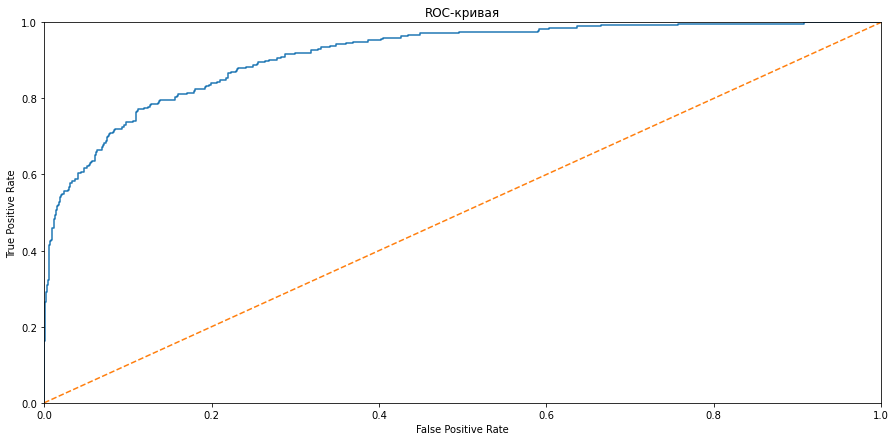

In [50]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one) 
plt.figure(figsize=(15,7))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

## Проверка модели на адекватность

In [51]:
dummy = DummyClassifier(strategy = 'constant', constant = 1)
dummy.fit(features_train, target_train)

probabilities_dummy = dummy.predict_proba(features_test)
probabilities_one_dummy = probabilities_dummy[:, 1]

print('Значение ROC-AUC:', roc_auc_score(target_test, probabilities_one_dummy))

Значение ROC-AUC: 0.5


Наша модель работает лучше дамми-модели.

## Исследование важности признаков в модели

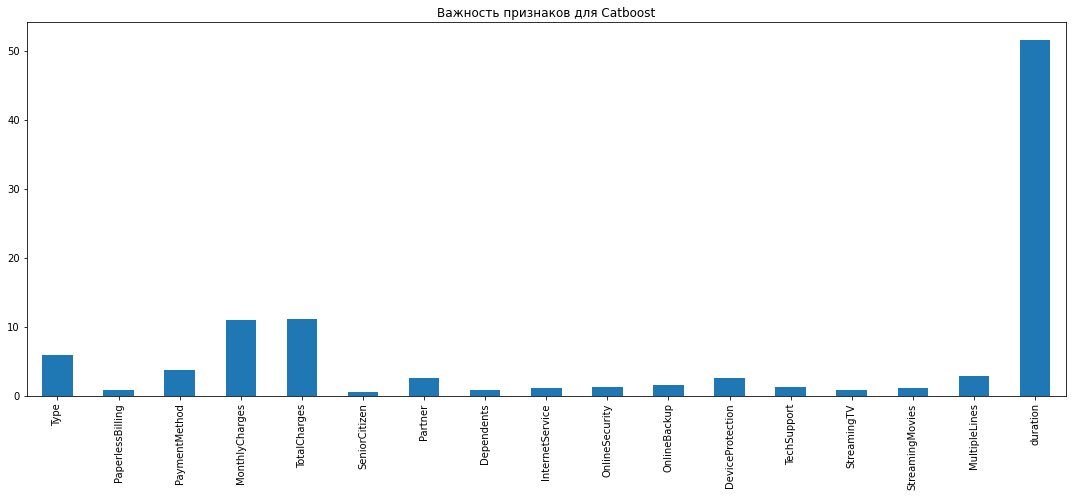

In [52]:
feature_importance = cat_model_grid.best_estimator_.get_feature_importance()
feature_importance = pd.Series(feature_importance, index=features_test.columns)

fig, ax = plt.subplots(figsize=(15,7))
feature_importance.plot.bar(ax=ax)
ax.set_title("Важность признаков для Catboost")
fig.tight_layout()
plt.show()

Наиболее важный признак в модели - срок продолжительности контракта, заметно, что есть много маловажных признаков, проверим работу модели без них.

In [53]:
new_features = ['Type', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Partner', 'DeviceProtection', 'MultipleLines', 'duration']
new_cat_features = ['Type', 'PaymentMethod', 'Partner', 'MultipleLines', 'DeviceProtection']

features_train_new = features_train[new_features]
features_test_new = features_test[new_features]

In [54]:
new_model = CatBoostClassifier(cat_features=new_cat_features, **cat_model_grid.best_params_, random_state=140823, auto_class_weights='Balanced')

In [55]:
%%time
new_model.fit(features_train_new, target_train)

0:	learn: 0.6682886	total: 3.09ms	remaining: 3.09s
1:	learn: 0.6479018	total: 5.68ms	remaining: 2.83s
2:	learn: 0.6311652	total: 9.07ms	remaining: 3.01s
3:	learn: 0.6174268	total: 11.5ms	remaining: 2.85s
4:	learn: 0.6015425	total: 13.6ms	remaining: 2.71s
5:	learn: 0.5887841	total: 16.5ms	remaining: 2.73s
6:	learn: 0.5770735	total: 19.2ms	remaining: 2.72s
7:	learn: 0.5685031	total: 21.9ms	remaining: 2.72s
8:	learn: 0.5624515	total: 24.4ms	remaining: 2.69s
9:	learn: 0.5559152	total: 27.3ms	remaining: 2.71s
10:	learn: 0.5521676	total: 29.3ms	remaining: 2.64s
11:	learn: 0.5486017	total: 31.9ms	remaining: 2.63s
12:	learn: 0.5440517	total: 34.3ms	remaining: 2.6s
13:	learn: 0.5370732	total: 36.7ms	remaining: 2.58s
14:	learn: 0.5318471	total: 39.2ms	remaining: 2.57s
15:	learn: 0.5286296	total: 42.2ms	remaining: 2.6s
16:	learn: 0.5251693	total: 45.2ms	remaining: 2.61s
17:	learn: 0.5212065	total: 48.2ms	remaining: 2.63s
18:	learn: 0.5187793	total: 50.6ms	remaining: 2.61s
19:	learn: 0.5167461	tot

162:	learn: 0.4066138	total: 447ms	remaining: 2.29s
163:	learn: 0.4059054	total: 450ms	remaining: 2.3s
164:	learn: 0.4051612	total: 454ms	remaining: 2.3s
165:	learn: 0.4044088	total: 457ms	remaining: 2.29s
166:	learn: 0.4040392	total: 459ms	remaining: 2.29s
167:	learn: 0.4038977	total: 461ms	remaining: 2.28s
168:	learn: 0.4028733	total: 465ms	remaining: 2.29s
169:	learn: 0.4018488	total: 468ms	remaining: 2.28s
170:	learn: 0.4014754	total: 471ms	remaining: 2.28s
171:	learn: 0.4006260	total: 474ms	remaining: 2.28s
172:	learn: 0.4001234	total: 477ms	remaining: 2.28s
173:	learn: 0.3985209	total: 480ms	remaining: 2.28s
174:	learn: 0.3960501	total: 483ms	remaining: 2.28s
175:	learn: 0.3956491	total: 486ms	remaining: 2.28s
176:	learn: 0.3951122	total: 491ms	remaining: 2.28s
177:	learn: 0.3945080	total: 493ms	remaining: 2.28s
178:	learn: 0.3937512	total: 496ms	remaining: 2.27s
179:	learn: 0.3927748	total: 499ms	remaining: 2.27s
180:	learn: 0.3917333	total: 502ms	remaining: 2.27s
181:	learn: 0.

344:	learn: 0.3105624	total: 983ms	remaining: 1.87s
345:	learn: 0.3101096	total: 986ms	remaining: 1.86s
346:	learn: 0.3083056	total: 990ms	remaining: 1.86s
347:	learn: 0.3073224	total: 993ms	remaining: 1.86s
348:	learn: 0.3067008	total: 997ms	remaining: 1.86s
349:	learn: 0.3065474	total: 1000ms	remaining: 1.86s
350:	learn: 0.3055118	total: 1s	remaining: 1.85s
351:	learn: 0.3053793	total: 1s	remaining: 1.85s
352:	learn: 0.3051733	total: 1.01s	remaining: 1.85s
353:	learn: 0.3051024	total: 1.01s	remaining: 1.84s
354:	learn: 0.3046758	total: 1.01s	remaining: 1.84s
355:	learn: 0.3045367	total: 1.02s	remaining: 1.84s
356:	learn: 0.3043735	total: 1.02s	remaining: 1.84s
357:	learn: 0.3042964	total: 1.02s	remaining: 1.83s
358:	learn: 0.3038785	total: 1.02s	remaining: 1.83s
359:	learn: 0.3035390	total: 1.03s	remaining: 1.83s
360:	learn: 0.3033974	total: 1.03s	remaining: 1.82s
361:	learn: 0.3031128	total: 1.03s	remaining: 1.82s
362:	learn: 0.3030203	total: 1.03s	remaining: 1.82s
363:	learn: 0.302

545:	learn: 0.2442524	total: 1.57s	remaining: 1.31s
546:	learn: 0.2441199	total: 1.58s	remaining: 1.31s
547:	learn: 0.2440838	total: 1.58s	remaining: 1.3s
548:	learn: 0.2435885	total: 1.58s	remaining: 1.3s
549:	learn: 0.2433660	total: 1.59s	remaining: 1.3s
550:	learn: 0.2431537	total: 1.59s	remaining: 1.29s
551:	learn: 0.2428733	total: 1.59s	remaining: 1.29s
552:	learn: 0.2425802	total: 1.59s	remaining: 1.29s
553:	learn: 0.2424589	total: 1.6s	remaining: 1.29s
554:	learn: 0.2421963	total: 1.6s	remaining: 1.28s
555:	learn: 0.2420149	total: 1.6s	remaining: 1.28s
556:	learn: 0.2418025	total: 1.61s	remaining: 1.28s
557:	learn: 0.2417539	total: 1.61s	remaining: 1.27s
558:	learn: 0.2415403	total: 1.61s	remaining: 1.27s
559:	learn: 0.2412415	total: 1.61s	remaining: 1.27s
560:	learn: 0.2409084	total: 1.62s	remaining: 1.26s
561:	learn: 0.2406800	total: 1.62s	remaining: 1.26s
562:	learn: 0.2403271	total: 1.62s	remaining: 1.26s
563:	learn: 0.2398994	total: 1.63s	remaining: 1.26s
564:	learn: 0.2397

745:	learn: 0.2030544	total: 2.17s	remaining: 738ms
746:	learn: 0.2029081	total: 2.17s	remaining: 735ms
747:	learn: 0.2027514	total: 2.17s	remaining: 732ms
748:	learn: 0.2026659	total: 2.17s	remaining: 729ms
749:	learn: 0.2024653	total: 2.18s	remaining: 726ms
750:	learn: 0.2022996	total: 2.18s	remaining: 723ms
751:	learn: 0.2022307	total: 2.18s	remaining: 720ms
752:	learn: 0.2021885	total: 2.19s	remaining: 717ms
753:	learn: 0.2019952	total: 2.19s	remaining: 714ms
754:	learn: 0.2019300	total: 2.19s	remaining: 712ms
755:	learn: 0.2016745	total: 2.19s	remaining: 709ms
756:	learn: 0.2016324	total: 2.2s	remaining: 706ms
757:	learn: 0.2015673	total: 2.2s	remaining: 703ms
758:	learn: 0.2012193	total: 2.2s	remaining: 700ms
759:	learn: 0.2011065	total: 2.21s	remaining: 697ms
760:	learn: 0.2008656	total: 2.21s	remaining: 694ms
761:	learn: 0.2007084	total: 2.21s	remaining: 691ms
762:	learn: 0.2001807	total: 2.22s	remaining: 688ms
763:	learn: 0.2000712	total: 2.22s	remaining: 685ms
764:	learn: 0.1

948:	learn: 0.1737740	total: 2.76s	remaining: 148ms
949:	learn: 0.1735547	total: 2.76s	remaining: 145ms
950:	learn: 0.1732345	total: 2.77s	remaining: 142ms
951:	learn: 0.1730669	total: 2.77s	remaining: 140ms
952:	learn: 0.1729752	total: 2.77s	remaining: 137ms
953:	learn: 0.1728848	total: 2.77s	remaining: 134ms
954:	learn: 0.1727515	total: 2.78s	remaining: 131ms
955:	learn: 0.1726397	total: 2.78s	remaining: 128ms
956:	learn: 0.1725081	total: 2.78s	remaining: 125ms
957:	learn: 0.1723092	total: 2.79s	remaining: 122ms
958:	learn: 0.1722858	total: 2.79s	remaining: 119ms
959:	learn: 0.1721588	total: 2.79s	remaining: 116ms
960:	learn: 0.1720606	total: 2.8s	remaining: 113ms
961:	learn: 0.1719687	total: 2.8s	remaining: 111ms
962:	learn: 0.1716943	total: 2.8s	remaining: 108ms
963:	learn: 0.1716769	total: 2.8s	remaining: 105ms
964:	learn: 0.1714915	total: 2.81s	remaining: 102ms
965:	learn: 0.1714766	total: 2.81s	remaining: 98.9ms
966:	learn: 0.1714533	total: 2.81s	remaining: 96ms
967:	learn: 0.17

In [56]:
probabilities = new_model.predict_proba(features_test_new)
probabilities_one = probabilities[:, 1]
print('Значение ROC-AUC:', roc_auc_score(target_test, probabilities_one))

Значение ROC-AUC: 0.9196990089318487


Модель обучилась быстрее (4min 33s против 3.14 s), а метрика на тестовой выборке возросла с 0.903 до 0.92.

Посмотрим на матрицу ошибок:

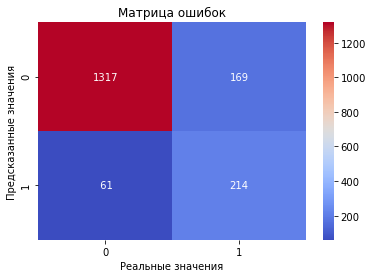

In [57]:
predicted = new_model.predict(features_test_new)
sns.heatmap(confusion_matrix(target_test, predicted), annot=True, cmap='coolwarm', fmt='3.0f')
plt.title('Матрица ошибок')
plt.xlabel('Реальные значения')
plt.ylabel('Предсказанные значения')
plt.show()

Большинство предсказаний модели (1317) - верно отмеченные значения, что клиент остался в компании, в меньшей степени (214) предсталены верные предсказания о том, что клиент ушел, чуть меньше (169) модель сделала ложно-положительных предсказаний. Нам в большей степени важны True Positive предсказания, ведь модель должна предсказывать, уйдет ли клиент, таких предсказаний у нас 214. 

## Выводы

При анализе данныз не было выявлено аномалий и перекоса в представленности классов в бинарных переменных. Был выделен целевой признак по колонке EndDate: если значение переменной 'No', то договор не прекратил свое действие, то есть клиент остался, в противном случае - клиент ушел. В целевой переменной больше всего записей о клиентах, которые не ушли из компании, но это не повлияло на дальнейшую работу, так как используемые модели могут с этим справляться. Также была добавлена новая переменная, отвечающая за продолжительность длительности контракта в днях.  
  
В работе были протестированы 3 модели: 
* Catboost: ROC-AUC на тренировочной равен 0.903 (с параметрами 'depth': 4, 'learning_rate': 0.1)
* LightGBM: ROC-AUC на тренировочной равен 0.826 (с параметрами 'learning_rate': 0.03, 'max_depth': 6, 'n_estimators': 30)
* Случайный лес: ROC-AUC на тренировочной равен 0.77 (с параметрами 'max_depth': 10, 'n_estimators': 16)  
  
Лучшая модель (Catboost) была протестирована на тестовой выборке, ROC-AUC равен 0.914. Дамми-модель на тестовой выборке дала результат ROC-AUC равный 0.5, что значит, что наша модель адекватна.  
  
Был произведен анализ важности переменных в лучшей модели. Наиболее важный признак в модели - срок продолжительности контракта, также важными признаками оказались тип оплаты, тип платежа, месячные расходы, общие расходы, антивирус, наличие супруга или супруги и подключение телефона к нескольким линиям одновременно. Была обучена модель Catboost на новых (важных) признаках, ускорилось ее обучение (4min 25s против 3.14 s), а также выросла метрика ROC-AUC с 0.903 до 0.92.

# Третья часть

## Отчет о проделанной работе

Изначально был предложен следующий план:   
1. Загрузить данные, объединить датасеты, обработать пропуски (они возникнут при объединении датасетов, тк у них разное количество строк), изучить матрицу корреляции и проверить данные на аномалии. 
2. Выделить целевой признак, разделить данные на две выборки - тестовую и обучающую. Применим кодирование категориальных переменных, но некоторые модели имеют встроенные кодировщики, поэтому им можно отдать исходные данные и настроить соотвествующий гиперпараметр.
3. Протестировать несколько моделей: подобрать к ним гиперпараметры при помощи RandomizedSearchCV, выбрать лучшую модель исходя из значения метрики ROC-AUC, расчитать время обучения моделей.
4. Лучшую модель из предыдущего пункта и протестировать на тестовой выборке. Проверить модель на адекватность путем сравнения результатов с dummy моделью.
5. Исследовать важность признаков в модели, проверить работу модели без маловажных признаков.
6. Написать общие выводы по проекту.
  
Все пункты плана были выполнены, на 5 шаге была также добавлена матрица ошибок для новой модели. Трудностей по ходу работы особо не возникало, единственное - пришлось подумать, чем можно заменить значение 'No' в переменной EndDate, чтобы перевести ее в формат даты для подсчета duration.
  
В решении задачи были следующие основные шаги:    
  
**Обработка данных и подготовка их для обучения**  
Для начала были объединены все датасеты в одно целое, переменные были преведены к правильному типу данных, были обработаны пропуски. Для модели были созданы два новых признака: длительность контракта (разница между EndDate и BeginDate) и целевая переменная - ушел ли клиент (создана по переменной EndDate). Были удалены признаки EndDate и BeginDate, а также переменная, отвечающая за айди пользователя, и пол, так как он практически не имел корреляции с остальными переменными.  
Данные были поделены на две выборки с соотношением 75/25, затем был применен OHE для работы со случайным лесом.  
  
**Обучение моделей**  
В работе были протестированы 3 модели:
1) Catboost: ROC-AUC на тренировочной равен 0.903 (с параметрами 'depth': 4, 'learning_rate': 0.1)
2) LightGBM: ROC-AUC на тренировочной равен 0.826 (с параметрами 'learning_rate': 0.03, 'max_depth': 6, 'n_estimators': 30)
3) Случайный лес: ROC-AUC на тренировочной равен 0.77 (с параметрами 'max_depth': 10, 'n_estimators': 16)
   
  
**Тестирование лучшей модели**  
Лучшая модель (Catboost) была протестирована на тестовой выборке, ROC-AUC равен 0.914. Был проведен анализ важности признаков, после чего были удалены маловажные признаки и заново была обучена модель, в результате чего ускорилось ее обучение (4min 25s против 3.14 s), а также выросла метрика ROC-AUC с 0.903 до 0.92.
  
***Итоговая модель:***  
Catboost с параметрами 'depth': 4, 'learning_rate': 0.1, auto_class_weights='Balanced', cat_features=new_cat_features, random_state=140823. Где new_cat_features = ['Type', 'PaymentMethod', 'Partner', 'MultipleLines', 'DeviceProtection']

*Признаки, на которых была обучена модель:* ['Type', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Partner', 'DeviceProtection', 'MultipleLines', 'duration']

